# Cycle GAN 



## import libraries

In [1]:
!pip install tensorflow-addons

In [2]:
from os import listdir
import numpy as np
from numpy import savez_compressed
import os
from os import listdir
import cv2
from numpy import asarray, vstack, savez_compressed
from numpy.random import randint
from glob import glob
from random import random, seed
from tqdm import tqdm
import tensorflow as tf
import tensorflow.image as tfi
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers
from keras.layers import ReLU, Input,Conv2D,Dropout,LeakyReLU, Activation, Concatenate, Conv2DTranspose
from keras.models import load_model,Model ,Sequential
from tensorflow_addons.layers import InstanceNormalization
from keras.initializers import RandomNormal
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Load images

In [3]:
#Resizing all the images and storing in compressed Numpy array.
def load_celeb_images(path, size=(128, 128), max_images=None):
    data_list = []
    for filename in listdir(path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Filter for specific image file extensions
            pixels = load_img(path + filename, target_size=size)
            pixels = img_to_array(pixels)
            data_list.append(pixels)
            if max_images and len(data_list) >= max_images:
                break
    return np.asarray(data_list)

celeb_path = '../input/celeba-dataset/img_align_celeba/img_align_celeba/'

# Load real data
dataA = load_celeb_images(celeb_path, max_images=400)
print('loaded dataA', dataA.shape)

loaded dataA (400, 128, 128, 3)


In [4]:
def load_style_images(path, size=(128, 128), max_images=None):
    data_list = []
    for folder_name in ['Arles','Auvers sur Oise','Saint Remy']:
        folder_path = path + folder_name + '/'
        for filename in listdir(folder_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')): 
                pixels = load_img(folder_path + filename, target_size=size)
                pixels = img_to_array(pixels)
                data_list.append(pixels)
                if max_images and len(data_list) >= max_images:
                    break
    return np.asarray(data_list)

style_path = "../input/van-gogh-paintings/VincentVanGogh/"

# Load style data
dataB = load_style_images(style_path, max_images=400)
print('loaded dataB', dataB.shape)

loaded dataB (400, 128, 128, 3)


In [5]:
filename = 'celebrity2style.npz'
np.savez_compressed(filename, dataA=dataA, dataB=dataB)
print('Saved dataset:', filename)

Saved dataset: celebrity2style.npz


## Plotting images of Celebrity and Style

Loaded data: (400, 128, 128, 3) (400, 128, 128, 3)


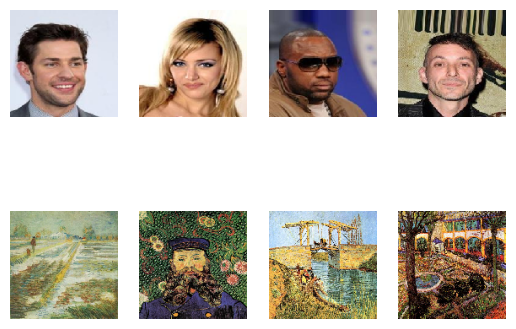

In [6]:
from numpy import load
data = load('celebrity2style.npz')
daraA, dataB = data['dataA'], data['dataB']
print('Loaded data:', dataA.shape, dataB.shape)

n_samples = 4
# plot original image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+i )
    plt.axis('off')
    plt.imshow(dataA[i].astype('uint8'))
# plot style image
for i in range (n_samples):
    plt.subplot(2 , n_samples,1+n_samples+i )
    plt.axis('off')
    plt.imshow(dataB[i].astype('uint8'))
plt.show()

Unlike other models, the CycleGAN discriminator uses InstanceNormalization instead of BatchNormalization. 

## Defining discriminator model

In [7]:
#define the discriminator model
def define_discriminator(image_shape):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(input_image)
    x = LeakyReLU(alpha = 0.2)(x)
    #c128
    x = Conv2D(128,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c256
    x = Conv2D(256,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    #c512
    x = Conv2D(512,(4,4), strides = 2 , padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    out_put = Conv2D(1, (4, 4), padding='same', kernel_initializer=init, use_bias=False)(x)

    model = Model(input_image, out_put)
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001, beta_1=0.5), loss_weights=[0.5])

    return model
    
image_shape = (128, 128, 3)
discriminator = define_discriminator(image_shape)
discriminator.summary()

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 instance_normalization (Ins  (None, 32, 32, 128)      256       
 tanceNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                             

## Defining generator model

In [8]:
def resnet_block(filters, layer):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(layer)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, (3,3), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    
    # skip connection
    x = Concatenate()([x, layer])
    return x
    

In [9]:
# define the generator model
def define_generator(image_shape, n_resnet=9):
    #weight initialization
    init = RandomNormal(stddev = 0.02)
    #source image input
    input_image = Input(shape = image_shape)
    #c64 
    x = Conv2D(64,(7,7), padding = 'same', kernel_initializer = init)(input_image)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c128 
    x = Conv2D(128,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    #c256 
    x = Conv2D(256,(3,3), strides = 2, padding = 'same', kernel_initializer = init)(x)
    x = InstanceNormalization(axis = -1)(x)
    x = Activation('relu')(x)
    
    for i in range(n_resnet):
        x = resnet_block(256 , x)
        
    # Add Conv2DTranspose layers to upscale the image to the desired shape
    
    x = Conv2DTranspose(128, (3, 3), strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2DTranspose(64, (3, 3),  strides = 2, padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    x = Activation('relu')(x)
    
    x = Conv2D(3, (7, 7), padding='same', kernel_initializer=init)(x)
    x = InstanceNormalization(axis=-1)(x)
    out_image = Activation('relu')(x)

    model = Model(input_image, out_image)
    return model

image_shape = (128, 128, 3)
generator = define_generator(image_shape)
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 instance_normalization_3 (Inst  (None, 128, 128, 64  128        ['conv2d_5[0][0]']               
 anceNormalization)             )                                                           

**adversarial loss**
The generator models are trained via their related discriminator models. Specifically, they are updated to minimize the loss predicted by the discriminator for generated images marked as “real“, called adversarial loss. 

**cycle loss**
The generator models are also updated based on how effective they are at the regeneration of a source image when used with the other generator model, called cycle loss. 

**identity loss**
Finally, a generator model is expected to output an image without translation when provided an example from the target domain, called identity loss.

Altogether, each generator model is optimized via the combination of four outputs with four loss functions:

- Adversarial loss (L2 or mean squared error).
- Identity loss (L1 or mean absolute error).
- Forward cycle loss (L1 or mean absolute error).
- Backward cycle loss (L1 or mean absolute error).

MSE for label, MAE for graph.

4 outputs: discriminator output, identity generated image, forward cycle generated image, and backward cycle generated image.

## Defining Composite model

In [10]:
from keras.layers import Lambda, Reshape

def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    g_model_1.trainable = True
    d_model.trainable = False
    g_model_2.trainable = False
    
    # Input for generated images
    input_gen = Input(shape=image_shape)
    
    # Resize generated images to the shape expected by the discriminator
    resized_gen = Lambda(lambda x: tf.image.resize(x, (128, 128), method=tf.image.ResizeMethod.BILINEAR))(input_gen)
    
    # Forward pass through the generator and discriminator
    gen_1_out = g_model_1(resized_gen)
    output_d = d_model(gen_1_out)
    
    # Input for identity mapping
    input_id = Input(shape=image_shape)
    
    # Forward pass for identity mapping
    output_id = g_model_1(input_id)
    
    # Forward and backward cycle loss
    output_f = g_model_2(gen_1_out)
    gen_2_out = g_model_2(input_id)
    output_b = g_model_1(gen_2_out)
    
    # Define the composite model
    # adversarial loss, identity loss, forward cycle loss, backward cycle loss
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
    
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 10, 30, 30], optimizer=opt)
    
    return model

## Load real samples

In [11]:
def load_real_samples(filename):
    data = load(filename)
    X1,X2 = data['dataA'],data['dataB']
    X1 = (X1-127.5)/127.5 #for source image
    X2 = (X2-127.5)/127.5 # for target images
    return [X1,X2]

In [12]:
import random

def generate_real_samples(dataset, n_samples, patch_shape):
    # choose random instances
    ix = randint(0,dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, patch_shape, patch_shape, 1))
    return X, y


A sample of generated images is required to update each discriminator model in each training iteration.

In [13]:
##select a batch of random samples,return images and target
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate a batch of random noise as input for the generator
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0)
    y = np.zeros((len(X), patch_shape,patch_shape, 1))
    
    return X, y


In [14]:
#save the generator model to file
def save_models(step, g_model_AtoB, g_model_BtoA):
    filename1 = 'g_model_AtoB_%06d.h5' %(step +1)
    g_model_AtoB.save(filename1)
    filename2 = 'g_model_BtoA_%06d.h5' %(step +1)
    g_model_BtoA.save(filename2)
    print('>saved:%s and %s' %(filename1,filename2))
    

In [15]:
#update image pool for fake image
import random  # Import the random module

def update_image_pool(pool, images, max_size=50):
    selected = list()
    for image in images:
        if len(pool) < max_size:
            # Stock the pool
            pool.append(image)
            selected.append(image)
        elif random.random() < 0.5:  # Use random.random() instead of random() here
            # Use image, but don't add it to the pool
            selected.append(image)
        else:
            # Replace an existing image and use the replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)  #
 

In [16]:
def show_image(image , title = None):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')

In [17]:
def show_preds(g_AB, g_BA, n_images=1):
    for i in range(n_images):
        id = np.random.randint(len(dataA))
        data = load('celebrity2style.npz')
        celeb, style = dataA[id], dataB[id]
        celeb_pred, style_pred = g_BA.predict(tf.expand_dims(style, axis=0))[0], g_AB.predict(tf.expand_dims(celeb, axis=0))[0]
        
        plt.figure(figsize=(10, 8))
        
        plt.subplot(1, 4, 1)
        show_image(celeb.astype('uint8'), title='Original celeb')
        
        plt.subplot(1, 4, 2)
        show_image(style_pred, title='Generated celeb')
        
        plt.subplot(1, 4, 3)
        show_image(style.astype('uint8'), title='Original style')
        
        plt.subplot(1, 4, 4)
        show_image(celeb_pred, title='Generated style')
        
        
        plt.show()

Now the training the models which takes all 6 models ( 2 discriminator , 2 generator and 2 composite models) as input with dataset for training.

## Train cyclegan model

In [18]:
# train cyclegan model
def train(dataset,d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA,epochs=10, chunk=5):
    #define peroperties of the training run
    n_epochs, n_batch = epochs, 1
    #determine the output square shape of discriminator
    n_patch = d_model_A.output_shape[1]
    #unpack dataset
    trainA, trainB = dataset[0], dataset[1]
    #prepare image pool for fakes
    poolA, poolB = list(), list()
    #calcute the number of batches per training epoch
    batch_per_epoch = int(len(trainA)/n_batch)
    #calcute the number of training iteration
    n_steps = batch_per_epoch 
    
    #manually enumerate epochs
    loss_history = []
    for j in tqdm(range(epochs), desc='Epochs'):
        for i in tqdm(range(n_steps), desc='Batchs'):
            #select a batch of real sample
            X_realA, y_realA = generate_real_samples(trainA,n_batch, n_patch)
            X_realB, y_realB = generate_real_samples(trainB,n_batch, n_patch)
            
            #genarate a batch of fake sample
            X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
            X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
            
            #update fakes from pool
            X_fakeA = update_image_pool(poolA, X_fakeA)
            X_fakeB = update_image_pool(poolB, X_fakeB)
            
            #update generator B->A via adversarial and cycle loss
            gen_loss2, _, _, _,_ = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])


            # update discriminator for A->[real/fake]
            dA_loss_1 = d_model_A.train_on_batch(X_realA, y_realA)
            dA_loss_2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
            
            #update generator A->B via adversarial and cycle loss
            gen_loss1, _, _, _,_ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
            
            # update discriminator for B->[real/fake]
            dB_loss_1 = d_model_B.train_on_batch(X_realB, y_realB)
            dB_loss_2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
            
            #summerize performance
            print('>%d, dA[%.3f ,%.3f ] dB[%.3f ,%.3f] g[%.3f ,%.3f]' %(i+1,dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2))
        
        loss_history.append([dA_loss_1,dA_loss_2, dB_loss_1,dB_loss_2,gen_loss1,gen_loss2])
            
        if(j%chunk)==0:
            show_preds(g_model_AtoB,g_model_BtoA, n_images=1)
                #save the models
            g_model_AtoB.save('Generator_Celebrity_to_Style.h5')
            g_model_BtoA.save('Generator_Style_to_Celebrity.h5')
    
    return loss_history
                

The loss is reported each training iteration, including the Discriminator-A loss on real and fake examples (dA), Discriminator-B loss on real and fake examples (dB), and Generator-AtoB and Generator-BtoA loss, each of which is a weighted average of adversarial, identity, forward, and backward cycle loss (g).

Loaded (400, 128, 128, 3) (400, 128, 128, 3)


Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step



Batchs:   0%|          | 1/400 [01:21<9:04:54, 81.94s/it]

>1, dA[0.976 ,5.340 ] dB[0.783 ,4.064] g[47.586 ,49.622]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [01:22<3:46:08, 34.09s/it]

>2, dA[17.134 ,2.461 ] dB[3.140 ,3.264] g[55.388 ,64.492]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [01:23<2:04:22, 18.80s/it]

>3, dA[5.322 ,2.725 ] dB[6.347 ,8.826] g[51.667 ,43.659]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [01:23<1:16:37, 11.61s/it]

>4, dA[5.706 ,2.359 ] dB[21.365 ,9.220] g[68.235 ,54.215]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [01:24<50:15,  7.64s/it]  

>5, dA[4.111 ,5.145 ] dB[5.281 ,3.546] g[58.222 ,58.358]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [01:24<34:23,  5.24s/it]

>6, dA[1.660 ,2.513 ] dB[3.471 ,2.076] g[46.520 ,49.753]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [01:25<24:22,  3.72s/it]

>7, dA[3.047 ,1.261 ] dB[1.514 ,1.285] g[51.871 ,57.055]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [01:26<17:47,  2.72s/it]

>8, dA[0.651 ,0.979 ] dB[0.446 ,0.635] g[52.318 ,56.414]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [01:26<13:24,  2.06s/it]

>9, dA[0.722 ,0.635 ] dB[0.464 ,0.615] g[34.664 ,35.307]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [01:27<10:25,  1.60s/it]

>10, dA[0.851 ,0.448 ] dB[0.842 ,0.252] g[47.387 ,50.662]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [01:27<08:23,  1.29s/it]

>11, dA[0.203 ,0.416 ] dB[0.571 ,0.356] g[39.406 ,37.619]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [01:28<06:59,  1.08s/it]

>12, dA[0.238 ,0.271 ] dB[0.706 ,0.404] g[35.217 ,35.955]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [01:29<06:00,  1.07it/s]

>13, dA[0.341 ,0.129 ] dB[0.243 ,0.205] g[45.172 ,44.757]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [01:29<05:19,  1.21it/s]

>14, dA[0.225 ,0.974 ] dB[0.281 ,0.295] g[45.825 ,47.911]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [01:30<04:51,  1.32it/s]

>15, dA[0.650 ,0.271 ] dB[0.330 ,0.221] g[53.384 ,54.406]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [01:30<04:31,  1.42it/s]

>16, dA[0.543 ,0.448 ] dB[0.276 ,0.271] g[50.340 ,50.990]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [01:31<04:17,  1.49it/s]

>17, dA[0.172 ,0.345 ] dB[0.223 ,0.117] g[40.071 ,43.301]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [01:31<04:07,  1.54it/s]

>18, dA[0.250 ,0.229 ] dB[0.227 ,0.249] g[44.111 ,43.683]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▍         | 19/400 [01:32<04:01,  1.58it/s]

>19, dA[0.305 ,0.313 ] dB[0.269 ,0.272] g[42.014 ,44.904]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 20/400 [01:33<03:58,  1.60it/s]

>20, dA[0.271 ,0.317 ] dB[0.403 ,0.281] g[43.604 ,42.959]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 21/400 [01:33<03:53,  1.62it/s]

>21, dA[0.289 ,0.236 ] dB[0.228 ,0.349] g[39.959 ,39.581]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [01:34<03:50,  1.64it/s]

>22, dA[0.266 ,0.246 ] dB[0.226 ,0.293] g[43.981 ,44.425]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [01:34<03:48,  1.65it/s]

>23, dA[0.142 ,0.499 ] dB[0.751 ,0.324] g[33.758 ,34.457]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 24/400 [01:35<03:47,  1.65it/s]

>24, dA[0.251 ,0.131 ] dB[0.264 ,0.487] g[35.047 ,36.592]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [01:36<03:45,  1.67it/s]

>25, dA[0.164 ,0.238 ] dB[0.266 ,0.153] g[40.215 ,36.768]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [01:36<03:43,  1.67it/s]

>26, dA[0.242 ,0.211 ] dB[0.179 ,0.280] g[34.475 ,32.991]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [01:37<03:42,  1.67it/s]

>27, dA[0.323 ,0.300 ] dB[0.263 ,0.273] g[36.856 ,39.575]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [01:37<03:42,  1.67it/s]

>28, dA[0.184 ,0.172 ] dB[0.160 ,0.184] g[33.042 ,32.148]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [01:38<03:41,  1.68it/s]

>29, dA[0.342 ,0.372 ] dB[0.423 ,0.523] g[31.554 ,35.403]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 30/400 [01:39<03:43,  1.65it/s]

>30, dA[0.308 ,0.165 ] dB[0.355 ,0.242] g[38.672 ,40.720]
1/1 [==============================] - 0s 26ms/step



Batchs:   8%|▊         | 31/400 [01:39<03:45,  1.64it/s]

>31, dA[0.433 ,0.331 ] dB[0.383 ,0.356] g[31.741 ,29.456]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [01:40<03:43,  1.65it/s]

>32, dA[0.134 ,0.409 ] dB[0.339 ,0.404] g[35.031 ,37.712]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [01:40<03:40,  1.66it/s]

>33, dA[0.565 ,0.283 ] dB[0.345 ,0.202] g[40.928 ,45.703]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [01:41<03:39,  1.67it/s]

>34, dA[0.587 ,0.451 ] dB[0.321 ,0.380] g[47.956 ,50.597]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 35/400 [01:42<03:38,  1.67it/s]

>35, dA[0.967 ,0.446 ] dB[0.227 ,0.159] g[33.759 ,34.051]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [01:42<03:36,  1.68it/s]

>36, dA[0.370 ,0.807 ] dB[0.315 ,0.438] g[30.400 ,31.904]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 37/400 [01:43<03:37,  1.67it/s]

>37, dA[0.921 ,0.206 ] dB[0.784 ,0.406] g[31.826 ,32.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [01:43<03:35,  1.68it/s]

>38, dA[0.442 ,0.377 ] dB[0.297 ,0.369] g[33.310 ,35.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [01:44<03:34,  1.68it/s]

>39, dA[0.361 ,0.225 ] dB[0.120 ,0.254] g[39.925 ,40.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [01:45<03:33,  1.68it/s]

>40, dA[0.212 ,0.589 ] dB[0.651 ,0.580] g[29.735 ,29.723]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [01:45<03:32,  1.69it/s]

>41, dA[0.481 ,0.555 ] dB[0.717 ,0.418] g[29.921 ,29.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [01:46<03:31,  1.69it/s]

>42, dA[0.621 ,0.623 ] dB[0.537 ,0.336] g[38.793 ,39.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [01:46<03:31,  1.69it/s]

>43, dA[0.219 ,0.108 ] dB[0.317 ,0.642] g[42.511 ,45.059]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 44/400 [01:47<03:31,  1.68it/s]

>44, dA[0.270 ,0.345 ] dB[0.565 ,0.346] g[35.509 ,35.322]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 45/400 [01:48<03:29,  1.69it/s]

>45, dA[0.154 ,0.170 ] dB[0.213 ,0.650] g[34.034 ,35.067]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 46/400 [01:48<03:28,  1.70it/s]

>46, dA[0.228 ,0.547 ] dB[0.837 ,0.410] g[35.671 ,32.371]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 47/400 [01:49<03:28,  1.69it/s]

>47, dA[0.268 ,0.306 ] dB[0.692 ,0.430] g[36.290 ,37.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [01:49<03:27,  1.70it/s]

>48, dA[0.202 ,0.431 ] dB[0.946 ,0.933] g[35.074 ,35.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [01:50<03:26,  1.70it/s]

>49, dA[0.291 ,0.269 ] dB[0.492 ,0.373] g[36.203 ,37.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [01:51<03:26,  1.70it/s]

>50, dA[0.234 ,0.394 ] dB[0.605 ,0.321] g[40.457 ,41.695]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [01:51<03:26,  1.69it/s]

>51, dA[0.416 ,0.142 ] dB[0.245 ,0.236] g[32.742 ,35.302]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [01:52<03:26,  1.68it/s]

>52, dA[0.213 ,0.260 ] dB[0.434 ,0.292] g[41.107 ,42.121]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 53/400 [01:52<03:39,  1.58it/s]

>53, dA[0.410 ,0.265 ] dB[0.302 ,0.270] g[30.510 ,32.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [01:53<03:35,  1.61it/s]

>54, dA[0.246 ,2.191 ] dB[0.359 ,0.249] g[37.451 ,41.173]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [01:54<03:32,  1.63it/s]

>55, dA[0.215 ,1.200 ] dB[0.227 ,0.387] g[24.119 ,23.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [01:54<03:28,  1.65it/s]

>56, dA[0.705 ,0.203 ] dB[0.695 ,0.231] g[32.881 ,37.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [01:55<03:26,  1.66it/s]

>57, dA[0.275 ,0.325 ] dB[0.175 ,0.303] g[35.140 ,34.471]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 58/400 [01:55<03:24,  1.67it/s]

>58, dA[0.243 ,0.202 ] dB[0.692 ,0.548] g[44.822 ,45.849]
1/1 [==============================] - 0s 23ms/step



Batchs:  15%|█▍        | 59/400 [01:56<03:25,  1.66it/s]

>59, dA[0.363 ,0.312 ] dB[0.260 ,0.343] g[34.191 ,37.972]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 60/400 [01:57<03:24,  1.66it/s]

>60, dA[0.232 ,0.062 ] dB[0.526 ,0.219] g[30.036 ,31.166]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 61/400 [01:57<03:23,  1.67it/s]

>61, dA[0.081 ,0.208 ] dB[0.176 ,0.139] g[41.806 ,42.908]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 62/400 [01:58<03:21,  1.68it/s]

>62, dA[0.233 ,0.093 ] dB[0.223 ,0.070] g[33.740 ,35.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [01:58<03:21,  1.68it/s]

>63, dA[0.147 ,0.426 ] dB[0.146 ,0.313] g[29.513 ,31.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [01:59<03:20,  1.68it/s]

>64, dA[0.154 ,0.294 ] dB[0.332 ,0.130] g[38.366 ,40.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 65/400 [02:00<03:18,  1.68it/s]

>65, dA[0.269 ,0.385 ] dB[0.224 ,0.404] g[23.788 ,25.872]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [02:00<03:17,  1.69it/s]

>66, dA[0.126 ,0.145 ] dB[0.227 ,0.109] g[26.541 ,27.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [02:01<03:18,  1.68it/s]

>67, dA[0.127 ,0.108 ] dB[0.494 ,0.323] g[56.598 ,57.579]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 68/400 [02:01<03:17,  1.68it/s]

>68, dA[0.628 ,0.829 ] dB[0.127 ,0.209] g[28.272 ,29.806]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 69/400 [02:02<03:16,  1.68it/s]

>69, dA[0.057 ,0.062 ] dB[0.665 ,0.782] g[37.285 ,35.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [02:03<03:18,  1.66it/s]

>70, dA[0.285 ,0.222 ] dB[0.296 ,0.437] g[42.870 ,43.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [02:03<03:17,  1.67it/s]

>71, dA[0.377 ,0.156 ] dB[0.360 ,0.354] g[34.764 ,36.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [02:04<03:15,  1.68it/s]

>72, dA[0.284 ,0.356 ] dB[0.100 ,0.949] g[34.775 ,37.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [02:04<03:13,  1.69it/s]

>73, dA[0.255 ,0.096 ] dB[0.417 ,0.334] g[31.750 ,30.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [02:05<03:12,  1.69it/s]

>74, dA[0.065 ,0.106 ] dB[0.251 ,0.203] g[47.764 ,47.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [02:06<03:12,  1.69it/s]

>75, dA[0.257 ,0.103 ] dB[0.405 ,0.459] g[32.149 ,33.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [02:06<03:11,  1.69it/s]

>76, dA[0.084 ,0.201 ] dB[0.221 ,0.095] g[29.022 ,29.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [02:07<03:10,  1.70it/s]

>77, dA[0.172 ,0.139 ] dB[0.151 ,0.138] g[32.056 ,30.843]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 78/400 [02:07<03:10,  1.69it/s]

>78, dA[0.089 ,0.039 ] dB[0.145 ,0.150] g[40.136 ,43.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [02:08<03:10,  1.69it/s]

>79, dA[0.363 ,0.214 ] dB[0.131 ,0.136] g[30.341 ,30.976]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [02:09<03:09,  1.69it/s]

>80, dA[0.069 ,0.127 ] dB[0.144 ,0.219] g[32.593 ,32.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [02:09<03:08,  1.70it/s]

>81, dA[0.865 ,0.448 ] dB[0.255 ,1.613] g[22.655 ,26.906]
1/1 [==============================] - 0s 27ms/step



Batchs:  20%|██        | 82/400 [02:10<03:09,  1.68it/s]

>82, dA[0.178 ,0.636 ] dB[0.409 ,0.612] g[26.721 ,26.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [02:10<03:09,  1.67it/s]

>83, dA[0.401 ,0.435 ] dB[0.328 ,0.163] g[27.726 ,28.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [02:11<03:08,  1.67it/s]

>84, dA[0.254 ,0.381 ] dB[0.315 ,0.224] g[33.601 ,36.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [02:11<03:07,  1.68it/s]

>85, dA[0.220 ,0.451 ] dB[0.304 ,0.081] g[35.526 ,37.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [02:12<03:05,  1.69it/s]

>86, dA[0.509 ,0.220 ] dB[0.141 ,0.313] g[32.422 ,31.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [02:13<03:05,  1.69it/s]

>87, dA[0.319 ,0.217 ] dB[0.663 ,0.397] g[33.533 ,33.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [02:13<03:04,  1.69it/s]

>88, dA[0.171 ,0.254 ] dB[0.481 ,0.579] g[31.663 ,32.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [02:14<03:03,  1.69it/s]

>89, dA[0.345 ,0.207 ] dB[0.369 ,0.141] g[35.088 ,37.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [02:14<03:02,  1.70it/s]

>90, dA[0.333 ,0.115 ] dB[0.385 ,0.256] g[36.233 ,39.205]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [02:15<03:02,  1.69it/s]

>91, dA[0.383 ,0.136 ] dB[0.420 ,0.409] g[36.231 ,36.552]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [02:16<03:02,  1.69it/s]

>92, dA[0.217 ,0.096 ] dB[0.690 ,0.380] g[40.275 ,41.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [02:16<03:01,  1.70it/s]

>93, dA[0.215 ,0.197 ] dB[0.525 ,0.468] g[37.440 ,40.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [02:17<03:00,  1.70it/s]

>94, dA[0.179 ,0.180 ] dB[0.639 ,0.205] g[34.330 ,32.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [02:17<03:00,  1.69it/s]

>95, dA[0.187 ,0.203 ] dB[0.157 ,0.424] g[23.953 ,25.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [02:18<02:59,  1.69it/s]

>96, dA[0.122 ,0.380 ] dB[0.359 ,0.273] g[30.570 ,28.525]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [02:19<02:59,  1.69it/s]

>97, dA[0.229 ,0.149 ] dB[0.164 ,0.444] g[21.990 ,23.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [02:19<02:58,  1.70it/s]

>98, dA[0.545 ,0.303 ] dB[0.196 ,0.143] g[39.527 ,40.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [02:20<02:57,  1.69it/s]

>99, dA[0.485 ,0.582 ] dB[0.063 ,0.107] g[37.679 ,41.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [02:20<02:57,  1.69it/s]

>100, dA[0.306 ,0.546 ] dB[0.218 ,0.116] g[27.586 ,29.265]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [02:21<02:56,  1.69it/s]

>101, dA[0.249 ,0.160 ] dB[0.170 ,0.107] g[35.814 ,38.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [02:22<02:55,  1.70it/s]

>102, dA[0.142 ,0.152 ] dB[0.467 ,0.429] g[32.097 ,33.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [02:22<02:56,  1.69it/s]

>103, dA[0.148 ,0.245 ] dB[0.174 ,0.113] g[28.743 ,28.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [02:23<02:55,  1.68it/s]

>104, dA[0.133 ,0.252 ] dB[0.340 ,0.156] g[26.591 ,27.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [02:23<02:54,  1.69it/s]

>105, dA[0.423 ,0.349 ] dB[0.111 ,0.140] g[27.859 ,30.618]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [02:24<02:53,  1.69it/s]

>106, dA[0.673 ,0.359 ] dB[0.274 ,0.120] g[22.363 ,23.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [02:25<02:53,  1.69it/s]

>107, dA[0.209 ,0.221 ] dB[0.111 ,0.262] g[30.654 ,32.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [02:25<02:52,  1.69it/s]

>108, dA[0.184 ,0.230 ] dB[0.156 ,0.185] g[30.203 ,30.158]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 109/400 [02:26<02:51,  1.69it/s]

>109, dA[0.187 ,0.114 ] dB[0.289 ,0.185] g[31.771 ,31.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [02:26<02:50,  1.70it/s]

>110, dA[0.177 ,0.205 ] dB[0.303 ,0.366] g[34.779 ,39.990]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 111/400 [02:27<02:50,  1.69it/s]

>111, dA[0.115 ,0.103 ] dB[0.116 ,0.218] g[32.579 ,30.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [02:27<02:49,  1.70it/s]

>112, dA[0.256 ,0.295 ] dB[0.128 ,0.204] g[29.505 ,26.950]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [02:28<02:49,  1.70it/s]

>113, dA[0.144 ,0.117 ] dB[0.214 ,0.173] g[33.213 ,34.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [02:29<02:48,  1.70it/s]

>114, dA[0.233 ,0.209 ] dB[0.267 ,0.180] g[41.464 ,44.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [02:29<02:48,  1.69it/s]

>115, dA[0.140 ,0.267 ] dB[0.269 ,0.140] g[35.623 ,40.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [02:30<02:47,  1.69it/s]

>116, dA[0.510 ,0.252 ] dB[0.493 ,0.595] g[25.324 ,24.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [02:30<02:46,  1.70it/s]

>117, dA[0.177 ,0.163 ] dB[0.351 ,0.279] g[42.883 ,44.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [02:31<02:46,  1.70it/s]

>118, dA[0.361 ,0.312 ] dB[0.412 ,0.145] g[34.875 ,31.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [02:32<02:46,  1.69it/s]

>119, dA[0.184 ,0.598 ] dB[0.143 ,0.075] g[38.742 ,36.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [02:32<02:45,  1.69it/s]

>120, dA[0.711 ,0.538 ] dB[0.311 ,0.158] g[31.060 ,36.114]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 121/400 [02:33<02:44,  1.69it/s]

>121, dA[1.230 ,0.434 ] dB[0.079 ,0.122] g[36.563 ,39.122]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 122/400 [02:33<02:45,  1.68it/s]

>122, dA[1.334 ,0.687 ] dB[0.176 ,0.199] g[31.437 ,32.300]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 123/400 [02:34<02:44,  1.68it/s]

>123, dA[1.008 ,0.476 ] dB[0.086 ,0.342] g[25.425 ,26.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [02:35<02:43,  1.68it/s]

>124, dA[0.643 ,0.283 ] dB[0.384 ,0.115] g[32.060 ,33.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [02:35<02:43,  1.69it/s]

>125, dA[0.383 ,0.316 ] dB[0.174 ,0.185] g[33.426 ,34.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [02:36<02:42,  1.69it/s]

>126, dA[0.067 ,0.262 ] dB[0.382 ,0.061] g[39.244 ,43.169]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 127/400 [02:36<02:42,  1.68it/s]

>127, dA[0.275 ,0.234 ] dB[0.192 ,0.416] g[21.461 ,21.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [02:37<02:41,  1.68it/s]

>128, dA[0.064 ,0.265 ] dB[0.394 ,0.589] g[37.222 ,41.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [02:38<02:40,  1.69it/s]

>129, dA[0.262 ,0.320 ] dB[0.397 ,0.479] g[22.628 ,22.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [02:38<02:39,  1.69it/s]

>130, dA[0.394 ,0.139 ] dB[0.756 ,0.327] g[28.964 ,28.650]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 131/400 [02:39<02:48,  1.60it/s]

>131, dA[0.102 ,0.217 ] dB[0.203 ,0.084] g[44.679 ,45.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [02:39<02:45,  1.62it/s]

>132, dA[0.087 ,0.208 ] dB[0.060 ,0.127] g[35.156 ,34.757]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [02:40<02:42,  1.65it/s]

>133, dA[0.269 ,0.261 ] dB[0.074 ,0.146] g[48.404 ,50.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [02:41<02:43,  1.63it/s]

>134, dA[0.372 ,0.218 ] dB[0.356 ,0.405] g[26.004 ,28.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [02:41<02:43,  1.62it/s]

>135, dA[0.282 ,0.133 ] dB[0.409 ,0.079] g[38.933 ,42.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [02:42<02:41,  1.64it/s]

>136, dA[0.127 ,0.168 ] dB[0.339 ,0.212] g[32.369 ,34.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [02:42<02:38,  1.66it/s]

>137, dA[0.079 ,0.131 ] dB[0.123 ,0.270] g[33.890 ,33.812]
1/1 [==============================] - 0s 22ms/step



Batchs:  34%|███▍      | 138/400 [02:43<02:37,  1.67it/s]

>138, dA[0.140 ,0.284 ] dB[0.152 ,0.100] g[25.517 ,26.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [02:44<02:36,  1.67it/s]

>139, dA[0.248 ,0.144 ] dB[0.217 ,0.155] g[32.527 ,32.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [02:44<02:34,  1.68it/s]

>140, dA[0.242 ,0.213 ] dB[0.216 ,0.076] g[29.965 ,30.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 141/400 [02:45<02:33,  1.69it/s]

>141, dA[0.066 ,0.062 ] dB[0.200 ,0.310] g[21.839 ,22.925]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 142/400 [02:45<02:32,  1.69it/s]

>142, dA[0.139 ,0.129 ] dB[0.132 ,0.051] g[40.376 ,44.535]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 143/400 [02:46<02:32,  1.69it/s]

>143, dA[0.030 ,0.094 ] dB[0.145 ,0.047] g[27.301 ,27.899]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [02:47<02:31,  1.69it/s]

>144, dA[0.052 ,0.031 ] dB[0.216 ,0.208] g[29.631 ,30.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [02:47<02:30,  1.69it/s]

>145, dA[0.074 ,0.086 ] dB[0.072 ,0.102] g[37.668 ,35.856]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [02:48<02:29,  1.70it/s]

>146, dA[0.068 ,0.045 ] dB[0.164 ,0.293] g[32.265 ,33.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [02:48<02:29,  1.69it/s]

>147, dA[0.142 ,0.141 ] dB[0.073 ,0.110] g[26.153 ,27.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [02:49<02:29,  1.69it/s]

>148, dA[0.059 ,0.056 ] dB[0.286 ,0.288] g[25.706 ,24.442]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [02:50<02:28,  1.70it/s]

>149, dA[0.085 ,0.066 ] dB[0.293 ,0.252] g[31.847 ,32.792]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [02:50<02:27,  1.70it/s]

>150, dA[0.159 ,0.245 ] dB[0.106 ,0.308] g[25.981 ,24.013]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 151/400 [02:51<02:26,  1.69it/s]

>151, dA[0.072 ,0.069 ] dB[0.160 ,0.167] g[31.302 ,32.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [02:51<02:26,  1.70it/s]

>152, dA[0.080 ,0.068 ] dB[0.193 ,0.241] g[31.807 ,32.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [02:52<02:25,  1.70it/s]

>153, dA[0.040 ,0.283 ] dB[0.478 ,0.183] g[33.798 ,36.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [02:52<02:24,  1.70it/s]

>154, dA[0.263 ,0.158 ] dB[0.446 ,0.162] g[22.205 ,20.411]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 155/400 [02:53<02:24,  1.69it/s]

>155, dA[0.472 ,0.221 ] dB[0.164 ,0.077] g[41.901 ,45.399]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [02:54<02:24,  1.69it/s]

>156, dA[0.045 ,0.259 ] dB[0.099 ,0.084] g[25.973 ,25.367]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [02:54<02:23,  1.70it/s]

>157, dA[0.245 ,0.347 ] dB[0.240 ,0.300] g[24.022 ,24.097]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [02:55<02:23,  1.69it/s]

>158, dA[0.553 ,0.487 ] dB[0.361 ,0.194] g[39.296 ,40.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [02:55<02:22,  1.69it/s]

>159, dA[1.129 ,0.883 ] dB[0.176 ,0.091] g[33.588 ,38.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [02:56<02:21,  1.69it/s]

>160, dA[0.486 ,0.371 ] dB[0.138 ,0.061] g[33.358 ,33.806]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [02:57<02:20,  1.70it/s]

>161, dA[0.537 ,0.218 ] dB[0.220 ,0.206] g[33.827 ,36.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [02:57<02:20,  1.70it/s]

>162, dA[0.385 ,0.067 ] dB[0.181 ,0.066] g[25.117 ,26.609]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 163/400 [02:58<02:19,  1.69it/s]

>163, dA[0.147 ,0.171 ] dB[0.074 ,0.109] g[29.690 ,31.345]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [02:58<02:19,  1.70it/s]

>164, dA[0.111 ,0.037 ] dB[0.374 ,0.330] g[38.839 ,42.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [02:59<02:18,  1.70it/s]

>165, dA[0.126 ,0.034 ] dB[0.199 ,0.044] g[31.145 ,31.913]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [03:00<02:17,  1.70it/s]

>166, dA[0.114 ,0.113 ] dB[0.144 ,0.093] g[27.037 ,27.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [03:00<02:17,  1.69it/s]

>167, dA[0.113 ,0.176 ] dB[0.163 ,0.073] g[31.976 ,29.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [03:01<02:17,  1.69it/s]

>168, dA[0.228 ,0.054 ] dB[0.057 ,0.230] g[39.159 ,37.388]
1/1 [==============================] - 0s 23ms/step



Batchs:  42%|████▏     | 169/400 [03:01<02:17,  1.68it/s]

>169, dA[0.135 ,0.244 ] dB[0.184 ,0.124] g[27.003 ,24.468]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [03:02<02:16,  1.69it/s]

>170, dA[0.065 ,0.198 ] dB[0.070 ,0.227] g[29.489 ,36.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [03:03<02:15,  1.69it/s]

>171, dA[0.078 ,0.023 ] dB[0.082 ,0.116] g[36.776 ,41.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 172/400 [03:03<02:15,  1.68it/s]

>172, dA[0.074 ,0.085 ] dB[0.051 ,0.183] g[42.804 ,41.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [03:04<02:15,  1.68it/s]

>173, dA[0.066 ,0.062 ] dB[0.123 ,0.109] g[45.813 ,49.108]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [03:04<02:14,  1.69it/s]

>174, dA[0.122 ,0.200 ] dB[0.463 ,0.552] g[29.373 ,31.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [03:05<02:13,  1.69it/s]

>175, dA[0.200 ,0.132 ] dB[0.214 ,0.226] g[28.635 ,28.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [03:05<02:12,  1.69it/s]

>176, dA[0.249 ,0.172 ] dB[0.394 ,0.376] g[34.673 ,35.540]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [03:06<02:11,  1.69it/s]

>177, dA[0.366 ,0.223 ] dB[1.255 ,0.930] g[34.535 ,34.483]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 178/400 [03:07<02:11,  1.69it/s]

>178, dA[0.609 ,0.596 ] dB[1.356 ,1.261] g[43.128 ,49.088]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 179/400 [03:07<02:11,  1.68it/s]

>179, dA[0.275 ,0.283 ] dB[0.279 ,0.334] g[29.185 ,32.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [03:08<02:10,  1.68it/s]

>180, dA[0.447 ,0.319 ] dB[0.190 ,0.311] g[38.684 ,41.823]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [03:08<02:09,  1.69it/s]

>181, dA[0.194 ,0.316 ] dB[0.305 ,0.281] g[29.586 ,31.026]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 182/400 [03:09<02:08,  1.69it/s]

>182, dA[0.123 ,0.134 ] dB[0.176 ,0.617] g[34.092 ,35.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [03:10<02:08,  1.69it/s]

>183, dA[0.100 ,0.082 ] dB[0.215 ,0.270] g[29.916 ,29.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [03:10<02:07,  1.69it/s]

>184, dA[0.207 ,0.485 ] dB[0.052 ,0.129] g[24.293 ,23.693]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [03:11<02:07,  1.69it/s]

>185, dA[0.278 ,0.292 ] dB[0.140 ,0.123] g[34.786 ,39.444]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 186/400 [03:11<02:06,  1.69it/s]

>186, dA[0.140 ,0.259 ] dB[0.187 ,0.056] g[27.652 ,27.707]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 187/400 [03:12<02:07,  1.67it/s]

>187, dA[0.099 ,0.135 ] dB[0.148 ,0.093] g[37.253 ,40.139]
1/1 [==============================] - 0s 30ms/step



Batchs:  47%|████▋     | 188/400 [03:13<02:08,  1.65it/s]

>188, dA[0.113 ,0.095 ] dB[0.149 ,0.049] g[45.192 ,49.348]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [03:13<02:06,  1.66it/s]

>189, dA[0.053 ,0.136 ] dB[0.085 ,0.041] g[37.409 ,39.403]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 190/400 [03:14<02:05,  1.68it/s]

>190, dA[0.104 ,0.035 ] dB[0.083 ,0.037] g[37.138 ,36.464]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [03:14<02:04,  1.68it/s]

>191, dA[0.126 ,0.101 ] dB[0.030 ,0.054] g[21.897 ,22.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [03:15<02:03,  1.68it/s]

>192, dA[0.122 ,0.201 ] dB[0.049 ,0.059] g[32.479 ,33.264]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [03:16<02:02,  1.69it/s]

>193, dA[0.186 ,0.263 ] dB[0.069 ,0.034] g[28.080 ,25.881]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [03:16<02:01,  1.69it/s]

>194, dA[0.162 ,0.157 ] dB[0.050 ,0.080] g[32.080 ,32.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [03:17<02:01,  1.69it/s]

>195, dA[0.162 ,0.176 ] dB[0.094 ,0.128] g[32.846 ,37.532]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [03:17<02:00,  1.69it/s]

>196, dA[0.483 ,0.222 ] dB[0.052 ,0.059] g[32.560 ,35.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [03:18<01:59,  1.69it/s]

>197, dA[0.545 ,0.222 ] dB[0.111 ,0.100] g[32.701 ,35.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [03:19<01:59,  1.69it/s]

>198, dA[0.659 ,0.638 ] dB[0.105 ,0.133] g[31.393 ,31.874]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|████▉     | 199/400 [03:19<01:59,  1.69it/s]

>199, dA[0.918 ,0.322 ] dB[0.043 ,0.108] g[32.377 ,37.536]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [03:20<01:58,  1.69it/s]

>200, dA[0.292 ,0.114 ] dB[0.082 ,0.053] g[31.969 ,36.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [03:20<01:57,  1.69it/s]

>201, dA[0.333 ,0.072 ] dB[0.075 ,0.078] g[24.644 ,25.554]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [03:21<01:57,  1.68it/s]

>202, dA[0.175 ,0.088 ] dB[0.030 ,0.105] g[32.151 ,34.982]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 203/400 [03:22<01:57,  1.68it/s]

>203, dA[0.084 ,0.087 ] dB[0.081 ,0.159] g[30.630 ,36.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [03:22<01:56,  1.68it/s]

>204, dA[0.053 ,0.075 ] dB[0.086 ,0.124] g[33.222 ,33.735]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [03:23<01:55,  1.68it/s]

>205, dA[0.083 ,0.051 ] dB[0.040 ,0.201] g[29.495 ,31.136]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [03:23<01:54,  1.69it/s]

>206, dA[0.056 ,0.053 ] dB[0.130 ,0.122] g[37.772 ,38.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [03:24<01:54,  1.69it/s]

>207, dA[0.096 ,0.040 ] dB[0.109 ,0.084] g[29.084 ,28.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [03:24<01:53,  1.69it/s]

>208, dA[0.052 ,0.091 ] dB[0.120 ,0.148] g[28.701 ,27.638]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [03:25<01:53,  1.69it/s]

>209, dA[0.115 ,0.161 ] dB[0.115 ,0.061] g[31.210 ,33.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [03:26<01:52,  1.69it/s]

>210, dA[0.115 ,0.081 ] dB[0.060 ,0.107] g[25.522 ,26.302]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [03:26<01:52,  1.69it/s]

>211, dA[0.095 ,0.068 ] dB[0.080 ,0.070] g[22.641 ,23.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [03:27<01:51,  1.69it/s]

>212, dA[0.093 ,0.035 ] dB[0.065 ,0.068] g[29.150 ,31.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [03:27<01:50,  1.69it/s]

>213, dA[0.073 ,0.104 ] dB[0.118 ,0.120] g[25.060 ,26.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [03:28<01:49,  1.70it/s]

>214, dA[0.045 ,0.281 ] dB[0.060 ,0.132] g[32.604 ,33.654]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 215/400 [03:29<01:50,  1.68it/s]

>215, dA[0.193 ,0.095 ] dB[0.087 ,0.025] g[27.507 ,28.691]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [03:29<01:49,  1.68it/s]

>216, dA[0.135 ,0.048 ] dB[0.073 ,0.024] g[35.940 ,40.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [03:30<01:48,  1.69it/s]

>217, dA[0.154 ,0.125 ] dB[0.054 ,0.040] g[29.308 ,27.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [03:30<01:47,  1.69it/s]

>218, dA[0.151 ,0.094 ] dB[0.026 ,0.021] g[21.466 ,21.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [03:31<01:47,  1.68it/s]

>219, dA[0.129 ,0.200 ] dB[0.021 ,0.029] g[27.843 ,28.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [03:32<01:47,  1.68it/s]

>220, dA[0.068 ,0.033 ] dB[0.074 ,0.062] g[30.961 ,29.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [03:32<01:46,  1.68it/s]

>221, dA[0.049 ,0.090 ] dB[0.032 ,0.069] g[23.479 ,22.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [03:33<01:45,  1.68it/s]

>222, dA[0.101 ,0.157 ] dB[0.048 ,0.021] g[34.813 ,38.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [03:33<01:45,  1.68it/s]

>223, dA[0.158 ,0.084 ] dB[0.061 ,0.030] g[29.690 ,28.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [03:34<01:44,  1.68it/s]

>224, dA[0.103 ,0.065 ] dB[0.032 ,0.023] g[43.498 ,45.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [03:35<01:43,  1.68it/s]

>225, dA[0.093 ,0.029 ] dB[0.047 ,0.013] g[47.967 ,49.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [03:35<01:43,  1.69it/s]

>226, dA[0.096 ,0.043 ] dB[0.098 ,0.077] g[34.993 ,38.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [03:36<01:42,  1.68it/s]

>227, dA[0.069 ,0.083 ] dB[0.092 ,0.087] g[26.762 ,27.116]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [03:36<01:42,  1.69it/s]

>228, dA[0.108 ,0.055 ] dB[0.035 ,0.034] g[28.306 ,28.239]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 229/400 [03:37<01:41,  1.69it/s]

>229, dA[0.100 ,0.228 ] dB[0.027 ,0.075] g[28.124 ,27.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [03:38<01:40,  1.69it/s]

>230, dA[0.079 ,0.075 ] dB[0.081 ,0.020] g[38.697 ,43.313]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [03:38<01:40,  1.69it/s]

>231, dA[0.088 ,0.053 ] dB[0.037 ,0.041] g[27.760 ,32.656]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [03:39<01:39,  1.69it/s]

>232, dA[0.156 ,0.095 ] dB[0.092 ,0.057] g[37.452 ,43.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [03:39<01:38,  1.69it/s]

>233, dA[0.117 ,0.019 ] dB[0.058 ,0.078] g[34.970 ,36.325]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 234/400 [03:40<01:38,  1.69it/s]

>234, dA[0.085 ,0.036 ] dB[0.038 ,0.091] g[31.056 ,31.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [03:40<01:38,  1.68it/s]

>235, dA[0.032 ,0.057 ] dB[0.031 ,0.041] g[21.770 ,24.701]
1/1 [==============================] - 0s 24ms/step



Batchs:  59%|█████▉    | 236/400 [03:41<01:38,  1.67it/s]

>236, dA[0.061 ,0.029 ] dB[0.074 ,0.041] g[35.396 ,36.256]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [03:42<01:37,  1.66it/s]

>237, dA[0.040 ,0.031 ] dB[0.059 ,0.031] g[23.986 ,23.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [03:42<01:36,  1.67it/s]

>238, dA[0.034 ,0.056 ] dB[0.033 ,0.039] g[26.613 ,28.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [03:43<01:38,  1.63it/s]

>239, dA[0.166 ,0.418 ] dB[0.036 ,0.102] g[26.913 ,27.592]
1/1 [==============================] - 0s 34ms/step



Batchs:  60%|██████    | 240/400 [03:44<01:38,  1.63it/s]

>240, dA[0.049 ,0.409 ] dB[0.086 ,0.063] g[30.049 ,34.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [03:44<01:36,  1.64it/s]

>241, dA[0.181 ,0.332 ] dB[0.096 ,0.099] g[34.519 ,38.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [03:45<01:35,  1.65it/s]

>242, dA[0.118 ,0.074 ] dB[0.040 ,0.076] g[27.292 ,27.541]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [03:45<01:34,  1.66it/s]

>243, dA[0.169 ,0.153 ] dB[0.106 ,0.068] g[28.953 ,29.039]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 244/400 [03:46<01:34,  1.66it/s]

>244, dA[0.161 ,0.155 ] dB[0.020 ,0.054] g[35.779 ,40.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [03:47<01:32,  1.67it/s]

>245, dA[0.201 ,0.069 ] dB[0.017 ,0.037] g[34.689 ,39.740]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▏   | 246/400 [03:47<01:32,  1.66it/s]

>246, dA[0.134 ,0.151 ] dB[0.177 ,0.064] g[28.319 ,28.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [03:48<01:32,  1.66it/s]

>247, dA[0.142 ,0.051 ] dB[0.048 ,0.204] g[25.952 ,25.536]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [03:48<01:31,  1.67it/s]

>248, dA[0.061 ,0.042 ] dB[0.083 ,0.140] g[42.361 ,43.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [03:49<01:30,  1.68it/s]

>249, dA[0.071 ,0.115 ] dB[0.048 ,0.111] g[33.495 ,37.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [03:50<01:29,  1.68it/s]

>250, dA[0.116 ,0.238 ] dB[0.208 ,0.187] g[27.591 ,27.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [03:50<01:28,  1.68it/s]

>251, dA[0.076 ,0.179 ] dB[0.269 ,0.364] g[27.612 ,29.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [03:51<01:28,  1.68it/s]

>252, dA[0.053 ,0.085 ] dB[0.308 ,0.069] g[29.348 ,32.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [03:51<01:27,  1.69it/s]

>253, dA[0.081 ,0.084 ] dB[0.169 ,0.211] g[27.011 ,26.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [03:52<01:26,  1.69it/s]

>254, dA[0.127 ,0.182 ] dB[0.161 ,0.282] g[32.999 ,31.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [03:52<01:26,  1.68it/s]

>255, dA[0.130 ,0.320 ] dB[0.077 ,0.302] g[40.666 ,43.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [03:53<01:25,  1.69it/s]

>256, dA[0.091 ,0.035 ] dB[0.254 ,0.233] g[27.744 ,26.279]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [03:54<01:24,  1.68it/s]

>257, dA[0.086 ,0.112 ] dB[0.232 ,0.052] g[29.869 ,28.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [03:54<01:24,  1.69it/s]

>258, dA[0.052 ,0.075 ] dB[0.060 ,0.045] g[35.182 ,39.853]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▍   | 259/400 [03:55<01:23,  1.68it/s]

>259, dA[0.025 ,0.134 ] dB[0.279 ,0.241] g[26.806 ,29.500]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [03:55<01:23,  1.68it/s]

>260, dA[0.196 ,0.091 ] dB[0.118 ,0.267] g[32.056 ,33.088]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [03:56<01:22,  1.69it/s]

>261, dA[0.192 ,0.246 ] dB[0.181 ,0.127] g[23.562 ,22.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [03:57<01:21,  1.69it/s]

>262, dA[0.073 ,0.194 ] dB[0.403 ,0.776] g[28.967 ,30.901]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [03:57<01:21,  1.69it/s]

>263, dA[0.184 ,0.037 ] dB[0.422 ,0.322] g[30.026 ,28.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [03:58<01:20,  1.69it/s]

>264, dA[0.093 ,0.029 ] dB[1.144 ,0.438] g[33.703 ,34.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [03:58<01:19,  1.70it/s]

>265, dA[0.104 ,0.016 ] dB[0.258 ,0.125] g[35.583 ,41.173]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 266/400 [03:59<01:19,  1.69it/s]

>266, dA[0.172 ,0.316 ] dB[0.207 ,0.183] g[44.163 ,46.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [04:00<01:19,  1.68it/s]

>267, dA[0.041 ,0.045 ] dB[0.241 ,0.163] g[41.554 ,42.173]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [04:00<01:18,  1.68it/s]

>268, dA[0.091 ,0.037 ] dB[0.253 ,0.128] g[36.597 ,38.392]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [04:01<01:18,  1.68it/s]

>269, dA[0.100 ,0.145 ] dB[0.363 ,0.141] g[26.079 ,24.526]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 270/400 [04:01<01:17,  1.67it/s]

>270, dA[0.132 ,0.064 ] dB[0.202 ,0.119] g[29.422 ,27.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [04:02<01:17,  1.67it/s]

>271, dA[0.065 ,0.066 ] dB[0.408 ,0.536] g[29.189 ,30.577]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 272/400 [04:03<01:17,  1.66it/s]

>272, dA[0.163 ,0.071 ] dB[0.242 ,0.229] g[27.198 ,26.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [04:03<01:16,  1.66it/s]

>273, dA[0.073 ,0.140 ] dB[0.119 ,0.151] g[27.009 ,25.662]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [04:04<01:15,  1.67it/s]

>274, dA[0.302 ,0.251 ] dB[0.111 ,0.116] g[31.872 ,35.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [04:04<01:15,  1.66it/s]

>275, dA[0.421 ,0.256 ] dB[0.217 ,0.246] g[26.022 ,29.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [04:05<01:14,  1.67it/s]

>276, dA[0.115 ,0.095 ] dB[0.184 ,0.327] g[22.786 ,21.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [04:06<01:13,  1.68it/s]

>277, dA[0.178 ,0.104 ] dB[0.404 ,0.215] g[24.071 ,23.853]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 278/400 [04:06<01:12,  1.69it/s]

>278, dA[0.102 ,0.098 ] dB[0.244 ,0.098] g[30.830 ,32.656]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 279/400 [04:07<01:11,  1.69it/s]

>279, dA[0.245 ,0.173 ] dB[0.095 ,0.103] g[32.646 ,36.656]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|███████   | 280/400 [04:07<01:11,  1.67it/s]

>280, dA[0.486 ,0.189 ] dB[0.252 ,0.261] g[29.036 ,30.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [04:08<01:10,  1.68it/s]

>281, dA[0.439 ,0.469 ] dB[0.118 ,0.045] g[25.239 ,26.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [04:09<01:09,  1.69it/s]

>282, dA[0.523 ,0.660 ] dB[0.106 ,0.125] g[38.435 ,44.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [04:09<01:09,  1.69it/s]

>283, dA[0.590 ,0.523 ] dB[0.114 ,0.175] g[36.432 ,41.967]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [04:10<01:08,  1.69it/s]

>284, dA[0.327 ,0.120 ] dB[0.110 ,0.130] g[39.076 ,36.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [04:10<01:08,  1.69it/s]

>285, dA[0.149 ,0.053 ] dB[0.055 ,0.149] g[34.140 ,37.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [04:11<01:07,  1.69it/s]

>286, dA[0.084 ,0.084 ] dB[0.133 ,0.134] g[26.171 ,27.039]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [04:12<01:06,  1.69it/s]

>287, dA[0.060 ,0.030 ] dB[0.044 ,0.148] g[28.372 ,28.770]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [04:12<01:06,  1.69it/s]

>288, dA[0.075 ,0.097 ] dB[0.074 ,0.048] g[35.350 ,34.745]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [04:13<01:05,  1.69it/s]

>289, dA[0.070 ,0.066 ] dB[0.064 ,0.065] g[28.984 ,28.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [04:13<01:04,  1.70it/s]

>290, dA[0.053 ,0.040 ] dB[0.067 ,0.108] g[25.991 ,27.079]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [04:14<01:04,  1.69it/s]

>291, dA[0.058 ,0.038 ] dB[0.095 ,0.041] g[27.169 ,27.653]
1/1 [==============================] - 0s 28ms/step



Batchs:  73%|███████▎  | 292/400 [04:15<01:05,  1.65it/s]

>292, dA[0.059 ,0.100 ] dB[0.093 ,0.281] g[34.866 ,36.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 293/400 [04:15<01:04,  1.65it/s]

>293, dA[0.196 ,0.084 ] dB[0.154 ,0.483] g[24.520 ,25.436]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [04:16<01:03,  1.67it/s]

>294, dA[0.028 ,0.064 ] dB[0.119 ,0.119] g[26.996 ,26.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [04:16<01:02,  1.67it/s]

>295, dA[0.047 ,0.030 ] dB[0.310 ,0.136] g[30.724 ,28.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [04:17<01:01,  1.68it/s]

>296, dA[0.054 ,0.041 ] dB[0.113 ,0.105] g[32.855 ,32.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [04:17<01:00,  1.69it/s]

>297, dA[0.061 ,0.052 ] dB[0.087 ,0.066] g[34.265 ,37.472]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 298/400 [04:18<01:00,  1.70it/s]

>298, dA[0.044 ,0.036 ] dB[0.075 ,0.099] g[22.058 ,22.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [04:19<00:59,  1.69it/s]

>299, dA[0.035 ,0.091 ] dB[0.032 ,0.097] g[29.065 ,30.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [04:19<00:59,  1.69it/s]

>300, dA[0.127 ,0.032 ] dB[0.055 ,0.113] g[30.269 ,27.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [04:20<00:58,  1.70it/s]

>301, dA[0.043 ,0.050 ] dB[0.135 ,0.114] g[37.991 ,38.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [04:20<00:57,  1.70it/s]

>302, dA[0.130 ,0.084 ] dB[0.030 ,0.038] g[31.554 ,31.275]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [04:21<00:57,  1.70it/s]

>303, dA[0.133 ,0.128 ] dB[0.046 ,0.025] g[38.446 ,39.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [04:22<00:56,  1.70it/s]

>304, dA[0.250 ,0.058 ] dB[0.115 ,0.035] g[20.958 ,20.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [04:22<00:55,  1.70it/s]

>305, dA[0.079 ,0.041 ] dB[0.069 ,0.080] g[35.098 ,39.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [04:23<00:55,  1.69it/s]

>306, dA[0.043 ,0.046 ] dB[0.038 ,0.094] g[32.510 ,34.196]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [04:23<00:55,  1.69it/s]

>307, dA[0.034 ,0.039 ] dB[0.077 ,0.153] g[27.466 ,28.775]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 308/400 [04:24<00:54,  1.69it/s]

>308, dA[0.031 ,0.079 ] dB[0.093 ,0.060] g[35.739 ,35.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [04:25<00:53,  1.69it/s]

>309, dA[0.059 ,0.057 ] dB[0.076 ,0.054] g[27.233 ,26.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [04:25<00:53,  1.70it/s]

>310, dA[0.069 ,0.058 ] dB[0.089 ,0.052] g[37.377 ,40.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [04:26<00:52,  1.69it/s]

>311, dA[0.023 ,0.049 ] dB[0.047 ,0.088] g[31.894 ,33.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 312/400 [04:26<00:51,  1.70it/s]

>312, dA[0.025 ,0.033 ] dB[0.039 ,0.020] g[32.583 ,32.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [04:27<00:51,  1.70it/s]

>313, dA[0.025 ,0.042 ] dB[0.015 ,0.008] g[41.649 ,42.640]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 314/400 [04:27<00:50,  1.70it/s]

>314, dA[0.013 ,0.023 ] dB[0.011 ,0.057] g[34.913 ,38.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [04:28<00:50,  1.69it/s]

>315, dA[0.022 ,0.038 ] dB[0.039 ,0.076] g[30.906 ,32.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [04:29<00:49,  1.69it/s]

>316, dA[0.023 ,0.080 ] dB[0.077 ,0.088] g[41.693 ,42.725]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [04:29<00:48,  1.69it/s]

>317, dA[0.041 ,0.077 ] dB[0.121 ,0.049] g[22.796 ,23.553]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 318/400 [04:30<00:48,  1.70it/s]

>318, dA[0.119 ,0.159 ] dB[0.094 ,0.099] g[28.744 ,30.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [04:30<00:47,  1.69it/s]

>319, dA[0.271 ,0.421 ] dB[0.066 ,0.027] g[38.763 ,41.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [04:31<00:47,  1.69it/s]

>320, dA[0.085 ,0.142 ] dB[0.033 ,0.027] g[25.824 ,25.158]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [04:32<00:46,  1.69it/s]

>321, dA[0.059 ,0.073 ] dB[0.053 ,0.043] g[32.537 ,34.545]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|████████  | 322/400 [04:32<00:46,  1.70it/s]

>322, dA[0.028 ,0.056 ] dB[0.022 ,0.033] g[28.988 ,31.599]
1/1 [==============================] - 0s 29ms/step



Batchs:  81%|████████  | 323/400 [04:33<00:45,  1.68it/s]

>323, dA[0.049 ,0.050 ] dB[0.032 ,0.095] g[28.006 ,29.806]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [04:33<00:45,  1.68it/s]

>324, dA[0.046 ,0.044 ] dB[0.053 ,0.053] g[34.861 ,37.878]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [04:34<00:44,  1.68it/s]

>325, dA[0.037 ,0.057 ] dB[0.033 ,0.028] g[30.050 ,29.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [04:35<00:43,  1.68it/s]

>326, dA[0.071 ,0.020 ] dB[0.214 ,0.501] g[18.782 ,19.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [04:35<00:43,  1.67it/s]

>327, dA[0.072 ,0.047 ] dB[0.325 ,0.209] g[23.198 ,23.943]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [04:36<00:42,  1.68it/s]

>328, dA[0.047 ,0.020 ] dB[0.107 ,0.290] g[44.155 ,46.628]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 329/400 [04:36<00:42,  1.69it/s]

>329, dA[0.024 ,0.020 ] dB[0.084 ,0.140] g[29.915 ,31.082]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [04:37<00:41,  1.69it/s]

>330, dA[0.043 ,0.066 ] dB[0.147 ,0.062] g[25.014 ,24.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [04:38<00:40,  1.69it/s]

>331, dA[0.038 ,0.030 ] dB[0.391 ,0.355] g[31.231 ,32.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [04:38<00:40,  1.69it/s]

>332, dA[0.052 ,0.044 ] dB[0.044 ,0.396] g[25.554 ,27.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [04:39<00:39,  1.69it/s]

>333, dA[0.048 ,0.021 ] dB[0.572 ,0.122] g[21.787 ,20.068]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [04:39<00:38,  1.69it/s]

>334, dA[0.104 ,0.081 ] dB[0.539 ,0.734] g[32.204 ,35.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [04:40<00:38,  1.69it/s]

>335, dA[0.114 ,0.163 ] dB[0.478 ,0.359] g[29.718 ,30.737]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [04:41<00:37,  1.69it/s]

>336, dA[0.044 ,0.090 ] dB[0.165 ,0.267] g[32.985 ,30.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [04:41<00:37,  1.69it/s]

>337, dA[0.098 ,0.062 ] dB[0.113 ,0.124] g[24.067 ,22.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 338/400 [04:42<00:36,  1.70it/s]

>338, dA[0.045 ,0.071 ] dB[0.080 ,0.125] g[29.405 ,34.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [04:42<00:36,  1.69it/s]

>339, dA[0.032 ,0.053 ] dB[0.039 ,0.073] g[25.902 ,23.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [04:43<00:35,  1.68it/s]

>340, dA[0.035 ,0.019 ] dB[0.054 ,0.059] g[27.661 ,27.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [04:43<00:35,  1.69it/s]

>341, dA[0.113 ,0.086 ] dB[0.078 ,0.155] g[36.978 ,40.725]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 342/400 [04:44<00:34,  1.69it/s]

>342, dA[0.056 ,0.098 ] dB[0.146 ,0.051] g[35.249 ,37.548]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 343/400 [04:45<00:33,  1.69it/s]

>343, dA[0.271 ,0.078 ] dB[0.049 ,0.060] g[41.463 ,41.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [04:45<00:33,  1.68it/s]

>344, dA[0.108 ,0.064 ] dB[0.049 ,0.059] g[23.930 ,25.473]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 345/400 [04:46<00:32,  1.68it/s]

>345, dA[0.059 ,0.042 ] dB[0.072 ,0.025] g[35.717 ,34.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [04:46<00:32,  1.68it/s]

>346, dA[0.025 ,0.040 ] dB[0.162 ,0.057] g[26.240 ,24.395]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [04:47<00:31,  1.68it/s]

>347, dA[0.042 ,0.085 ] dB[0.029 ,0.072] g[30.910 ,33.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [04:48<00:30,  1.69it/s]

>348, dA[0.029 ,0.142 ] dB[0.070 ,0.016] g[32.780 ,33.299]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 349/400 [04:48<00:30,  1.69it/s]

>349, dA[0.107 ,0.036 ] dB[0.031 ,0.010] g[30.685 ,32.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 350/400 [04:49<00:29,  1.70it/s]

>350, dA[0.143 ,0.079 ] dB[0.026 ,0.034] g[34.256 ,31.035]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [04:49<00:28,  1.69it/s]

>351, dA[0.227 ,0.126 ] dB[0.026 ,0.051] g[24.038 ,23.742]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [04:50<00:28,  1.69it/s]

>352, dA[0.079 ,0.305 ] dB[0.054 ,0.029] g[25.065 ,26.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [04:51<00:27,  1.70it/s]

>353, dA[0.323 ,0.066 ] dB[0.035 ,0.037] g[28.564 ,31.219]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [04:51<00:27,  1.70it/s]

>354, dA[0.093 ,0.030 ] dB[0.025 ,0.019] g[31.041 ,32.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [04:52<00:26,  1.69it/s]

>355, dA[0.061 ,0.070 ] dB[0.031 ,0.050] g[33.247 ,34.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [04:52<00:26,  1.68it/s]

>356, dA[0.034 ,0.020 ] dB[0.028 ,0.073] g[31.604 ,36.336]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [04:53<00:25,  1.69it/s]

>357, dA[0.032 ,0.020 ] dB[0.021 ,0.045] g[39.304 ,42.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [04:54<00:24,  1.68it/s]

>358, dA[0.038 ,0.010 ] dB[0.016 ,0.046] g[32.227 ,31.398]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 359/400 [04:54<00:24,  1.67it/s]

>359, dA[0.025 ,0.018 ] dB[0.030 ,0.030] g[27.030 ,29.168]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 360/400 [04:55<00:24,  1.66it/s]

>360, dA[0.007 ,0.020 ] dB[0.062 ,0.094] g[34.684 ,36.761]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [04:55<00:23,  1.66it/s]

>361, dA[0.022 ,0.023 ] dB[0.112 ,0.109] g[20.984 ,20.654]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [04:56<00:22,  1.67it/s]

>362, dA[0.015 ,0.028 ] dB[0.092 ,0.093] g[32.221 ,36.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [04:57<00:22,  1.67it/s]

>363, dA[0.024 ,0.045 ] dB[0.038 ,0.090] g[27.029 ,26.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 364/400 [04:57<00:21,  1.67it/s]

>364, dA[0.076 ,0.049 ] dB[0.041 ,0.037] g[34.396 ,35.508]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [04:58<00:20,  1.68it/s]

>365, dA[0.033 ,0.046 ] dB[0.027 ,0.086] g[32.125 ,31.132]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 366/400 [04:58<00:20,  1.67it/s]

>366, dA[0.041 ,0.062 ] dB[0.035 ,0.033] g[25.941 ,27.681]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [04:59<00:19,  1.67it/s]

>367, dA[0.044 ,0.093 ] dB[0.047 ,0.086] g[23.585 ,25.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [05:00<00:19,  1.68it/s]

>368, dA[0.047 ,0.047 ] dB[0.032 ,0.056] g[24.585 ,23.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [05:00<00:18,  1.68it/s]

>369, dA[0.094 ,0.096 ] dB[0.019 ,0.040] g[32.539 ,30.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [05:01<00:17,  1.68it/s]

>370, dA[0.055 ,0.059 ] dB[0.041 ,0.030] g[32.854 ,31.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 371/400 [05:01<00:17,  1.68it/s]

>371, dA[0.078 ,0.039 ] dB[0.020 ,0.073] g[36.057 ,40.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [05:02<00:16,  1.68it/s]

>372, dA[0.043 ,0.032 ] dB[0.047 ,0.092] g[38.525 ,41.959]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 373/400 [05:03<00:16,  1.68it/s]

>373, dA[0.108 ,0.139 ] dB[0.046 ,0.087] g[29.145 ,27.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [05:03<00:15,  1.69it/s]

>374, dA[0.054 ,0.087 ] dB[0.084 ,0.161] g[30.600 ,31.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [05:04<00:14,  1.69it/s]

>375, dA[0.207 ,0.024 ] dB[0.164 ,0.140] g[23.955 ,26.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [05:04<00:14,  1.69it/s]

>376, dA[0.044 ,0.029 ] dB[0.138 ,0.032] g[43.744 ,43.942]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [05:05<00:13,  1.69it/s]

>377, dA[0.022 ,0.061 ] dB[0.294 ,0.224] g[40.158 ,43.555]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 378/400 [05:05<00:13,  1.68it/s]

>378, dA[0.066 ,0.023 ] dB[0.086 ,0.142] g[26.301 ,25.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [05:06<00:12,  1.68it/s]

>379, dA[0.028 ,0.024 ] dB[0.062 ,0.057] g[28.541 ,31.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [05:07<00:11,  1.68it/s]

>380, dA[0.040 ,0.024 ] dB[0.121 ,0.101] g[35.062 ,35.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [05:07<00:11,  1.68it/s]

>381, dA[0.041 ,0.049 ] dB[0.047 ,0.147] g[25.801 ,26.943]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 382/400 [05:08<00:10,  1.69it/s]

>382, dA[0.035 ,0.030 ] dB[0.159 ,0.164] g[30.273 ,31.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [05:08<00:10,  1.69it/s]

>383, dA[0.075 ,0.017 ] dB[0.023 ,0.156] g[28.361 ,31.211]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 384/400 [05:09<00:09,  1.68it/s]

>384, dA[0.065 ,0.031 ] dB[0.051 ,0.042] g[33.484 ,31.506]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [05:10<00:08,  1.69it/s]

>385, dA[0.035 ,0.042 ] dB[0.039 ,0.044] g[38.145 ,39.396]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▋| 386/400 [05:10<00:08,  1.68it/s]

>386, dA[0.032 ,0.021 ] dB[0.018 ,0.036] g[28.772 ,27.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [05:11<00:07,  1.67it/s]

>387, dA[0.044 ,0.099 ] dB[0.095 ,0.132] g[25.188 ,29.717]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 388/400 [05:11<00:07,  1.65it/s]

>388, dA[0.112 ,0.245 ] dB[0.037 ,0.050] g[32.952 ,32.915]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [05:12<00:06,  1.65it/s]

>389, dA[0.603 ,0.268 ] dB[0.071 ,0.042] g[31.018 ,33.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [05:13<00:06,  1.66it/s]

>390, dA[0.382 ,0.578 ] dB[0.062 ,0.029] g[33.593 ,38.259]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [05:13<00:05,  1.63it/s]

>391, dA[0.128 ,0.149 ] dB[0.018 ,0.024] g[28.885 ,28.475]
1/1 [==============================] - 0s 44ms/step



Batchs:  98%|█████████▊| 392/400 [05:14<00:05,  1.53it/s]

>392, dA[0.096 ,0.132 ] dB[0.076 ,0.094] g[37.905 ,40.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [05:15<00:04,  1.57it/s]

>393, dA[0.098 ,0.173 ] dB[0.095 ,0.066] g[26.479 ,26.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [05:15<00:03,  1.60it/s]

>394, dA[0.101 ,0.061 ] dB[0.069 ,0.021] g[26.332 ,27.425]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 395/400 [05:16<00:03,  1.61it/s]

>395, dA[0.082 ,0.099 ] dB[0.065 ,0.047] g[29.924 ,31.034]
1/1 [==============================] - 0s 24ms/step



Batchs:  99%|█████████▉| 396/400 [05:17<00:02,  1.60it/s]

>396, dA[0.064 ,0.165 ] dB[0.059 ,0.046] g[26.726 ,27.223]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 397/400 [05:17<00:01,  1.60it/s]

>397, dA[0.256 ,0.142 ] dB[0.065 ,0.128] g[34.047 ,31.004]
1/1 [==============================] - 0s 23ms/step



Batchs: 100%|█████████▉| 398/400 [05:18<00:01,  1.61it/s]

>398, dA[0.171 ,0.038 ] dB[0.119 ,0.139] g[30.854 ,34.570]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [05:18<00:00,  1.64it/s]

>399, dA[0.093 ,0.073 ] dB[0.026 ,0.115] g[32.676 ,33.861]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|██████████| 400/400 [05:19<00:00,  1.25it/s]

>400, dA[0.073 ,0.052 ] dB[0.028 ,0.032] g[28.993 ,30.181]
1/1 [==============================] - 0s 21ms/step


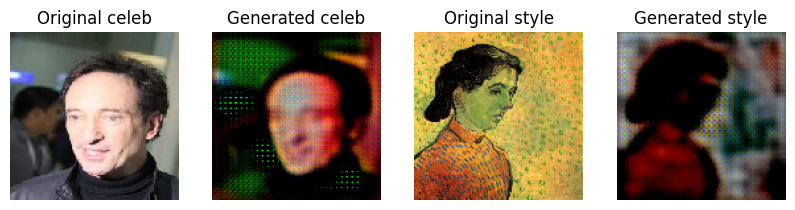

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:56,  1.68it/s]

>1, dA[0.048 ,0.143 ] dB[0.024 ,0.054] g[34.515 ,34.991]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:59,  1.66it/s]

>2, dA[0.077 ,0.064 ] dB[0.080 ,0.079] g[25.121 ,25.296]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:58,  1.66it/s]

>3, dA[0.058 ,0.024 ] dB[0.019 ,0.035] g[25.819 ,23.665]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:58,  1.66it/s]

>4, dA[0.033 ,0.022 ] dB[0.013 ,0.040] g[28.664 ,30.103]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:03<03:57,  1.66it/s]

>5, dA[0.014 ,0.021 ] dB[0.045 ,0.028] g[32.762 ,33.435]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:55,  1.67it/s]

>6, dA[0.032 ,0.046 ] dB[0.037 ,0.065] g[23.083 ,23.176]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:55,  1.67it/s]

>7, dA[0.015 ,0.017 ] dB[0.205 ,0.122] g[28.192 ,29.703]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:54,  1.67it/s]

>8, dA[0.034 ,0.031 ] dB[0.406 ,0.528] g[32.894 ,31.187]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:56,  1.65it/s]

>9, dA[0.103 ,0.097 ] dB[0.417 ,0.225] g[48.310 ,49.514]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:06<03:54,  1.66it/s]

>10, dA[0.053 ,0.031 ] dB[0.108 ,0.038] g[26.457 ,27.395]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:53,  1.67it/s]

>11, dA[0.068 ,0.040 ] dB[0.057 ,0.045] g[32.898 ,33.834]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:52,  1.67it/s]

>12, dA[0.027 ,0.038 ] dB[0.092 ,0.048] g[26.380 ,26.488]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.015 ,0.057 ] dB[0.121 ,0.240] g[31.827 ,35.097]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.058 ,0.089 ] dB[0.182 ,0.085] g[28.835 ,29.520]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.085 ,0.020 ] dB[0.071 ,0.180] g[36.607 ,41.277]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.046 ,0.020 ] dB[0.026 ,0.158] g[36.378 ,35.104]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:48,  1.67it/s]

>17, dA[0.013 ,0.021 ] dB[0.056 ,0.045] g[47.395 ,48.493]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:49,  1.67it/s]

>18, dA[0.038 ,0.015 ] dB[0.055 ,0.039] g[28.944 ,29.462]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:48,  1.67it/s]

>19, dA[0.013 ,0.019 ] dB[0.022 ,0.099] g[34.378 ,34.501]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:48,  1.66it/s]

>20, dA[0.016 ,0.022 ] dB[0.028 ,0.050] g[26.869 ,27.416]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:48,  1.66it/s]

>21, dA[0.015 ,0.019 ] dB[0.035 ,0.035] g[27.241 ,26.210]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:48,  1.65it/s]

>22, dA[0.019 ,0.011 ] dB[0.023 ,0.025] g[36.784 ,36.229]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:49,  1.64it/s]

>23, dA[0.039 ,0.040 ] dB[0.030 ,0.026] g[23.022 ,22.679]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:48,  1.65it/s]

>24, dA[0.064 ,0.050 ] dB[0.014 ,0.035] g[20.237 ,22.690]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:47,  1.65it/s]

>25, dA[0.022 ,0.038 ] dB[0.019 ,0.020] g[35.156 ,34.113]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:46,  1.65it/s]

>26, dA[0.062 ,0.058 ] dB[0.029 ,0.028] g[33.583 ,35.191]
1/1 [==============================] - 0s 22ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:47,  1.64it/s]

>27, dA[0.056 ,0.037 ] dB[0.009 ,0.038] g[35.579 ,34.101]
1/1 [==============================] - 0s 24ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:46,  1.64it/s]

>28, dA[0.103 ,0.037 ] dB[0.027 ,0.055] g[28.248 ,29.727]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:46,  1.64it/s]

>29, dA[0.151 ,0.066 ] dB[0.022 ,0.048] g[33.203 ,31.565]
1/1 [==============================] - 0s 25ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:48,  1.62it/s]

>30, dA[0.053 ,0.273 ] dB[0.158 ,0.174] g[30.031 ,32.199]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:46,  1.63it/s]

>31, dA[0.161 ,0.167 ] dB[0.114 ,0.075] g[39.825 ,41.231]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:44,  1.64it/s]

>32, dA[0.299 ,0.018 ] dB[0.108 ,0.077] g[28.963 ,33.844]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:41,  1.66it/s]

>33, dA[0.077 ,0.035 ] dB[0.073 ,0.108] g[28.733 ,27.048]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:39,  1.67it/s]

>34, dA[0.033 ,0.028 ] dB[0.297 ,0.544] g[26.997 ,29.672]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:39,  1.66it/s]

>35, dA[0.145 ,0.127 ] dB[0.107 ,0.140] g[40.183 ,41.806]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:38,  1.67it/s]

>36, dA[0.067 ,0.021 ] dB[0.119 ,0.088] g[26.953 ,29.156]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:36,  1.67it/s]

>37, dA[0.031 ,0.028 ] dB[0.072 ,0.163] g[24.368 ,22.287]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:37,  1.67it/s]

>38, dA[0.034 ,0.010 ] dB[0.037 ,0.072] g[39.467 ,39.821]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:38,  1.65it/s]

>39, dA[0.111 ,0.064 ] dB[0.071 ,0.082] g[42.797 ,45.788]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 40/400 [00:24<03:38,  1.65it/s]

>40, dA[0.133 ,0.085 ] dB[0.030 ,0.031] g[35.366 ,34.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:36,  1.66it/s]

>41, dA[0.052 ,0.046 ] dB[0.024 ,0.021] g[36.566 ,35.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:33,  1.67it/s]

>42, dA[0.034 ,0.038 ] dB[0.083 ,0.067] g[32.837 ,33.059]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.063 ,0.135 ] dB[0.096 ,0.041] g[38.201 ,36.615]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.059 ,0.093 ] dB[0.091 ,0.123] g[31.174 ,33.737]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:30,  1.69it/s]

>45, dA[0.075 ,0.075 ] dB[0.094 ,0.093] g[38.507 ,40.622]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:31,  1.67it/s]

>46, dA[0.039 ,0.032 ] dB[0.103 ,0.053] g[31.661 ,30.460]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:33,  1.65it/s]

>47, dA[0.059 ,0.070 ] dB[0.083 ,0.038] g[31.082 ,29.189]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:31,  1.66it/s]

>48, dA[0.066 ,0.096 ] dB[0.034 ,0.081] g[26.153 ,28.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.67it/s]

>49, dA[0.169 ,0.264 ] dB[0.062 ,0.043] g[26.172 ,26.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:27,  1.68it/s]

>50, dA[0.043 ,0.166 ] dB[0.051 ,0.055] g[35.444 ,34.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:27,  1.68it/s]

>51, dA[0.100 ,0.211 ] dB[0.037 ,0.040] g[26.541 ,26.105]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:26,  1.68it/s]

>52, dA[0.058 ,0.157 ] dB[0.036 ,0.046] g[35.129 ,35.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:25,  1.69it/s]

>53, dA[0.044 ,0.075 ] dB[0.035 ,0.081] g[35.992 ,37.009]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:26,  1.67it/s]

>54, dA[0.183 ,0.096 ] dB[0.052 ,0.029] g[21.225 ,23.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:25,  1.68it/s]

>55, dA[0.046 ,0.092 ] dB[0.083 ,0.064] g[36.193 ,40.185]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:24,  1.68it/s]

>56, dA[0.205 ,0.018 ] dB[0.049 ,0.039] g[28.625 ,31.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:22,  1.69it/s]

>57, dA[0.112 ,0.065 ] dB[0.042 ,0.062] g[29.582 ,32.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:21,  1.70it/s]

>58, dA[0.056 ,0.104 ] dB[0.086 ,0.061] g[24.427 ,25.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:21,  1.69it/s]

>59, dA[0.012 ,0.049 ] dB[0.129 ,0.158] g[36.049 ,37.095]
1/1 [==============================] - 0s 22ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:21,  1.68it/s]

>60, dA[0.070 ,0.052 ] dB[0.080 ,0.044] g[23.947 ,24.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.033 ,0.011 ] dB[0.051 ,0.098] g[31.931 ,33.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:20,  1.69it/s]

>62, dA[0.012 ,0.023 ] dB[0.057 ,0.223] g[32.025 ,34.359]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.018 ,0.013 ] dB[0.300 ,0.063] g[31.973 ,32.990]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.012 ,0.012 ] dB[0.046 ,0.145] g[28.335 ,31.410]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.043 ,0.068 ] dB[0.167 ,0.041] g[33.734 ,30.514]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.020 ,0.039 ] dB[0.081 ,0.113] g[29.410 ,32.685]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:18,  1.68it/s]

>67, dA[0.029 ,0.029 ] dB[0.287 ,0.076] g[22.171 ,22.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.061 ,0.079 ] dB[0.096 ,0.100] g[23.307 ,22.891]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.68it/s]

>69, dA[0.135 ,0.021 ] dB[0.123 ,0.134] g[37.379 ,40.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:15,  1.68it/s]

>70, dA[0.328 ,0.212 ] dB[0.086 ,0.026] g[39.126 ,42.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:17,  1.67it/s]

>71, dA[0.144 ,0.070 ] dB[0.035 ,0.063] g[22.407 ,24.576]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:15,  1.67it/s]

>72, dA[0.285 ,0.029 ] dB[0.044 ,0.095] g[32.192 ,32.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.273 ,0.153 ] dB[0.019 ,0.064] g[42.019 ,46.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:13,  1.69it/s]

>74, dA[0.274 ,0.158 ] dB[0.122 ,0.206] g[28.271 ,28.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:12,  1.68it/s]

>75, dA[0.149 ,0.121 ] dB[0.343 ,0.569] g[33.409 ,35.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.69it/s]

>76, dA[0.210 ,0.235 ] dB[0.313 ,0.514] g[23.367 ,24.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:11,  1.69it/s]

>77, dA[0.075 ,0.192 ] dB[0.414 ,0.049] g[38.278 ,37.997]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.090 ,0.225 ] dB[0.332 ,0.113] g[33.956 ,33.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:11,  1.68it/s]

>79, dA[0.157 ,0.182 ] dB[0.127 ,0.174] g[20.773 ,20.959]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:10,  1.68it/s]

>80, dA[0.672 ,0.592 ] dB[0.321 ,0.405] g[29.977 ,32.502]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.68it/s]

>81, dA[0.100 ,0.346 ] dB[0.086 ,0.100] g[25.643 ,28.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:49<03:08,  1.69it/s]

>82, dA[0.144 ,0.142 ] dB[0.052 ,0.042] g[35.990 ,35.847]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.123 ,0.129 ] dB[0.060 ,0.031] g[32.368 ,35.539]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 84/400 [00:50<03:07,  1.69it/s]

>84, dA[0.135 ,0.316 ] dB[0.085 ,0.050] g[27.341 ,28.294]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.200 ,0.188 ] dB[0.114 ,0.034] g[34.414 ,31.778]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.70it/s]

>86, dA[0.156 ,0.149 ] dB[0.086 ,0.096] g[35.575 ,37.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:05,  1.69it/s]

>87, dA[0.145 ,0.048 ] dB[0.150 ,0.034] g[33.693 ,34.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:04,  1.69it/s]

>88, dA[0.043 ,0.099 ] dB[0.076 ,0.036] g[29.008 ,30.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:04,  1.69it/s]

>89, dA[0.113 ,0.086 ] dB[0.053 ,0.014] g[25.918 ,25.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.076 ,0.068 ] dB[0.052 ,0.058] g[20.880 ,20.597]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:02,  1.69it/s]

>91, dA[0.055 ,0.021 ] dB[0.047 ,0.055] g[32.404 ,33.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.69it/s]

>92, dA[0.025 ,0.028 ] dB[0.049 ,0.034] g[22.020 ,23.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:01,  1.69it/s]

>93, dA[0.037 ,0.109 ] dB[0.016 ,0.010] g[38.807 ,42.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:00,  1.70it/s]

>94, dA[0.054 ,0.168 ] dB[0.018 ,0.013] g[35.092 ,35.891]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.149 ,0.334 ] dB[0.014 ,0.016] g[25.712 ,25.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<02:59,  1.69it/s]

>96, dA[0.485 ,0.275 ] dB[0.013 ,0.023] g[34.243 ,36.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:58,  1.69it/s]

>97, dA[0.169 ,0.137 ] dB[0.072 ,0.061] g[36.227 ,37.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.69it/s]

>98, dA[0.134 ,0.209 ] dB[0.036 ,0.044] g[29.867 ,32.647]
1/1 [==============================] - 0s 29ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:03,  1.64it/s]

>99, dA[0.126 ,0.068 ] dB[0.006 ,0.010] g[35.237 ,38.595]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 100/400 [00:59<03:02,  1.65it/s]

>100, dA[0.109 ,0.189 ] dB[0.024 ,0.007] g[27.264 ,27.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<03:00,  1.66it/s]

>101, dA[0.154 ,0.072 ] dB[0.044 ,0.039] g[31.215 ,31.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:58,  1.67it/s]

>102, dA[0.064 ,0.089 ] dB[0.018 ,0.050] g[27.551 ,29.858]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:57,  1.68it/s]

>103, dA[0.055 ,0.076 ] dB[0.042 ,0.012] g[25.467 ,25.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:56,  1.68it/s]

>104, dA[0.111 ,0.207 ] dB[0.031 ,0.008] g[36.461 ,39.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:57,  1.66it/s]

>105, dA[0.142 ,0.117 ] dB[0.063 ,0.045] g[29.261 ,30.160]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.67it/s]

>106, dA[0.133 ,0.067 ] dB[0.054 ,0.057] g[23.134 ,24.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:54,  1.68it/s]

>107, dA[0.101 ,0.145 ] dB[0.070 ,0.182] g[26.532 ,27.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:53,  1.68it/s]

>108, dA[0.146 ,0.108 ] dB[0.037 ,0.088] g[33.297 ,32.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.68it/s]

>109, dA[0.091 ,0.090 ] dB[0.035 ,0.068] g[29.782 ,33.590]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.125 ,0.109 ] dB[0.073 ,0.042] g[37.886 ,38.681]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.68it/s]

>111, dA[0.103 ,0.049 ] dB[0.057 ,0.087] g[30.463 ,30.960]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:51,  1.68it/s]

>112, dA[0.090 ,0.211 ] dB[0.113 ,0.053] g[33.153 ,34.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.68it/s]

>113, dA[0.358 ,0.141 ] dB[0.017 ,0.026] g[33.563 ,33.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:49,  1.68it/s]

>114, dA[0.290 ,0.140 ] dB[0.065 ,0.024] g[38.641 ,40.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.066 ,0.257 ] dB[0.080 ,0.158] g[29.291 ,28.493]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:49,  1.68it/s]

>116, dA[0.258 ,0.086 ] dB[0.145 ,0.121] g[34.139 ,34.392]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.177 ,0.334 ] dB[0.250 ,0.313] g[32.315 ,31.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.68it/s]

>118, dA[0.065 ,0.511 ] dB[0.145 ,0.310] g[38.754 ,48.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:47,  1.68it/s]

>119, dA[0.433 ,1.965 ] dB[0.100 ,0.094] g[31.484 ,31.111]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[1.297 ,0.381 ] dB[0.110 ,0.077] g[36.510 ,37.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:12<02:45,  1.68it/s]

>121, dA[0.213 ,0.178 ] dB[0.059 ,0.059] g[30.539 ,28.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.157 ,0.108 ] dB[0.015 ,0.031] g[28.462 ,27.782]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.68it/s]

>123, dA[0.115 ,0.308 ] dB[0.014 ,0.022] g[28.476 ,31.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:14<02:44,  1.68it/s]

>124, dA[0.144 ,0.369 ] dB[0.044 ,0.019] g[33.717 ,32.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.547 ,0.162 ] dB[0.059 ,0.032] g[29.954 ,31.845]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:43,  1.67it/s]

>126, dA[0.183 ,0.220 ] dB[0.080 ,0.078] g[25.883 ,26.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:43,  1.67it/s]

>127, dA[0.085 ,0.164 ] dB[0.033 ,0.008] g[22.640 ,23.402]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:43,  1.66it/s]

>128, dA[0.044 ,0.130 ] dB[0.048 ,0.073] g[23.604 ,27.434]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:42,  1.67it/s]

>129, dA[0.031 ,0.092 ] dB[0.007 ,0.059] g[31.800 ,32.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:41,  1.67it/s]

>130, dA[0.053 ,0.038 ] dB[0.038 ,0.010] g[29.672 ,28.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:41,  1.67it/s]

>131, dA[0.065 ,0.030 ] dB[0.027 ,0.010] g[28.003 ,29.544]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:40,  1.67it/s]

>132, dA[0.090 ,0.043 ] dB[0.027 ,0.073] g[25.533 ,23.524]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:40,  1.67it/s]

>133, dA[0.022 ,0.021 ] dB[0.030 ,0.043] g[19.984 ,19.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:39,  1.67it/s]

>134, dA[0.210 ,0.367 ] dB[0.021 ,0.025] g[19.319 ,20.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:39,  1.66it/s]

>135, dA[0.063 ,0.095 ] dB[0.010 ,0.016] g[34.652 ,33.484]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:38,  1.67it/s]

>136, dA[0.040 ,0.059 ] dB[0.009 ,0.011] g[30.886 ,32.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:37,  1.67it/s]

>137, dA[0.041 ,0.022 ] dB[0.075 ,0.117] g[28.822 ,31.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:38,  1.66it/s]

>138, dA[0.043 ,0.066 ] dB[0.155 ,0.093] g[35.458 ,37.686]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:37,  1.65it/s]

>139, dA[0.056 ,0.103 ] dB[0.195 ,0.227] g[29.428 ,31.254]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:37,  1.66it/s]

>140, dA[0.046 ,0.084 ] dB[0.043 ,0.175] g[33.760 ,37.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:35,  1.66it/s]

>141, dA[0.179 ,0.125 ] dB[0.076 ,0.059] g[25.091 ,24.292]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:34,  1.67it/s]

>142, dA[0.136 ,0.075 ] dB[0.016 ,0.071] g[29.417 ,31.180]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:34,  1.67it/s]

>143, dA[0.054 ,0.074 ] dB[0.046 ,0.021] g[23.057 ,22.571]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:33,  1.67it/s]

>144, dA[0.052 ,0.011 ] dB[0.025 ,0.046] g[42.149 ,43.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:32,  1.68it/s]

>145, dA[0.050 ,0.031 ] dB[0.061 ,0.043] g[30.176 ,28.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:31,  1.68it/s]

>146, dA[0.020 ,0.028 ] dB[0.031 ,0.043] g[28.968 ,29.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:31,  1.67it/s]

>147, dA[0.019 ,0.015 ] dB[0.030 ,0.049] g[37.844 ,37.475]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:31,  1.66it/s]

>148, dA[0.043 ,0.053 ] dB[0.058 ,0.094] g[35.150 ,36.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:31,  1.66it/s]

>149, dA[0.071 ,0.037 ] dB[0.120 ,0.258] g[34.960 ,39.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:39,  1.57it/s]

>150, dA[0.042 ,0.027 ] dB[0.067 ,0.107] g[29.733 ,29.872]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:38,  1.57it/s]

>151, dA[0.039 ,0.022 ] dB[0.152 ,0.053] g[26.770 ,26.204]
1/1 [==============================] - 0s 22ms/step



Batchs:  38%|███▊      | 152/400 [01:31<02:34,  1.60it/s]

>152, dA[0.018 ,0.066 ] dB[0.053 ,0.024] g[26.819 ,26.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:31,  1.63it/s]

>153, dA[0.107 ,0.049 ] dB[0.109 ,0.059] g[23.687 ,23.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:30,  1.64it/s]

>154, dA[0.115 ,0.054 ] dB[0.203 ,0.033] g[28.375 ,28.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:29,  1.64it/s]

>155, dA[0.018 ,0.021 ] dB[0.104 ,0.111] g[36.030 ,37.172]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:27,  1.65it/s]

>156, dA[0.020 ,0.041 ] dB[0.031 ,0.030] g[34.233 ,35.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:34<02:25,  1.67it/s]

>157, dA[0.027 ,0.027 ] dB[0.084 ,0.044] g[28.209 ,28.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.67it/s]

>158, dA[0.052 ,0.048 ] dB[0.055 ,0.023] g[24.870 ,22.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:24,  1.67it/s]

>159, dA[0.030 ,0.018 ] dB[0.056 ,0.052] g[27.310 ,27.844]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 160/400 [01:35<02:23,  1.67it/s]

>160, dA[0.062 ,0.091 ] dB[0.030 ,0.081] g[29.406 ,29.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:23,  1.67it/s]

>161, dA[0.041 ,0.049 ] dB[0.100 ,0.063] g[33.338 ,30.241]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:37<02:21,  1.68it/s]

>162, dA[0.057 ,0.067 ] dB[0.098 ,0.038] g[31.265 ,30.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:21,  1.67it/s]

>163, dA[0.060 ,0.067 ] dB[0.018 ,0.058] g[36.030 ,37.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:38<02:21,  1.67it/s]

>164, dA[0.025 ,0.019 ] dB[0.036 ,0.020] g[25.729 ,28.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.68it/s]

>165, dA[0.020 ,0.024 ] dB[0.026 ,0.010] g[20.298 ,20.058]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.025 ,0.042 ] dB[0.026 ,0.014] g[33.467 ,34.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.066 ,0.192 ] dB[0.034 ,0.029] g[28.980 ,28.247]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.077 ,0.136 ] dB[0.014 ,0.023] g[33.785 ,37.356]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.68it/s]

>169, dA[0.147 ,0.126 ] dB[0.023 ,0.016] g[29.057 ,28.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:16,  1.68it/s]

>170, dA[0.035 ,0.067 ] dB[0.042 ,0.028] g[32.140 ,33.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.68it/s]

>171, dA[0.022 ,0.031 ] dB[0.030 ,0.009] g[31.934 ,31.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.68it/s]

>172, dA[0.043 ,0.035 ] dB[0.014 ,0.025] g[33.657 ,32.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:14,  1.68it/s]

>173, dA[0.072 ,0.050 ] dB[0.016 ,0.016] g[41.731 ,45.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:14,  1.68it/s]

>174, dA[0.154 ,0.063 ] dB[0.031 ,0.020] g[32.525 ,31.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:13,  1.68it/s]

>175, dA[0.073 ,0.118 ] dB[0.016 ,0.041] g[28.026 ,26.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:13,  1.68it/s]

>176, dA[0.067 ,0.178 ] dB[0.036 ,0.044] g[31.332 ,34.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.68it/s]

>177, dA[0.090 ,0.052 ] dB[0.033 ,0.014] g[39.926 ,42.592]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:12,  1.68it/s]

>178, dA[0.052 ,0.094 ] dB[0.028 ,0.033] g[29.318 ,29.086]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:12,  1.67it/s]

>179, dA[0.068 ,0.049 ] dB[0.018 ,0.011] g[20.620 ,20.435]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:12,  1.67it/s]

>180, dA[0.024 ,0.021 ] dB[0.034 ,0.023] g[36.175 ,35.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:10,  1.67it/s]

>181, dA[0.041 ,0.033 ] dB[0.056 ,0.012] g[28.851 ,29.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.68it/s]

>182, dA[0.049 ,0.038 ] dB[0.042 ,0.064] g[31.241 ,33.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.68it/s]

>183, dA[0.048 ,0.027 ] dB[0.039 ,0.074] g[38.895 ,42.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:08,  1.68it/s]

>184, dA[0.137 ,0.039 ] dB[0.075 ,0.090] g[26.702 ,28.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.68it/s]

>185, dA[0.117 ,0.038 ] dB[0.040 ,0.196] g[21.722 ,21.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:07,  1.68it/s]

>186, dA[0.071 ,0.033 ] dB[0.042 ,0.104] g[39.031 ,42.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:06,  1.68it/s]

>187, dA[0.093 ,0.019 ] dB[0.080 ,0.116] g[38.624 ,40.755]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.182 ,0.045 ] dB[0.298 ,0.110] g[30.678 ,29.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:05,  1.68it/s]

>189, dA[0.083 ,0.042 ] dB[0.255 ,0.123] g[31.790 ,33.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.69it/s]

>190, dA[0.039 ,0.039 ] dB[0.081 ,0.099] g[22.510 ,24.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:03,  1.69it/s]

>191, dA[0.032 ,0.018 ] dB[0.026 ,0.057] g[29.101 ,33.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.69it/s]

>192, dA[0.019 ,0.026 ] dB[0.036 ,0.032] g[34.004 ,38.712]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:02,  1.69it/s]

>193, dA[0.036 ,0.018 ] dB[0.028 ,0.025] g[22.378 ,22.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:01,  1.70it/s]

>194, dA[0.093 ,0.078 ] dB[0.016 ,0.016] g[29.923 ,29.911]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:01,  1.69it/s]

>195, dA[0.074 ,0.019 ] dB[0.021 ,0.006] g[24.461 ,24.140]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:00,  1.69it/s]

>196, dA[0.038 ,0.031 ] dB[0.011 ,0.022] g[25.070 ,26.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<01:59,  1.69it/s]

>197, dA[0.060 ,0.023 ] dB[0.014 ,0.054] g[38.410 ,40.925]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<01:59,  1.70it/s]

>198, dA[0.027 ,0.068 ] dB[0.024 ,0.069] g[33.699 ,34.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:58,  1.69it/s]

>199, dA[0.040 ,0.048 ] dB[0.072 ,0.025] g[39.984 ,43.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.69it/s]

>200, dA[0.054 ,0.013 ] dB[0.049 ,0.063] g[28.471 ,24.787]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:57,  1.70it/s]

>201, dA[0.046 ,0.016 ] dB[0.017 ,0.083] g[28.296 ,29.426]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:56,  1.70it/s]

>202, dA[0.033 ,0.024 ] dB[0.034 ,0.076] g[27.174 ,28.149]
1/1 [==============================] - 0s 27ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.67it/s]

>203, dA[0.046 ,0.025 ] dB[0.058 ,0.016] g[28.516 ,30.746]
1/1 [==============================] - 0s 23ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:58,  1.66it/s]

>204, dA[0.137 ,0.145 ] dB[0.068 ,0.066] g[36.561 ,35.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.67it/s]

>205, dA[0.076 ,0.053 ] dB[0.031 ,0.029] g[33.492 ,32.885]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.68it/s]

>206, dA[0.023 ,0.166 ] dB[0.023 ,0.025] g[23.984 ,24.829]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.088 ,0.033 ] dB[0.069 ,0.120] g[23.008 ,23.373]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:53,  1.69it/s]

>208, dA[0.038 ,0.061 ] dB[0.012 ,0.045] g[24.819 ,23.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:52,  1.69it/s]

>209, dA[0.019 ,0.019 ] dB[0.052 ,0.053] g[32.958 ,36.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:52,  1.70it/s]

>210, dA[0.031 ,0.015 ] dB[0.041 ,0.068] g[26.932 ,27.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:51,  1.69it/s]

>211, dA[0.012 ,0.011 ] dB[0.031 ,0.041] g[25.584 ,25.339]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:50,  1.70it/s]

>212, dA[0.030 ,0.019 ] dB[0.021 ,0.060] g[22.595 ,23.458]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:50,  1.70it/s]

>213, dA[0.010 ,0.017 ] dB[0.026 ,0.017] g[25.645 ,28.699]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:49,  1.70it/s]

>214, dA[0.013 ,0.027 ] dB[0.038 ,0.033] g[37.480 ,41.071]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.70it/s]

>215, dA[0.029 ,0.014 ] dB[0.034 ,0.037] g[31.131 ,31.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:48,  1.70it/s]

>216, dA[0.037 ,0.011 ] dB[0.010 ,0.015] g[27.751 ,27.858]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:47,  1.70it/s]

>217, dA[0.034 ,0.037 ] dB[0.006 ,0.006] g[37.970 ,38.463]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:46,  1.70it/s]

>218, dA[0.019 ,0.009 ] dB[0.028 ,0.058] g[25.190 ,27.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:46,  1.69it/s]

>219, dA[0.010 ,0.006 ] dB[0.008 ,0.040] g[34.611 ,36.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.017 ,0.022 ] dB[0.043 ,0.007] g[34.832 ,38.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:45,  1.69it/s]

>221, dA[0.052 ,0.023 ] dB[0.060 ,0.076] g[31.795 ,33.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.69it/s]

>222, dA[0.025 ,0.015 ] dB[0.065 ,0.031] g[26.678 ,26.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:44,  1.69it/s]

>223, dA[0.023 ,0.020 ] dB[0.028 ,0.015] g[35.773 ,37.879]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:44,  1.69it/s]

>224, dA[0.034 ,0.020 ] dB[0.011 ,0.020] g[34.186 ,36.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:43,  1.69it/s]

>225, dA[0.059 ,0.015 ] dB[0.014 ,0.015] g[26.729 ,26.840]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:42,  1.69it/s]

>226, dA[0.038 ,0.024 ] dB[0.007 ,0.026] g[25.118 ,24.034]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:42,  1.69it/s]

>227, dA[0.017 ,0.023 ] dB[0.008 ,0.015] g[28.131 ,32.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:41,  1.69it/s]

>228, dA[0.024 ,0.011 ] dB[0.017 ,0.049] g[42.260 ,41.417]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:40,  1.70it/s]

>229, dA[0.019 ,0.021 ] dB[0.027 ,0.062] g[18.527 ,21.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:40,  1.69it/s]

>230, dA[0.025 ,0.011 ] dB[0.050 ,0.027] g[41.772 ,44.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.047 ,0.013 ] dB[0.028 ,0.035] g[32.625 ,33.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.69it/s]

>232, dA[0.127 ,0.157 ] dB[0.032 ,0.068] g[27.028 ,31.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:38,  1.69it/s]

>233, dA[0.036 ,0.064 ] dB[0.045 ,0.103] g[26.732 ,29.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.69it/s]

>234, dA[0.048 ,0.046 ] dB[0.062 ,0.072] g[26.594 ,29.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:37,  1.69it/s]

>235, dA[0.062 ,0.038 ] dB[0.034 ,0.029] g[33.127 ,34.323]
1/1 [==============================] - 0s 23ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.018 ,0.016 ] dB[0.014 ,0.042] g[30.946 ,32.957]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:36,  1.69it/s]

>237, dA[0.034 ,0.023 ] dB[0.094 ,0.048] g[22.579 ,21.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:35,  1.69it/s]

>238, dA[0.016 ,0.025 ] dB[0.093 ,0.124] g[33.196 ,34.640]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:36,  1.68it/s]

>239, dA[0.021 ,0.012 ] dB[0.085 ,0.175] g[29.068 ,31.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.68it/s]

>240, dA[0.012 ,0.040 ] dB[0.087 ,0.082] g[36.056 ,36.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.69it/s]

>241, dA[0.027 ,0.034 ] dB[0.106 ,0.079] g[26.488 ,28.582]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.69it/s]

>242, dA[0.021 ,0.027 ] dB[0.243 ,0.072] g[28.544 ,29.501]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:32,  1.69it/s]

>243, dA[0.014 ,0.011 ] dB[0.063 ,0.081] g[34.791 ,39.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.69it/s]

>244, dA[0.026 ,0.037 ] dB[0.029 ,0.033] g[27.687 ,30.986]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:31,  1.69it/s]

>245, dA[0.050 ,0.031 ] dB[0.048 ,0.033] g[27.977 ,27.783]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:30,  1.70it/s]

>246, dA[0.083 ,0.112 ] dB[0.083 ,0.076] g[20.668 ,21.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:30,  1.69it/s]

>247, dA[0.028 ,0.100 ] dB[0.081 ,0.041] g[36.843 ,40.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:29,  1.69it/s]

>248, dA[0.039 ,0.094 ] dB[0.290 ,0.322] g[25.315 ,25.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.70it/s]

>249, dA[0.189 ,0.086 ] dB[0.319 ,0.739] g[26.406 ,31.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:28,  1.70it/s]

>250, dA[0.056 ,0.067 ] dB[0.112 ,0.324] g[40.107 ,41.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:27,  1.70it/s]

>251, dA[0.046 ,0.140 ] dB[0.158 ,0.119] g[31.354 ,30.215]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:27,  1.70it/s]

>252, dA[0.029 ,0.070 ] dB[0.166 ,0.299] g[33.358 ,34.918]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:26,  1.70it/s]

>253, dA[0.078 ,0.137 ] dB[0.293 ,0.230] g[36.768 ,36.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:25,  1.70it/s]

>254, dA[0.133 ,0.033 ] dB[0.319 ,0.118] g[22.158 ,24.813]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:25,  1.69it/s]

>255, dA[0.114 ,0.023 ] dB[0.404 ,0.426] g[43.010 ,43.808]
1/1 [==============================] - 0s 40ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:28,  1.62it/s]

>256, dA[0.033 ,0.052 ] dB[0.451 ,0.290] g[32.143 ,32.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:27,  1.63it/s]

>257, dA[0.035 ,0.013 ] dB[0.197 ,0.578] g[25.977 ,26.539]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:26,  1.65it/s]

>258, dA[0.050 ,0.036 ] dB[0.177 ,0.626] g[26.637 ,28.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:25,  1.66it/s]

>259, dA[0.034 ,0.020 ] dB[0.376 ,0.180] g[29.759 ,30.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.67it/s]

>260, dA[0.023 ,0.026 ] dB[0.355 ,0.138] g[28.295 ,28.495]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.037 ,0.021 ] dB[0.165 ,0.135] g[32.825 ,33.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.68it/s]

>262, dA[0.045 ,0.072 ] dB[0.103 ,0.116] g[40.437 ,39.054]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.68it/s]

>263, dA[0.020 ,0.056 ] dB[0.026 ,0.134] g[22.513 ,23.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:20,  1.69it/s]

>264, dA[0.078 ,0.034 ] dB[0.076 ,0.087] g[38.997 ,38.186]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:19,  1.70it/s]

>265, dA[0.029 ,0.033 ] dB[0.021 ,0.053] g[28.414 ,28.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:18,  1.70it/s]

>266, dA[0.072 ,0.039 ] dB[0.013 ,0.029] g[28.419 ,28.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:18,  1.69it/s]

>267, dA[0.052 ,0.012 ] dB[0.093 ,0.137] g[19.906 ,24.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:17,  1.69it/s]

>268, dA[0.017 ,0.017 ] dB[0.077 ,0.126] g[38.069 ,39.520]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.68it/s]

>269, dA[0.010 ,0.013 ] dB[0.101 ,0.101] g[32.021 ,34.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.68it/s]

>270, dA[0.016 ,0.026 ] dB[0.065 ,0.043] g[21.315 ,21.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.68it/s]

>271, dA[0.015 ,0.013 ] dB[0.026 ,0.046] g[29.626 ,30.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.67it/s]

>272, dA[0.020 ,0.010 ] dB[0.029 ,0.010] g[18.519 ,19.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.68it/s]

>273, dA[0.011 ,0.031 ] dB[0.011 ,0.014] g[29.521 ,30.731]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.037 ,0.086 ] dB[0.021 ,0.014] g[28.338 ,28.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.69it/s]

>275, dA[0.052 ,0.040 ] dB[0.032 ,0.023] g[36.363 ,36.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.69it/s]

>276, dA[0.080 ,0.077 ] dB[0.029 ,0.016] g[26.420 ,25.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:12,  1.70it/s]

>277, dA[0.101 ,0.246 ] dB[0.016 ,0.012] g[21.075 ,23.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:11,  1.70it/s]

>278, dA[0.112 ,0.154 ] dB[0.016 ,0.036] g[24.871 ,25.664]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.70it/s]

>279, dA[0.099 ,0.105 ] dB[0.072 ,0.015] g[33.468 ,33.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:10,  1.70it/s]

>280, dA[0.090 ,0.057 ] dB[0.044 ,0.079] g[30.120 ,28.496]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.69it/s]

>281, dA[0.084 ,0.073 ] dB[0.038 ,0.081] g[28.019 ,28.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:09,  1.70it/s]

>282, dA[0.073 ,0.058 ] dB[0.071 ,0.040] g[33.057 ,33.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.69it/s]

>283, dA[0.097 ,0.078 ] dB[0.105 ,0.037] g[34.563 ,34.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:08,  1.70it/s]

>284, dA[0.146 ,0.109 ] dB[0.063 ,0.027] g[24.038 ,23.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:07,  1.70it/s]

>285, dA[0.314 ,0.329 ] dB[0.020 ,0.031] g[25.766 ,25.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:06,  1.70it/s]

>286, dA[0.206 ,0.606 ] dB[0.015 ,0.025] g[41.573 ,45.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:06,  1.69it/s]

>287, dA[0.365 ,0.157 ] dB[0.023 ,0.023] g[20.760 ,23.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.70it/s]

>288, dA[0.137 ,0.078 ] dB[0.023 ,0.018] g[25.082 ,24.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:05,  1.70it/s]

>289, dA[0.229 ,0.068 ] dB[0.019 ,0.011] g[32.692 ,34.832]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:04,  1.70it/s]

>290, dA[0.145 ,0.037 ] dB[0.077 ,0.050] g[38.283 ,36.957]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.70it/s]

>291, dA[0.130 ,0.083 ] dB[0.026 ,0.103] g[19.018 ,18.932]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:03,  1.69it/s]

>292, dA[0.108 ,0.147 ] dB[0.045 ,0.078] g[21.142 ,20.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.70it/s]

>293, dA[0.087 ,0.069 ] dB[0.049 ,0.016] g[34.029 ,38.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:02,  1.70it/s]

>294, dA[0.188 ,0.092 ] dB[0.030 ,0.050] g[31.039 ,33.252]
1/1 [==============================] - 0s 19ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.194 ,0.153 ] dB[0.023 ,0.040] g[21.007 ,21.926]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.69it/s]

>296, dA[0.050 ,0.285 ] dB[0.045 ,0.041] g[24.104 ,25.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:00,  1.69it/s]

>297, dA[0.486 ,0.110 ] dB[0.068 ,0.022] g[37.706 ,41.609]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.69it/s]

>298, dA[0.190 ,0.182 ] dB[0.035 ,0.019] g[36.121 ,36.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<00:59,  1.69it/s]

>299, dA[0.110 ,0.061 ] dB[0.030 ,0.014] g[40.290 ,42.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.69it/s]

>300, dA[0.054 ,0.047 ] dB[0.047 ,0.019] g[24.794 ,24.299]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.70it/s]

>301, dA[0.037 ,0.036 ] dB[0.019 ,0.020] g[26.920 ,26.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:57,  1.70it/s]

>302, dA[0.027 ,0.030 ] dB[0.011 ,0.016] g[33.527 ,35.075]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.69it/s]

>303, dA[0.068 ,0.048 ] dB[0.011 ,0.019] g[32.474 ,32.450]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:56,  1.69it/s]

>304, dA[0.040 ,0.016 ] dB[0.035 ,0.077] g[20.525 ,21.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:55,  1.70it/s]

>305, dA[0.036 ,0.020 ] dB[0.103 ,0.100] g[26.896 ,28.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.70it/s]

>306, dA[0.057 ,0.008 ] dB[0.057 ,0.015] g[24.918 ,25.326]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:54,  1.69it/s]

>307, dA[0.033 ,0.019 ] dB[0.016 ,0.031] g[28.218 ,29.990]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.67it/s]

>308, dA[0.048 ,0.064 ] dB[0.017 ,0.036] g[26.759 ,25.423]
1/1 [==============================] - 0s 32ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.66it/s]

>309, dA[0.031 ,0.084 ] dB[0.043 ,0.045] g[28.481 ,29.630]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.67it/s]

>310, dA[0.081 ,0.045 ] dB[0.039 ,0.031] g[40.079 ,41.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.67it/s]

>311, dA[0.034 ,0.033 ] dB[0.010 ,0.016] g[29.073 ,30.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.68it/s]

>312, dA[0.044 ,0.034 ] dB[0.013 ,0.020] g[26.137 ,26.130]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.69it/s]

>313, dA[0.033 ,0.033 ] dB[0.036 ,0.023] g[35.740 ,36.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:50,  1.69it/s]

>314, dA[0.013 ,0.044 ] dB[0.033 ,0.026] g[30.233 ,31.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.69it/s]

>315, dA[0.038 ,0.032 ] dB[0.054 ,0.023] g[22.344 ,24.509]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:49,  1.69it/s]

>316, dA[0.021 ,0.014 ] dB[0.056 ,0.015] g[24.635 ,23.437]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:48,  1.70it/s]

>317, dA[0.016 ,0.013 ] dB[0.022 ,0.015] g[37.372 ,38.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.70it/s]

>318, dA[0.041 ,0.046 ] dB[0.024 ,0.019] g[26.366 ,25.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:47,  1.70it/s]

>319, dA[0.022 ,0.026 ] dB[0.012 ,0.013] g[25.053 ,24.873]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.70it/s]

>320, dA[0.073 ,0.106 ] dB[0.014 ,0.016] g[26.703 ,28.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.043 ,0.074 ] dB[0.007 ,0.018] g[23.303 ,23.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.69it/s]

>322, dA[0.040 ,0.059 ] dB[0.022 ,0.005] g[33.209 ,30.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.68it/s]

>323, dA[0.030 ,0.012 ] dB[0.018 ,0.015] g[19.054 ,19.834]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.69it/s]

>324, dA[0.033 ,0.012 ] dB[0.018 ,0.041] g[25.569 ,26.046]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.021 ,0.017 ] dB[0.033 ,0.035] g[25.279 ,27.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.70it/s]

>326, dA[0.048 ,0.054 ] dB[0.012 ,0.011] g[34.008 ,34.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.69it/s]

>327, dA[0.014 ,0.033 ] dB[0.010 ,0.036] g[25.810 ,23.142]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.69it/s]

>328, dA[0.015 ,0.048 ] dB[0.020 ,0.013] g[22.879 ,21.065]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:41,  1.70it/s]

>329, dA[0.081 ,0.039 ] dB[0.060 ,0.026] g[20.720 ,22.879]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.70it/s]

>330, dA[0.063 ,0.050 ] dB[0.028 ,0.083] g[27.532 ,27.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:40,  1.69it/s]

>331, dA[0.043 ,0.045 ] dB[0.033 ,0.037] g[29.407 ,31.494]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.69it/s]

>332, dA[0.031 ,0.032 ] dB[0.041 ,0.025] g[28.761 ,30.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.70it/s]

>333, dA[0.020 ,0.027 ] dB[0.013 ,0.013] g[31.067 ,29.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:38,  1.70it/s]

>334, dA[0.018 ,0.015 ] dB[0.008 ,0.006] g[24.229 ,23.975]
1/1 [==============================] - 0s 19ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.70it/s]

>335, dA[0.020 ,0.013 ] dB[0.011 ,0.010] g[27.397 ,30.717]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:37,  1.70it/s]

>336, dA[0.015 ,0.012 ] dB[0.009 ,0.012] g[29.710 ,29.461]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.68it/s]

>337, dA[0.014 ,0.018 ] dB[0.030 ,0.004] g[29.729 ,27.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.69it/s]

>338, dA[0.010 ,0.020 ] dB[0.017 ,0.016] g[34.786 ,34.355]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.69it/s]

>339, dA[0.022 ,0.028 ] dB[0.012 ,0.004] g[25.593 ,26.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.67it/s]

>340, dA[0.024 ,0.034 ] dB[0.027 ,0.014] g[44.358 ,47.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.68it/s]

>341, dA[0.077 ,0.026 ] dB[0.021 ,0.005] g[23.109 ,22.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.106 ,0.056 ] dB[0.036 ,0.039] g[20.847 ,21.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.69it/s]

>343, dA[0.090 ,0.105 ] dB[0.029 ,0.030] g[37.063 ,39.400]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.028 ,0.112 ] dB[0.015 ,0.016] g[29.017 ,30.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.69it/s]

>345, dA[0.039 ,0.041 ] dB[0.078 ,0.055] g[33.890 ,34.358]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:31,  1.70it/s]

>346, dA[0.051 ,0.013 ] dB[0.072 ,0.035] g[26.678 ,27.068]
1/1 [==============================] - 0s 19ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.70it/s]

>347, dA[0.020 ,0.030 ] dB[0.056 ,0.051] g[33.469 ,36.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.70it/s]

>348, dA[0.034 ,0.035 ] dB[0.099 ,0.136] g[23.392 ,23.869]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:29,  1.70it/s]

>349, dA[0.045 ,0.030 ] dB[0.129 ,0.114] g[25.938 ,24.685]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.71it/s]

>350, dA[0.186 ,0.112 ] dB[0.044 ,0.021] g[26.114 ,24.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:28,  1.70it/s]

>351, dA[0.343 ,0.117 ] dB[0.038 ,0.028] g[31.908 ,34.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.70it/s]

>352, dA[0.341 ,0.140 ] dB[0.058 ,0.073] g[29.221 ,27.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:27,  1.70it/s]

>353, dA[0.214 ,0.247 ] dB[0.053 ,0.028] g[28.808 ,28.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:28,  1.61it/s]

>354, dA[0.235 ,0.220 ] dB[0.063 ,0.017] g[28.856 ,29.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:27,  1.63it/s]

>355, dA[0.170 ,0.129 ] dB[0.040 ,0.029] g[24.291 ,24.299]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.64it/s]

>356, dA[0.180 ,0.164 ] dB[0.021 ,0.028] g[33.031 ,32.533]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.66it/s]

>357, dA[0.064 ,0.085 ] dB[0.015 ,0.022] g[34.002 ,33.282]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:25,  1.67it/s]

>358, dA[0.026 ,0.017 ] dB[0.024 ,0.015] g[22.795 ,24.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.67it/s]

>359, dA[0.045 ,0.020 ] dB[0.028 ,0.031] g[32.610 ,33.503]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.68it/s]

>360, dA[0.050 ,0.050 ] dB[0.044 ,0.018] g[35.859 ,36.569]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.66it/s]

>361, dA[0.048 ,0.035 ] dB[0.015 ,0.020] g[29.980 ,28.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.67it/s]

>362, dA[0.051 ,0.028 ] dB[0.007 ,0.018] g[26.721 ,26.635]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.67it/s]

>363, dA[0.039 ,0.157 ] dB[0.012 ,0.030] g[40.048 ,43.724]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.68it/s]

>364, dA[0.109 ,0.042 ] dB[0.015 ,0.045] g[32.740 ,34.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.68it/s]

>365, dA[0.071 ,0.031 ] dB[0.026 ,0.064] g[41.809 ,46.684]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.69it/s]

>366, dA[0.085 ,0.012 ] dB[0.055 ,0.047] g[25.824 ,24.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.69it/s]

>367, dA[0.033 ,0.025 ] dB[0.050 ,0.032] g[41.029 ,43.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:18,  1.69it/s]

>368, dA[0.055 ,0.083 ] dB[0.065 ,0.031] g[24.763 ,24.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.70it/s]

>369, dA[0.176 ,0.054 ] dB[0.082 ,0.084] g[22.565 ,24.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.70it/s]

>370, dA[0.218 ,0.035 ] dB[0.091 ,0.167] g[34.313 ,35.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.69it/s]

>371, dA[0.062 ,0.088 ] dB[0.026 ,0.066] g[29.958 ,29.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.69it/s]

>372, dA[0.095 ,0.042 ] dB[0.029 ,0.036] g[26.145 ,25.059]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.69it/s]

>373, dA[0.093 ,0.032 ] dB[0.012 ,0.025] g[27.740 ,29.838]
1/1 [==============================] - 0s 27ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.68it/s]

>374, dA[0.053 ,0.040 ] dB[0.012 ,0.009] g[34.965 ,36.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.68it/s]

>375, dA[0.032 ,0.021 ] dB[0.011 ,0.013] g[33.400 ,35.816]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.68it/s]

>376, dA[0.044 ,0.043 ] dB[0.024 ,0.058] g[22.226 ,21.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.69it/s]

>377, dA[0.037 ,0.027 ] dB[0.050 ,0.025] g[23.202 ,23.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.69it/s]

>378, dA[0.031 ,0.047 ] dB[0.055 ,0.023] g[24.180 ,26.643]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.69it/s]

>379, dA[0.031 ,0.041 ] dB[0.033 ,0.053] g[29.362 ,26.701]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.69it/s]

>380, dA[0.059 ,0.041 ] dB[0.059 ,0.057] g[29.900 ,27.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.69it/s]

>381, dA[0.119 ,0.043 ] dB[0.087 ,0.028] g[31.700 ,33.095]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.69it/s]

>382, dA[0.074 ,0.018 ] dB[0.020 ,0.009] g[26.726 ,29.195]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.68it/s]

>383, dA[0.055 ,0.042 ] dB[0.028 ,0.019] g[34.048 ,33.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.68it/s]

>384, dA[0.019 ,0.027 ] dB[0.017 ,0.007] g[33.510 ,33.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.69it/s]

>385, dA[0.031 ,0.020 ] dB[0.016 ,0.033] g[27.730 ,28.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.69it/s]

>386, dA[0.031 ,0.033 ] dB[0.056 ,0.025] g[31.156 ,30.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.015 ,0.019 ] dB[0.037 ,0.030] g[28.147 ,28.011]
1/1 [==============================] - 0s 25ms/step



Batchs:  97%|█████████▋| 388/400 [03:50<00:07,  1.67it/s]

>388, dA[0.014 ,0.024 ] dB[0.030 ,0.040] g[32.114 ,32.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.67it/s]

>389, dA[0.031 ,0.037 ] dB[0.038 ,0.025] g[38.083 ,38.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.67it/s]

>390, dA[0.064 ,0.013 ] dB[0.055 ,0.073] g[30.004 ,33.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.66it/s]

>391, dA[0.056 ,0.006 ] dB[0.059 ,0.033] g[28.343 ,28.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.67it/s]

>392, dA[0.034 ,0.017 ] dB[0.051 ,0.038] g[30.457 ,28.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.67it/s]

>393, dA[0.014 ,0.010 ] dB[0.039 ,0.035] g[30.414 ,31.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.68it/s]

>394, dA[0.018 ,0.013 ] dB[0.116 ,0.115] g[32.693 ,31.884]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.68it/s]

>395, dA[0.023 ,0.011 ] dB[0.036 ,0.025] g[42.124 ,44.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.68it/s]

>396, dA[0.034 ,0.023 ] dB[0.045 ,0.047] g[41.778 ,45.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.68it/s]

>397, dA[0.029 ,0.019 ] dB[0.041 ,0.057] g[26.220 ,27.709]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.68it/s]

>398, dA[0.016 ,0.018 ] dB[0.032 ,0.026] g[37.943 ,39.677]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.68it/s]

>399, dA[0.054 ,0.020 ] dB[0.012 ,0.050] g[22.650 ,21.491]
1/1 [==============================] - 0s 21ms/step



Epochs:  20%|██        | 2/10 [09:18<36:16, 272.11s/it]

>400, dA[0.050 ,0.018 ] dB[0.069 ,0.046] g[25.920 ,27.650]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:54,  1.70it/s]

>1, dA[0.078 ,0.032 ] dB[0.029 ,0.036] g[36.616 ,41.163]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:54,  1.70it/s]

>2, dA[0.169 ,0.057 ] dB[0.072 ,0.014] g[28.338 ,27.464]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.69it/s]

>3, dA[0.075 ,0.025 ] dB[0.045 ,0.015] g[32.404 ,32.963]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.029 ,0.023 ] dB[0.013 ,0.029] g[26.092 ,24.405]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.026 ,0.098 ] dB[0.033 ,0.011] g[32.437 ,35.743]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.69it/s]

>6, dA[0.030 ,0.134 ] dB[0.081 ,0.103] g[21.827 ,21.345]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.060 ,0.128 ] dB[0.058 ,0.070] g[33.505 ,37.985]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.68it/s]

>8, dA[0.052 ,0.084 ] dB[0.096 ,0.051] g[27.590 ,28.316]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:51,  1.69it/s]

>9, dA[0.108 ,0.031 ] dB[0.047 ,0.017] g[25.416 ,26.601]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:50,  1.69it/s]

>10, dA[0.041 ,0.019 ] dB[0.013 ,0.012] g[20.055 ,19.882]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.69it/s]

>11, dA[0.034 ,0.025 ] dB[0.017 ,0.012] g[37.257 ,40.355]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.016 ,0.009 ] dB[0.060 ,0.039] g[24.001 ,26.307]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.023 ,0.019 ] dB[0.064 ,0.042] g[31.197 ,31.810]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.67it/s]

>14, dA[0.022 ,0.007 ] dB[0.098 ,0.058] g[31.851 ,34.252]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:50,  1.67it/s]

>15, dA[0.023 ,0.021 ] dB[0.078 ,0.032] g[31.015 ,32.469]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:49,  1.67it/s]

>16, dA[0.033 ,0.023 ] dB[0.166 ,0.275] g[35.113 ,36.520]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:48,  1.68it/s]

>17, dA[0.038 ,0.013 ] dB[0.344 ,0.141] g[46.644 ,46.432]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:47,  1.68it/s]

>18, dA[0.014 ,0.020 ] dB[0.027 ,0.052] g[26.689 ,28.721]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.015 ,0.060 ] dB[0.180 ,0.093] g[35.767 ,38.510]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.68it/s]

>20, dA[0.021 ,0.036 ] dB[0.129 ,0.035] g[25.017 ,25.389]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.68it/s]

>21, dA[0.023 ,0.013 ] dB[0.147 ,0.149] g[33.646 ,36.522]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:44,  1.69it/s]

>22, dA[0.036 ,0.042 ] dB[0.101 ,0.038] g[34.166 ,36.732]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.025 ,0.041 ] dB[0.178 ,0.332] g[17.966 ,19.351]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.67it/s]

>24, dA[0.014 ,0.055 ] dB[0.106 ,0.577] g[24.558 ,22.751]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.055 ,0.037 ] dB[0.543 ,0.288] g[28.497 ,28.177]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.017 ,0.071 ] dB[0.805 ,1.098] g[21.800 ,20.507]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:41,  1.68it/s]

>27, dA[0.077 ,0.112 ] dB[0.166 ,0.076] g[41.833 ,44.013]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.214 ,0.118 ] dB[0.232 ,0.194] g[32.622 ,35.602]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.616 ,0.071 ] dB[0.247 ,0.130] g[36.529 ,37.449]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.253 ,0.059 ] dB[0.283 ,0.239] g[23.476 ,21.837]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:39,  1.68it/s]

>31, dA[0.108 ,0.049 ] dB[0.323 ,0.662] g[22.290 ,23.344]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:38,  1.68it/s]

>32, dA[0.040 ,0.100 ] dB[0.227 ,0.237] g[27.209 ,25.570]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.080 ,0.064 ] dB[0.183 ,0.158] g[30.083 ,32.421]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:36,  1.69it/s]

>34, dA[0.081 ,0.027 ] dB[0.117 ,0.133] g[28.292 ,28.768]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.037 ,0.016 ] dB[0.233 ,0.110] g[29.618 ,30.418]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.027 ,0.042 ] dB[0.116 ,0.054] g[23.723 ,23.150]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:35,  1.68it/s]

>37, dA[0.044 ,0.051 ] dB[0.091 ,0.083] g[30.278 ,28.666]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:34,  1.69it/s]

>38, dA[0.056 ,0.085 ] dB[0.426 ,0.449] g[26.480 ,24.887]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:34,  1.68it/s]

>39, dA[0.026 ,0.084 ] dB[0.890 ,0.327] g[26.565 ,29.273]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:34,  1.68it/s]

>40, dA[0.101 ,0.022 ] dB[1.200 ,0.571] g[31.361 ,30.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:33,  1.68it/s]

>41, dA[0.051 ,0.033 ] dB[0.332 ,0.475] g[26.961 ,29.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:32,  1.69it/s]

>42, dA[0.022 ,0.036 ] dB[0.248 ,0.113] g[25.477 ,25.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.087 ,0.042 ] dB[0.344 ,0.199] g[40.718 ,43.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.046 ,0.052 ] dB[0.127 ,0.067] g[27.833 ,30.958]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.69it/s]

>45, dA[0.036 ,0.020 ] dB[0.128 ,0.052] g[35.677 ,38.941]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.016 ,0.003 ] dB[0.270 ,0.065] g[29.726 ,32.436]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.68it/s]

>47, dA[0.020 ,0.021 ] dB[0.263 ,0.063] g[34.231 ,35.395]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:29,  1.68it/s]

>48, dA[0.010 ,0.009 ] dB[0.108 ,0.162] g[24.485 ,24.850]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.022 ,0.011 ] dB[0.055 ,0.085] g[25.121 ,27.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:27,  1.69it/s]

>50, dA[0.022 ,0.028 ] dB[0.035 ,0.086] g[21.955 ,21.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:27,  1.68it/s]

>51, dA[0.008 ,0.014 ] dB[0.017 ,0.031] g[25.153 ,26.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:27,  1.68it/s]

>52, dA[0.022 ,0.022 ] dB[0.198 ,0.112] g[22.129 ,22.862]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.047 ,0.059 ] dB[0.089 ,0.052] g[25.991 ,26.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:24,  1.69it/s]

>54, dA[0.034 ,0.100 ] dB[0.112 ,0.025] g[29.916 ,28.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.052 ,0.111 ] dB[0.088 ,0.024] g[31.131 ,35.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:24,  1.68it/s]

>56, dA[0.062 ,0.017 ] dB[0.037 ,0.148] g[43.932 ,45.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.68it/s]

>57, dA[0.017 ,0.020 ] dB[0.105 ,0.166] g[22.819 ,22.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:22,  1.69it/s]

>58, dA[0.009 ,0.011 ] dB[0.101 ,0.028] g[26.434 ,28.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:22,  1.68it/s]

>59, dA[0.025 ,0.053 ] dB[0.079 ,0.027] g[22.242 ,21.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:21,  1.68it/s]

>60, dA[0.077 ,0.066 ] dB[0.018 ,0.017] g[28.995 ,31.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:20,  1.69it/s]

>61, dA[0.031 ,0.037 ] dB[0.069 ,0.096] g[31.277 ,30.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:19,  1.69it/s]

>62, dA[0.036 ,0.013 ] dB[0.055 ,0.138] g[37.966 ,40.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.037 ,0.015 ] dB[0.068 ,0.018] g[33.352 ,34.433]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.028 ,0.016 ] dB[0.049 ,0.025] g[20.724 ,20.280]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.69it/s]

>65, dA[0.041 ,0.003 ] dB[0.030 ,0.026] g[25.734 ,27.568]
1/1 [==============================] - 0s 28ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:21,  1.66it/s]

>66, dA[0.058 ,0.043 ] dB[0.016 ,0.040] g[43.475 ,46.803]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:21,  1.66it/s]

>67, dA[0.033 ,0.055 ] dB[0.024 ,0.034] g[30.998 ,31.668]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:19,  1.66it/s]

>68, dA[0.008 ,0.012 ] dB[0.015 ,0.018] g[34.425 ,35.372]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:17,  1.67it/s]

>69, dA[0.009 ,0.042 ] dB[0.035 ,0.018] g[24.382 ,23.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:16,  1.68it/s]

>70, dA[0.020 ,0.015 ] dB[0.015 ,0.029] g[36.219 ,37.646]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.68it/s]

>71, dA[0.010 ,0.010 ] dB[0.028 ,0.013] g[33.920 ,35.653]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:15,  1.68it/s]

>72, dA[0.008 ,0.030 ] dB[0.038 ,0.015] g[29.457 ,28.421]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.015 ,0.017 ] dB[0.019 ,0.011] g[41.586 ,42.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:13,  1.69it/s]

>74, dA[0.014 ,0.010 ] dB[0.011 ,0.022] g[35.533 ,35.619]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:14,  1.67it/s]

>75, dA[0.014 ,0.018 ] dB[0.013 ,0.013] g[39.632 ,43.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:13,  1.67it/s]

>76, dA[0.016 ,0.016 ] dB[0.049 ,0.026] g[30.145 ,31.233]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:12,  1.68it/s]

>77, dA[0.031 ,0.006 ] dB[0.036 ,0.005] g[29.072 ,31.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.69it/s]

>78, dA[0.025 ,0.023 ] dB[0.023 ,0.006] g[32.966 ,31.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:11,  1.68it/s]

>79, dA[0.013 ,0.009 ] dB[0.016 ,0.011] g[23.751 ,23.537]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:10,  1.68it/s]

>80, dA[0.012 ,0.007 ] dB[0.016 ,0.012] g[21.713 ,22.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:09,  1.69it/s]

>81, dA[0.052 ,0.053 ] dB[0.019 ,0.010] g[23.741 ,22.430]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.020 ,0.010 ] dB[0.011 ,0.019] g[37.311 ,39.979]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:08,  1.68it/s]

>83, dA[0.022 ,0.016 ] dB[0.026 ,0.021] g[26.017 ,28.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:49<03:07,  1.69it/s]

>84, dA[0.017 ,0.008 ] dB[0.037 ,0.024] g[28.195 ,27.560]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.023 ,0.039 ] dB[0.012 ,0.009] g[34.928 ,38.882]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.70it/s]

>86, dA[0.030 ,0.034 ] dB[0.012 ,0.015] g[28.390 ,29.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:05,  1.69it/s]

>87, dA[0.035 ,0.010 ] dB[0.017 ,0.024] g[37.538 ,40.412]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:04,  1.69it/s]

>88, dA[0.021 ,0.016 ] dB[0.011 ,0.017] g[25.996 ,26.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:04,  1.69it/s]

>89, dA[0.024 ,0.044 ] dB[0.010 ,0.009] g[25.602 ,27.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.011 ,0.017 ] dB[0.031 ,0.023] g[36.796 ,34.467]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:07,  1.65it/s]

>91, dA[0.021 ,0.066 ] dB[0.009 ,0.017] g[26.783 ,28.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:05,  1.66it/s]

>92, dA[0.039 ,0.032 ] dB[0.009 ,0.010] g[27.535 ,27.410]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:04,  1.67it/s]

>93, dA[0.031 ,0.012 ] dB[0.007 ,0.006] g[30.157 ,32.005]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:02,  1.67it/s]

>94, dA[0.018 ,0.019 ] dB[0.010 ,0.019] g[35.232 ,39.600]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:02,  1.67it/s]

>95, dA[0.014 ,0.012 ] dB[0.017 ,0.011] g[26.184 ,27.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:01,  1.67it/s]

>96, dA[0.017 ,0.012 ] dB[0.039 ,0.005] g[27.256 ,28.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:00,  1.68it/s]

>97, dA[0.024 ,0.014 ] dB[0.018 ,0.031] g[47.045 ,50.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.037 ,0.042 ] dB[0.011 ,0.014] g[28.653 ,28.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:59,  1.68it/s]

>99, dA[0.026 ,0.020 ] dB[0.023 ,0.024] g[43.593 ,43.492]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:59,  1.68it/s]

>100, dA[0.020 ,0.012 ] dB[0.010 ,0.019] g[30.411 ,32.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.68it/s]

>101, dA[0.012 ,0.006 ] dB[0.031 ,0.031] g[35.421 ,39.585]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.68it/s]

>102, dA[0.016 ,0.006 ] dB[0.016 ,0.015] g[28.630 ,30.253]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.68it/s]

>103, dA[0.020 ,0.015 ] dB[0.017 ,0.012] g[23.271 ,25.344]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:56,  1.68it/s]

>104, dA[0.067 ,0.031 ] dB[0.010 ,0.012] g[31.926 ,33.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.052 ,0.009 ] dB[0.009 ,0.031] g[31.016 ,29.629]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:54,  1.68it/s]

>106, dA[0.028 ,0.013 ] dB[0.016 ,0.014] g[25.852 ,27.587]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:55,  1.67it/s]

>107, dA[0.015 ,0.022 ] dB[0.022 ,0.014] g[31.283 ,34.198]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:55,  1.67it/s]

>108, dA[0.017 ,0.023 ] dB[0.122 ,0.113] g[30.124 ,31.087]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:53,  1.67it/s]

>109, dA[0.011 ,0.015 ] dB[0.098 ,0.143] g[32.581 ,36.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.016 ,0.011 ] dB[0.161 ,0.064] g[32.844 ,31.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.68it/s]

>111, dA[0.013 ,0.010 ] dB[0.062 ,0.086] g[29.556 ,29.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:51,  1.68it/s]

>112, dA[0.021 ,0.040 ] dB[0.024 ,0.087] g[38.552 ,35.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:50,  1.69it/s]

>113, dA[0.014 ,0.007 ] dB[0.045 ,0.032] g[36.450 ,38.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.69it/s]

>114, dA[0.016 ,0.018 ] dB[0.053 ,0.019] g[39.491 ,41.129]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.046 ,0.020 ] dB[0.013 ,0.036] g[28.517 ,26.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:48,  1.68it/s]

>116, dA[0.034 ,0.028 ] dB[0.029 ,0.031] g[30.808 ,31.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.120 ,0.053 ] dB[0.049 ,0.020] g[33.511 ,33.841]
1/1 [==============================] - 0s 31ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:49,  1.66it/s]

>118, dA[0.060 ,0.031 ] dB[0.027 ,0.026] g[26.992 ,27.584]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:49,  1.65it/s]

>119, dA[0.074 ,0.082 ] dB[0.024 ,0.015] g[32.151 ,31.671]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:48,  1.66it/s]

>120, dA[0.043 ,0.051 ] dB[0.011 ,0.012] g[29.564 ,28.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:12<02:47,  1.67it/s]

>121, dA[0.028 ,0.021 ] dB[0.024 ,0.008] g[30.638 ,33.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.038 ,0.014 ] dB[0.030 ,0.011] g[33.482 ,32.797]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:13<02:45,  1.67it/s]

>123, dA[0.025 ,0.014 ] dB[0.011 ,0.013] g[31.742 ,28.592]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:13<02:44,  1.68it/s]

>124, dA[0.015 ,0.017 ] dB[0.009 ,0.023] g[24.207 ,23.258]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.012 ,0.026 ] dB[0.005 ,0.007] g[34.247 ,37.292]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:42,  1.68it/s]

>126, dA[0.024 ,0.033 ] dB[0.031 ,0.038] g[22.249 ,21.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:42,  1.68it/s]

>127, dA[0.038 ,0.048 ] dB[0.026 ,0.005] g[31.972 ,32.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:41,  1.68it/s]

>128, dA[0.042 ,0.038 ] dB[0.023 ,0.013] g[32.259 ,35.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.68it/s]

>129, dA[0.020 ,0.060 ] dB[0.019 ,0.021] g[35.331 ,37.754]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.69it/s]

>130, dA[0.055 ,0.054 ] dB[0.016 ,0.048] g[37.444 ,41.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:40,  1.68it/s]

>131, dA[0.049 ,0.115 ] dB[0.026 ,0.052] g[25.156 ,23.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:40,  1.67it/s]

>132, dA[0.102 ,0.042 ] dB[0.015 ,0.027] g[23.201 ,23.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.68it/s]

>133, dA[0.026 ,0.061 ] dB[0.013 ,0.021] g[28.553 ,31.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:38,  1.68it/s]

>134, dA[0.084 ,0.026 ] dB[0.015 ,0.012] g[31.284 ,34.364]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:37,  1.68it/s]

>135, dA[0.054 ,0.047 ] dB[0.026 ,0.014] g[25.070 ,25.460]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:37,  1.68it/s]

>136, dA[0.030 ,0.035 ] dB[0.015 ,0.016] g[27.115 ,27.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:36,  1.68it/s]

>137, dA[0.028 ,0.025 ] dB[0.027 ,0.023] g[32.950 ,30.013]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.68it/s]

>138, dA[0.031 ,0.020 ] dB[0.012 ,0.016] g[32.630 ,33.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.059 ,0.039 ] dB[0.020 ,0.013] g[43.825 ,46.051]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.67it/s]

>140, dA[0.104 ,0.189 ] dB[0.020 ,0.015] g[22.453 ,22.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:35,  1.67it/s]

>141, dA[0.117 ,0.174 ] dB[0.020 ,0.013] g[24.247 ,22.309]
1/1 [==============================] - 0s 28ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:35,  1.66it/s]

>142, dA[0.017 ,0.023 ] dB[0.011 ,0.007] g[28.974 ,27.216]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:35,  1.66it/s]

>143, dA[0.027 ,0.037 ] dB[0.008 ,0.010] g[35.956 ,35.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:34,  1.66it/s]

>144, dA[0.032 ,0.019 ] dB[0.017 ,0.033] g[33.354 ,37.652]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:32,  1.67it/s]

>145, dA[0.014 ,0.033 ] dB[0.028 ,0.017] g[27.785 ,30.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:31,  1.68it/s]

>146, dA[0.068 ,0.021 ] dB[0.017 ,0.013] g[40.108 ,42.511]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.017 ,0.033 ] dB[0.009 ,0.009] g[32.570 ,31.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.68it/s]

>148, dA[0.054 ,0.022 ] dB[0.013 ,0.011] g[29.998 ,27.081]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.019 ,0.012 ] dB[0.017 ,0.010] g[36.098 ,34.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:27,  1.69it/s]

>150, dA[0.028 ,0.008 ] dB[0.016 ,0.011] g[35.763 ,40.923]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:28,  1.68it/s]

>151, dA[0.027 ,0.011 ] dB[0.011 ,0.021] g[37.034 ,41.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:27,  1.68it/s]

>152, dA[0.032 ,0.019 ] dB[0.010 ,0.006] g[40.336 ,38.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:26,  1.68it/s]

>153, dA[0.034 ,0.018 ] dB[0.010 ,0.018] g[33.186 ,33.142]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.046 ,0.028 ] dB[0.008 ,0.003] g[33.142 ,33.274]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:26,  1.67it/s]

>155, dA[0.027 ,0.014 ] dB[0.006 ,0.008] g[25.910 ,29.286]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:25,  1.67it/s]

>156, dA[0.016 ,0.026 ] dB[0.013 ,0.012] g[27.502 ,29.577]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.057 ,0.017 ] dB[0.009 ,0.004] g[33.589 ,33.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:25,  1.66it/s]

>158, dA[0.018 ,0.039 ] dB[0.009 ,0.021] g[37.272 ,38.496]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:24,  1.66it/s]

>159, dA[0.017 ,0.025 ] dB[0.014 ,0.038] g[38.300 ,39.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:23,  1.67it/s]

>160, dA[0.055 ,0.097 ] dB[0.020 ,0.023] g[30.871 ,33.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:35<02:22,  1.68it/s]

>161, dA[0.011 ,0.049 ] dB[0.028 ,0.016] g[32.394 ,33.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:36<02:22,  1.68it/s]

>162, dA[0.030 ,0.024 ] dB[0.031 ,0.022] g[21.925 ,23.369]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:21,  1.67it/s]

>163, dA[0.022 ,0.016 ] dB[0.012 ,0.016] g[31.484 ,33.802]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:37<02:29,  1.58it/s]

>164, dA[0.028 ,0.018 ] dB[0.016 ,0.008] g[20.227 ,18.743]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:25,  1.61it/s]

>165, dA[0.041 ,0.018 ] dB[0.027 ,0.028] g[26.555 ,27.776]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:22,  1.64it/s]

>166, dA[0.026 ,0.018 ] dB[0.005 ,0.010] g[36.066 ,37.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:21,  1.65it/s]

>167, dA[0.020 ,0.026 ] dB[0.014 ,0.004] g[25.399 ,24.651]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:20,  1.65it/s]

>168, dA[0.012 ,0.019 ] dB[0.024 ,0.014] g[36.554 ,37.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:18,  1.66it/s]

>169, dA[0.008 ,0.012 ] dB[0.016 ,0.010] g[25.560 ,27.581]
1/1 [==============================] - 0s 35ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:19,  1.65it/s]

>170, dA[0.006 ,0.010 ] dB[0.046 ,0.048] g[24.964 ,27.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:19,  1.65it/s]

>171, dA[0.015 ,0.012 ] dB[0.044 ,0.067] g[37.216 ,33.453]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:17,  1.66it/s]

>172, dA[0.024 ,0.010 ] dB[0.025 ,0.010] g[33.076 ,31.607]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:16,  1.66it/s]

>173, dA[0.028 ,0.049 ] dB[0.021 ,0.007] g[34.047 ,37.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.67it/s]

>174, dA[0.014 ,0.024 ] dB[0.006 ,0.010] g[28.414 ,28.427]
1/1 [==============================] - 0s 29ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:15,  1.67it/s]

>175, dA[0.014 ,0.015 ] dB[0.011 ,0.007] g[26.909 ,26.916]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.68it/s]

>176, dA[0.023 ,0.043 ] dB[0.018 ,0.012] g[33.122 ,31.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.68it/s]

>177, dA[0.013 ,0.041 ] dB[0.015 ,0.009] g[31.305 ,31.178]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:11,  1.69it/s]

>178, dA[0.018 ,0.012 ] dB[0.026 ,0.008] g[27.968 ,28.895]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.028 ,0.019 ] dB[0.030 ,0.013] g[24.917 ,25.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:10,  1.69it/s]

>180, dA[0.038 ,0.021 ] dB[0.019 ,0.022] g[40.626 ,41.794]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.075 ,0.069 ] dB[0.015 ,0.026] g[28.352 ,27.377]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.69it/s]

>182, dA[0.020 ,0.051 ] dB[0.010 ,0.008] g[28.781 ,28.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:09,  1.68it/s]

>183, dA[0.063 ,0.056 ] dB[0.011 ,0.009] g[27.343 ,27.771]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.033 ,0.031 ] dB[0.004 ,0.008] g[21.375 ,23.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:08,  1.68it/s]

>185, dA[0.021 ,0.042 ] dB[0.007 ,0.004] g[29.051 ,30.996]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:07,  1.68it/s]

>186, dA[0.028 ,0.044 ] dB[0.004 ,0.003] g[34.856 ,35.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.039 ,0.058 ] dB[0.006 ,0.009] g[33.367 ,34.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.68it/s]

>188, dA[0.035 ,0.049 ] dB[0.008 ,0.009] g[33.617 ,29.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.68it/s]

>189, dA[0.020 ,0.026 ] dB[0.012 ,0.006] g[24.803 ,23.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.68it/s]

>190, dA[0.029 ,0.032 ] dB[0.011 ,0.013] g[33.195 ,33.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:04,  1.68it/s]

>191, dA[0.018 ,0.053 ] dB[0.007 ,0.006] g[31.708 ,28.034]
1/1 [==============================] - 0s 23ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:05,  1.66it/s]

>192, dA[0.016 ,0.032 ] dB[0.006 ,0.006] g[29.363 ,29.745]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:04,  1.67it/s]

>193, dA[0.023 ,0.014 ] dB[0.006 ,0.007] g[30.704 ,30.710]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:03,  1.67it/s]

>194, dA[0.020 ,0.014 ] dB[0.007 ,0.002] g[36.694 ,40.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.67it/s]

>195, dA[0.037 ,0.008 ] dB[0.007 ,0.005] g[39.003 ,43.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.029 ,0.012 ] dB[0.006 ,0.011] g[29.816 ,30.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.68it/s]

>197, dA[0.028 ,0.013 ] dB[0.005 ,0.011] g[27.749 ,28.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.025 ,0.046 ] dB[0.004 ,0.019] g[36.631 ,33.051]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:59,  1.68it/s]

>199, dA[0.009 ,0.041 ] dB[0.016 ,0.015] g[29.965 ,34.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:59,  1.68it/s]

>200, dA[0.051 ,0.013 ] dB[0.023 ,0.012] g[27.723 ,27.270]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.69it/s]

>201, dA[0.050 ,0.055 ] dB[0.009 ,0.014] g[40.095 ,42.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.69it/s]

>202, dA[0.011 ,0.025 ] dB[0.016 ,0.014] g[32.707 ,35.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:56,  1.68it/s]

>203, dA[0.007 ,0.013 ] dB[0.014 ,0.015] g[25.956 ,27.874]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.68it/s]

>204, dA[0.016 ,0.018 ] dB[0.008 ,0.015] g[28.216 ,30.951]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:55,  1.69it/s]

>205, dA[0.033 ,0.016 ] dB[0.017 ,0.017] g[32.211 ,35.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.69it/s]

>206, dA[0.035 ,0.045 ] dB[0.015 ,0.032] g[43.330 ,45.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.071 ,0.012 ] dB[0.028 ,0.054] g[23.461 ,23.397]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:54,  1.68it/s]

>208, dA[0.070 ,0.057 ] dB[0.025 ,0.010] g[35.063 ,38.259]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:54,  1.67it/s]

>209, dA[0.059 ,0.095 ] dB[0.006 ,0.042] g[34.620 ,35.680]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:53,  1.68it/s]

>210, dA[0.075 ,0.055 ] dB[0.038 ,0.038] g[36.101 ,35.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.68it/s]

>211, dA[0.109 ,0.052 ] dB[0.007 ,0.031] g[26.005 ,26.970]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:52,  1.68it/s]

>212, dA[0.095 ,0.051 ] dB[0.014 ,0.022] g[38.976 ,42.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:51,  1.68it/s]

>213, dA[0.157 ,0.033 ] dB[0.018 ,0.016] g[32.224 ,30.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.69it/s]

>214, dA[0.080 ,0.059 ] dB[0.024 ,0.022] g[32.150 ,36.319]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:49,  1.68it/s]

>215, dA[0.094 ,0.139 ] dB[0.022 ,0.024] g[31.851 ,32.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:49,  1.69it/s]

>216, dA[0.045 ,0.040 ] dB[0.012 ,0.010] g[26.058 ,26.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:48,  1.69it/s]

>217, dA[0.059 ,0.064 ] dB[0.030 ,0.015] g[31.400 ,29.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:47,  1.69it/s]

>218, dA[0.074 ,0.083 ] dB[0.038 ,0.012] g[20.768 ,25.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.69it/s]

>219, dA[0.063 ,0.057 ] dB[0.046 ,0.037] g[24.015 ,21.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:46,  1.69it/s]

>220, dA[0.302 ,0.111 ] dB[0.036 ,0.064] g[35.904 ,40.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.69it/s]

>221, dA[0.563 ,0.110 ] dB[0.042 ,0.012] g[32.767 ,30.112]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:52,  1.58it/s]

>222, dA[0.325 ,0.241 ] dB[0.026 ,0.011] g[30.400 ,29.685]
1/1 [==============================] - 0s 23ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:51,  1.58it/s]

>223, dA[0.375 ,0.228 ] dB[0.030 ,0.007] g[23.234 ,25.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:49,  1.61it/s]

>224, dA[0.336 ,0.109 ] dB[0.013 ,0.006] g[28.445 ,30.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:47,  1.63it/s]

>225, dA[0.120 ,0.066 ] dB[0.005 ,0.002] g[27.915 ,27.485]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:45,  1.65it/s]

>226, dA[0.091 ,0.032 ] dB[0.002 ,0.003] g[24.603 ,23.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:44,  1.65it/s]

>227, dA[0.187 ,0.103 ] dB[0.007 ,0.010] g[27.710 ,27.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:43,  1.66it/s]

>228, dA[0.519 ,0.485 ] dB[0.011 ,0.004] g[35.599 ,36.855]
1/1 [==============================] - 0s 23ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.67it/s]

>229, dA[0.212 ,0.293 ] dB[0.013 ,0.006] g[26.336 ,27.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.67it/s]

>230, dA[0.091 ,0.162 ] dB[0.004 ,0.014] g[26.821 ,27.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:41,  1.67it/s]

>231, dA[0.108 ,0.197 ] dB[0.011 ,0.046] g[28.066 ,28.281]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:40,  1.68it/s]

>232, dA[0.132 ,0.075 ] dB[0.042 ,0.013] g[28.648 ,32.214]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.68it/s]

>233, dA[0.218 ,0.113 ] dB[0.017 ,0.010] g[24.948 ,24.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.077 ,0.067 ] dB[0.023 ,0.007] g[24.331 ,22.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:38,  1.67it/s]

>235, dA[0.061 ,0.020 ] dB[0.015 ,0.016] g[31.082 ,32.713]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:38,  1.67it/s]

>236, dA[0.051 ,0.035 ] dB[0.028 ,0.015] g[26.170 ,23.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.67it/s]

>237, dA[0.080 ,0.033 ] dB[0.037 ,0.030] g[34.196 ,33.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.68it/s]

>238, dA[0.052 ,0.025 ] dB[0.043 ,0.028] g[30.247 ,32.043]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:36,  1.67it/s]

>239, dA[0.033 ,0.053 ] dB[0.043 ,0.008] g[28.230 ,25.729]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:35,  1.68it/s]

>240, dA[0.025 ,0.053 ] dB[0.028 ,0.010] g[24.156 ,23.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.101 ,0.100 ] dB[0.043 ,0.022] g[22.184 ,22.533]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:34,  1.68it/s]

>242, dA[0.024 ,0.043 ] dB[0.043 ,0.030] g[32.245 ,30.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:34,  1.66it/s]

>243, dA[0.030 ,0.041 ] dB[0.040 ,0.028] g[31.256 ,32.439]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:33,  1.67it/s]

>244, dA[0.023 ,0.030 ] dB[0.025 ,0.023] g[20.975 ,21.321]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.67it/s]

>245, dA[0.018 ,0.029 ] dB[0.014 ,0.027] g[27.815 ,29.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.025 ,0.017 ] dB[0.018 ,0.013] g[38.889 ,36.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.017 ,0.023 ] dB[0.007 ,0.019] g[32.047 ,30.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.019 ,0.018 ] dB[0.015 ,0.025] g[22.239 ,25.174]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:29,  1.69it/s]

>249, dA[0.013 ,0.012 ] dB[0.026 ,0.029] g[33.594 ,38.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:28,  1.69it/s]

>250, dA[0.030 ,0.021 ] dB[0.017 ,0.033] g[32.293 ,33.667]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.018 ,0.019 ] dB[0.034 ,0.021] g[29.429 ,29.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.68it/s]

>252, dA[0.018 ,0.027 ] dB[0.055 ,0.016] g[26.796 ,28.237]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.68it/s]

>253, dA[0.058 ,0.040 ] dB[0.013 ,0.016] g[25.906 ,24.066]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.047 ,0.025 ] dB[0.023 ,0.015] g[27.715 ,24.593]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:25,  1.69it/s]

>255, dA[0.031 ,0.043 ] dB[0.010 ,0.017] g[30.736 ,31.104]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.69it/s]

>256, dA[0.029 ,0.036 ] dB[0.011 ,0.022] g[35.187 ,35.287]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:24,  1.68it/s]

>257, dA[0.023 ,0.031 ] dB[0.021 ,0.025] g[22.423 ,22.072]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.68it/s]

>258, dA[0.041 ,0.010 ] dB[0.010 ,0.012] g[27.854 ,28.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.68it/s]

>259, dA[0.016 ,0.013 ] dB[0.009 ,0.014] g[28.407 ,31.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:23,  1.68it/s]

>260, dA[0.017 ,0.012 ] dB[0.008 ,0.011] g[34.021 ,36.283]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.042 ,0.024 ] dB[0.006 ,0.011] g[33.816 ,37.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:21,  1.69it/s]

>262, dA[0.086 ,0.038 ] dB[0.005 ,0.009] g[24.623 ,24.604]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.68it/s]

>263, dA[0.080 ,0.027 ] dB[0.012 ,0.013] g[27.916 ,27.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.67it/s]

>264, dA[0.053 ,0.025 ] dB[0.006 ,0.023] g[39.566 ,43.305]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.67it/s]

>265, dA[0.041 ,0.012 ] dB[0.047 ,0.016] g[23.704 ,23.670]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.037 ,0.027 ] dB[0.047 ,0.099] g[28.469 ,32.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.68it/s]

>267, dA[0.022 ,0.029 ] dB[0.061 ,0.078] g[24.007 ,23.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.69it/s]

>268, dA[0.037 ,0.007 ] dB[0.021 ,0.056] g[26.845 ,28.276]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.69it/s]

>269, dA[0.021 ,0.012 ] dB[0.024 ,0.016] g[20.179 ,19.711]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:16,  1.70it/s]

>270, dA[0.018 ,0.035 ] dB[0.022 ,0.027] g[26.810 ,26.550]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.69it/s]

>271, dA[0.022 ,0.060 ] dB[0.025 ,0.054] g[33.202 ,33.859]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.68it/s]

>272, dA[0.023 ,0.038 ] dB[0.013 ,0.015] g[25.528 ,25.741]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.68it/s]

>273, dA[0.030 ,0.037 ] dB[0.032 ,0.092] g[32.472 ,36.416]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:15,  1.67it/s]

>274, dA[0.037 ,0.031 ] dB[0.035 ,0.060] g[24.878 ,25.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:16,  1.63it/s]

>275, dA[0.029 ,0.021 ] dB[0.019 ,0.058] g[38.855 ,40.316]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:16,  1.63it/s]

>276, dA[0.019 ,0.012 ] dB[0.026 ,0.060] g[24.059 ,25.347]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:14,  1.65it/s]

>277, dA[0.012 ,0.018 ] dB[0.093 ,0.048] g[28.846 ,26.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:13,  1.66it/s]

>278, dA[0.016 ,0.013 ] dB[0.118 ,0.021] g[31.012 ,33.307]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.66it/s]

>279, dA[0.035 ,0.012 ] dB[0.021 ,0.058] g[32.881 ,37.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:11,  1.67it/s]

>280, dA[0.046 ,0.020 ] dB[0.035 ,0.049] g[22.588 ,25.199]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.68it/s]

>281, dA[0.057 ,0.033 ] dB[0.067 ,0.037] g[28.891 ,24.784]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.68it/s]

>282, dA[0.021 ,0.009 ] dB[0.017 ,0.016] g[23.778 ,22.226]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.67it/s]

>283, dA[0.032 ,0.031 ] dB[0.008 ,0.011] g[21.210 ,20.174]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.67it/s]

>284, dA[0.016 ,0.006 ] dB[0.012 ,0.021] g[28.857 ,30.641]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:09,  1.66it/s]

>285, dA[0.025 ,0.015 ] dB[0.017 ,0.020] g[23.102 ,25.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:08,  1.67it/s]

>286, dA[0.028 ,0.013 ] dB[0.020 ,0.014] g[28.748 ,29.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:07,  1.67it/s]

>287, dA[0.037 ,0.024 ] dB[0.020 ,0.024] g[27.469 ,29.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:07,  1.67it/s]

>288, dA[0.027 ,0.040 ] dB[0.040 ,0.033] g[27.339 ,26.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:06,  1.67it/s]

>289, dA[0.015 ,0.072 ] dB[0.041 ,0.047] g[30.566 ,29.625]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:05,  1.68it/s]

>290, dA[0.037 ,0.153 ] dB[0.043 ,0.026] g[28.063 ,29.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.68it/s]

>291, dA[0.143 ,0.290 ] dB[0.024 ,0.010] g[26.331 ,29.224]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.202 ,0.862 ] dB[0.021 ,0.032] g[36.190 ,35.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.68it/s]

>293, dA[0.420 ,0.190 ] dB[0.032 ,0.013] g[18.901 ,22.063]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.67it/s]

>294, dA[0.153 ,0.519 ] dB[0.033 ,0.065] g[36.232 ,39.185]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:02,  1.67it/s]

>295, dA[0.517 ,0.259 ] dB[0.036 ,0.017] g[39.879 ,46.204]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:02,  1.67it/s]

>296, dA[0.349 ,0.099 ] dB[0.017 ,0.012] g[26.631 ,26.190]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:01,  1.68it/s]

>297, dA[0.518 ,0.153 ] dB[0.015 ,0.031] g[41.177 ,45.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.68it/s]

>298, dA[0.252 ,0.365 ] dB[0.026 ,0.022] g[22.451 ,20.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:00,  1.68it/s]

>299, dA[0.207 ,0.119 ] dB[0.034 ,0.013] g[34.589 ,34.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.67it/s]

>300, dA[0.393 ,0.115 ] dB[0.011 ,0.016] g[44.645 ,46.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:59,  1.68it/s]

>301, dA[0.269 ,0.323 ] dB[0.004 ,0.010] g[28.242 ,29.954]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.68it/s]

>302, dA[0.166 ,0.434 ] dB[0.026 ,0.011] g[25.990 ,28.957]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.68it/s]

>303, dA[0.418 ,0.262 ] dB[0.011 ,0.005] g[31.099 ,30.888]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:57,  1.68it/s]

>304, dA[0.947 ,0.291 ] dB[0.010 ,0.011] g[22.119 ,26.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.68it/s]

>305, dA[0.264 ,0.126 ] dB[0.011 ,0.014] g[36.683 ,37.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.68it/s]

>306, dA[0.304 ,0.166 ] dB[0.003 ,0.010] g[24.340 ,26.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.156 ,0.085 ] dB[0.021 ,0.013] g[23.604 ,24.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:55,  1.67it/s]

>308, dA[0.125 ,0.041 ] dB[0.011 ,0.009] g[38.541 ,39.299]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.67it/s]

>309, dA[0.103 ,0.028 ] dB[0.005 ,0.010] g[33.944 ,33.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.68it/s]

>310, dA[0.036 ,0.028 ] dB[0.007 ,0.014] g[24.930 ,24.052]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.67it/s]

>311, dA[0.039 ,0.025 ] dB[0.016 ,0.010] g[28.636 ,27.777]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.68it/s]

>312, dA[0.055 ,0.040 ] dB[0.004 ,0.009] g[22.441 ,22.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.071 ,0.051 ] dB[0.015 ,0.006] g[28.135 ,26.965]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.68it/s]

>314, dA[0.168 ,0.106 ] dB[0.016 ,0.007] g[22.966 ,25.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.68it/s]

>315, dA[0.081 ,0.084 ] dB[0.010 ,0.006] g[22.636 ,21.283]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.063 ,0.085 ] dB[0.020 ,0.018] g[31.742 ,29.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.68it/s]

>317, dA[0.205 ,0.035 ] dB[0.024 ,0.026] g[37.804 ,43.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:48,  1.68it/s]

>318, dA[0.124 ,0.108 ] dB[0.007 ,0.003] g[33.241 ,34.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.68it/s]

>319, dA[0.212 ,0.094 ] dB[0.011 ,0.011] g[33.399 ,34.787]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:47,  1.68it/s]

>320, dA[0.358 ,0.380 ] dB[0.012 ,0.030] g[25.938 ,27.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:46,  1.69it/s]

>321, dA[0.154 ,0.070 ] dB[0.017 ,0.021] g[24.174 ,22.773]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.124 ,0.053 ] dB[0.016 ,0.008] g[29.996 ,29.640]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.69it/s]

>323, dA[0.043 ,0.082 ] dB[0.005 ,0.006] g[32.495 ,34.365]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.68it/s]

>324, dA[0.058 ,0.049 ] dB[0.010 ,0.009] g[32.875 ,34.404]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.68it/s]

>325, dA[0.054 ,0.024 ] dB[0.013 ,0.028] g[28.578 ,28.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.68it/s]

>326, dA[0.052 ,0.023 ] dB[0.016 ,0.022] g[22.415 ,21.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.66it/s]

>327, dA[0.033 ,0.038 ] dB[0.026 ,0.021] g[25.708 ,26.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.66it/s]

>328, dA[0.028 ,0.030 ] dB[0.028 ,0.021] g[21.546 ,21.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.67it/s]

>329, dA[0.047 ,0.018 ] dB[0.005 ,0.008] g[28.416 ,29.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.68it/s]

>330, dA[0.051 ,0.068 ] dB[0.003 ,0.011] g[22.882 ,22.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.68it/s]

>331, dA[0.053 ,0.033 ] dB[0.014 ,0.010] g[31.562 ,27.193]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.68it/s]

>332, dA[0.029 ,0.020 ] dB[0.017 ,0.008] g[25.855 ,27.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.68it/s]

>333, dA[0.036 ,0.096 ] dB[0.016 ,0.015] g[22.966 ,22.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.68it/s]

>334, dA[0.014 ,0.114 ] dB[0.006 ,0.013] g[38.581 ,39.375]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.68it/s]

>335, dA[0.043 ,0.026 ] dB[0.008 ,0.021] g[41.336 ,44.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.68it/s]

>336, dA[0.061 ,0.015 ] dB[0.021 ,0.012] g[29.745 ,32.641]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:37,  1.68it/s]

>337, dA[0.069 ,0.026 ] dB[0.077 ,0.075] g[31.123 ,34.566]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.69it/s]

>338, dA[0.066 ,0.060 ] dB[0.073 ,0.120] g[27.922 ,28.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:36,  1.67it/s]

>339, dA[0.049 ,0.051 ] dB[0.019 ,0.023] g[22.657 ,21.453]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.67it/s]

>340, dA[0.034 ,0.025 ] dB[0.029 ,0.020] g[30.995 ,33.569]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.67it/s]

>341, dA[0.020 ,0.030 ] dB[0.040 ,0.026] g[19.945 ,19.690]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.68it/s]

>342, dA[0.020 ,0.018 ] dB[0.016 ,0.072] g[34.425 ,36.908]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:34,  1.66it/s]

>343, dA[0.011 ,0.036 ] dB[0.026 ,0.028] g[30.244 ,27.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.67it/s]

>344, dA[0.023 ,0.019 ] dB[0.027 ,0.019] g[30.990 ,31.976]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:33,  1.67it/s]

>345, dA[0.048 ,0.020 ] dB[0.023 ,0.017] g[31.751 ,31.370]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.67it/s]

>346, dA[0.029 ,0.017 ] dB[0.015 ,0.010] g[35.648 ,35.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.67it/s]

>347, dA[0.021 ,0.020 ] dB[0.008 ,0.018] g[32.031 ,32.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:30,  1.68it/s]

>348, dA[0.027 ,0.015 ] dB[0.010 ,0.015] g[18.246 ,19.103]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:30,  1.68it/s]

>349, dA[0.056 ,0.009 ] dB[0.005 ,0.012] g[30.973 ,31.488]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.67it/s]

>350, dA[0.023 ,0.013 ] dB[0.005 ,0.012] g[35.452 ,35.699]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.67it/s]

>351, dA[0.017 ,0.015 ] dB[0.024 ,0.015] g[21.091 ,20.803]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.66it/s]

>352, dA[0.017 ,0.019 ] dB[0.046 ,0.026] g[24.780 ,24.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:28,  1.66it/s]

>353, dA[0.022 ,0.009 ] dB[0.048 ,0.011] g[42.558 ,41.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:27,  1.67it/s]

>354, dA[0.020 ,0.014 ] dB[0.046 ,0.008] g[44.606 ,47.770]
1/1 [==============================] - 0s 23ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:27,  1.66it/s]

>355, dA[0.020 ,0.017 ] dB[0.030 ,0.021] g[34.308 ,37.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.65it/s]

>356, dA[0.013 ,0.009 ] dB[0.031 ,0.100] g[26.064 ,27.093]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.66it/s]

>357, dA[0.069 ,0.046 ] dB[0.017 ,0.044] g[28.949 ,27.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:25,  1.66it/s]

>358, dA[0.051 ,0.043 ] dB[0.072 ,0.027] g[30.006 ,31.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.65it/s]

>359, dA[0.026 ,0.026 ] dB[0.108 ,0.225] g[25.295 ,25.706]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:24,  1.65it/s]

>360, dA[0.013 ,0.021 ] dB[0.190 ,0.222] g[36.915 ,34.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.65it/s]

>361, dA[0.013 ,0.032 ] dB[0.190 ,0.126] g[22.453 ,21.856]
1/1 [==============================] - 0s 24ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:23,  1.64it/s]

>362, dA[0.010 ,0.018 ] dB[0.312 ,0.123] g[24.290 ,26.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:22,  1.64it/s]

>363, dA[0.020 ,0.024 ] dB[0.098 ,0.024] g[36.352 ,35.439]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.65it/s]

>364, dA[0.029 ,0.020 ] dB[0.061 ,0.035] g[26.232 ,27.757]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:21,  1.66it/s]

>365, dA[0.023 ,0.026 ] dB[0.039 ,0.017] g[24.199 ,22.750]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.66it/s]

>366, dA[0.019 ,0.016 ] dB[0.013 ,0.033] g[25.180 ,26.083]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.66it/s]

>367, dA[0.016 ,0.020 ] dB[0.020 ,0.030] g[24.547 ,26.844]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.67it/s]

>368, dA[0.013 ,0.019 ] dB[0.033 ,0.034] g[30.850 ,33.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.68it/s]

>369, dA[0.008 ,0.015 ] dB[0.180 ,0.289] g[30.799 ,32.361]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:17,  1.68it/s]

>370, dA[0.012 ,0.033 ] dB[0.253 ,0.132] g[30.570 ,31.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.68it/s]

>371, dA[0.011 ,0.049 ] dB[0.202 ,0.062] g[31.609 ,31.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.68it/s]

>372, dA[0.013 ,0.012 ] dB[0.055 ,0.055] g[30.123 ,30.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:15,  1.69it/s]

>373, dA[0.016 ,0.009 ] dB[0.087 ,0.049] g[29.510 ,29.427]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.69it/s]

>374, dA[0.008 ,0.020 ] dB[0.093 ,0.073] g[34.292 ,31.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.69it/s]

>375, dA[0.011 ,0.018 ] dB[0.083 ,0.084] g[30.673 ,30.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.68it/s]

>376, dA[0.021 ,0.021 ] dB[0.264 ,0.086] g[29.128 ,28.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.68it/s]

>377, dA[0.018 ,0.022 ] dB[0.182 ,0.060] g[30.763 ,31.694]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.68it/s]

>378, dA[0.020 ,0.030 ] dB[0.075 ,0.094] g[31.923 ,33.014]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.65it/s]

>379, dA[0.017 ,0.033 ] dB[0.104 ,0.023] g[26.352 ,25.929]
1/1 [==============================] - 0s 24ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:12,  1.65it/s]

>380, dA[0.015 ,0.022 ] dB[0.038 ,0.032] g[29.486 ,30.228]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.67it/s]

>381, dA[0.021 ,0.011 ] dB[0.012 ,0.013] g[25.406 ,22.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.68it/s]

>382, dA[0.046 ,0.013 ] dB[0.037 ,0.033] g[24.500 ,25.724]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.68it/s]

>383, dA[0.042 ,0.008 ] dB[0.025 ,0.023] g[28.552 ,30.673]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.68it/s]

>384, dA[0.043 ,0.020 ] dB[0.049 ,0.088] g[28.851 ,31.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:08,  1.68it/s]

>385, dA[0.018 ,0.007 ] dB[0.031 ,0.022] g[28.999 ,30.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.68it/s]

>386, dA[0.014 ,0.008 ] dB[0.015 ,0.029] g[26.881 ,29.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.008 ,0.019 ] dB[0.041 ,0.031] g[22.122 ,20.077]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.68it/s]

>388, dA[0.011 ,0.009 ] dB[0.035 ,0.006] g[21.729 ,20.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.68it/s]

>389, dA[0.011 ,0.007 ] dB[0.027 ,0.024] g[28.521 ,27.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:05,  1.68it/s]

>390, dA[0.017 ,0.013 ] dB[0.035 ,0.024] g[21.894 ,21.432]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.68it/s]

>391, dA[0.016 ,0.007 ] dB[0.039 ,0.050] g[26.175 ,25.306]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.68it/s]

>392, dA[0.027 ,0.008 ] dB[0.065 ,0.053] g[31.970 ,36.102]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.67it/s]

>393, dA[0.021 ,0.018 ] dB[0.070 ,0.018] g[27.073 ,28.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.67it/s]

>394, dA[0.021 ,0.008 ] dB[0.076 ,0.034] g[33.561 ,33.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.67it/s]

>395, dA[0.011 ,0.008 ] dB[0.053 ,0.099] g[35.000 ,37.997]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.66it/s]

>396, dA[0.021 ,0.009 ] dB[0.056 ,0.070] g[32.688 ,35.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.67it/s]

>397, dA[0.014 ,0.011 ] dB[0.018 ,0.058] g[30.899 ,32.268]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.68it/s]

>398, dA[0.008 ,0.008 ] dB[0.053 ,0.062] g[31.172 ,31.352]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.68it/s]

>399, dA[0.011 ,0.007 ] dB[0.031 ,0.054] g[24.165 ,25.223]
1/1 [==============================] - 0s 21ms/step



Epochs:  30%|███       | 3/10 [13:17<29:58, 256.89s/it]

>400, dA[0.027 ,0.013 ] dB[0.012 ,0.056] g[20.836 ,19.579]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:56,  1.69it/s]

>1, dA[0.018 ,0.017 ] dB[0.020 ,0.069] g[26.917 ,25.730]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.034 ,0.035 ] dB[0.014 ,0.039] g[26.896 ,24.221]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.012 ,0.012 ] dB[0.029 ,0.024] g[27.353 ,27.103]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 4/400 [00:02<03:55,  1.68it/s]

>4, dA[0.018 ,0.008 ] dB[0.011 ,0.016] g[41.781 ,46.388]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:54,  1.69it/s]

>5, dA[0.024 ,0.023 ] dB[0.022 ,0.018] g[34.411 ,33.789]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:53,  1.68it/s]

>6, dA[0.004 ,0.010 ] dB[0.010 ,0.012] g[34.498 ,34.095]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:54,  1.68it/s]

>7, dA[0.008 ,0.008 ] dB[0.007 ,0.009] g[42.922 ,45.707]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.016 ,0.007 ] dB[0.030 ,0.044] g[29.386 ,31.824]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<04:07,  1.58it/s]

>9, dA[0.030 ,0.018 ] dB[0.018 ,0.018] g[30.318 ,31.225]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:06<04:02,  1.61it/s]

>10, dA[0.011 ,0.006 ] dB[0.028 ,0.023] g[29.935 ,32.712]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:58,  1.63it/s]

>11, dA[0.009 ,0.005 ] dB[0.046 ,0.048] g[37.708 ,41.399]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:56,  1.64it/s]

>12, dA[0.010 ,0.011 ] dB[0.054 ,0.160] g[38.132 ,43.675]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:53,  1.65it/s]

>13, dA[0.012 ,0.008 ] dB[0.064 ,0.074] g[19.274 ,22.932]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:51,  1.67it/s]

>14, dA[0.007 ,0.012 ] dB[0.110 ,0.097] g[22.281 ,23.502]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:09<03:50,  1.67it/s]

>15, dA[0.012 ,0.027 ] dB[0.081 ,0.057] g[29.698 ,35.516]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.020 ,0.039 ] dB[0.092 ,0.058] g[35.732 ,38.801]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.69it/s]

>17, dA[0.026 ,0.019 ] dB[0.019 ,0.099] g[30.581 ,32.237]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.69it/s]

>18, dA[0.036 ,0.007 ] dB[0.058 ,0.054] g[26.493 ,26.053]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:45,  1.69it/s]

>19, dA[0.011 ,0.003 ] dB[0.012 ,0.050] g[24.256 ,22.933]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:45,  1.69it/s]

>20, dA[0.008 ,0.020 ] dB[0.060 ,0.035] g[27.381 ,23.938]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.039 ,0.012 ] dB[0.044 ,0.016] g[21.567 ,21.147]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:42,  1.70it/s]

>22, dA[0.010 ,0.011 ] dB[0.040 ,0.025] g[29.950 ,26.089]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:43,  1.69it/s]

>23, dA[0.033 ,0.019 ] dB[0.064 ,0.027] g[32.087 ,30.357]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:43,  1.68it/s]

>24, dA[0.047 ,0.037 ] dB[0.033 ,0.068] g[36.510 ,38.066]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:41,  1.69it/s]

>25, dA[0.016 ,0.011 ] dB[0.031 ,0.032] g[27.732 ,28.987]
1/1 [==============================] - 0s 19ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.023 ,0.018 ] dB[0.050 ,0.020] g[35.524 ,33.599]
1/1 [==============================] - 0s 19ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.005 ,0.019 ] dB[0.082 ,0.023] g[35.428 ,37.805]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.68it/s]

>28, dA[0.013 ,0.024 ] dB[0.142 ,0.095] g[27.449 ,27.525]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:39,  1.69it/s]

>29, dA[0.017 ,0.010 ] dB[0.048 ,0.049] g[27.281 ,27.130]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:38,  1.70it/s]

>30, dA[0.016 ,0.006 ] dB[0.024 ,0.028] g[33.729 ,34.228]
1/1 [==============================] - 0s 28ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:43,  1.65it/s]

>31, dA[0.036 ,0.020 ] dB[0.017 ,0.036] g[26.701 ,28.011]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:42,  1.65it/s]

>32, dA[0.056 ,0.025 ] dB[0.023 ,0.026] g[19.598 ,19.901]
1/1 [==============================] - 0s 19ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:40,  1.67it/s]

>33, dA[0.029 ,0.023 ] dB[0.038 ,0.047] g[24.827 ,24.271]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.021 ,0.009 ] dB[0.044 ,0.029] g[33.042 ,34.175]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.020 ,0.025 ] dB[0.021 ,0.018] g[31.605 ,34.308]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.020 ,0.023 ] dB[0.020 ,0.018] g[26.614 ,23.761]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.69it/s]

>37, dA[0.021 ,0.009 ] dB[0.015 ,0.016] g[38.404 ,39.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:33,  1.69it/s]

>38, dA[0.013 ,0.005 ] dB[0.011 ,0.014] g[24.616 ,26.401]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:33,  1.69it/s]

>39, dA[0.014 ,0.011 ] dB[0.016 ,0.011] g[37.802 ,40.109]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:33,  1.69it/s]

>40, dA[0.011 ,0.005 ] dB[0.025 ,0.007] g[27.906 ,27.777]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.023 ,0.022 ] dB[0.040 ,0.010] g[42.108 ,42.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:31,  1.69it/s]

>42, dA[0.014 ,0.013 ] dB[0.027 ,0.023] g[27.086 ,28.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:32,  1.68it/s]

>43, dA[0.005 ,0.009 ] dB[0.016 ,0.009] g[28.034 ,25.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.69it/s]

>44, dA[0.010 ,0.017 ] dB[0.010 ,0.007] g[31.284 ,32.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:30,  1.69it/s]

>45, dA[0.008 ,0.007 ] dB[0.010 ,0.012] g[22.613 ,21.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.014 ,0.009 ] dB[0.016 ,0.009] g[31.085 ,30.934]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.67it/s]

>47, dA[0.013 ,0.010 ] dB[0.025 ,0.012] g[35.819 ,36.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:29,  1.68it/s]

>48, dA[0.009 ,0.006 ] dB[0.050 ,0.041] g[31.640 ,32.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.006 ,0.004 ] dB[0.026 ,0.019] g[29.756 ,31.543]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:26,  1.69it/s]

>50, dA[0.009 ,0.010 ] dB[0.024 ,0.016] g[33.383 ,32.713]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.006 ,0.010 ] dB[0.019 ,0.018] g[25.285 ,26.917]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:25,  1.69it/s]

>52, dA[0.011 ,0.007 ] dB[0.019 ,0.025] g[29.572 ,28.604]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:24,  1.69it/s]

>53, dA[0.005 ,0.006 ] dB[0.035 ,0.005] g[32.115 ,30.684]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:23,  1.70it/s]

>54, dA[0.016 ,0.011 ] dB[0.033 ,0.005] g[35.517 ,36.128]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:24,  1.69it/s]

>55, dA[0.025 ,0.015 ] dB[0.011 ,0.020] g[29.772 ,33.325]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.032 ,0.010 ] dB[0.012 ,0.013] g[20.289 ,20.026]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.69it/s]

>57, dA[0.029 ,0.021 ] dB[0.008 ,0.006] g[27.240 ,26.509]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:22,  1.69it/s]

>58, dA[0.031 ,0.021 ] dB[0.026 ,0.011] g[22.813 ,22.887]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:21,  1.69it/s]

>59, dA[0.005 ,0.029 ] dB[0.025 ,0.013] g[35.649 ,34.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:21,  1.69it/s]

>60, dA[0.013 ,0.014 ] dB[0.019 ,0.032] g[28.026 ,30.171]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:20,  1.69it/s]

>61, dA[0.015 ,0.005 ] dB[0.020 ,0.021] g[39.385 ,39.447]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:19,  1.70it/s]

>62, dA[0.017 ,0.011 ] dB[0.012 ,0.042] g[27.694 ,26.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.008 ,0.010 ] dB[0.013 ,0.016] g[29.007 ,27.648]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:18,  1.69it/s]

>64, dA[0.028 ,0.011 ] dB[0.019 ,0.005] g[24.614 ,25.140]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:17,  1.70it/s]

>65, dA[0.020 ,0.019 ] dB[0.007 ,0.010] g[32.332 ,33.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:16,  1.70it/s]

>66, dA[0.012 ,0.028 ] dB[0.009 ,0.014] g[27.877 ,29.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:16,  1.70it/s]

>67, dA[0.051 ,0.015 ] dB[0.020 ,0.019] g[23.887 ,24.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.70it/s]

>68, dA[0.027 ,0.016 ] dB[0.049 ,0.007] g[29.894 ,29.959]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:14,  1.70it/s]

>69, dA[0.021 ,0.016 ] dB[0.014 ,0.012] g[26.252 ,29.734]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:14,  1.70it/s]

>70, dA[0.011 ,0.014 ] dB[0.023 ,0.030] g[28.683 ,30.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:14,  1.69it/s]

>71, dA[0.015 ,0.021 ] dB[0.024 ,0.017] g[16.791 ,18.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:13,  1.69it/s]

>72, dA[0.015 ,0.005 ] dB[0.010 ,0.016] g[31.719 ,33.552]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:12,  1.70it/s]

>73, dA[0.011 ,0.008 ] dB[0.008 ,0.005] g[34.459 ,35.756]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:12,  1.70it/s]

>74, dA[0.011 ,0.012 ] dB[0.006 ,0.011] g[26.111 ,23.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:11,  1.69it/s]

>75, dA[0.025 ,0.011 ] dB[0.007 ,0.008] g[34.243 ,34.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:11,  1.69it/s]

>76, dA[0.033 ,0.023 ] dB[0.014 ,0.035] g[33.511 ,33.562]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:11,  1.69it/s]

>77, dA[0.024 ,0.042 ] dB[0.039 ,0.012] g[35.397 ,34.005]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.014 ,0.007 ] dB[0.039 ,0.012] g[26.013 ,26.710]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:10,  1.69it/s]

>79, dA[0.015 ,0.009 ] dB[0.038 ,0.054] g[27.612 ,27.030]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 80/400 [00:47<03:08,  1.70it/s]

>80, dA[0.009 ,0.007 ] dB[0.016 ,0.007] g[25.599 ,26.215]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:07,  1.70it/s]

>81, dA[0.020 ,0.019 ] dB[0.016 ,0.020] g[28.485 ,30.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:06,  1.70it/s]

>82, dA[0.079 ,0.151 ] dB[0.016 ,0.012] g[25.227 ,25.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:06,  1.70it/s]

>83, dA[0.054 ,0.059 ] dB[0.014 ,0.014] g[29.575 ,31.292]
1/1 [==============================] - 0s 24ms/step



Batchs:  21%|██        | 84/400 [00:49<03:07,  1.69it/s]

>84, dA[0.132 ,0.267 ] dB[0.015 ,0.008] g[31.637 ,29.898]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.107 ,0.101 ] dB[0.041 ,0.045] g[30.481 ,31.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:05,  1.69it/s]

>86, dA[0.102 ,0.064 ] dB[0.027 ,0.056] g[25.155 ,24.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:05,  1.69it/s]

>87, dA[0.064 ,0.057 ] dB[0.030 ,0.012] g[29.020 ,32.744]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:04,  1.69it/s]

>88, dA[0.035 ,0.042 ] dB[0.010 ,0.054] g[35.372 ,37.580]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:03,  1.70it/s]

>89, dA[0.041 ,0.049 ] dB[0.010 ,0.021] g[34.996 ,36.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:02,  1.70it/s]

>90, dA[0.038 ,0.026 ] dB[0.028 ,0.032] g[23.114 ,20.887]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:02,  1.69it/s]

>91, dA[0.087 ,0.071 ] dB[0.023 ,0.026] g[31.244 ,30.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:01,  1.70it/s]

>92, dA[0.044 ,0.031 ] dB[0.003 ,0.025] g[36.918 ,39.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:00,  1.70it/s]

>93, dA[0.062 ,0.015 ] dB[0.016 ,0.020] g[24.958 ,26.095]
1/1 [==============================] - 0s 27ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:01,  1.68it/s]

>94, dA[0.049 ,0.014 ] dB[0.283 ,0.178] g[24.637 ,23.352]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.024 ,0.011 ] dB[0.189 ,0.214] g[25.887 ,25.897]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:56<02:59,  1.69it/s]

>96, dA[0.036 ,0.028 ] dB[0.258 ,0.045] g[25.296 ,26.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.69it/s]

>97, dA[0.048 ,0.027 ] dB[0.114 ,0.131] g[30.375 ,35.018]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.034 ,0.042 ] dB[0.117 ,0.095] g[34.333 ,31.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:59,  1.68it/s]

>99, dA[0.025 ,0.030 ] dB[0.057 ,0.092] g[28.735 ,31.660]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.047 ,0.037 ] dB[0.056 ,0.122] g[29.928 ,26.969]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:56,  1.69it/s]

>101, dA[0.023 ,0.028 ] dB[0.068 ,0.300] g[16.602 ,16.036]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:55,  1.70it/s]

>102, dA[0.049 ,0.013 ] dB[0.059 ,0.506] g[35.292 ,38.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.023 ,0.010 ] dB[0.058 ,0.215] g[22.975 ,21.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:54,  1.69it/s]

>104, dA[0.030 ,0.034 ] dB[0.059 ,0.165] g[37.294 ,39.827]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.032 ,0.025 ] dB[0.061 ,0.069] g[33.909 ,31.709]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:53,  1.70it/s]

>106, dA[0.015 ,0.020 ] dB[0.020 ,0.057] g[29.671 ,30.889]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.026 ,0.035 ] dB[0.081 ,0.052] g[29.906 ,30.549]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:52,  1.69it/s]

>108, dA[0.016 ,0.033 ] dB[0.114 ,0.030] g[25.396 ,29.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:51,  1.70it/s]

>109, dA[0.015 ,0.037 ] dB[0.087 ,0.051] g[21.902 ,20.252]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:50,  1.70it/s]

>110, dA[0.037 ,0.022 ] dB[0.057 ,0.017] g[39.136 ,40.408]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:52,  1.68it/s]

>111, dA[0.014 ,0.050 ] dB[0.067 ,0.017] g[25.169 ,24.991]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.027 ,0.010 ] dB[0.016 ,0.016] g[29.926 ,29.438]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:49,  1.69it/s]

>113, dA[0.051 ,0.009 ] dB[0.013 ,0.020] g[30.314 ,30.849]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:48,  1.70it/s]

>114, dA[0.038 ,0.017 ] dB[0.021 ,0.026] g[27.146 ,24.885]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.69it/s]

>115, dA[0.151 ,0.085 ] dB[0.065 ,0.042] g[19.267 ,18.370]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:47,  1.69it/s]

>116, dA[0.054 ,0.092 ] dB[0.044 ,0.012] g[25.504 ,26.942]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:46,  1.70it/s]

>117, dA[0.081 ,0.067 ] dB[0.029 ,0.091] g[37.882 ,40.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:09<02:45,  1.70it/s]

>118, dA[0.074 ,0.042 ] dB[0.058 ,0.075] g[35.014 ,38.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:45,  1.70it/s]

>119, dA[0.087 ,0.028 ] dB[0.087 ,0.077] g[31.323 ,35.011]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.70it/s]

>120, dA[0.044 ,0.012 ] dB[0.022 ,0.027] g[41.617 ,45.752]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:11<02:44,  1.70it/s]

>121, dA[0.021 ,0.015 ] dB[0.018 ,0.034] g[30.971 ,30.725]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 122/400 [01:12<02:43,  1.70it/s]

>122, dA[0.010 ,0.042 ] dB[0.026 ,0.031] g[29.506 ,30.653]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███       | 123/400 [01:12<02:43,  1.69it/s]

>123, dA[0.022 ,0.013 ] dB[0.061 ,0.023] g[24.839 ,25.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:13<02:43,  1.69it/s]

>124, dA[0.011 ,0.017 ] dB[0.038 ,0.014] g[31.237 ,32.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:42,  1.69it/s]

>125, dA[0.013 ,0.012 ] dB[0.042 ,0.044] g[27.596 ,24.805]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:41,  1.70it/s]

>126, dA[0.030 ,0.014 ] dB[0.019 ,0.021] g[27.337 ,27.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.021 ,0.013 ] dB[0.013 ,0.010] g[32.661 ,32.822]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:42,  1.68it/s]

>128, dA[0.014 ,0.012 ] dB[0.025 ,0.008] g[32.595 ,35.273]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.69it/s]

>129, dA[0.006 ,0.015 ] dB[0.017 ,0.006] g[25.288 ,24.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:39,  1.69it/s]

>130, dA[0.022 ,0.021 ] dB[0.010 ,0.005] g[24.776 ,26.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:39,  1.69it/s]

>131, dA[0.017 ,0.009 ] dB[0.013 ,0.020] g[28.150 ,28.673]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.018 ,0.025 ] dB[0.016 ,0.013] g[27.332 ,29.165]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:37,  1.70it/s]

>133, dA[0.013 ,0.012 ] dB[0.015 ,0.013] g[34.823 ,37.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:36,  1.70it/s]

>134, dA[0.008 ,0.006 ] dB[0.019 ,0.013] g[26.840 ,28.517]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 135/400 [01:19<02:36,  1.70it/s]

>135, dA[0.011 ,0.029 ] dB[0.010 ,0.010] g[27.114 ,26.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:37,  1.68it/s]

>136, dA[0.045 ,0.022 ] dB[0.012 ,0.020] g[29.125 ,26.283]
1/1 [==============================] - 0s 28ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:37,  1.67it/s]

>137, dA[0.011 ,0.009 ] dB[0.009 ,0.014] g[31.777 ,33.045]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:36,  1.67it/s]

>138, dA[0.005 ,0.010 ] dB[0.015 ,0.011] g[27.950 ,31.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:35,  1.68it/s]

>139, dA[0.015 ,0.021 ] dB[0.009 ,0.013] g[22.174 ,20.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:22<02:34,  1.68it/s]

>140, dA[0.014 ,0.008 ] dB[0.010 ,0.006] g[37.004 ,38.010]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:33,  1.69it/s]

>141, dA[0.015 ,0.006 ] dB[0.009 ,0.012] g[31.197 ,29.406]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:32,  1.69it/s]

>142, dA[0.017 ,0.007 ] dB[0.005 ,0.007] g[34.098 ,33.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:31,  1.69it/s]

>143, dA[0.023 ,0.013 ] dB[0.003 ,0.012] g[33.516 ,34.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.032 ,0.019 ] dB[0.009 ,0.011] g[21.082 ,21.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:25<02:30,  1.70it/s]

>145, dA[0.024 ,0.016 ] dB[0.006 ,0.009] g[34.496 ,34.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:29,  1.70it/s]

>146, dA[0.024 ,0.007 ] dB[0.007 ,0.005] g[36.478 ,37.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.70it/s]

>147, dA[0.041 ,0.013 ] dB[0.005 ,0.008] g[27.458 ,27.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:28,  1.70it/s]

>148, dA[0.055 ,0.063 ] dB[0.009 ,0.005] g[29.133 ,29.838]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:27,  1.70it/s]

>149, dA[0.027 ,0.014 ] dB[0.017 ,0.053] g[30.538 ,30.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 150/400 [01:28<02:28,  1.69it/s]

>150, dA[0.012 ,0.009 ] dB[0.018 ,0.016] g[24.543 ,24.503]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.68it/s]

>151, dA[0.027 ,0.046 ] dB[0.013 ,0.017] g[26.954 ,28.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.028 ,0.014 ] dB[0.015 ,0.005] g[27.963 ,30.672]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:25,  1.70it/s]

>153, dA[0.040 ,0.010 ] dB[0.021 ,0.006] g[33.034 ,33.843]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:24,  1.70it/s]

>154, dA[0.045 ,0.011 ] dB[0.012 ,0.008] g[33.557 ,34.848]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:31<02:24,  1.70it/s]

>155, dA[0.027 ,0.012 ] dB[0.011 ,0.005] g[34.458 ,36.414]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:23,  1.70it/s]

>156, dA[0.021 ,0.033 ] dB[0.006 ,0.003] g[26.112 ,26.896]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:22,  1.70it/s]

>157, dA[0.019 ,0.023 ] dB[0.005 ,0.005] g[35.052 ,35.921]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:22,  1.70it/s]

>158, dA[0.019 ,0.013 ] dB[0.002 ,0.005] g[30.960 ,32.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.021 ,0.015 ] dB[0.013 ,0.017] g[31.547 ,34.070]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:34<02:21,  1.69it/s]

>160, dA[0.024 ,0.010 ] dB[0.029 ,0.021] g[43.425 ,44.320]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 161/400 [01:35<02:20,  1.70it/s]

>161, dA[0.011 ,0.009 ] dB[0.007 ,0.007] g[26.853 ,27.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:35<02:19,  1.70it/s]

>162, dA[0.006 ,0.011 ] dB[0.008 ,0.014] g[32.645 ,36.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:36<02:19,  1.70it/s]

>163, dA[0.008 ,0.014 ] dB[0.007 ,0.005] g[31.596 ,30.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:37<02:19,  1.70it/s]

>164, dA[0.009 ,0.007 ] dB[0.009 ,0.007] g[31.101 ,30.163]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:18,  1.70it/s]

>165, dA[0.008 ,0.010 ] dB[0.010 ,0.007] g[27.461 ,28.363]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:17,  1.70it/s]

>166, dA[0.017 ,0.007 ] dB[0.015 ,0.006] g[25.039 ,24.151]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:38<02:17,  1.70it/s]

>167, dA[0.012 ,0.013 ] dB[0.025 ,0.010] g[35.091 ,36.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:43,  1.42it/s]

>168, dA[0.017 ,0.008 ] dB[0.027 ,0.005] g[37.888 ,42.262]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:34,  1.49it/s]

>169, dA[0.018 ,0.013 ] dB[0.012 ,0.005] g[25.396 ,27.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:28,  1.55it/s]

>170, dA[0.030 ,0.011 ] dB[0.010 ,0.007] g[46.557 ,47.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:23,  1.60it/s]

>171, dA[0.031 ,0.012 ] dB[0.003 ,0.005] g[27.642 ,30.686]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:20,  1.62it/s]

>172, dA[0.017 ,0.008 ] dB[0.004 ,0.005] g[40.220 ,41.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:17,  1.65it/s]

>173, dA[0.014 ,0.010 ] dB[0.016 ,0.009] g[30.339 ,32.766]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:15,  1.66it/s]

>174, dA[0.044 ,0.025 ] dB[0.007 ,0.006] g[41.230 ,44.174]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:14,  1.67it/s]

>175, dA[0.068 ,0.018 ] dB[0.005 ,0.005] g[39.336 ,41.094]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:14,  1.67it/s]

>176, dA[0.054 ,0.035 ] dB[0.006 ,0.005] g[33.177 ,32.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.68it/s]

>177, dA[0.096 ,0.032 ] dB[0.005 ,0.006] g[37.011 ,38.201]
1/1 [==============================] - 0s 29ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:12,  1.67it/s]

>178, dA[0.063 ,0.035 ] dB[0.011 ,0.018] g[22.491 ,20.460]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:11,  1.68it/s]

>179, dA[0.111 ,0.050 ] dB[0.013 ,0.006] g[25.647 ,22.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:10,  1.68it/s]

>180, dA[0.041 ,0.028 ] dB[0.005 ,0.004] g[30.116 ,29.578]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.026 ,0.054 ] dB[0.010 ,0.013] g[22.689 ,22.311]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:08,  1.70it/s]

>182, dA[0.036 ,0.016 ] dB[0.026 ,0.023] g[23.074 ,22.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:07,  1.70it/s]

>183, dA[0.048 ,0.036 ] dB[0.003 ,0.010] g[36.204 ,37.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.70it/s]

>184, dA[0.042 ,0.013 ] dB[0.009 ,0.006] g[30.176 ,29.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:06,  1.70it/s]

>185, dA[0.039 ,0.006 ] dB[0.008 ,0.010] g[29.405 ,30.572]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:05,  1.70it/s]

>186, dA[0.024 ,0.013 ] dB[0.006 ,0.018] g[28.159 ,29.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:05,  1.70it/s]

>187, dA[0.013 ,0.011 ] dB[0.007 ,0.012] g[20.059 ,19.335]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.019 ,0.016 ] dB[0.022 ,0.022] g[43.411 ,44.479]
1/1 [==============================] - 0s 24ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:08,  1.65it/s]

>189, dA[0.019 ,0.017 ] dB[0.018 ,0.014] g[34.394 ,33.518]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:06,  1.66it/s]

>190, dA[0.032 ,0.022 ] dB[0.005 ,0.012] g[23.499 ,26.441]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:04,  1.67it/s]

>191, dA[0.024 ,0.015 ] dB[0.007 ,0.009] g[24.081 ,24.838]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:04,  1.67it/s]

>192, dA[0.009 ,0.025 ] dB[0.009 ,0.018] g[33.793 ,33.716]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:03,  1.68it/s]

>193, dA[0.023 ,0.049 ] dB[0.032 ,0.019] g[27.028 ,25.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.036 ,0.037 ] dB[0.007 ,0.006] g[33.695 ,35.612]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:02,  1.68it/s]

>195, dA[0.028 ,0.012 ] dB[0.012 ,0.008] g[25.251 ,26.314]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.014 ,0.009 ] dB[0.022 ,0.009] g[28.407 ,30.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.69it/s]

>197, dA[0.008 ,0.016 ] dB[0.008 ,0.015] g[31.570 ,30.033]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.69it/s]

>198, dA[0.011 ,0.005 ] dB[0.004 ,0.020] g[41.367 ,40.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:58,  1.70it/s]

>199, dA[0.008 ,0.006 ] dB[0.041 ,0.002] g[35.854 ,35.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 200/400 [01:58<01:58,  1.69it/s]

>200, dA[0.009 ,0.014 ] dB[0.039 ,0.056] g[20.186 ,20.278]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:58,  1.68it/s]

>201, dA[0.025 ,0.011 ] dB[0.047 ,0.036] g[31.489 ,34.651]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.68it/s]

>202, dA[0.014 ,0.008 ] dB[0.015 ,0.015] g[19.312 ,19.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:56,  1.69it/s]

>203, dA[0.017 ,0.021 ] dB[0.034 ,0.013] g[35.835 ,38.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:56,  1.69it/s]

>204, dA[0.013 ,0.012 ] dB[0.030 ,0.011] g[39.047 ,37.919]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:55,  1.69it/s]

>205, dA[0.023 ,0.018 ] dB[0.044 ,0.039] g[24.981 ,25.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:55,  1.68it/s]

>206, dA[0.023 ,0.005 ] dB[0.017 ,0.033] g[32.897 ,33.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:54,  1.69it/s]

>207, dA[0.012 ,0.009 ] dB[0.011 ,0.021] g[30.331 ,30.375]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:53,  1.69it/s]

>208, dA[0.011 ,0.027 ] dB[0.021 ,0.013] g[22.946 ,21.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:52,  1.69it/s]

>209, dA[0.010 ,0.010 ] dB[0.017 ,0.012] g[32.884 ,31.094]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:52,  1.70it/s]

>210, dA[0.007 ,0.005 ] dB[0.017 ,0.008] g[25.519 ,24.524]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:51,  1.69it/s]

>211, dA[0.010 ,0.007 ] dB[0.008 ,0.014] g[18.785 ,20.056]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:51,  1.69it/s]

>212, dA[0.008 ,0.012 ] dB[0.015 ,0.029] g[39.846 ,42.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:50,  1.69it/s]

>213, dA[0.013 ,0.009 ] dB[0.013 ,0.005] g[36.538 ,36.801]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:49,  1.70it/s]

>214, dA[0.019 ,0.010 ] dB[0.012 ,0.010] g[25.245 ,25.380]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:48,  1.70it/s]

>215, dA[0.024 ,0.012 ] dB[0.017 ,0.009] g[29.605 ,32.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:48,  1.69it/s]

>216, dA[0.010 ,0.007 ] dB[0.017 ,0.006] g[28.908 ,27.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:47,  1.70it/s]

>217, dA[0.017 ,0.011 ] dB[0.021 ,0.011] g[23.922 ,23.864]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:46,  1.70it/s]

>218, dA[0.013 ,0.006 ] dB[0.015 ,0.007] g[27.764 ,27.534]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:46,  1.70it/s]

>219, dA[0.009 ,0.020 ] dB[0.007 ,0.007] g[31.708 ,32.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:45,  1.70it/s]

>220, dA[0.009 ,0.008 ] dB[0.010 ,0.010] g[25.130 ,29.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:45,  1.70it/s]

>221, dA[0.005 ,0.004 ] dB[0.011 ,0.020] g[43.288 ,47.000]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:44,  1.71it/s]

>222, dA[0.007 ,0.012 ] dB[0.010 ,0.009] g[28.297 ,29.626]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:43,  1.71it/s]

>223, dA[0.005 ,0.005 ] dB[0.009 ,0.016] g[26.113 ,26.369]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:12<01:43,  1.70it/s]

>224, dA[0.008 ,0.003 ] dB[0.026 ,0.009] g[26.189 ,27.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:42,  1.70it/s]

>225, dA[0.014 ,0.010 ] dB[0.018 ,0.013] g[35.439 ,38.192]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:42,  1.71it/s]

>226, dA[0.027 ,0.025 ] dB[0.027 ,0.011] g[27.552 ,26.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:41,  1.71it/s]

>227, dA[0.007 ,0.014 ] dB[0.013 ,0.015] g[28.145 ,33.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:41,  1.70it/s]

>228, dA[0.009 ,0.006 ] dB[0.012 ,0.012] g[31.857 ,32.947]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:15<01:40,  1.70it/s]

>229, dA[0.010 ,0.010 ] dB[0.009 ,0.008] g[24.385 ,23.706]
1/1 [==============================] - 0s 19ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:39,  1.70it/s]

>230, dA[0.005 ,0.003 ] dB[0.012 ,0.009] g[25.822 ,24.706]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:39,  1.70it/s]

>231, dA[0.008 ,0.006 ] dB[0.007 ,0.008] g[33.444 ,28.834]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:39,  1.70it/s]

>232, dA[0.012 ,0.003 ] dB[0.004 ,0.007] g[39.403 ,41.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:38,  1.70it/s]

>233, dA[0.006 ,0.006 ] dB[0.006 ,0.003] g[21.363 ,23.007]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 234/400 [02:18<01:37,  1.70it/s]

>234, dA[0.007 ,0.007 ] dB[0.006 ,0.005] g[18.028 ,18.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:37,  1.70it/s]

>235, dA[0.016 ,0.033 ] dB[0.006 ,0.007] g[33.669 ,36.553]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:36,  1.69it/s]

>236, dA[0.019 ,0.009 ] dB[0.006 ,0.003] g[25.816 ,24.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:20<01:35,  1.70it/s]

>237, dA[0.018 ,0.005 ] dB[0.002 ,0.002] g[26.236 ,27.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:35,  1.70it/s]

>238, dA[0.009 ,0.007 ] dB[0.003 ,0.003] g[24.462 ,26.297]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:21<01:34,  1.70it/s]

>239, dA[0.008 ,0.007 ] dB[0.006 ,0.003] g[29.682 ,34.571]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:34,  1.69it/s]

>240, dA[0.005 ,0.010 ] dB[0.006 ,0.007] g[24.691 ,25.164]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.69it/s]

>241, dA[0.004 ,0.009 ] dB[0.009 ,0.006] g[29.331 ,30.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:23<01:34,  1.67it/s]

>242, dA[0.008 ,0.008 ] dB[0.018 ,0.007] g[35.820 ,37.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.67it/s]

>243, dA[0.008 ,0.007 ] dB[0.014 ,0.004] g[29.984 ,30.479]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:24<01:33,  1.68it/s]

>244, dA[0.003 ,0.008 ] dB[0.017 ,0.004] g[32.350 ,33.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:32,  1.68it/s]

>245, dA[0.005 ,0.011 ] dB[0.004 ,0.006] g[35.437 ,35.132]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:25<01:31,  1.69it/s]

>246, dA[0.005 ,0.005 ] dB[0.005 ,0.007] g[35.144 ,38.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 247/400 [02:26<01:30,  1.69it/s]

>247, dA[0.003 ,0.005 ] dB[0.008 ,0.002] g[25.505 ,26.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.69it/s]

>248, dA[0.004 ,0.004 ] dB[0.019 ,0.022] g[34.390 ,34.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 249/400 [02:27<01:29,  1.69it/s]

>249, dA[0.006 ,0.007 ] dB[0.024 ,0.026] g[26.605 ,29.651]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:28,  1.70it/s]

>250, dA[0.004 ,0.004 ] dB[0.016 ,0.009] g[38.440 ,39.750]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 251/400 [02:28<01:27,  1.70it/s]

>251, dA[0.003 ,0.003 ] dB[0.017 ,0.007] g[24.958 ,27.177]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 252/400 [02:29<01:27,  1.69it/s]

>252, dA[0.006 ,0.004 ] dB[0.014 ,0.009] g[28.401 ,28.027]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:26,  1.70it/s]

>253, dA[0.003 ,0.005 ] dB[0.020 ,0.015] g[29.958 ,30.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:30<01:25,  1.70it/s]

>254, dA[0.005 ,0.003 ] dB[0.031 ,0.023] g[27.065 ,28.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:25,  1.70it/s]

>255, dA[0.003 ,0.006 ] dB[0.009 ,0.009] g[31.653 ,35.677]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:31<01:25,  1.69it/s]

>256, dA[0.011 ,0.023 ] dB[0.013 ,0.004] g[22.244 ,22.450]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:24,  1.70it/s]

>257, dA[0.019 ,0.005 ] dB[0.005 ,0.010] g[30.586 ,30.999]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:23,  1.70it/s]

>258, dA[0.020 ,0.010 ] dB[0.009 ,0.026] g[25.403 ,27.790]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:33<01:22,  1.70it/s]

>259, dA[0.008 ,0.004 ] dB[0.035 ,0.031] g[26.011 ,29.147]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:22,  1.70it/s]

>260, dA[0.014 ,0.006 ] dB[0.033 ,0.048] g[35.595 ,39.397]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 261/400 [02:34<01:21,  1.70it/s]

>261, dA[0.018 ,0.011 ] dB[0.016 ,0.018] g[24.541 ,25.403]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:21,  1.70it/s]

>262, dA[0.016 ,0.011 ] dB[0.039 ,0.010] g[25.033 ,23.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:35<01:20,  1.70it/s]

>263, dA[0.010 ,0.007 ] dB[0.015 ,0.006] g[35.218 ,39.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:36<01:20,  1.70it/s]

>264, dA[0.014 ,0.011 ] dB[0.008 ,0.005] g[28.098 ,27.695]
1/1 [==============================] - 0s 19ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:19,  1.70it/s]

>265, dA[0.013 ,0.006 ] dB[0.005 ,0.005] g[32.687 ,34.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:37<01:18,  1.71it/s]

>266, dA[0.029 ,0.013 ] dB[0.010 ,0.003] g[22.029 ,23.909]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:17,  1.71it/s]

>267, dA[0.023 ,0.024 ] dB[0.009 ,0.016] g[24.361 ,25.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:38<01:17,  1.70it/s]

>268, dA[0.012 ,0.013 ] dB[0.007 ,0.006] g[35.429 ,36.801]
1/1 [==============================] - 0s 19ms/step



Batchs:  67%|██████▋   | 269/400 [02:39<01:16,  1.70it/s]

>269, dA[0.010 ,0.010 ] dB[0.015 ,0.010] g[24.567 ,26.299]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:16,  1.70it/s]

>270, dA[0.005 ,0.009 ] dB[0.023 ,0.022] g[29.504 ,32.043]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 271/400 [02:40<01:15,  1.71it/s]

>271, dA[0.010 ,0.005 ] dB[0.032 ,0.039] g[31.157 ,33.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:15,  1.70it/s]

>272, dA[0.015 ,0.022 ] dB[0.104 ,0.192] g[29.870 ,33.168]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:41<01:14,  1.70it/s]

>273, dA[0.034 ,0.018 ] dB[0.183 ,0.047] g[29.852 ,31.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:42<01:13,  1.71it/s]

>274, dA[0.046 ,0.025 ] dB[0.233 ,0.293] g[25.608 ,26.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:13,  1.71it/s]

>275, dA[0.031 ,0.032 ] dB[0.065 ,0.301] g[30.837 ,31.060]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:43<01:12,  1.70it/s]

>276, dA[0.028 ,0.055 ] dB[0.058 ,0.156] g[29.774 ,28.103]
1/1 [==============================] - 0s 23ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.70it/s]

>277, dA[0.027 ,0.029 ] dB[0.164 ,0.045] g[28.637 ,31.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:44<01:11,  1.70it/s]

>278, dA[0.019 ,0.011 ] dB[0.088 ,0.056] g[33.466 ,35.267]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|██████▉   | 279/400 [02:45<01:11,  1.70it/s]

>279, dA[0.014 ,0.015 ] dB[0.036 ,0.031] g[41.421 ,42.439]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:45<01:10,  1.70it/s]

>280, dA[0.035 ,0.019 ] dB[0.023 ,0.023] g[40.649 ,43.425]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:46<01:10,  1.70it/s]

>281, dA[0.027 ,0.008 ] dB[0.018 ,0.033] g[21.405 ,23.045]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:09,  1.70it/s]

>282, dA[0.024 ,0.015 ] dB[0.033 ,0.044] g[20.273 ,19.380]
1/1 [==============================] - 0s 19ms/step



Batchs:  71%|███████   | 283/400 [02:47<01:08,  1.70it/s]

>283, dA[0.029 ,0.011 ] dB[0.025 ,0.024] g[33.710 ,36.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 284/400 [02:48<01:08,  1.69it/s]

>284, dA[0.035 ,0.032 ] dB[0.028 ,0.004] g[38.104 ,41.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:48<01:07,  1.70it/s]

>285, dA[0.032 ,0.017 ] dB[0.028 ,0.060] g[26.793 ,28.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:49<01:07,  1.70it/s]

>286, dA[0.066 ,0.034 ] dB[0.027 ,0.046] g[28.147 ,30.387]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.70it/s]

>287, dA[0.045 ,0.029 ] dB[0.073 ,0.081] g[24.350 ,28.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 288/400 [02:50<01:05,  1.70it/s]

>288, dA[0.031 ,0.015 ] dB[0.022 ,0.020] g[34.181 ,32.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:05,  1.70it/s]

>289, dA[0.033 ,0.009 ] dB[0.008 ,0.032] g[31.603 ,31.306]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▎  | 290/400 [02:51<01:04,  1.70it/s]

>290, dA[0.029 ,0.016 ] dB[0.023 ,0.020] g[31.957 ,30.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:52<01:04,  1.70it/s]

>291, dA[0.010 ,0.009 ] dB[0.021 ,0.018] g[37.238 ,36.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.70it/s]

>292, dA[0.022 ,0.023 ] dB[0.036 ,0.028] g[24.623 ,26.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:53<01:03,  1.70it/s]

>293, dA[0.017 ,0.040 ] dB[0.036 ,0.008] g[26.633 ,26.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:02,  1.69it/s]

>294, dA[0.019 ,0.024 ] dB[0.026 ,0.014] g[36.087 ,37.789]
1/1 [==============================] - 0s 28ms/step



Batchs:  74%|███████▍  | 295/400 [02:54<01:02,  1.67it/s]

>295, dA[0.036 ,0.021 ] dB[0.032 ,0.041] g[30.273 ,30.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [02:55<01:02,  1.67it/s]

>296, dA[0.026 ,0.011 ] dB[0.015 ,0.034] g[32.100 ,33.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:01,  1.67it/s]

>297, dA[0.020 ,0.021 ] dB[0.009 ,0.007] g[20.128 ,19.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:56<01:00,  1.67it/s]

>298, dA[0.014 ,0.008 ] dB[0.009 ,0.005] g[31.247 ,32.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<01:00,  1.68it/s]

>299, dA[0.006 ,0.010 ] dB[0.012 ,0.006] g[34.027 ,35.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:57<00:59,  1.67it/s]

>300, dA[0.016 ,0.010 ] dB[0.041 ,0.020] g[28.241 ,31.689]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 301/400 [02:58<00:58,  1.68it/s]

>301, dA[0.014 ,0.012 ] dB[0.061 ,0.038] g[27.163 ,26.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:58,  1.68it/s]

>302, dA[0.016 ,0.013 ] dB[0.040 ,0.018] g[28.333 ,26.702]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [02:59<00:57,  1.68it/s]

>303, dA[0.007 ,0.004 ] dB[0.007 ,0.008] g[27.617 ,28.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:57,  1.68it/s]

>304, dA[0.012 ,0.015 ] dB[0.017 ,0.016] g[35.097 ,38.623]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:00<00:56,  1.69it/s]

>305, dA[0.007 ,0.017 ] dB[0.019 ,0.010] g[40.213 ,42.855]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:01<00:55,  1.69it/s]

>306, dA[0.012 ,0.009 ] dB[0.016 ,0.007] g[28.908 ,29.763]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:01<00:54,  1.69it/s]

>307, dA[0.007 ,0.008 ] dB[0.015 ,0.022] g[28.891 ,28.016]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:02<00:54,  1.69it/s]

>308, dA[0.007 ,0.005 ] dB[0.020 ,0.018] g[27.596 ,30.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:53,  1.69it/s]

>309, dA[0.019 ,0.029 ] dB[0.071 ,0.037] g[23.135 ,21.579]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 310/400 [03:03<00:53,  1.69it/s]

>310, dA[0.018 ,0.016 ] dB[0.069 ,0.029] g[26.753 ,25.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:04<00:52,  1.70it/s]

>311, dA[0.009 ,0.017 ] dB[0.028 ,0.018] g[32.019 ,29.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:04<00:52,  1.69it/s]

>312, dA[0.015 ,0.019 ] dB[0.013 ,0.033] g[28.111 ,32.193]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 313/400 [03:05<00:51,  1.68it/s]

>313, dA[0.037 ,0.039 ] dB[0.007 ,0.022] g[25.240 ,27.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.69it/s]

>314, dA[0.014 ,0.014 ] dB[0.020 ,0.013] g[31.178 ,30.401]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:06<00:50,  1.69it/s]

>315, dA[0.005 ,0.008 ] dB[0.012 ,0.009] g[34.856 ,35.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:07<00:49,  1.68it/s]

>316, dA[0.013 ,0.011 ] dB[0.017 ,0.007] g[28.210 ,27.644]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 317/400 [03:07<00:49,  1.69it/s]

>317, dA[0.003 ,0.009 ] dB[0.005 ,0.007] g[22.427 ,23.682]
1/1 [==============================] - 0s 19ms/step



Batchs:  80%|███████▉  | 318/400 [03:08<00:48,  1.70it/s]

>318, dA[0.013 ,0.007 ] dB[0.022 ,0.008] g[32.140 ,30.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:47,  1.70it/s]

>319, dA[0.027 ,0.035 ] dB[0.016 ,0.007] g[28.985 ,27.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:09<00:47,  1.69it/s]

>320, dA[0.012 ,0.012 ] dB[0.017 ,0.010] g[27.324 ,25.605]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:10<00:46,  1.69it/s]

>321, dA[0.006 ,0.006 ] dB[0.006 ,0.004] g[31.212 ,32.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:10<00:46,  1.70it/s]

>322, dA[0.006 ,0.007 ] dB[0.009 ,0.017] g[29.680 ,31.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:11<00:45,  1.70it/s]

>323, dA[0.006 ,0.010 ] dB[0.024 ,0.022] g[31.999 ,34.369]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.69it/s]

>324, dA[0.007 ,0.007 ] dB[0.008 ,0.016] g[27.710 ,26.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:12<00:44,  1.68it/s]

>325, dA[0.013 ,0.014 ] dB[0.007 ,0.009] g[36.611 ,40.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 326/400 [03:13<00:43,  1.69it/s]

>326, dA[0.027 ,0.025 ] dB[0.009 ,0.008] g[30.990 ,29.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:13<00:43,  1.69it/s]

>327, dA[0.026 ,0.009 ] dB[0.013 ,0.004] g[25.267 ,24.828]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:14<00:42,  1.68it/s]

>328, dA[0.034 ,0.039 ] dB[0.024 ,0.023] g[28.110 ,30.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:14<00:42,  1.68it/s]

>329, dA[0.017 ,0.015 ] dB[0.034 ,0.011] g[32.508 ,33.660]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:15<00:41,  1.68it/s]

>330, dA[0.027 ,0.015 ] dB[0.030 ,0.013] g[48.183 ,48.007]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:40,  1.68it/s]

>331, dA[0.030 ,0.029 ] dB[0.016 ,0.016] g[24.251 ,24.707]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:16<00:40,  1.68it/s]

>332, dA[0.010 ,0.002 ] dB[0.008 ,0.005] g[30.116 ,32.649]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:17<00:39,  1.69it/s]

>333, dA[0.014 ,0.004 ] dB[0.003 ,0.004] g[27.873 ,26.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▎ | 334/400 [03:17<00:39,  1.69it/s]

>334, dA[0.010 ,0.006 ] dB[0.005 ,0.009] g[30.144 ,32.315]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:18<00:38,  1.69it/s]

>335, dA[0.008 ,0.010 ] dB[0.013 ,0.007] g[23.178 ,25.830]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:19<00:37,  1.69it/s]

>336, dA[0.012 ,0.005 ] dB[0.019 ,0.009] g[22.281 ,20.657]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:19<00:37,  1.70it/s]

>337, dA[0.020 ,0.015 ] dB[0.009 ,0.014] g[33.261 ,34.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:20<00:36,  1.70it/s]

>338, dA[0.013 ,0.021 ] dB[0.014 ,0.019] g[21.382 ,20.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 339/400 [03:20<00:35,  1.70it/s]

>339, dA[0.013 ,0.012 ] dB[0.015 ,0.021] g[29.796 ,31.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:21<00:35,  1.70it/s]

>340, dA[0.014 ,0.007 ] dB[0.019 ,0.014] g[30.593 ,30.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:34,  1.70it/s]

>341, dA[0.020 ,0.010 ] dB[0.033 ,0.021] g[21.606 ,23.270]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:22<00:34,  1.70it/s]

>342, dA[0.013 ,0.011 ] dB[0.025 ,0.022] g[26.723 ,25.629]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:23<00:33,  1.70it/s]

>343, dA[0.009 ,0.007 ] dB[0.004 ,0.018] g[24.705 ,27.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:23<00:33,  1.69it/s]

>344, dA[0.010 ,0.004 ] dB[0.007 ,0.063] g[30.697 ,33.504]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▋ | 345/400 [03:24<00:32,  1.70it/s]

>345, dA[0.008 ,0.005 ] dB[0.058 ,0.030] g[25.634 ,26.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:31,  1.70it/s]

>346, dA[0.011 ,0.009 ] dB[0.035 ,0.019] g[32.236 ,34.873]
1/1 [==============================] - 0s 26ms/step



Batchs:  87%|████████▋ | 347/400 [03:25<00:33,  1.58it/s]

>347, dA[0.008 ,0.007 ] dB[0.025 ,0.013] g[26.727 ,30.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 348/400 [03:26<00:32,  1.60it/s]

>348, dA[0.007 ,0.007 ] dB[0.054 ,0.042] g[27.809 ,27.845]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 349/400 [03:26<00:31,  1.63it/s]

>349, dA[0.009 ,0.008 ] dB[0.012 ,0.027] g[19.990 ,19.491]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 350/400 [03:27<00:30,  1.65it/s]

>350, dA[0.018 ,0.021 ] dB[0.008 ,0.003] g[24.374 ,24.170]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.67it/s]

>351, dA[0.015 ,0.028 ] dB[0.030 ,0.012] g[26.872 ,30.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:28<00:28,  1.67it/s]

>352, dA[0.006 ,0.021 ] dB[0.019 ,0.021] g[24.307 ,23.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:29<00:27,  1.68it/s]

>353, dA[0.007 ,0.026 ] dB[0.056 ,0.034] g[33.554 ,38.227]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 354/400 [03:29<00:27,  1.69it/s]

>354, dA[0.013 ,0.018 ] dB[0.020 ,0.031] g[28.880 ,26.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:30<00:26,  1.69it/s]

>355, dA[0.014 ,0.025 ] dB[0.012 ,0.013] g[21.074 ,20.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.69it/s]

>356, dA[0.018 ,0.058 ] dB[0.012 ,0.010] g[25.492 ,24.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:31<00:25,  1.70it/s]

>357, dA[0.035 ,0.038 ] dB[0.008 ,0.004] g[37.962 ,38.883]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:32<00:24,  1.70it/s]

>358, dA[0.042 ,0.008 ] dB[0.007 ,0.007] g[31.034 ,31.703]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 359/400 [03:32<00:24,  1.70it/s]

>359, dA[0.037 ,0.023 ] dB[0.014 ,0.009] g[26.338 ,26.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|█████████ | 360/400 [03:33<00:23,  1.70it/s]

>360, dA[0.046 ,0.081 ] dB[0.012 ,0.014] g[35.977 ,35.711]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:22,  1.70it/s]

>361, dA[0.021 ,0.021 ] dB[0.019 ,0.030] g[31.466 ,33.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:34<00:22,  1.70it/s]

>362, dA[0.022 ,0.039 ] dB[0.046 ,0.076] g[29.037 ,30.033]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 363/400 [03:35<00:21,  1.70it/s]

>363, dA[0.054 ,0.023 ] dB[0.077 ,0.079] g[33.874 ,36.424]
1/1 [==============================] - 0s 27ms/step



Batchs:  91%|█████████ | 364/400 [03:35<00:21,  1.68it/s]

>364, dA[0.045 ,0.048 ] dB[0.037 ,0.081] g[40.996 ,42.309]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:36<00:20,  1.68it/s]

>365, dA[0.022 ,0.018 ] dB[0.025 ,0.050] g[37.917 ,38.567]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 366/400 [03:36<00:20,  1.69it/s]

>366, dA[0.015 ,0.014 ] dB[0.025 ,0.042] g[32.847 ,34.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:37<00:19,  1.69it/s]

>367, dA[0.013 ,0.019 ] dB[0.024 ,0.051] g[29.206 ,30.397]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:38<00:19,  1.68it/s]

>368, dA[0.019 ,0.029 ] dB[0.032 ,0.065] g[25.809 ,24.679]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 369/400 [03:38<00:18,  1.68it/s]

>369, dA[0.017 ,0.021 ] dB[0.010 ,0.049] g[37.395 ,39.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▎| 370/400 [03:39<00:17,  1.68it/s]

>370, dA[0.028 ,0.010 ] dB[0.019 ,0.024] g[26.604 ,26.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:39<00:17,  1.69it/s]

>371, dA[0.026 ,0.021 ] dB[0.020 ,0.033] g[28.680 ,27.441]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:40<00:16,  1.69it/s]

>372, dA[0.024 ,0.020 ] dB[0.028 ,0.060] g[23.800 ,25.305]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 373/400 [03:41<00:15,  1.69it/s]

>373, dA[0.018 ,0.015 ] dB[0.017 ,0.048] g[24.337 ,23.092]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▎| 374/400 [03:41<00:15,  1.70it/s]

>374, dA[0.029 ,0.027 ] dB[0.048 ,0.030] g[25.505 ,25.041]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 375/400 [03:42<00:14,  1.70it/s]

>375, dA[0.021 ,0.017 ] dB[0.033 ,0.027] g[33.833 ,33.960]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 376/400 [03:42<00:14,  1.70it/s]

>376, dA[0.033 ,0.018 ] dB[0.048 ,0.024] g[28.770 ,29.164]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 377/400 [03:43<00:13,  1.70it/s]

>377, dA[0.050 ,0.019 ] dB[0.028 ,0.023] g[38.631 ,35.323]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:44<00:12,  1.70it/s]

>378, dA[0.014 ,0.010 ] dB[0.021 ,0.012] g[31.689 ,31.070]
1/1 [==============================] - 0s 19ms/step



Batchs:  95%|█████████▍| 379/400 [03:44<00:12,  1.70it/s]

>379, dA[0.013 ,0.009 ] dB[0.016 ,0.015] g[19.836 ,20.699]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:45<00:11,  1.69it/s]

>380, dA[0.015 ,0.008 ] dB[0.022 ,0.023] g[32.503 ,32.557]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:45<00:11,  1.68it/s]

>381, dA[0.018 ,0.014 ] dB[0.029 ,0.009] g[38.933 ,37.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  96%|█████████▌| 382/400 [03:46<00:10,  1.69it/s]

>382, dA[0.010 ,0.017 ] dB[0.017 ,0.017] g[40.569 ,45.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:47<00:10,  1.69it/s]

>383, dA[0.021 ,0.016 ] dB[0.008 ,0.010] g[28.297 ,30.741]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:47<00:09,  1.69it/s]

>384, dA[0.019 ,0.016 ] dB[0.007 ,0.012] g[35.328 ,37.024]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:48<00:08,  1.70it/s]

>385, dA[0.028 ,0.011 ] dB[0.012 ,0.003] g[26.034 ,25.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:48<00:08,  1.70it/s]

>386, dA[0.026 ,0.004 ] dB[0.011 ,0.018] g[27.857 ,28.411]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:49<00:07,  1.70it/s]

>387, dA[0.009 ,0.007 ] dB[0.006 ,0.012] g[23.389 ,22.597]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 388/400 [03:49<00:07,  1.69it/s]

>388, dA[0.012 ,0.006 ] dB[0.005 ,0.004] g[40.173 ,42.782]
1/1 [==============================] - 0s 19ms/step



Batchs:  97%|█████████▋| 389/400 [03:50<00:06,  1.70it/s]

>389, dA[0.020 ,0.006 ] dB[0.006 ,0.010] g[27.781 ,28.759]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 390/400 [03:51<00:05,  1.70it/s]

>390, dA[0.007 ,0.011 ] dB[0.004 ,0.008] g[21.118 ,22.496]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 391/400 [03:51<00:05,  1.69it/s]

>391, dA[0.015 ,0.008 ] dB[0.004 ,0.006] g[25.886 ,26.014]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:52<00:04,  1.69it/s]

>392, dA[0.017 ,0.009 ] dB[0.011 ,0.014] g[19.973 ,22.600]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 393/400 [03:52<00:04,  1.70it/s]

>393, dA[0.056 ,0.061 ] dB[0.027 ,0.010] g[28.808 ,28.130]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 394/400 [03:53<00:03,  1.70it/s]

>394, dA[0.024 ,0.064 ] dB[0.009 ,0.008] g[32.627 ,37.132]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:54<00:02,  1.70it/s]

>395, dA[0.021 ,0.024 ] dB[0.015 ,0.005] g[27.962 ,29.148]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:54<00:02,  1.69it/s]

>396, dA[0.025 ,0.009 ] dB[0.009 ,0.012] g[28.462 ,29.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:55<00:01,  1.68it/s]

>397, dA[0.012 ,0.011 ] dB[0.011 ,0.018] g[24.013 ,23.645]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:55<00:01,  1.68it/s]

>398, dA[0.012 ,0.010 ] dB[0.034 ,0.020] g[29.136 ,30.258]
1/1 [==============================] - 0s 19ms/step



Batchs: 100%|█████████▉| 399/400 [03:56<00:00,  1.69it/s]

>399, dA[0.016 ,0.015 ] dB[0.022 ,0.015] g[23.990 ,24.545]
1/1 [==============================] - 0s 24ms/step



Epochs:  40%|████      | 4/10 [17:14<24:54, 249.07s/it]

>400, dA[0.008 ,0.009 ] dB[0.026 ,0.011] g[29.309 ,30.011]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step



Batchs:   0%|          | 1/400 [00:00<03:55,  1.69it/s]

>1, dA[0.013 ,0.008 ] dB[0.025 ,0.009] g[38.549 ,40.942]
1/1 [==============================] - 0s 19ms/step



Batchs:   0%|          | 2/400 [00:01<03:54,  1.70it/s]

>2, dA[0.008 ,0.016 ] dB[0.012 ,0.005] g[29.474 ,30.862]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:53,  1.70it/s]

>3, dA[0.018 ,0.034 ] dB[0.006 ,0.004] g[39.718 ,41.479]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.019 ,0.024 ] dB[0.010 ,0.004] g[29.270 ,29.208]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.027 ,0.008 ] dB[0.022 ,0.021] g[18.218 ,18.221]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:54,  1.68it/s]

>6, dA[0.015 ,0.013 ] dB[0.030 ,0.023] g[23.562 ,21.113]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.004 ,0.009 ] dB[0.012 ,0.010] g[33.828 ,34.417]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:53,  1.68it/s]

>8, dA[0.010 ,0.003 ] dB[0.004 ,0.008] g[29.048 ,31.878]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.009 ,0.006 ] dB[0.009 ,0.011] g[28.187 ,30.449]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.69it/s]

>10, dA[0.009 ,0.007 ] dB[0.008 ,0.006] g[18.815 ,18.490]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:51,  1.68it/s]

>11, dA[0.004 ,0.005 ] dB[0.015 ,0.007] g[28.450 ,30.027]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:51,  1.67it/s]

>12, dA[0.009 ,0.011 ] dB[0.012 ,0.010] g[28.668 ,26.275]
1/1 [==============================] - 0s 21ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:52,  1.67it/s]

>13, dA[0.010 ,0.017 ] dB[0.005 ,0.004] g[36.016 ,35.204]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.67it/s]

>14, dA[0.006 ,0.012 ] dB[0.005 ,0.003] g[33.256 ,33.938]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.007 ,0.011 ] dB[0.007 ,0.004] g[31.101 ,32.007]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:49,  1.67it/s]

>16, dA[0.003 ,0.004 ] dB[0.008 ,0.011] g[28.136 ,28.799]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:48,  1.68it/s]

>17, dA[0.005 ,0.005 ] dB[0.004 ,0.011] g[29.377 ,30.665]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:47,  1.68it/s]

>18, dA[0.008 ,0.003 ] dB[0.008 ,0.008] g[35.870 ,37.244]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.012 ,0.009 ] dB[0.004 ,0.006] g[25.348 ,26.657]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.014 ,0.014 ] dB[0.007 ,0.003] g[20.164 ,18.668]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:45,  1.68it/s]

>21, dA[0.021 ,0.010 ] dB[0.008 ,0.001] g[21.680 ,20.237]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:46,  1.67it/s]

>22, dA[0.010 ,0.004 ] dB[0.004 ,0.008] g[29.224 ,27.333]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.010 ,0.004 ] dB[0.007 ,0.015] g[17.272 ,16.622]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:44,  1.68it/s]

>24, dA[0.008 ,0.006 ] dB[0.004 ,0.006] g[38.917 ,39.686]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.006 ,0.011 ] dB[0.003 ,0.011] g[32.478 ,33.902]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:42,  1.68it/s]

>26, dA[0.010 ,0.005 ] dB[0.006 ,0.010] g[21.913 ,22.071]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:41,  1.68it/s]

>27, dA[0.020 ,0.007 ] dB[0.009 ,0.015] g[34.808 ,38.539]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:41,  1.68it/s]

>28, dA[0.028 ,0.010 ] dB[0.003 ,0.012] g[21.856 ,23.235]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:41,  1.67it/s]

>29, dA[0.011 ,0.014 ] dB[0.004 ,0.003] g[29.293 ,33.855]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:40,  1.68it/s]

>30, dA[0.018 ,0.021 ] dB[0.002 ,0.006] g[25.472 ,25.346]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.032 ,0.031 ] dB[0.005 ,0.006] g[24.606 ,24.057]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:40,  1.67it/s]

>32, dA[0.008 ,0.019 ] dB[0.008 ,0.005] g[39.572 ,40.682]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.009 ,0.017 ] dB[0.010 ,0.006] g[22.644 ,21.925]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:36,  1.69it/s]

>34, dA[0.009 ,0.012 ] dB[0.006 ,0.002] g[25.577 ,24.369]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:35,  1.69it/s]

>35, dA[0.011 ,0.017 ] dB[0.007 ,0.006] g[32.594 ,34.280]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:35,  1.69it/s]

>36, dA[0.020 ,0.006 ] dB[0.012 ,0.004] g[32.287 ,33.217]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:35,  1.69it/s]

>37, dA[0.021 ,0.017 ] dB[0.004 ,0.004] g[21.782 ,20.645]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:34,  1.69it/s]

>38, dA[0.012 ,0.028 ] dB[0.004 ,0.002] g[26.892 ,26.753]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:33,  1.69it/s]

>39, dA[0.008 ,0.010 ] dB[0.020 ,0.003] g[44.384 ,47.915]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:33,  1.69it/s]

>40, dA[0.006 ,0.004 ] dB[0.006 ,0.003] g[35.956 ,37.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.005 ,0.004 ] dB[0.005 ,0.002] g[35.430 ,35.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:30,  1.70it/s]

>42, dA[0.008 ,0.009 ] dB[0.007 ,0.005] g[29.681 ,30.802]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 43/400 [00:25<03:29,  1.70it/s]

>43, dA[0.022 ,0.012 ] dB[0.012 ,0.010] g[30.179 ,29.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:30,  1.69it/s]

>44, dA[0.013 ,0.009 ] dB[0.011 ,0.012] g[27.322 ,26.793]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:29,  1.69it/s]

>45, dA[0.012 ,0.016 ] dB[0.039 ,0.112] g[24.721 ,25.230]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.015 ,0.011 ] dB[0.014 ,0.042] g[24.870 ,26.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.68it/s]

>47, dA[0.015 ,0.006 ] dB[0.017 ,0.017] g[51.715 ,52.344]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:30,  1.67it/s]

>48, dA[0.031 ,0.013 ] dB[0.021 ,0.030] g[23.331 ,23.323]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.67it/s]

>49, dA[0.029 ,0.021 ] dB[0.007 ,0.012] g[28.324 ,29.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:28,  1.68it/s]

>50, dA[0.027 ,0.010 ] dB[0.007 ,0.003] g[29.631 ,28.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.020 ,0.027 ] dB[0.005 ,0.006] g[26.853 ,28.832]
1/1 [==============================] - 0s 30ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:31,  1.65it/s]

>52, dA[0.009 ,0.015 ] dB[0.008 ,0.010] g[34.674 ,37.799]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:30,  1.65it/s]

>53, dA[0.016 ,0.011 ] dB[0.005 ,0.009] g[22.377 ,21.651]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:28,  1.66it/s]

>54, dA[0.019 ,0.019 ] dB[0.015 ,0.058] g[26.464 ,26.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:27,  1.66it/s]

>55, dA[0.010 ,0.011 ] dB[0.042 ,0.011] g[24.762 ,25.991]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:26,  1.66it/s]

>56, dA[0.022 ,0.019 ] dB[0.039 ,0.084] g[27.591 ,27.576]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:26,  1.66it/s]

>57, dA[0.038 ,0.029 ] dB[0.009 ,0.029] g[21.935 ,22.753]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:24,  1.67it/s]

>58, dA[0.053 ,0.017 ] dB[0.019 ,0.039] g[31.396 ,31.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:23,  1.68it/s]

>59, dA[0.036 ,0.007 ] dB[0.012 ,0.027] g[34.148 ,37.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:22,  1.68it/s]

>60, dA[0.016 ,0.023 ] dB[0.013 ,0.017] g[33.615 ,37.135]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.017 ,0.021 ] dB[0.013 ,0.017] g[36.514 ,37.969]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:20,  1.69it/s]

>62, dA[0.022 ,0.019 ] dB[0.009 ,0.019] g[36.680 ,35.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.013 ,0.024 ] dB[0.025 ,0.021] g[32.093 ,32.005]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.68it/s]

>64, dA[0.021 ,0.009 ] dB[0.022 ,0.015] g[18.377 ,18.402]
1/1 [==============================] - 0s 30ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:21,  1.66it/s]

>65, dA[0.025 ,0.015 ] dB[0.022 ,0.025] g[41.890 ,44.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:20,  1.67it/s]

>66, dA[0.049 ,0.025 ] dB[0.039 ,0.019] g[37.068 ,39.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:18,  1.67it/s]

>67, dA[0.024 ,0.026 ] dB[0.034 ,0.017] g[26.376 ,29.755]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.021 ,0.005 ] dB[0.046 ,0.062] g[34.024 ,33.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:16,  1.68it/s]

>69, dA[0.023 ,0.013 ] dB[0.057 ,0.028] g[29.660 ,28.535]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:16,  1.68it/s]

>70, dA[0.014 ,0.005 ] dB[0.045 ,0.015] g[34.410 ,33.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:15,  1.69it/s]

>71, dA[0.011 ,0.008 ] dB[0.021 ,0.036] g[20.369 ,20.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:14,  1.68it/s]

>72, dA[0.010 ,0.008 ] dB[0.024 ,0.018] g[28.076 ,31.195]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:14,  1.68it/s]

>73, dA[0.009 ,0.005 ] dB[0.030 ,0.008] g[30.577 ,28.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:13,  1.68it/s]

>74, dA[0.025 ,0.016 ] dB[0.030 ,0.008] g[27.752 ,28.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.016 ,0.014 ] dB[0.031 ,0.009] g[26.787 ,26.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.024 ,0.014 ] dB[0.087 ,0.117] g[33.170 ,36.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:11,  1.69it/s]

>77, dA[0.028 ,0.048 ] dB[0.087 ,0.096] g[21.064 ,23.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:10,  1.69it/s]

>78, dA[0.017 ,0.023 ] dB[0.017 ,0.081] g[31.483 ,30.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:09,  1.69it/s]

>79, dA[0.013 ,0.044 ] dB[0.050 ,0.026] g[32.170 ,30.062]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.68it/s]

>80, dA[0.018 ,0.013 ] dB[0.105 ,0.045] g[28.947 ,28.085]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:10,  1.67it/s]

>81, dA[0.019 ,0.016 ] dB[0.055 ,0.032] g[28.556 ,30.033]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:48<03:10,  1.67it/s]

>82, dA[0.016 ,0.017 ] dB[0.018 ,0.020] g[26.232 ,26.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.68it/s]

>83, dA[0.031 ,0.013 ] dB[0.036 ,0.012] g[30.944 ,32.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.67it/s]

>84, dA[0.014 ,0.015 ] dB[0.038 ,0.037] g[24.738 ,24.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:07,  1.68it/s]

>85, dA[0.017 ,0.007 ] dB[0.014 ,0.023] g[27.317 ,26.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.68it/s]

>86, dA[0.010 ,0.009 ] dB[0.043 ,0.010] g[29.701 ,28.784]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:06,  1.68it/s]

>87, dA[0.015 ,0.006 ] dB[0.013 ,0.028] g[26.257 ,25.714]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:05,  1.68it/s]

>88, dA[0.016 ,0.008 ] dB[0.026 ,0.021] g[33.579 ,33.260]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:04,  1.69it/s]

>89, dA[0.022 ,0.009 ] dB[0.021 ,0.012] g[39.482 ,41.466]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.020 ,0.009 ] dB[0.033 ,0.012] g[40.440 ,42.848]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:02,  1.69it/s]

>91, dA[0.018 ,0.013 ] dB[0.015 ,0.007] g[21.604 ,19.212]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:03,  1.68it/s]

>92, dA[0.010 ,0.016 ] dB[0.014 ,0.004] g[37.621 ,34.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:02,  1.69it/s]

>93, dA[0.010 ,0.007 ] dB[0.006 ,0.009] g[33.653 ,34.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:01,  1.68it/s]

>94, dA[0.012 ,0.012 ] dB[0.011 ,0.007] g[32.602 ,33.841]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.011 ,0.015 ] dB[0.011 ,0.013] g[20.387 ,20.275]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:01,  1.68it/s]

>96, dA[0.006 ,0.005 ] dB[0.021 ,0.016] g[31.440 ,34.126]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:00,  1.68it/s]

>97, dA[0.027 ,0.013 ] dB[0.089 ,0.046] g[29.984 ,28.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.018 ,0.022 ] dB[0.097 ,0.042] g[28.944 ,28.446]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:58,  1.69it/s]

>99, dA[0.009 ,0.006 ] dB[0.035 ,0.009] g[29.251 ,28.601]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.008 ,0.010 ] dB[0.009 ,0.020] g[37.826 ,44.089]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:57,  1.69it/s]

>101, dA[0.029 ,0.041 ] dB[0.028 ,0.026] g[31.386 ,30.420]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.018 ,0.036 ] dB[0.023 ,0.021] g[27.039 ,24.374]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.009 ,0.008 ] dB[0.010 ,0.033] g[24.590 ,25.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:56,  1.68it/s]

>104, dA[0.010 ,0.014 ] dB[0.013 ,0.027] g[20.931 ,19.170]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:57,  1.66it/s]

>105, dA[0.008 ,0.012 ] dB[0.027 ,0.030] g[32.700 ,35.017]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.67it/s]

>106, dA[0.005 ,0.006 ] dB[0.019 ,0.014] g[26.013 ,25.786]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:54,  1.68it/s]

>107, dA[0.007 ,0.008 ] dB[0.009 ,0.005] g[39.007 ,36.877]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:53,  1.68it/s]

>108, dA[0.006 ,0.005 ] dB[0.006 ,0.010] g[29.382 ,26.464]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:52,  1.68it/s]

>109, dA[0.058 ,0.079 ] dB[0.007 ,0.006] g[25.076 ,24.960]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.105 ,0.132 ] dB[0.014 ,0.013] g[31.893 ,34.167]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:51,  1.68it/s]

>111, dA[0.105 ,0.145 ] dB[0.027 ,0.020] g[21.617 ,19.690]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:52,  1.67it/s]

>112, dA[0.166 ,0.108 ] dB[0.013 ,0.004] g[29.730 ,29.989]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:52,  1.67it/s]

>113, dA[0.095 ,0.067 ] dB[0.010 ,0.005] g[26.578 ,24.526]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:51,  1.67it/s]

>114, dA[0.049 ,0.021 ] dB[0.010 ,0.004] g[32.234 ,33.446]
1/1 [==============================] - 0s 25ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:51,  1.66it/s]

>115, dA[0.135 ,0.118 ] dB[0.009 ,0.015] g[32.310 ,36.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:50,  1.67it/s]

>116, dA[0.063 ,0.055 ] dB[0.011 ,0.012] g[22.437 ,21.493]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.078 ,0.055 ] dB[0.019 ,0.015] g[34.930 ,31.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:47,  1.68it/s]

>118, dA[0.062 ,0.056 ] dB[0.011 ,0.012] g[39.447 ,39.262]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.69it/s]

>119, dA[0.051 ,0.030 ] dB[0.005 ,0.010] g[26.459 ,29.327]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 120/400 [01:11<02:46,  1.68it/s]

>120, dA[0.015 ,0.048 ] dB[0.010 ,0.007] g[40.551 ,44.309]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 121/400 [01:12<02:46,  1.68it/s]

>121, dA[0.040 ,0.073 ] dB[0.014 ,0.006] g[33.903 ,34.667]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.074 ,0.094 ] dB[0.009 ,0.013] g[27.203 ,29.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 123/400 [01:13<02:44,  1.68it/s]

>123, dA[0.044 ,0.090 ] dB[0.006 ,0.009] g[21.445 ,23.076]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:44,  1.68it/s]

>124, dA[0.025 ,0.023 ] dB[0.029 ,0.048] g[32.452 ,33.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.68it/s]

>125, dA[0.018 ,0.014 ] dB[0.025 ,0.044] g[27.792 ,29.282]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:42,  1.69it/s]

>126, dA[0.053 ,0.007 ] dB[0.022 ,0.026] g[30.013 ,27.517]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.031 ,0.007 ] dB[0.016 ,0.021] g[28.949 ,30.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:41,  1.68it/s]

>128, dA[0.027 ,0.016 ] dB[0.050 ,0.020] g[34.039 ,34.306]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:40,  1.68it/s]

>129, dA[0.023 ,0.013 ] dB[0.025 ,0.014] g[35.114 ,35.113]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:39,  1.69it/s]

>130, dA[0.019 ,0.008 ] dB[0.019 ,0.010] g[21.457 ,20.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:39,  1.69it/s]

>131, dA[0.022 ,0.015 ] dB[0.006 ,0.014] g[40.063 ,42.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.064 ,0.071 ] dB[0.019 ,0.017] g[37.592 ,38.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:38,  1.69it/s]

>133, dA[0.088 ,0.030 ] dB[0.030 ,0.025] g[33.410 ,35.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.068 ,0.074 ] dB[0.025 ,0.036] g[29.493 ,29.092]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:36,  1.69it/s]

>135, dA[0.122 ,0.065 ] dB[0.018 ,0.019] g[24.611 ,28.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:36,  1.69it/s]

>136, dA[0.025 ,0.039 ] dB[0.012 ,0.010] g[29.635 ,30.636]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:35,  1.69it/s]

>137, dA[0.019 ,0.064 ] dB[0.029 ,0.097] g[26.999 ,28.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:35,  1.69it/s]

>138, dA[0.021 ,0.041 ] dB[0.027 ,0.134] g[24.016 ,24.096]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:34,  1.69it/s]

>139, dA[0.060 ,0.024 ] dB[0.129 ,0.075] g[20.135 ,20.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:34,  1.69it/s]

>140, dA[0.060 ,0.025 ] dB[0.068 ,0.021] g[43.926 ,47.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:33,  1.69it/s]

>141, dA[0.078 ,0.037 ] dB[0.017 ,0.044] g[23.119 ,22.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:32,  1.69it/s]

>142, dA[0.112 ,0.046 ] dB[0.032 ,0.019] g[21.848 ,21.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:31,  1.69it/s]

>143, dA[0.090 ,0.092 ] dB[0.027 ,0.021] g[25.855 ,26.505]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.073 ,0.086 ] dB[0.032 ,0.011] g[19.600 ,19.861]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:30,  1.69it/s]

>145, dA[0.077 ,0.022 ] dB[0.037 ,0.012] g[28.383 ,26.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:30,  1.69it/s]

>146, dA[0.048 ,0.038 ] dB[0.015 ,0.017] g[23.888 ,22.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:29,  1.69it/s]

>147, dA[0.040 ,0.022 ] dB[0.013 ,0.034] g[32.342 ,33.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:29,  1.68it/s]

>148, dA[0.024 ,0.022 ] dB[0.032 ,0.029] g[20.665 ,21.124]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:29,  1.68it/s]

>149, dA[0.017 ,0.019 ] dB[0.028 ,0.014] g[28.783 ,27.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.69it/s]

>150, dA[0.020 ,0.013 ] dB[0.042 ,0.014] g[36.811 ,39.601]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.69it/s]

>151, dA[0.014 ,0.019 ] dB[0.033 ,0.009] g[25.002 ,24.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:27,  1.69it/s]

>152, dA[0.035 ,0.010 ] dB[0.021 ,0.010] g[22.443 ,20.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:26,  1.69it/s]

>153, dA[0.034 ,0.014 ] dB[0.013 ,0.007] g[29.440 ,30.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.027 ,0.016 ] dB[0.103 ,0.075] g[32.756 ,34.818]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:24,  1.69it/s]

>155, dA[0.037 ,0.031 ] dB[0.097 ,0.026] g[18.503 ,18.626]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:24,  1.68it/s]

>156, dA[0.017 ,0.020 ] dB[0.073 ,0.022] g[37.481 ,37.409]
1/1 [==============================] - 0s 25ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.67it/s]

>157, dA[0.027 ,0.019 ] dB[0.024 ,0.034] g[16.538 ,16.290]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:25,  1.67it/s]

>158, dA[0.052 ,0.009 ] dB[0.016 ,0.015] g[23.708 ,24.646]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:24,  1.67it/s]

>159, dA[0.057 ,0.030 ] dB[0.066 ,0.137] g[25.036 ,24.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:35<02:23,  1.67it/s]

>160, dA[0.008 ,0.009 ] dB[0.031 ,0.031] g[29.571 ,30.645]
1/1 [==============================] - 0s 22ms/step



Batchs:  40%|████      | 161/400 [01:35<02:22,  1.67it/s]

>161, dA[0.012 ,0.018 ] dB[0.029 ,0.026] g[32.828 ,33.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.68it/s]

>162, dA[0.018 ,0.012 ] dB[0.031 ,0.011] g[32.849 ,33.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:36<02:20,  1.69it/s]

>163, dA[0.008 ,0.021 ] dB[0.016 ,0.023] g[26.961 ,27.761]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:37<02:20,  1.68it/s]

>164, dA[0.053 ,0.020 ] dB[0.029 ,0.026] g[22.393 ,23.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.67it/s]

>165, dA[0.094 ,0.041 ] dB[0.040 ,0.019] g[27.500 ,29.883]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:20,  1.66it/s]

>166, dA[0.059 ,0.047 ] dB[0.011 ,0.026] g[29.553 ,30.330]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:19,  1.67it/s]

>167, dA[0.028 ,0.053 ] dB[0.014 ,0.015] g[29.923 ,32.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:18,  1.67it/s]

>168, dA[0.048 ,0.011 ] dB[0.007 ,0.017] g[27.246 ,25.841]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:18,  1.67it/s]

>169, dA[0.044 ,0.016 ] dB[0.012 ,0.007] g[28.951 ,26.356]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:17,  1.67it/s]

>170, dA[0.029 ,0.035 ] dB[0.004 ,0.006] g[25.636 ,24.155]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:16,  1.68it/s]

>171, dA[0.057 ,0.047 ] dB[0.005 ,0.010] g[26.638 ,29.847]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:15,  1.68it/s]

>172, dA[0.042 ,0.036 ] dB[0.009 ,0.014] g[16.542 ,16.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:15,  1.68it/s]

>173, dA[0.046 ,0.011 ] dB[0.006 ,0.005] g[20.135 ,19.757]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:14,  1.68it/s]

>174, dA[0.015 ,0.007 ] dB[0.005 ,0.002] g[37.919 ,37.588]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:13,  1.69it/s]

>175, dA[0.019 ,0.041 ] dB[0.006 ,0.009] g[26.860 ,30.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.68it/s]

>176, dA[0.017 ,0.037 ] dB[0.011 ,0.012] g[30.738 ,29.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:12,  1.68it/s]

>177, dA[0.011 ,0.009 ] dB[0.006 ,0.007] g[26.926 ,27.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:11,  1.69it/s]

>178, dA[0.016 ,0.012 ] dB[0.008 ,0.003] g[34.125 ,33.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.010 ,0.005 ] dB[0.007 ,0.002] g[26.777 ,27.334]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:11,  1.68it/s]

>180, dA[0.015 ,0.008 ] dB[0.006 ,0.009] g[24.998 ,22.671]
1/1 [==============================] - 0s 19ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.012 ,0.008 ] dB[0.005 ,0.012] g[40.080 ,39.808]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:09,  1.68it/s]

>182, dA[0.015 ,0.015 ] dB[0.005 ,0.006] g[26.908 ,25.886]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:08,  1.69it/s]

>183, dA[0.007 ,0.025 ] dB[0.004 ,0.006] g[18.482 ,17.518]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:08,  1.68it/s]

>184, dA[0.011 ,0.012 ] dB[0.007 ,0.003] g[22.763 ,24.004]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:07,  1.68it/s]

>185, dA[0.006 ,0.012 ] dB[0.012 ,0.003] g[35.059 ,35.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:06,  1.69it/s]

>186, dA[0.014 ,0.013 ] dB[0.013 ,0.005] g[35.681 ,38.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:05,  1.69it/s]

>187, dA[0.017 ,0.010 ] dB[0.014 ,0.012] g[23.422 ,25.698]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.022 ,0.011 ] dB[0.014 ,0.011] g[38.354 ,37.133]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:04,  1.69it/s]

>189, dA[0.024 ,0.003 ] dB[0.022 ,0.005] g[34.766 ,35.313]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:04,  1.69it/s]

>190, dA[0.024 ,0.008 ] dB[0.019 ,0.008] g[33.727 ,35.200]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.037 ,0.012 ] dB[0.012 ,0.005] g[26.258 ,25.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:03,  1.68it/s]

>192, dA[0.055 ,0.051 ] dB[0.005 ,0.010] g[35.029 ,39.441]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:03,  1.68it/s]

>193, dA[0.059 ,0.061 ] dB[0.007 ,0.010] g[27.658 ,29.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:02,  1.68it/s]

>194, dA[0.056 ,0.014 ] dB[0.003 ,0.009] g[29.383 ,29.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:01,  1.68it/s]

>195, dA[0.011 ,0.011 ] dB[0.005 ,0.008] g[23.878 ,24.744]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:01,  1.68it/s]

>196, dA[0.012 ,0.010 ] dB[0.007 ,0.005] g[27.882 ,25.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:00,  1.69it/s]

>197, dA[0.017 ,0.011 ] dB[0.006 ,0.006] g[32.906 ,35.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.69it/s]

>198, dA[0.034 ,0.008 ] dB[0.008 ,0.006] g[29.891 ,30.128]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:58,  1.69it/s]

>199, dA[0.040 ,0.025 ] dB[0.006 ,0.007] g[21.617 ,23.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:58<01:58,  1.69it/s]

>200, dA[0.012 ,0.009 ] dB[0.010 ,0.009] g[25.046 ,22.566]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.69it/s]

>201, dA[0.019 ,0.042 ] dB[0.008 ,0.008] g[32.010 ,30.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:57,  1.69it/s]

>202, dA[0.032 ,0.011 ] dB[0.008 ,0.012] g[24.002 ,25.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:56,  1.69it/s]

>203, dA[0.048 ,0.032 ] dB[0.015 ,0.033] g[30.700 ,34.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:55,  1.69it/s]

>204, dA[0.011 ,0.014 ] dB[0.011 ,0.010] g[26.765 ,27.222]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:55,  1.69it/s]

>205, dA[0.025 ,0.012 ] dB[0.007 ,0.013] g[34.686 ,35.870]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.70it/s]

>206, dA[0.010 ,0.013 ] dB[0.014 ,0.006] g[31.741 ,32.733]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:53,  1.70it/s]

>207, dA[0.011 ,0.007 ] dB[0.012 ,0.003] g[32.465 ,32.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:53,  1.68it/s]

>208, dA[0.010 ,0.008 ] dB[0.010 ,0.003] g[25.857 ,26.081]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<02:00,  1.58it/s]

>209, dA[0.012 ,0.013 ] dB[0.017 ,0.015] g[20.561 ,20.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:59,  1.59it/s]

>210, dA[0.016 ,0.005 ] dB[0.010 ,0.007] g[29.795 ,31.109]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:56,  1.62it/s]

>211, dA[0.011 ,0.007 ] dB[0.015 ,0.011] g[33.080 ,33.480]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:55,  1.63it/s]

>212, dA[0.020 ,0.009 ] dB[0.006 ,0.006] g[39.440 ,43.030]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:53,  1.64it/s]

>213, dA[0.013 ,0.012 ] dB[0.011 ,0.016] g[24.016 ,25.844]
1/1 [==============================] - 0s 23ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:52,  1.65it/s]

>214, dA[0.007 ,0.013 ] dB[0.069 ,0.045] g[21.508 ,20.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:51,  1.66it/s]

>215, dA[0.008 ,0.008 ] dB[0.037 ,0.057] g[28.045 ,31.432]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:51,  1.65it/s]

>216, dA[0.007 ,0.005 ] dB[0.057 ,0.067] g[40.845 ,40.261]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:50,  1.66it/s]

>217, dA[0.008 ,0.007 ] dB[0.016 ,0.054] g[22.274 ,21.117]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:48,  1.68it/s]

>218, dA[0.005 ,0.004 ] dB[0.039 ,0.029] g[35.744 ,36.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:47,  1.68it/s]

>219, dA[0.007 ,0.005 ] dB[0.034 ,0.037] g[19.054 ,20.821]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:47,  1.68it/s]

>220, dA[0.008 ,0.013 ] dB[0.026 ,0.033] g[31.000 ,32.877]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.68it/s]

>221, dA[0.006 ,0.007 ] dB[0.020 ,0.012] g[34.218 ,32.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:45,  1.68it/s]

>222, dA[0.003 ,0.003 ] dB[0.036 ,0.011] g[25.214 ,25.478]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:45,  1.68it/s]

>223, dA[0.005 ,0.003 ] dB[0.018 ,0.009] g[34.565 ,35.728]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:44,  1.68it/s]

>224, dA[0.002 ,0.003 ] dB[0.005 ,0.008] g[27.128 ,27.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:44,  1.68it/s]

>225, dA[0.011 ,0.005 ] dB[0.015 ,0.016] g[25.397 ,26.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.68it/s]

>226, dA[0.021 ,0.020 ] dB[0.017 ,0.006] g[29.040 ,27.276]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:42,  1.68it/s]

>227, dA[0.022 ,0.037 ] dB[0.012 ,0.008] g[29.473 ,27.124]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.68it/s]

>228, dA[0.020 ,0.006 ] dB[0.009 ,0.005] g[19.891 ,19.482]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:41,  1.68it/s]

>229, dA[0.020 ,0.018 ] dB[0.023 ,0.008] g[29.534 ,30.580]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:40,  1.69it/s]

>230, dA[0.010 ,0.018 ] dB[0.023 ,0.010] g[28.608 ,27.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.69it/s]

>231, dA[0.014 ,0.011 ] dB[0.017 ,0.007] g[23.830 ,25.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.69it/s]

>232, dA[0.018 ,0.010 ] dB[0.015 ,0.029] g[32.894 ,30.782]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.67it/s]

>233, dA[0.016 ,0.015 ] dB[0.016 ,0.021] g[37.238 ,40.933]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:38,  1.68it/s]

>234, dA[0.022 ,0.014 ] dB[0.006 ,0.006] g[32.143 ,30.686]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:38,  1.68it/s]

>235, dA[0.017 ,0.015 ] dB[0.019 ,0.016] g[34.261 ,31.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.68it/s]

>236, dA[0.027 ,0.018 ] dB[0.025 ,0.014] g[32.820 ,34.717]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:37,  1.68it/s]

>237, dA[0.026 ,0.013 ] dB[0.016 ,0.008] g[30.614 ,29.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.68it/s]

>238, dA[0.011 ,0.016 ] dB[0.008 ,0.007] g[29.307 ,30.346]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.69it/s]

>239, dA[0.013 ,0.006 ] dB[0.005 ,0.006] g[21.118 ,22.554]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:35,  1.68it/s]

>240, dA[0.008 ,0.011 ] dB[0.015 ,0.015] g[26.532 ,25.011]
1/1 [==============================] - 0s 23ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.016 ,0.028 ] dB[0.010 ,0.010] g[25.591 ,25.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:33,  1.68it/s]

>242, dA[0.013 ,0.018 ] dB[0.005 ,0.005] g[26.401 ,25.981]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.68it/s]

>243, dA[0.026 ,0.013 ] dB[0.007 ,0.004] g[28.161 ,25.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:32,  1.68it/s]

>244, dA[0.055 ,0.023 ] dB[0.003 ,0.007] g[23.522 ,22.274]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:32,  1.68it/s]

>245, dA[0.042 ,0.024 ] dB[0.002 ,0.004] g[29.936 ,27.731]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.026 ,0.018 ] dB[0.004 ,0.003] g[21.737 ,22.638]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.057 ,0.010 ] dB[0.005 ,0.005] g[40.981 ,42.207]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.67it/s]

>248, dA[0.077 ,0.046 ] dB[0.010 ,0.004] g[23.755 ,25.256]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:30,  1.67it/s]

>249, dA[0.052 ,0.036 ] dB[0.011 ,0.006] g[28.897 ,27.764]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:29,  1.68it/s]

>250, dA[0.044 ,0.018 ] dB[0.014 ,0.011] g[31.708 ,32.454]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.68it/s]

>251, dA[0.028 ,0.025 ] dB[0.018 ,0.012] g[25.690 ,26.904]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.68it/s]

>252, dA[0.048 ,0.043 ] dB[0.007 ,0.013] g[27.153 ,26.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:27,  1.68it/s]

>253, dA[0.032 ,0.027 ] dB[0.010 ,0.015] g[31.664 ,33.637]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:26,  1.69it/s]

>254, dA[0.075 ,0.040 ] dB[0.017 ,0.018] g[31.757 ,31.720]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:25,  1.69it/s]

>255, dA[0.379 ,0.100 ] dB[0.012 ,0.030] g[31.983 ,29.945]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.69it/s]

>256, dA[0.525 ,0.144 ] dB[0.048 ,0.009] g[27.365 ,30.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:24,  1.69it/s]

>257, dA[0.241 ,0.130 ] dB[0.027 ,0.014] g[29.382 ,32.631]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:23,  1.69it/s]

>258, dA[0.089 ,0.069 ] dB[0.017 ,0.006] g[30.055 ,30.227]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:23,  1.69it/s]

>259, dA[0.112 ,0.059 ] dB[0.010 ,0.014] g[27.657 ,26.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:22,  1.69it/s]

>260, dA[0.045 ,0.030 ] dB[0.016 ,0.031] g[34.594 ,37.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:23,  1.67it/s]

>261, dA[0.055 ,0.044 ] dB[0.014 ,0.008] g[40.734 ,38.926]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:22,  1.67it/s]

>262, dA[0.072 ,0.082 ] dB[0.022 ,0.014] g[28.898 ,27.000]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.67it/s]

>263, dA[0.132 ,0.214 ] dB[0.034 ,0.019] g[33.788 ,35.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.67it/s]

>264, dA[0.084 ,0.041 ] dB[0.018 ,0.010] g[32.459 ,31.871]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:20,  1.68it/s]

>265, dA[0.032 ,0.104 ] dB[0.015 ,0.014] g[25.096 ,25.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.125 ,0.082 ] dB[0.010 ,0.030] g[24.034 ,23.833]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:19,  1.68it/s]

>267, dA[0.037 ,0.062 ] dB[0.025 ,0.041] g[26.454 ,28.818]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.67it/s]

>268, dA[0.032 ,0.051 ] dB[0.020 ,0.018] g[26.652 ,26.445]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:17,  1.68it/s]

>269, dA[0.050 ,0.035 ] dB[0.014 ,0.008] g[26.337 ,26.558]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:17,  1.69it/s]

>270, dA[0.066 ,0.050 ] dB[0.024 ,0.014] g[19.720 ,20.608]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.69it/s]

>271, dA[0.039 ,0.023 ] dB[0.034 ,0.041] g[25.669 ,25.978]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:16,  1.68it/s]

>272, dA[0.011 ,0.018 ] dB[0.037 ,0.010] g[29.111 ,32.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.68it/s]

>273, dA[0.020 ,0.019 ] dB[0.046 ,0.023] g[25.570 ,24.160]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:14,  1.69it/s]

>274, dA[0.018 ,0.006 ] dB[0.018 ,0.036] g[30.664 ,30.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:13,  1.69it/s]

>275, dA[0.028 ,0.017 ] dB[0.020 ,0.043] g[24.993 ,24.882]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.68it/s]

>276, dA[0.019 ,0.016 ] dB[0.029 ,0.035] g[24.802 ,25.948]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:12,  1.69it/s]

>277, dA[0.014 ,0.023 ] dB[0.022 ,0.012] g[27.507 ,27.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.017 ,0.013 ] dB[0.006 ,0.007] g[41.894 ,41.650]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.69it/s]

>279, dA[0.009 ,0.017 ] dB[0.013 ,0.010] g[30.980 ,32.291]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.68it/s]

>280, dA[0.025 ,0.011 ] dB[0.007 ,0.014] g[24.969 ,24.052]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.68it/s]

>281, dA[0.022 ,0.014 ] dB[0.011 ,0.008] g[39.167 ,37.414]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.69it/s]

>282, dA[0.014 ,0.010 ] dB[0.013 ,0.010] g[26.258 ,25.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:10,  1.67it/s]

>283, dA[0.022 ,0.006 ] dB[0.005 ,0.006] g[27.553 ,28.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.67it/s]

>284, dA[0.021 ,0.004 ] dB[0.008 ,0.003] g[28.283 ,24.805]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:08,  1.67it/s]

>285, dA[0.014 ,0.008 ] dB[0.009 ,0.005] g[26.234 ,26.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.68it/s]

>286, dA[0.018 ,0.014 ] dB[0.010 ,0.006] g[31.260 ,31.443]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.019 ,0.033 ] dB[0.003 ,0.004] g[23.071 ,21.996]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.010 ,0.018 ] dB[0.004 ,0.002] g[27.877 ,29.700]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:05,  1.69it/s]

>289, dA[0.018 ,0.017 ] dB[0.011 ,0.013] g[23.178 ,23.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.69it/s]

>290, dA[0.016 ,0.019 ] dB[0.015 ,0.011] g[35.436 ,39.781]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.68it/s]

>291, dA[0.024 ,0.017 ] dB[0.013 ,0.004] g[32.042 ,33.896]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:04,  1.68it/s]

>292, dA[0.024 ,0.008 ] dB[0.015 ,0.016] g[34.665 ,37.528]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.69it/s]

>293, dA[0.023 ,0.017 ] dB[0.026 ,0.014] g[22.668 ,22.873]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:03,  1.68it/s]

>294, dA[0.022 ,0.031 ] dB[0.013 ,0.003] g[29.271 ,27.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.69it/s]

>295, dA[0.052 ,0.026 ] dB[0.017 ,0.019] g[27.435 ,29.388]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:01,  1.69it/s]

>296, dA[0.060 ,0.038 ] dB[0.011 ,0.020] g[26.814 ,30.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:01,  1.69it/s]

>297, dA[0.021 ,0.036 ] dB[0.014 ,0.012] g[31.214 ,29.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.69it/s]

>298, dA[0.041 ,0.008 ] dB[0.005 ,0.004] g[28.682 ,29.719]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<00:59,  1.69it/s]

>299, dA[0.008 ,0.006 ] dB[0.007 ,0.004] g[26.080 ,23.756]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.68it/s]

>300, dA[0.019 ,0.012 ] dB[0.008 ,0.009] g[30.097 ,28.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:58,  1.68it/s]

>301, dA[0.033 ,0.036 ] dB[0.006 ,0.012] g[31.974 ,30.871]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:58,  1.69it/s]

>302, dA[0.011 ,0.029 ] dB[0.005 ,0.005] g[38.656 ,41.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.69it/s]

>303, dA[0.020 ,0.013 ] dB[0.005 ,0.008] g[19.990 ,21.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:56,  1.69it/s]

>304, dA[0.020 ,0.011 ] dB[0.006 ,0.007] g[22.537 ,21.036]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.015 ,0.008 ] dB[0.005 ,0.003] g[30.963 ,32.469]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:55,  1.69it/s]

>306, dA[0.026 ,0.009 ] dB[0.006 ,0.004] g[39.120 ,44.381]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:55,  1.69it/s]

>307, dA[0.023 ,0.005 ] dB[0.005 ,0.003] g[36.151 ,35.730]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.68it/s]

>308, dA[0.018 ,0.009 ] dB[0.001 ,0.002] g[25.955 ,27.366]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:54,  1.68it/s]

>309, dA[0.022 ,0.007 ] dB[0.003 ,0.001] g[39.296 ,44.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.69it/s]

>310, dA[0.020 ,0.004 ] dB[0.003 ,0.003] g[30.891 ,32.223]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:52,  1.68it/s]

>311, dA[0.009 ,0.006 ] dB[0.006 ,0.006] g[29.807 ,32.623]
1/1 [==============================] - 0s 24ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:52,  1.67it/s]

>312, dA[0.010 ,0.005 ] dB[0.009 ,0.003] g[30.906 ,29.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:51,  1.68it/s]

>313, dA[0.005 ,0.006 ] dB[0.008 ,0.005] g[38.908 ,42.154]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.66it/s]

>314, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[30.526 ,33.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.67it/s]

>315, dA[0.009 ,0.017 ] dB[0.002 ,0.006] g[27.478 ,26.218]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.008 ,0.011 ] dB[0.004 ,0.005] g[38.899 ,42.839]
1/1 [==============================] - 0s 33ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:50,  1.65it/s]

>317, dA[0.008 ,0.005 ] dB[0.004 ,0.002] g[33.051 ,32.922]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:50,  1.64it/s]

>318, dA[0.010 ,0.004 ] dB[0.004 ,0.005] g[24.950 ,26.020]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:48,  1.66it/s]

>319, dA[0.006 ,0.004 ] dB[0.012 ,0.004] g[38.921 ,39.266]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:48,  1.66it/s]

>320, dA[0.005 ,0.007 ] dB[0.021 ,0.005] g[27.654 ,28.403]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.67it/s]

>321, dA[0.005 ,0.002 ] dB[0.019 ,0.010] g[38.478 ,41.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.68it/s]

>322, dA[0.006 ,0.007 ] dB[0.009 ,0.008] g[20.696 ,20.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:45,  1.69it/s]

>323, dA[0.005 ,0.013 ] dB[0.003 ,0.005] g[24.724 ,24.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.69it/s]

>324, dA[0.005 ,0.015 ] dB[0.006 ,0.002] g[34.248 ,34.338]
1/1 [==============================] - 0s 20ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.69it/s]

>325, dA[0.011 ,0.007 ] dB[0.005 ,0.006] g[27.949 ,26.371]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:43,  1.69it/s]

>326, dA[0.008 ,0.005 ] dB[0.003 ,0.004] g[44.204 ,45.325]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.68it/s]

>327, dA[0.008 ,0.005 ] dB[0.006 ,0.017] g[29.178 ,28.963]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:42,  1.68it/s]

>328, dA[0.007 ,0.008 ] dB[0.009 ,0.019] g[32.481 ,32.106]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:42,  1.68it/s]

>329, dA[0.012 ,0.008 ] dB[0.004 ,0.011] g[32.559 ,35.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.68it/s]

>330, dA[0.008 ,0.014 ] dB[0.006 ,0.012] g[25.117 ,27.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:40,  1.69it/s]

>331, dA[0.025 ,0.006 ] dB[0.008 ,0.010] g[25.379 ,28.091]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.69it/s]

>332, dA[0.037 ,0.010 ] dB[0.001 ,0.010] g[32.432 ,36.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:39,  1.68it/s]

>333, dA[0.013 ,0.006 ] dB[0.005 ,0.003] g[43.960 ,46.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:39,  1.67it/s]

>334, dA[0.011 ,0.008 ] dB[0.001 ,0.005] g[34.592 ,33.008]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.67it/s]

>335, dA[0.009 ,0.006 ] dB[0.004 ,0.002] g[33.559 ,32.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:19<00:38,  1.67it/s]

>336, dA[0.007 ,0.009 ] dB[0.002 ,0.004] g[33.578 ,31.525]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.68it/s]

>337, dA[0.005 ,0.008 ] dB[0.011 ,0.006] g[29.123 ,27.774]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:36,  1.68it/s]

>338, dA[0.003 ,0.005 ] dB[0.003 ,0.005] g[26.500 ,25.220]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.69it/s]

>339, dA[0.004 ,0.007 ] dB[0.010 ,0.004] g[23.169 ,22.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.68it/s]

>340, dA[0.005 ,0.003 ] dB[0.020 ,0.011] g[30.343 ,31.092]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:34,  1.69it/s]

>341, dA[0.003 ,0.002 ] dB[0.070 ,0.047] g[24.631 ,26.255]
1/1 [==============================] - 0s 19ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.70it/s]

>342, dA[0.003 ,0.003 ] dB[0.137 ,0.152] g[24.454 ,24.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 343/400 [03:24<00:33,  1.70it/s]

>343, dA[0.006 ,0.004 ] dB[0.125 ,0.053] g[24.292 ,23.560]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.005 ,0.006 ] dB[0.072 ,0.028] g[28.281 ,29.892]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.68it/s]

>345, dA[0.006 ,0.003 ] dB[0.124 ,0.043] g[30.734 ,32.959]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:32,  1.68it/s]

>346, dA[0.008 ,0.015 ] dB[0.291 ,0.124] g[37.476 ,39.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.68it/s]

>347, dA[0.009 ,0.007 ] dB[0.263 ,0.105] g[21.782 ,22.662]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 348/400 [03:27<00:31,  1.66it/s]

>348, dA[0.008 ,0.005 ] dB[0.309 ,0.039] g[26.853 ,26.043]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.67it/s]

>349, dA[0.009 ,0.005 ] dB[0.164 ,0.062] g[29.996 ,29.067]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.67it/s]

>350, dA[0.009 ,0.005 ] dB[0.310 ,0.091] g[27.242 ,28.011]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.67it/s]

>351, dA[0.007 ,0.004 ] dB[0.218 ,0.062] g[23.922 ,25.627]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.66it/s]

>352, dA[0.011 ,0.006 ] dB[0.164 ,0.090] g[23.636 ,26.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 353/400 [03:30<00:28,  1.66it/s]

>353, dA[0.010 ,0.011 ] dB[0.046 ,0.034] g[33.787 ,37.274]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.67it/s]

>354, dA[0.010 ,0.007 ] dB[0.187 ,0.078] g[32.927 ,33.523]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:31<00:26,  1.68it/s]

>355, dA[0.015 ,0.004 ] dB[0.086 ,0.038] g[38.180 ,39.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.68it/s]

>356, dA[0.015 ,0.004 ] dB[0.052 ,0.045] g[25.696 ,26.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.69it/s]

>357, dA[0.008 ,0.006 ] dB[0.040 ,0.033] g[36.399 ,38.454]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 358/400 [03:33<00:24,  1.69it/s]

>358, dA[0.011 ,0.006 ] dB[0.037 ,0.038] g[37.676 ,39.679]
1/1 [==============================] - 0s 19ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.70it/s]

>359, dA[0.010 ,0.011 ] dB[0.035 ,0.025] g[27.079 ,27.258]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:34<00:23,  1.69it/s]

>360, dA[0.011 ,0.007 ] dB[0.037 ,0.012] g[30.099 ,28.405]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.68it/s]

>361, dA[0.008 ,0.007 ] dB[0.025 ,0.018] g[32.799 ,35.430]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.68it/s]

>362, dA[0.010 ,0.004 ] dB[0.011 ,0.014] g[34.174 ,33.318]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:36<00:21,  1.68it/s]

>363, dA[0.013 ,0.002 ] dB[0.012 ,0.008] g[36.078 ,37.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.67it/s]

>364, dA[0.011 ,0.004 ] dB[0.014 ,0.006] g[23.876 ,27.968]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:37<00:20,  1.67it/s]

>365, dA[0.008 ,0.011 ] dB[0.006 ,0.007] g[22.943 ,24.340]
1/1 [==============================] - 0s 27ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.63it/s]

>366, dA[0.007 ,0.010 ] dB[0.014 ,0.006] g[23.271 ,23.851]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:20,  1.63it/s]

>367, dA[0.007 ,0.010 ] dB[0.007 ,0.006] g[30.362 ,28.993]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 368/400 [03:39<00:19,  1.64it/s]

>368, dA[0.007 ,0.005 ] dB[0.007 ,0.005] g[32.421 ,34.391]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.64it/s]

>369, dA[0.014 ,0.003 ] dB[0.006 ,0.006] g[33.848 ,36.213]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:40<00:18,  1.65it/s]

>370, dA[0.010 ,0.005 ] dB[0.012 ,0.015] g[22.161 ,21.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.67it/s]

>371, dA[0.006 ,0.004 ] dB[0.009 ,0.003] g[29.712 ,29.071]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.67it/s]

>372, dA[0.009 ,0.006 ] dB[0.017 ,0.009] g[23.470 ,22.409]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:42<00:16,  1.69it/s]

>373, dA[0.004 ,0.004 ] dB[0.017 ,0.008] g[25.469 ,26.921]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.69it/s]

>374, dA[0.005 ,0.004 ] dB[0.018 ,0.014] g[32.270 ,36.415]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:43<00:14,  1.69it/s]

>375, dA[0.011 ,0.003 ] dB[0.018 ,0.026] g[28.320 ,24.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.69it/s]

>376, dA[0.009 ,0.006 ] dB[0.015 ,0.045] g[29.080 ,29.842]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.69it/s]

>377, dA[0.007 ,0.009 ] dB[0.065 ,0.074] g[29.813 ,32.427]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 378/400 [03:45<00:13,  1.68it/s]

>378, dA[0.007 ,0.007 ] dB[0.096 ,0.099] g[21.672 ,23.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.68it/s]

>379, dA[0.018 ,0.022 ] dB[0.074 ,0.051] g[19.847 ,18.398]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:46<00:11,  1.68it/s]

>380, dA[0.006 ,0.010 ] dB[0.035 ,0.015] g[25.143 ,24.424]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.68it/s]

>381, dA[0.007 ,0.005 ] dB[0.018 ,0.018] g[21.386 ,22.306]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.68it/s]

>382, dA[0.011 ,0.005 ] dB[0.016 ,0.021] g[39.276 ,42.364]
1/1 [==============================] - 0s 23ms/step



Batchs:  96%|█████████▌| 383/400 [03:48<00:10,  1.67it/s]

>383, dA[0.008 ,0.005 ] dB[0.014 ,0.013] g[26.611 ,26.477]
1/1 [==============================] - 0s 29ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.65it/s]

>384, dA[0.007 ,0.003 ] dB[0.009 ,0.023] g[33.092 ,33.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:49<00:09,  1.66it/s]

>385, dA[0.013 ,0.007 ] dB[0.008 ,0.009] g[29.983 ,33.335]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.66it/s]

>386, dA[0.019 ,0.007 ] dB[0.006 ,0.014] g[35.573 ,39.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.65it/s]

>387, dA[0.036 ,0.008 ] dB[0.016 ,0.012] g[40.431 ,40.384]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 388/400 [03:51<00:07,  1.64it/s]

>388, dA[0.032 ,0.003 ] dB[0.025 ,0.013] g[18.120 ,17.115]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.65it/s]

>389, dA[0.026 ,0.017 ] dB[0.017 ,0.005] g[34.912 ,36.771]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 390/400 [03:52<00:06,  1.66it/s]

>390, dA[0.021 ,0.012 ] dB[0.016 ,0.005] g[17.686 ,18.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.66it/s]

>391, dA[0.016 ,0.008 ] dB[0.009 ,0.013] g[30.105 ,31.621]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 392/400 [03:53<00:04,  1.65it/s]

>392, dA[0.009 ,0.005 ] dB[0.011 ,0.012] g[39.067 ,43.076]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:54<00:04,  1.65it/s]

>393, dA[0.008 ,0.003 ] dB[0.009 ,0.011] g[26.206 ,27.718]
1/1 [==============================] - 0s 19ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.66it/s]

>394, dA[0.010 ,0.002 ] dB[0.015 ,0.008] g[29.529 ,30.846]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:55<00:02,  1.67it/s]

>395, dA[0.006 ,0.005 ] dB[0.008 ,0.007] g[27.850 ,31.300]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.66it/s]

>396, dA[0.009 ,0.005 ] dB[0.008 ,0.007] g[20.141 ,20.285]
1/1 [==============================] - 0s 23ms/step



Batchs:  99%|█████████▉| 397/400 [03:56<00:01,  1.65it/s]

>397, dA[0.009 ,0.005 ] dB[0.004 ,0.006] g[35.548 ,37.831]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [03:57<00:01,  1.65it/s]

>398, dA[0.011 ,0.004 ] dB[0.016 ,0.016] g[26.169 ,29.124]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.66it/s]

>399, dA[0.007 ,0.010 ] dB[0.008 ,0.009] g[31.845 ,33.124]
1/1 [==============================] - 0s 20ms/step



Epochs:  50%|█████     | 5/10 [21:12<20:25, 245.20s/it]

>400, dA[0.007 ,0.005 ] dB[0.010 ,0.006] g[33.313 ,33.680]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 1/400 [00:00<04:03,  1.64it/s]

>1, dA[0.005 ,0.006 ] dB[0.018 ,0.007] g[24.831 ,23.999]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<04:00,  1.65it/s]

>2, dA[0.013 ,0.008 ] dB[0.024 ,0.012] g[36.102 ,39.752]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:59,  1.66it/s]

>3, dA[0.011 ,0.006 ] dB[0.015 ,0.012] g[35.258 ,37.306]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 4/400 [00:02<03:58,  1.66it/s]

>4, dA[0.005 ,0.006 ] dB[0.011 ,0.006] g[25.003 ,26.242]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:03<03:56,  1.67it/s]

>5, dA[0.007 ,0.011 ] dB[0.009 ,0.013] g[24.121 ,25.644]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:58,  1.66it/s]

>6, dA[0.005 ,0.008 ] dB[0.010 ,0.007] g[35.120 ,37.688]
1/1 [==============================] - 0s 23ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:58,  1.65it/s]

>7, dA[0.007 ,0.005 ] dB[0.013 ,0.012] g[21.689 ,23.935]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:57,  1.65it/s]

>8, dA[0.006 ,0.002 ] dB[0.013 ,0.005] g[22.790 ,26.753]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:55,  1.66it/s]

>9, dA[0.006 ,0.007 ] dB[0.022 ,0.010] g[28.329 ,26.676]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:06<03:54,  1.66it/s]

>10, dA[0.006 ,0.010 ] dB[0.020 ,0.008] g[27.448 ,29.073]
1/1 [==============================] - 0s 23ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:55,  1.65it/s]

>11, dA[0.007 ,0.009 ] dB[0.005 ,0.005] g[23.020 ,22.938]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:55,  1.65it/s]

>12, dA[0.005 ,0.003 ] dB[0.007 ,0.010] g[29.760 ,31.088]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:53,  1.66it/s]

>13, dA[0.008 ,0.005 ] dB[0.014 ,0.016] g[27.073 ,24.947]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:51,  1.67it/s]

>14, dA[0.008 ,0.006 ] dB[0.013 ,0.010] g[41.089 ,42.673]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:09<03:50,  1.67it/s]

>15, dA[0.005 ,0.005 ] dB[0.015 ,0.015] g[25.668 ,25.545]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:52,  1.65it/s]

>16, dA[0.007 ,0.005 ] dB[0.012 ,0.009] g[31.972 ,33.342]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:52,  1.65it/s]

>17, dA[0.004 ,0.002 ] dB[0.007 ,0.006] g[21.563 ,21.305]
1/1 [==============================] - 0s 23ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:53,  1.63it/s]

>18, dA[0.010 ,0.003 ] dB[0.008 ,0.007] g[38.384 ,39.722]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:52,  1.64it/s]

>19, dA[0.006 ,0.003 ] dB[0.015 ,0.009] g[21.419 ,23.304]
1/1 [==============================] - 0s 24ms/step



Batchs:   5%|▌         | 20/400 [00:12<03:53,  1.63it/s]

>20, dA[0.003 ,0.002 ] dB[0.011 ,0.003] g[30.424 ,33.526]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:51,  1.64it/s]

>21, dA[0.005 ,0.002 ] dB[0.027 ,0.029] g[31.911 ,33.009]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:49,  1.64it/s]

>22, dA[0.009 ,0.007 ] dB[0.028 ,0.009] g[26.558 ,23.390]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:47,  1.65it/s]

>23, dA[0.008 ,0.007 ] dB[0.015 ,0.009] g[36.122 ,42.493]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:46,  1.66it/s]

>24, dA[0.007 ,0.003 ] dB[0.011 ,0.008] g[26.333 ,25.765]
1/1 [==============================] - 0s 24ms/step



Batchs:   6%|▋         | 25/400 [00:15<03:47,  1.65it/s]

>25, dA[0.006 ,0.003 ] dB[0.007 ,0.007] g[24.848 ,23.762]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:46,  1.65it/s]

>26, dA[0.003 ,0.004 ] dB[0.015 ,0.005] g[31.480 ,31.637]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:44,  1.66it/s]

>27, dA[0.004 ,0.004 ] dB[0.010 ,0.005] g[34.740 ,34.364]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:43,  1.66it/s]

>28, dA[0.005 ,0.003 ] dB[0.008 ,0.004] g[19.332 ,17.758]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:43,  1.66it/s]

>29, dA[0.005 ,0.001 ] dB[0.006 ,0.009] g[23.299 ,21.556]
1/1 [==============================] - 0s 23ms/step



Batchs:   8%|▊         | 30/400 [00:18<03:42,  1.66it/s]

>30, dA[0.004 ,0.002 ] dB[0.006 ,0.006] g[24.563 ,26.572]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:41,  1.67it/s]

>31, dA[0.004 ,0.003 ] dB[0.005 ,0.018] g[33.801 ,32.882]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:40,  1.67it/s]

>32, dA[0.007 ,0.003 ] dB[0.010 ,0.013] g[31.777 ,34.010]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:39,  1.67it/s]

>33, dA[0.006 ,0.003 ] dB[0.006 ,0.009] g[19.044 ,20.435]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:39,  1.66it/s]

>34, dA[0.006 ,0.005 ] dB[0.005 ,0.009] g[30.129 ,32.813]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 35/400 [00:21<03:40,  1.66it/s]

>35, dA[0.009 ,0.006 ] dB[0.009 ,0.007] g[24.782 ,25.629]
1/1 [==============================] - 0s 24ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:42,  1.64it/s]

>36, dA[0.008 ,0.004 ] dB[0.009 ,0.003] g[39.588 ,37.630]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:40,  1.65it/s]

>37, dA[0.003 ,0.003 ] dB[0.004 ,0.002] g[32.741 ,34.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:38,  1.65it/s]

>38, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[27.351 ,26.130]
1/1 [==============================] - 0s 24ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:39,  1.65it/s]

>39, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[28.298 ,27.731]
1/1 [==============================] - 0s 23ms/step



Batchs:  10%|█         | 40/400 [00:24<03:39,  1.64it/s]

>40, dA[0.006 ,0.007 ] dB[0.008 ,0.009] g[29.752 ,34.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:37,  1.65it/s]

>41, dA[0.006 ,0.004 ] dB[0.020 ,0.006] g[40.207 ,43.180]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 42/400 [00:25<03:36,  1.66it/s]

>42, dA[0.009 ,0.003 ] dB[0.006 ,0.005] g[27.243 ,26.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:26<03:35,  1.66it/s]

>43, dA[0.013 ,0.007 ] dB[0.009 ,0.005] g[30.748 ,33.236]
1/1 [==============================] - 0s 23ms/step



Batchs:  11%|█         | 44/400 [00:26<03:35,  1.65it/s]

>44, dA[0.007 ,0.007 ] dB[0.009 ,0.006] g[27.329 ,28.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:27<03:34,  1.66it/s]

>45, dA[0.014 ,0.004 ] dB[0.004 ,0.002] g[24.712 ,25.073]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:32,  1.66it/s]

>46, dA[0.013 ,0.005 ] dB[0.003 ,0.004] g[24.698 ,24.888]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:31,  1.67it/s]

>47, dA[0.009 ,0.008 ] dB[0.005 ,0.004] g[27.645 ,28.865]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 48/400 [00:29<03:32,  1.65it/s]

>48, dA[0.006 ,0.004 ] dB[0.002 ,0.003] g[32.722 ,34.937]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:32,  1.65it/s]

>49, dA[0.004 ,0.004 ] dB[0.003 ,0.003] g[35.338 ,35.830]
1/1 [==============================] - 0s 23ms/step



Batchs:  12%|█▎        | 50/400 [00:30<03:32,  1.65it/s]

>50, dA[0.006 ,0.002 ] dB[0.003 ,0.007] g[25.300 ,26.051]
1/1 [==============================] - 0s 22ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:31,  1.65it/s]

>51, dA[0.012 ,0.009 ] dB[0.004 ,0.004] g[26.476 ,26.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:30,  1.65it/s]

>52, dA[0.009 ,0.002 ] dB[0.004 ,0.003] g[23.507 ,22.337]
1/1 [==============================] - 0s 23ms/step



Batchs:  13%|█▎        | 53/400 [00:32<03:30,  1.65it/s]

>53, dA[0.006 ,0.002 ] dB[0.002 ,0.003] g[30.649 ,31.976]
1/1 [==============================] - 0s 23ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:30,  1.65it/s]

>54, dA[0.012 ,0.007 ] dB[0.003 ,0.002] g[23.854 ,25.199]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 55/400 [00:33<03:28,  1.65it/s]

>55, dA[0.004 ,0.005 ] dB[0.010 ,0.021] g[34.312 ,36.013]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:27,  1.66it/s]

>56, dA[0.006 ,0.005 ] dB[0.005 ,0.014] g[23.767 ,25.505]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:26,  1.66it/s]

>57, dA[0.007 ,0.006 ] dB[0.006 ,0.004] g[28.182 ,28.831]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 58/400 [00:35<03:26,  1.65it/s]

>58, dA[0.007 ,0.002 ] dB[0.009 ,0.005] g[29.959 ,31.465]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:26,  1.66it/s]

>59, dA[0.006 ,0.004 ] dB[0.008 ,0.006] g[33.454 ,33.589]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:36<03:24,  1.66it/s]

>60, dA[0.005 ,0.009 ] dB[0.010 ,0.009] g[24.252 ,24.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:23,  1.67it/s]

>61, dA[0.003 ,0.008 ] dB[0.007 ,0.006] g[29.229 ,30.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:22,  1.67it/s]

>62, dA[0.003 ,0.006 ] dB[0.003 ,0.003] g[24.626 ,26.285]
1/1 [==============================] - 0s 23ms/step



Batchs:  16%|█▌        | 63/400 [00:38<03:22,  1.66it/s]

>63, dA[0.006 ,0.005 ] dB[0.005 ,0.004] g[34.372 ,37.737]
1/1 [==============================] - 0s 24ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:23,  1.65it/s]

>64, dA[0.003 ,0.003 ] dB[0.006 ,0.002] g[30.016 ,29.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:39<03:21,  1.66it/s]

>65, dA[0.006 ,0.001 ] dB[0.004 ,0.003] g[31.562 ,30.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:22,  1.65it/s]

>66, dA[0.005 ,0.003 ] dB[0.006 ,0.005] g[21.625 ,21.053]
1/1 [==============================] - 0s 23ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:22,  1.64it/s]

>67, dA[0.009 ,0.002 ] dB[0.020 ,0.014] g[30.325 ,30.569]
1/1 [==============================] - 0s 22ms/step



Batchs:  17%|█▋        | 68/400 [00:41<03:22,  1.64it/s]

>68, dA[0.008 ,0.003 ] dB[0.034 ,0.021] g[22.836 ,22.156]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:23,  1.62it/s]

>69, dA[0.002 ,0.006 ] dB[0.007 ,0.049] g[36.885 ,38.052]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 70/400 [00:42<03:24,  1.61it/s]

>70, dA[0.005 ,0.005 ] dB[0.026 ,0.017] g[18.313 ,18.179]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:21,  1.63it/s]

>71, dA[0.003 ,0.004 ] dB[0.015 ,0.062] g[29.119 ,27.974]
1/1 [==============================] - 0s 24ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:21,  1.62it/s]

>72, dA[0.005 ,0.009 ] dB[0.027 ,0.016] g[25.563 ,25.151]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 73/400 [00:44<03:20,  1.63it/s]

>73, dA[0.004 ,0.017 ] dB[0.012 ,0.016] g[26.447 ,27.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:18,  1.64it/s]

>74, dA[0.007 ,0.016 ] dB[0.009 ,0.006] g[27.323 ,28.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:45<03:15,  1.66it/s]

>75, dA[0.009 ,0.005 ] dB[0.017 ,0.004] g[22.029 ,20.990]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 76/400 [00:46<03:16,  1.65it/s]

>76, dA[0.014 ,0.008 ] dB[0.019 ,0.015] g[32.666 ,36.286]
1/1 [==============================] - 0s 23ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:15,  1.65it/s]

>77, dA[0.013 ,0.012 ] dB[0.005 ,0.011] g[26.275 ,26.494]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 78/400 [00:47<03:14,  1.66it/s]

>78, dA[0.023 ,0.007 ] dB[0.003 ,0.006] g[24.530 ,22.130]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:13,  1.66it/s]

>79, dA[0.007 ,0.004 ] dB[0.004 ,0.006] g[27.593 ,28.982]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:48<03:12,  1.66it/s]

>80, dA[0.011 ,0.002 ] dB[0.003 ,0.004] g[31.254 ,30.690]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 81/400 [00:49<03:12,  1.65it/s]

>81, dA[0.013 ,0.003 ] dB[0.006 ,0.007] g[36.173 ,37.946]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 82/400 [00:49<03:12,  1.65it/s]

>82, dA[0.021 ,0.007 ] dB[0.005 ,0.007] g[22.899 ,23.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:50<03:12,  1.65it/s]

>83, dA[0.022 ,0.006 ] dB[0.005 ,0.007] g[31.675 ,35.591]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██        | 84/400 [00:50<03:11,  1.65it/s]

>84, dA[0.019 ,0.015 ] dB[0.009 ,0.006] g[26.902 ,28.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:51<03:10,  1.66it/s]

>85, dA[0.021 ,0.010 ] dB[0.005 ,0.003] g[40.610 ,42.575]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 86/400 [00:52<03:10,  1.65it/s]

>86, dA[0.051 ,0.009 ] dB[0.002 ,0.004] g[30.507 ,30.501]
1/1 [==============================] - 0s 24ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:09,  1.65it/s]

>87, dA[0.009 ,0.007 ] dB[0.008 ,0.005] g[34.135 ,38.485]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 88/400 [00:53<03:09,  1.65it/s]

>88, dA[0.014 ,0.004 ] dB[0.008 ,0.004] g[33.023 ,29.510]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:07,  1.66it/s]

>89, dA[0.008 ,0.007 ] dB[0.004 ,0.010] g[29.987 ,31.778]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:54<03:06,  1.66it/s]

>90, dA[0.026 ,0.018 ] dB[0.015 ,0.005] g[22.337 ,23.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 91/400 [00:55<03:06,  1.66it/s]

>91, dA[0.028 ,0.012 ] dB[0.020 ,0.023] g[39.662 ,44.037]
1/1 [==============================] - 0s 23ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:05,  1.66it/s]

>92, dA[0.026 ,0.004 ] dB[0.015 ,0.024] g[25.999 ,25.947]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:56<03:04,  1.66it/s]

>93, dA[0.011 ,0.010 ] dB[0.004 ,0.010] g[37.532 ,40.067]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:03,  1.66it/s]

>94, dA[0.018 ,0.005 ] dB[0.006 ,0.006] g[31.269 ,32.052]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 95/400 [00:57<03:03,  1.66it/s]

>95, dA[0.011 ,0.015 ] dB[0.009 ,0.007] g[32.081 ,35.373]
1/1 [==============================] - 0s 24ms/step



Batchs:  24%|██▍       | 96/400 [00:58<03:04,  1.65it/s]

>96, dA[0.008 ,0.006 ] dB[0.005 ,0.002] g[28.065 ,27.382]
1/1 [==============================] - 0s 23ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:04,  1.65it/s]

>97, dA[0.009 ,0.008 ] dB[0.003 ,0.011] g[33.167 ,34.925]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:59<03:02,  1.66it/s]

>98, dA[0.007 ,0.010 ] dB[0.017 ,0.004] g[31.797 ,33.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<03:01,  1.65it/s]

>99, dA[0.006 ,0.010 ] dB[0.012 ,0.005] g[30.298 ,28.554]
1/1 [==============================] - 0s 24ms/step



Batchs:  25%|██▌       | 100/400 [01:00<03:02,  1.64it/s]

>100, dA[0.004 ,0.007 ] dB[0.015 ,0.008] g[22.914 ,23.325]
1/1 [==============================] - 0s 23ms/step



Batchs:  25%|██▌       | 101/400 [01:01<03:02,  1.64it/s]

>101, dA[0.009 ,0.003 ] dB[0.017 ,0.014] g[25.111 ,25.924]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:01<03:00,  1.65it/s]

>102, dA[0.012 ,0.006 ] dB[0.015 ,0.005] g[27.839 ,26.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:02<02:58,  1.67it/s]

>103, dA[0.014 ,0.005 ] dB[0.005 ,0.005] g[29.209 ,32.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:58,  1.66it/s]

>104, dA[0.012 ,0.011 ] dB[0.011 ,0.005] g[27.005 ,27.198]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 105/400 [01:03<02:57,  1.66it/s]

>105, dA[0.028 ,0.009 ] dB[0.007 ,0.005] g[23.065 ,24.384]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:04<02:56,  1.67it/s]

>106, dA[0.026 ,0.003 ] dB[0.005 ,0.006] g[24.352 ,22.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:55,  1.67it/s]

>107, dA[0.029 ,0.021 ] dB[0.006 ,0.004] g[25.926 ,26.098]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:05<02:54,  1.67it/s]

>108, dA[0.023 ,0.057 ] dB[0.010 ,0.008] g[15.876 ,15.219]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:53,  1.67it/s]

>109, dA[0.027 ,0.061 ] dB[0.008 ,0.004] g[31.332 ,29.609]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 110/400 [01:06<02:54,  1.66it/s]

>110, dA[0.024 ,0.008 ] dB[0.006 ,0.009] g[32.965 ,32.552]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 111/400 [01:07<02:53,  1.66it/s]

>111, dA[0.008 ,0.017 ] dB[0.006 ,0.008] g[33.239 ,33.165]
1/1 [==============================] - 0s 24ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:54,  1.65it/s]

>112, dA[0.008 ,0.004 ] dB[0.003 ,0.003] g[28.972 ,31.188]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:08<02:53,  1.66it/s]

>113, dA[0.014 ,0.006 ] dB[0.004 ,0.003] g[24.917 ,25.507]
1/1 [==============================] - 0s 23ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:53,  1.65it/s]

>114, dA[0.028 ,0.017 ] dB[0.008 ,0.005] g[24.738 ,26.833]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 115/400 [01:09<02:52,  1.65it/s]

>115, dA[0.009 ,0.005 ] dB[0.016 ,0.007] g[28.632 ,27.997]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 116/400 [01:10<02:53,  1.64it/s]

>116, dA[0.005 ,0.004 ] dB[0.016 ,0.009] g[29.468 ,29.528]
1/1 [==============================] - 0s 22ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:51,  1.65it/s]

>117, dA[0.021 ,0.014 ] dB[0.010 ,0.004] g[41.876 ,46.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 118/400 [01:11<02:50,  1.65it/s]

>118, dA[0.017 ,0.009 ] dB[0.009 ,0.005] g[21.618 ,21.957]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:50,  1.64it/s]

>119, dA[0.016 ,0.005 ] dB[0.007 ,0.008] g[23.792 ,26.072]
1/1 [==============================] - 0s 27ms/step



Batchs:  30%|███       | 120/400 [01:12<03:02,  1.53it/s]

>120, dA[0.015 ,0.008 ] dB[0.013 ,0.012] g[40.586 ,43.249]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:13<02:59,  1.55it/s]

>121, dA[0.018 ,0.006 ] dB[0.004 ,0.006] g[33.106 ,31.920]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:13<02:55,  1.58it/s]

>122, dA[0.019 ,0.013 ] dB[0.006 ,0.004] g[27.739 ,27.996]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 123/400 [01:14<02:52,  1.61it/s]

>123, dA[0.021 ,0.018 ] dB[0.004 ,0.003] g[23.118 ,23.450]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███       | 124/400 [01:15<02:51,  1.61it/s]

>124, dA[0.017 ,0.009 ] dB[0.008 ,0.004] g[25.274 ,25.613]
1/1 [==============================] - 0s 23ms/step



Batchs:  31%|███▏      | 125/400 [01:15<02:50,  1.62it/s]

>125, dA[0.013 ,0.006 ] dB[0.006 ,0.012] g[23.025 ,24.213]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 126/400 [01:16<02:47,  1.63it/s]

>126, dA[0.008 ,0.004 ] dB[0.004 ,0.003] g[29.514 ,30.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:17<02:46,  1.64it/s]

>127, dA[0.009 ,0.006 ] dB[0.005 ,0.009] g[27.069 ,28.972]
1/1 [==============================] - 0s 24ms/step



Batchs:  32%|███▏      | 128/400 [01:17<02:47,  1.63it/s]

>128, dA[0.007 ,0.004 ] dB[0.007 ,0.005] g[23.946 ,26.941]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▏      | 129/400 [01:18<02:46,  1.63it/s]

>129, dA[0.022 ,0.010 ] dB[0.003 ,0.005] g[28.789 ,25.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▎      | 130/400 [01:18<02:45,  1.64it/s]

>130, dA[0.024 ,0.023 ] dB[0.007 ,0.004] g[23.754 ,25.351]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 131/400 [01:19<02:43,  1.65it/s]

>131, dA[0.012 ,0.016 ] dB[0.010 ,0.004] g[36.949 ,39.428]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 132/400 [01:20<02:43,  1.64it/s]

>132, dA[0.007 ,0.005 ] dB[0.006 ,0.003] g[26.104 ,26.573]
1/1 [==============================] - 0s 22ms/step



Batchs:  33%|███▎      | 133/400 [01:20<02:43,  1.64it/s]

>133, dA[0.016 ,0.004 ] dB[0.004 ,0.003] g[33.698 ,37.136]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:21<02:41,  1.64it/s]

>134, dA[0.007 ,0.006 ] dB[0.007 ,0.003] g[30.967 ,31.852]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:21<02:40,  1.65it/s]

>135, dA[0.008 ,0.010 ] dB[0.005 ,0.003] g[39.202 ,40.554]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:22<02:39,  1.65it/s]

>136, dA[0.008 ,0.007 ] dB[0.003 ,0.004] g[26.398 ,28.319]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 137/400 [01:23<02:38,  1.66it/s]

>137, dA[0.011 ,0.004 ] dB[0.006 ,0.004] g[26.206 ,24.388]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 138/400 [01:23<02:38,  1.65it/s]

>138, dA[0.007 ,0.004 ] dB[0.014 ,0.006] g[35.087 ,38.652]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▍      | 139/400 [01:24<02:38,  1.65it/s]

>139, dA[0.005 ,0.005 ] dB[0.009 ,0.005] g[28.493 ,30.054]
1/1 [==============================] - 0s 23ms/step



Batchs:  35%|███▌      | 140/400 [01:24<02:38,  1.64it/s]

>140, dA[0.010 ,0.004 ] dB[0.005 ,0.003] g[30.261 ,30.053]
1/1 [==============================] - 0s 22ms/step



Batchs:  35%|███▌      | 141/400 [01:25<02:38,  1.64it/s]

>141, dA[0.007 ,0.002 ] dB[0.005 ,0.003] g[24.385 ,23.018]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 142/400 [01:26<02:37,  1.64it/s]

>142, dA[0.005 ,0.004 ] dB[0.006 ,0.009] g[29.098 ,28.939]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 143/400 [01:26<02:36,  1.64it/s]

>143, dA[0.004 ,0.003 ] dB[0.008 ,0.003] g[31.313 ,31.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:27<02:36,  1.64it/s]

>144, dA[0.004 ,0.005 ] dB[0.003 ,0.004] g[35.114 ,36.536]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 145/400 [01:27<02:34,  1.65it/s]

>145, dA[0.004 ,0.004 ] dB[0.003 ,0.007] g[27.657 ,27.405]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 146/400 [01:28<02:33,  1.65it/s]

>146, dA[0.005 ,0.003 ] dB[0.003 ,0.005] g[26.439 ,26.895]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 147/400 [01:29<02:34,  1.64it/s]

>147, dA[0.013 ,0.007 ] dB[0.004 ,0.002] g[31.262 ,29.623]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 148/400 [01:29<02:34,  1.64it/s]

>148, dA[0.010 ,0.011 ] dB[0.004 ,0.004] g[27.641 ,27.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:30<02:33,  1.63it/s]

>149, dA[0.008 ,0.011 ] dB[0.004 ,0.006] g[26.795 ,24.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:31<02:31,  1.65it/s]

>150, dA[0.010 ,0.006 ] dB[0.006 ,0.005] g[31.281 ,37.532]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:31<02:30,  1.66it/s]

>151, dA[0.011 ,0.003 ] dB[0.006 ,0.005] g[36.959 ,35.742]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:32<02:29,  1.66it/s]

>152, dA[0.009 ,0.008 ] dB[0.012 ,0.005] g[25.549 ,26.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:32<02:27,  1.67it/s]

>153, dA[0.019 ,0.010 ] dB[0.007 ,0.004] g[38.769 ,39.464]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 154/400 [01:33<02:26,  1.68it/s]

>154, dA[0.047 ,0.012 ] dB[0.002 ,0.003] g[34.587 ,37.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:33<02:25,  1.69it/s]

>155, dA[0.070 ,0.022 ] dB[0.002 ,0.006] g[39.981 ,40.448]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:34<02:25,  1.68it/s]

>156, dA[0.083 ,0.046 ] dB[0.003 ,0.005] g[33.615 ,33.008]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:35<02:24,  1.68it/s]

>157, dA[0.073 ,0.038 ] dB[0.004 ,0.007] g[24.851 ,27.832]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:35<02:23,  1.68it/s]

>158, dA[0.050 ,0.013 ] dB[0.003 ,0.006] g[33.990 ,36.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:36<02:22,  1.69it/s]

>159, dA[0.050 ,0.016 ] dB[0.004 ,0.004] g[27.028 ,28.917]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:36<02:22,  1.68it/s]

>160, dA[0.038 ,0.017 ] dB[0.004 ,0.002] g[21.483 ,21.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:37<02:21,  1.69it/s]

>161, dA[0.061 ,0.027 ] dB[0.002 ,0.003] g[26.433 ,27.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:38<02:21,  1.68it/s]

>162, dA[0.115 ,0.070 ] dB[0.005 ,0.002] g[27.249 ,27.382]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:38<02:20,  1.68it/s]

>163, dA[0.286 ,0.196 ] dB[0.007 ,0.003] g[31.021 ,32.123]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████      | 164/400 [01:39<02:20,  1.68it/s]

>164, dA[0.341 ,0.095 ] dB[0.006 ,0.003] g[30.068 ,31.438]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:39<02:20,  1.67it/s]

>165, dA[0.181 ,0.037 ] dB[0.002 ,0.002] g[29.401 ,31.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:40<02:19,  1.68it/s]

>166, dA[0.556 ,0.442 ] dB[0.005 ,0.001] g[35.397 ,36.653]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:41<02:18,  1.68it/s]

>167, dA[0.618 ,0.284 ] dB[0.003 ,0.003] g[27.730 ,25.940]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:41<02:18,  1.68it/s]

>168, dA[1.548 ,1.457 ] dB[0.005 ,0.003] g[25.141 ,27.042]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 169/400 [01:42<02:17,  1.68it/s]

>169, dA[6.934 ,2.365 ] dB[0.013 ,0.006] g[37.884 ,50.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:42<02:17,  1.67it/s]

>170, dA[1.042 ,0.722 ] dB[0.024 ,0.004] g[32.726 ,33.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:43<02:16,  1.68it/s]

>171, dA[0.355 ,0.941 ] dB[0.014 ,0.009] g[38.897 ,44.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:44<02:17,  1.66it/s]

>172, dA[1.117 ,1.608 ] dB[0.007 ,0.004] g[28.073 ,29.094]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:44<02:16,  1.67it/s]

>173, dA[2.644 ,1.998 ] dB[0.005 ,0.011] g[26.257 ,31.542]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:45<02:14,  1.68it/s]

>174, dA[1.710 ,1.442 ] dB[0.010 ,0.009] g[23.335 ,24.900]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:45<02:13,  1.68it/s]

>175, dA[2.522 ,0.548 ] dB[0.007 ,0.002] g[21.827 ,24.528]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 176/400 [01:46<02:13,  1.67it/s]

>176, dA[0.929 ,0.401 ] dB[0.005 ,0.006] g[18.893 ,18.916]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:47<02:12,  1.68it/s]

>177, dA[0.381 ,0.197 ] dB[0.012 ,0.004] g[24.270 ,24.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:47<02:11,  1.69it/s]

>178, dA[0.343 ,0.230 ] dB[0.008 ,0.010] g[38.071 ,35.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:48<02:11,  1.69it/s]

>179, dA[0.282 ,0.107 ] dB[0.018 ,0.004] g[25.768 ,27.268]
1/1 [==============================] - 0s 22ms/step



Batchs:  45%|████▌     | 180/400 [01:48<02:11,  1.68it/s]

>180, dA[0.261 ,0.261 ] dB[0.007 ,0.002] g[24.174 ,26.423]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:49<02:10,  1.68it/s]

>181, dA[0.171 ,0.286 ] dB[0.004 ,0.004] g[20.162 ,21.767]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:50<02:09,  1.69it/s]

>182, dA[0.126 ,0.237 ] dB[0.005 ,0.002] g[29.599 ,27.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [01:50<02:08,  1.69it/s]

>183, dA[0.463 ,0.154 ] dB[0.004 ,0.002] g[41.199 ,40.572]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:51<02:08,  1.68it/s]

>184, dA[0.234 ,0.198 ] dB[0.004 ,0.005] g[25.530 ,26.300]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:51<02:07,  1.68it/s]

>185, dA[0.262 ,0.285 ] dB[0.005 ,0.003] g[24.443 ,23.730]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:52<02:06,  1.69it/s]

>186, dA[0.141 ,0.175 ] dB[0.005 ,0.003] g[25.099 ,30.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:53<02:06,  1.69it/s]

>187, dA[0.149 ,0.083 ] dB[0.004 ,0.001] g[34.288 ,34.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:53<02:05,  1.69it/s]

>188, dA[0.235 ,0.031 ] dB[0.003 ,0.002] g[30.412 ,30.564]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:54<02:04,  1.69it/s]

>189, dA[0.102 ,0.158 ] dB[0.002 ,0.002] g[26.453 ,27.598]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:54<02:04,  1.69it/s]

>190, dA[0.143 ,0.123 ] dB[0.004 ,0.003] g[35.396 ,37.837]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:55<02:03,  1.69it/s]

>191, dA[0.054 ,0.102 ] dB[0.004 ,0.002] g[25.150 ,26.210]
1/1 [==============================] - 0s 27ms/step



Batchs:  48%|████▊     | 192/400 [01:56<02:46,  1.25it/s]

>192, dA[0.120 ,0.048 ] dB[0.004 ,0.004] g[20.571 ,19.069]
1/1 [==============================] - 0s 25ms/step



Batchs:  48%|████▊     | 193/400 [01:57<02:34,  1.34it/s]

>193, dA[0.067 ,0.065 ] dB[0.007 ,0.005] g[27.640 ,30.268]
1/1 [==============================] - 0s 26ms/step



Batchs:  48%|████▊     | 194/400 [01:57<02:25,  1.42it/s]

>194, dA[0.073 ,0.128 ] dB[0.004 ,0.002] g[32.311 ,31.936]
1/1 [==============================] - 0s 27ms/step



Batchs:  49%|████▉     | 195/400 [01:58<02:19,  1.47it/s]

>195, dA[0.063 ,0.054 ] dB[0.005 ,0.002] g[31.629 ,32.145]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 196/400 [01:59<02:14,  1.51it/s]

>196, dA[0.038 ,0.024 ] dB[0.004 ,0.002] g[28.305 ,31.432]
1/1 [==============================] - 0s 25ms/step



Batchs:  49%|████▉     | 197/400 [01:59<02:11,  1.55it/s]

>197, dA[0.137 ,0.057 ] dB[0.010 ,0.009] g[33.191 ,32.137]
1/1 [==============================] - 0s 39ms/step



Batchs:  50%|████▉     | 198/400 [02:00<02:09,  1.56it/s]

>198, dA[0.047 ,0.102 ] dB[0.010 ,0.008] g[28.230 ,29.025]
1/1 [==============================] - 0s 26ms/step



Batchs:  50%|████▉     | 199/400 [02:00<02:07,  1.58it/s]

>199, dA[0.146 ,0.086 ] dB[0.009 ,0.007] g[24.741 ,25.104]
1/1 [==============================] - 0s 27ms/step



Batchs:  50%|█████     | 200/400 [02:01<02:06,  1.58it/s]

>200, dA[0.123 ,0.018 ] dB[0.004 ,0.006] g[36.937 ,37.069]
1/1 [==============================] - 0s 26ms/step



Batchs:  50%|█████     | 201/400 [02:02<02:04,  1.60it/s]

>201, dA[0.094 ,0.040 ] dB[0.002 ,0.005] g[20.839 ,19.709]
1/1 [==============================] - 0s 26ms/step



Batchs:  50%|█████     | 202/400 [02:02<02:03,  1.60it/s]

>202, dA[0.132 ,0.079 ] dB[0.002 ,0.003] g[30.711 ,29.361]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 203/400 [02:03<02:02,  1.61it/s]

>203, dA[0.131 ,0.039 ] dB[0.003 ,0.006] g[29.610 ,27.839]
1/1 [==============================] - 0s 25ms/step



Batchs:  51%|█████     | 204/400 [02:04<02:01,  1.61it/s]

>204, dA[0.040 ,0.035 ] dB[0.003 ,0.004] g[23.751 ,22.276]
1/1 [==============================] - 0s 26ms/step



Batchs:  51%|█████▏    | 205/400 [02:04<02:00,  1.62it/s]

>205, dA[0.113 ,0.063 ] dB[0.003 ,0.002] g[20.518 ,21.960]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▏    | 206/400 [02:05<01:59,  1.62it/s]

>206, dA[0.100 ,0.156 ] dB[0.002 ,0.005] g[21.140 ,19.167]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▏    | 207/400 [02:05<01:58,  1.62it/s]

>207, dA[0.050 ,0.075 ] dB[0.002 ,0.003] g[23.891 ,21.465]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▏    | 208/400 [02:06<01:58,  1.62it/s]

>208, dA[0.059 ,0.029 ] dB[0.004 ,0.004] g[29.127 ,29.736]
1/1 [==============================] - 0s 26ms/step



Batchs:  52%|█████▏    | 209/400 [02:07<01:58,  1.61it/s]

>209, dA[0.134 ,0.082 ] dB[0.007 ,0.002] g[20.366 ,17.830]
1/1 [==============================] - 0s 25ms/step



Batchs:  52%|█████▎    | 210/400 [02:07<01:57,  1.62it/s]

>210, dA[0.062 ,0.021 ] dB[0.006 ,0.004] g[23.524 ,23.413]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 211/400 [02:08<01:56,  1.62it/s]

>211, dA[0.100 ,0.036 ] dB[0.002 ,0.003] g[26.949 ,24.572]
1/1 [==============================] - 0s 25ms/step



Batchs:  53%|█████▎    | 212/400 [02:09<01:56,  1.61it/s]

>212, dA[0.052 ,0.040 ] dB[0.001 ,0.003] g[33.552 ,33.427]
1/1 [==============================] - 0s 26ms/step



Batchs:  53%|█████▎    | 213/400 [02:09<01:55,  1.61it/s]

>213, dA[0.093 ,0.056 ] dB[0.004 ,0.003] g[33.344 ,32.466]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▎    | 214/400 [02:10<01:55,  1.61it/s]

>214, dA[0.022 ,0.023 ] dB[0.003 ,0.002] g[37.711 ,37.433]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 215/400 [02:10<01:54,  1.62it/s]

>215, dA[0.037 ,0.073 ] dB[0.003 ,0.002] g[26.628 ,24.163]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 216/400 [02:11<01:54,  1.61it/s]

>216, dA[0.026 ,0.039 ] dB[0.002 ,0.003] g[23.194 ,21.655]
1/1 [==============================] - 0s 26ms/step



Batchs:  54%|█████▍    | 217/400 [02:12<01:53,  1.61it/s]

>217, dA[0.098 ,0.027 ] dB[0.004 ,0.003] g[27.776 ,28.566]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▍    | 218/400 [02:12<01:52,  1.62it/s]

>218, dA[0.097 ,0.063 ] dB[0.008 ,0.006] g[38.175 ,40.106]
1/1 [==============================] - 0s 28ms/step



Batchs:  55%|█████▍    | 219/400 [02:13<01:52,  1.61it/s]

>219, dA[0.083 ,0.037 ] dB[0.010 ,0.012] g[23.141 ,24.781]
1/1 [==============================] - 0s 27ms/step



Batchs:  55%|█████▌    | 220/400 [02:13<01:51,  1.61it/s]

>220, dA[0.083 ,0.049 ] dB[0.017 ,0.011] g[20.198 ,19.176]
1/1 [==============================] - 0s 26ms/step



Batchs:  55%|█████▌    | 221/400 [02:14<01:51,  1.61it/s]

>221, dA[0.027 ,0.020 ] dB[0.003 ,0.005] g[29.534 ,29.514]
1/1 [==============================] - 0s 27ms/step



Batchs:  56%|█████▌    | 222/400 [02:15<01:57,  1.52it/s]

>222, dA[0.020 ,0.020 ] dB[0.003 ,0.003] g[31.525 ,33.702]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▌    | 223/400 [02:15<01:54,  1.54it/s]

>223, dA[0.108 ,0.015 ] dB[0.002 ,0.005] g[28.833 ,26.659]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▌    | 224/400 [02:16<01:52,  1.56it/s]

>224, dA[0.042 ,0.021 ] dB[0.007 ,0.010] g[22.720 ,21.123]
1/1 [==============================] - 0s 26ms/step



Batchs:  56%|█████▋    | 225/400 [02:17<01:50,  1.58it/s]

>225, dA[0.036 ,0.054 ] dB[0.014 ,0.008] g[23.284 ,24.710]
1/1 [==============================] - 0s 25ms/step



Batchs:  56%|█████▋    | 226/400 [02:17<01:49,  1.59it/s]

>226, dA[0.063 ,0.096 ] dB[0.009 ,0.010] g[35.548 ,36.050]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 227/400 [02:18<01:48,  1.60it/s]

>227, dA[0.051 ,0.107 ] dB[0.013 ,0.013] g[34.678 ,34.618]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 228/400 [02:19<01:47,  1.59it/s]

>228, dA[0.071 ,0.073 ] dB[0.029 ,0.072] g[28.113 ,25.970]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▋    | 229/400 [02:19<01:46,  1.60it/s]

>229, dA[0.061 ,0.019 ] dB[0.015 ,0.031] g[37.401 ,37.098]
1/1 [==============================] - 0s 26ms/step



Batchs:  57%|█████▊    | 230/400 [02:20<01:45,  1.61it/s]

>230, dA[0.089 ,0.061 ] dB[0.017 ,0.014] g[21.476 ,26.096]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 231/400 [02:20<01:44,  1.61it/s]

>231, dA[0.050 ,0.113 ] dB[0.038 ,0.130] g[33.518 ,31.422]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 232/400 [02:21<01:44,  1.61it/s]

>232, dA[0.043 ,0.007 ] dB[0.053 ,0.025] g[25.418 ,24.646]
1/1 [==============================] - 0s 28ms/step



Batchs:  58%|█████▊    | 233/400 [02:22<01:43,  1.61it/s]

>233, dA[0.038 ,0.045 ] dB[0.056 ,0.048] g[38.816 ,39.379]
1/1 [==============================] - 0s 26ms/step



Batchs:  58%|█████▊    | 234/400 [02:22<01:42,  1.62it/s]

>234, dA[0.021 ,0.027 ] dB[0.031 ,0.021] g[33.199 ,33.164]
1/1 [==============================] - 0s 25ms/step



Batchs:  59%|█████▉    | 235/400 [02:23<01:41,  1.62it/s]

>235, dA[0.041 ,0.018 ] dB[0.019 ,0.068] g[31.562 ,28.618]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 236/400 [02:24<01:41,  1.61it/s]

>236, dA[0.030 ,0.012 ] dB[0.024 ,0.029] g[28.537 ,27.406]
1/1 [==============================] - 0s 27ms/step



Batchs:  59%|█████▉    | 237/400 [02:24<01:41,  1.61it/s]

>237, dA[0.068 ,0.048 ] dB[0.032 ,0.030] g[24.512 ,23.334]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|█████▉    | 238/400 [02:25<01:40,  1.62it/s]

>238, dA[0.041 ,0.052 ] dB[0.032 ,0.016] g[28.252 ,28.215]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|█████▉    | 239/400 [02:25<01:39,  1.61it/s]

>239, dA[0.044 ,0.015 ] dB[0.043 ,0.032] g[37.424 ,39.353]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 240/400 [02:26<01:39,  1.61it/s]

>240, dA[0.035 ,0.025 ] dB[0.056 ,0.066] g[34.976 ,39.229]
1/1 [==============================] - 0s 27ms/step



Batchs:  60%|██████    | 241/400 [02:27<01:38,  1.61it/s]

>241, dA[0.038 ,0.008 ] dB[0.125 ,0.045] g[26.150 ,26.721]
1/1 [==============================] - 0s 26ms/step



Batchs:  60%|██████    | 242/400 [02:27<01:38,  1.61it/s]

>242, dA[0.029 ,0.025 ] dB[0.071 ,0.081] g[24.261 ,22.421]
1/1 [==============================] - 0s 27ms/step



Batchs:  61%|██████    | 243/400 [02:28<01:38,  1.60it/s]

>243, dA[0.022 ,0.029 ] dB[0.131 ,0.087] g[38.592 ,36.879]
1/1 [==============================] - 0s 26ms/step



Batchs:  61%|██████    | 244/400 [02:29<01:37,  1.59it/s]

>244, dA[0.030 ,0.026 ] dB[0.112 ,0.101] g[32.738 ,33.376]
1/1 [==============================] - 0s 29ms/step



Batchs:  61%|██████▏   | 245/400 [02:29<01:37,  1.60it/s]

>245, dA[0.099 ,0.013 ] dB[0.231 ,0.065] g[27.106 ,28.285]
1/1 [==============================] - 0s 27ms/step



Batchs:  62%|██████▏   | 246/400 [02:30<01:35,  1.60it/s]

>246, dA[0.029 ,0.013 ] dB[0.086 ,0.035] g[27.113 ,27.970]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 247/400 [02:30<01:34,  1.61it/s]

>247, dA[0.020 ,0.010 ] dB[0.122 ,0.059] g[30.804 ,31.733]
1/1 [==============================] - 0s 25ms/step



Batchs:  62%|██████▏   | 248/400 [02:31<01:34,  1.61it/s]

>248, dA[0.023 ,0.043 ] dB[0.141 ,0.137] g[23.252 ,24.596]
1/1 [==============================] - 0s 27ms/step



Batchs:  62%|██████▏   | 249/400 [02:32<01:33,  1.61it/s]

>249, dA[0.039 ,0.035 ] dB[0.172 ,0.049] g[43.057 ,43.868]
1/1 [==============================] - 0s 26ms/step



Batchs:  62%|██████▎   | 250/400 [02:32<01:33,  1.61it/s]

>250, dA[0.108 ,0.040 ] dB[0.043 ,0.109] g[28.717 ,27.145]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 251/400 [02:33<01:32,  1.61it/s]

>251, dA[0.055 ,0.034 ] dB[0.098 ,0.063] g[22.494 ,22.953]
1/1 [==============================] - 0s 24ms/step



Batchs:  63%|██████▎   | 252/400 [02:33<01:31,  1.61it/s]

>252, dA[0.060 ,0.042 ] dB[0.107 ,0.025] g[29.350 ,31.786]
1/1 [==============================] - 0s 26ms/step



Batchs:  63%|██████▎   | 253/400 [02:34<01:30,  1.62it/s]

>253, dA[0.057 ,0.028 ] dB[0.063 ,0.080] g[24.102 ,25.118]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▎   | 254/400 [02:35<01:30,  1.62it/s]

>254, dA[0.057 ,0.020 ] dB[0.118 ,0.108] g[27.604 ,24.583]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 255/400 [02:35<01:29,  1.62it/s]

>255, dA[0.067 ,0.012 ] dB[0.054 ,0.038] g[28.975 ,29.439]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 256/400 [02:36<01:29,  1.61it/s]

>256, dA[0.055 ,0.011 ] dB[0.058 ,0.041] g[27.052 ,25.968]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 257/400 [02:37<01:28,  1.61it/s]

>257, dA[0.040 ,0.015 ] dB[0.040 ,0.023] g[32.978 ,34.048]
1/1 [==============================] - 0s 26ms/step



Batchs:  64%|██████▍   | 258/400 [02:37<01:27,  1.62it/s]

>258, dA[0.044 ,0.010 ] dB[0.044 ,0.056] g[33.909 ,34.664]
1/1 [==============================] - 0s 27ms/step



Batchs:  65%|██████▍   | 259/400 [02:38<01:27,  1.62it/s]

>259, dA[0.049 ,0.013 ] dB[0.060 ,0.041] g[22.848 ,26.844]
1/1 [==============================] - 0s 28ms/step



Batchs:  65%|██████▌   | 260/400 [02:38<01:26,  1.61it/s]

>260, dA[0.028 ,0.010 ] dB[0.091 ,0.103] g[26.815 ,26.008]
1/1 [==============================] - 0s 25ms/step



Batchs:  65%|██████▌   | 261/400 [02:39<01:26,  1.61it/s]

>261, dA[0.022 ,0.008 ] dB[0.304 ,0.267] g[26.459 ,27.506]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▌   | 262/400 [02:40<01:25,  1.61it/s]

>262, dA[0.018 ,0.012 ] dB[0.086 ,0.056] g[28.108 ,28.402]
1/1 [==============================] - 0s 28ms/step



Batchs:  66%|██████▌   | 263/400 [02:40<01:25,  1.61it/s]

>263, dA[0.014 ,0.010 ] dB[0.085 ,0.035] g[31.468 ,33.625]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▌   | 264/400 [02:41<01:24,  1.60it/s]

>264, dA[0.019 ,0.016 ] dB[0.379 ,0.218] g[20.453 ,21.545]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▋   | 265/400 [02:42<01:23,  1.61it/s]

>265, dA[0.012 ,0.008 ] dB[0.060 ,0.044] g[26.292 ,31.243]
1/1 [==============================] - 0s 27ms/step



Batchs:  66%|██████▋   | 266/400 [02:42<01:23,  1.61it/s]

>266, dA[0.029 ,0.007 ] dB[0.062 ,0.142] g[26.321 ,26.209]
1/1 [==============================] - 0s 28ms/step



Batchs:  67%|██████▋   | 267/400 [02:43<01:22,  1.61it/s]

>267, dA[0.015 ,0.012 ] dB[0.064 ,0.123] g[26.515 ,24.072]
1/1 [==============================] - 0s 30ms/step



Batchs:  67%|██████▋   | 268/400 [02:43<01:22,  1.59it/s]

>268, dA[0.012 ,0.006 ] dB[0.042 ,0.024] g[29.499 ,30.246]
1/1 [==============================] - 0s 26ms/step



Batchs:  67%|██████▋   | 269/400 [02:44<01:21,  1.60it/s]

>269, dA[0.021 ,0.009 ] dB[0.053 ,0.088] g[30.366 ,28.611]
1/1 [==============================] - 0s 27ms/step



Batchs:  68%|██████▊   | 270/400 [02:45<01:21,  1.60it/s]

>270, dA[0.016 ,0.005 ] dB[0.061 ,0.065] g[25.892 ,26.777]
1/1 [==============================] - 0s 25ms/step



Batchs:  68%|██████▊   | 271/400 [02:45<01:20,  1.61it/s]

>271, dA[0.024 ,0.006 ] dB[0.037 ,0.040] g[27.191 ,27.085]
1/1 [==============================] - 0s 32ms/step



Batchs:  68%|██████▊   | 272/400 [02:46<01:20,  1.58it/s]

>272, dA[0.042 ,0.009 ] dB[0.086 ,0.050] g[23.548 ,22.208]
1/1 [==============================] - 0s 26ms/step



Batchs:  68%|██████▊   | 273/400 [02:47<01:19,  1.59it/s]

>273, dA[0.028 ,0.007 ] dB[0.167 ,0.062] g[26.446 ,23.956]
1/1 [==============================] - 0s 24ms/step



Batchs:  68%|██████▊   | 274/400 [02:47<01:18,  1.60it/s]

>274, dA[0.051 ,0.015 ] dB[0.070 ,0.044] g[32.902 ,35.930]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 275/400 [02:48<01:17,  1.62it/s]

>275, dA[0.035 ,0.018 ] dB[0.058 ,0.032] g[21.341 ,24.358]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 276/400 [02:48<01:16,  1.62it/s]

>276, dA[0.021 ,0.012 ] dB[0.064 ,0.071] g[26.425 ,26.616]
1/1 [==============================] - 0s 24ms/step



Batchs:  69%|██████▉   | 277/400 [02:49<01:15,  1.62it/s]

>277, dA[0.022 ,0.010 ] dB[0.038 ,0.045] g[25.417 ,25.789]
1/1 [==============================] - 0s 24ms/step



Batchs:  70%|██████▉   | 278/400 [02:50<01:15,  1.61it/s]

>278, dA[0.041 ,0.013 ] dB[0.084 ,0.015] g[17.998 ,20.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 279/400 [02:50<01:14,  1.62it/s]

>279, dA[0.067 ,0.006 ] dB[0.093 ,0.029] g[26.287 ,28.335]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 280/400 [02:51<01:13,  1.62it/s]

>280, dA[0.042 ,0.014 ] dB[0.024 ,0.012] g[34.831 ,39.185]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 281/400 [02:51<01:12,  1.63it/s]

>281, dA[0.032 ,0.013 ] dB[0.018 ,0.016] g[30.494 ,31.244]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 282/400 [02:52<01:11,  1.64it/s]

>282, dA[0.035 ,0.010 ] dB[0.016 ,0.018] g[25.846 ,27.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 283/400 [02:53<01:11,  1.65it/s]

>283, dA[0.015 ,0.011 ] dB[0.042 ,0.011] g[24.409 ,23.444]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████   | 284/400 [02:53<01:10,  1.64it/s]

>284, dA[0.014 ,0.015 ] dB[0.027 ,0.041] g[24.715 ,24.601]
1/1 [==============================] - 0s 22ms/step



Batchs:  71%|███████▏  | 285/400 [02:54<01:09,  1.65it/s]

>285, dA[0.018 ,0.008 ] dB[0.024 ,0.053] g[31.361 ,34.800]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:54<01:08,  1.66it/s]

>286, dA[0.022 ,0.012 ] dB[0.038 ,0.053] g[36.047 ,37.074]
1/1 [==============================] - 0s 24ms/step



Batchs:  72%|███████▏  | 287/400 [02:55<01:08,  1.66it/s]

>287, dA[0.019 ,0.005 ] dB[0.041 ,0.010] g[41.764 ,44.284]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 288/400 [02:56<01:07,  1.65it/s]

>288, dA[0.008 ,0.007 ] dB[0.047 ,0.023] g[28.100 ,29.298]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 289/400 [02:56<01:07,  1.64it/s]

>289, dA[0.023 ,0.009 ] dB[0.059 ,0.011] g[23.262 ,23.198]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:57<01:06,  1.65it/s]

>290, dA[0.029 ,0.023 ] dB[0.028 ,0.020] g[24.066 ,24.975]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 291/400 [02:58<01:05,  1.65it/s]

>291, dA[0.017 ,0.014 ] dB[0.018 ,0.016] g[36.425 ,37.817]
1/1 [==============================] - 0s 23ms/step



Batchs:  73%|███████▎  | 292/400 [02:58<01:05,  1.64it/s]

>292, dA[0.035 ,0.004 ] dB[0.086 ,0.020] g[16.620 ,16.817]
1/1 [==============================] - 0s 22ms/step



Batchs:  73%|███████▎  | 293/400 [02:59<01:04,  1.65it/s]

>293, dA[0.015 ,0.011 ] dB[0.036 ,0.012] g[27.523 ,31.083]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 294/400 [02:59<01:03,  1.66it/s]

>294, dA[0.027 ,0.011 ] dB[0.016 ,0.011] g[40.465 ,41.506]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 295/400 [03:00<01:03,  1.65it/s]

>295, dA[0.019 ,0.011 ] dB[0.013 ,0.010] g[31.175 ,31.088]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 296/400 [03:01<01:02,  1.65it/s]

>296, dA[0.012 ,0.006 ] dB[0.006 ,0.014] g[28.342 ,26.988]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 297/400 [03:01<01:02,  1.66it/s]

>297, dA[0.017 ,0.010 ] dB[0.014 ,0.010] g[25.737 ,26.201]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 298/400 [03:02<01:01,  1.66it/s]

>298, dA[0.019 ,0.007 ] dB[0.008 ,0.010] g[35.646 ,38.169]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▍  | 299/400 [03:02<01:00,  1.67it/s]

>299, dA[0.019 ,0.007 ] dB[0.012 ,0.014] g[21.992 ,23.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [03:03<01:00,  1.66it/s]

>300, dA[0.021 ,0.006 ] dB[0.009 ,0.004] g[42.019 ,44.013]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 301/400 [03:04<00:59,  1.66it/s]

>301, dA[0.038 ,0.006 ] dB[0.012 ,0.014] g[27.748 ,24.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 302/400 [03:04<00:58,  1.67it/s]

>302, dA[0.031 ,0.006 ] dB[0.010 ,0.008] g[33.716 ,38.433]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 303/400 [03:05<00:58,  1.67it/s]

>303, dA[0.038 ,0.005 ] dB[0.011 ,0.010] g[34.162 ,35.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:05<00:57,  1.66it/s]

>304, dA[0.023 ,0.024 ] dB[0.006 ,0.005] g[29.573 ,32.930]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 305/400 [03:06<00:57,  1.66it/s]

>305, dA[0.021 ,0.008 ] dB[0.006 ,0.005] g[34.177 ,33.803]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:07<00:56,  1.66it/s]

>306, dA[0.015 ,0.005 ] dB[0.007 ,0.002] g[30.388 ,30.472]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 307/400 [03:07<00:55,  1.67it/s]

>307, dA[0.016 ,0.003 ] dB[0.002 ,0.004] g[31.036 ,32.730]
1/1 [==============================] - 0s 22ms/step



Batchs:  77%|███████▋  | 308/400 [03:08<00:55,  1.65it/s]

>308, dA[0.008 ,0.014 ] dB[0.006 ,0.003] g[34.173 ,33.421]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:08<00:55,  1.65it/s]

>309, dA[0.007 ,0.007 ] dB[0.017 ,0.007] g[39.819 ,42.359]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [03:09<00:54,  1.66it/s]

>310, dA[0.009 ,0.003 ] dB[0.023 ,0.006] g[39.096 ,41.697]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 311/400 [03:10<00:54,  1.65it/s]

>311, dA[0.023 ,0.006 ] dB[0.004 ,0.004] g[28.762 ,31.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:10<00:53,  1.64it/s]

>312, dA[0.023 ,0.003 ] dB[0.012 ,0.004] g[38.284 ,41.924]
1/1 [==============================] - 0s 23ms/step



Batchs:  78%|███████▊  | 313/400 [03:11<00:52,  1.65it/s]

>313, dA[0.011 ,0.003 ] dB[0.013 ,0.006] g[35.409 ,35.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 314/400 [03:11<00:52,  1.65it/s]

>314, dA[0.029 ,0.004 ] dB[0.015 ,0.002] g[32.428 ,32.039]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:12<00:51,  1.66it/s]

>315, dA[0.023 ,0.007 ] dB[0.005 ,0.009] g[17.177 ,17.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:13<00:50,  1.66it/s]

>316, dA[0.026 ,0.009 ] dB[0.014 ,0.015] g[21.529 ,22.658]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:13<00:50,  1.66it/s]

>317, dA[0.011 ,0.005 ] dB[0.012 ,0.010] g[26.529 ,27.022]
1/1 [==============================] - 0s 23ms/step



Batchs:  80%|███████▉  | 318/400 [03:14<00:49,  1.65it/s]

>318, dA[0.011 ,0.003 ] dB[0.011 ,0.007] g[32.321 ,32.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 319/400 [03:14<00:48,  1.66it/s]

>319, dA[0.034 ,0.005 ] dB[0.008 ,0.009] g[30.914 ,28.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:15<00:48,  1.66it/s]

>320, dA[0.020 ,0.011 ] dB[0.007 ,0.005] g[31.086 ,33.245]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:16<00:47,  1.67it/s]

>321, dA[0.023 ,0.008 ] dB[0.005 ,0.004] g[28.611 ,29.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:16<00:46,  1.67it/s]

>322, dA[0.028 ,0.003 ] dB[0.008 ,0.008] g[32.163 ,32.765]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████  | 323/400 [03:17<00:46,  1.67it/s]

>323, dA[0.015 ,0.007 ] dB[0.010 ,0.004] g[33.577 ,36.092]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:17<00:46,  1.64it/s]

>324, dA[0.014 ,0.007 ] dB[0.016 ,0.023] g[28.150 ,30.087]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 325/400 [03:18<00:45,  1.64it/s]

>325, dA[0.010 ,0.004 ] dB[0.019 ,0.008] g[28.803 ,28.071]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:19<00:44,  1.66it/s]

>326, dA[0.016 ,0.005 ] dB[0.020 ,0.009] g[34.114 ,32.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 327/400 [03:19<00:43,  1.67it/s]

>327, dA[0.019 ,0.006 ] dB[0.019 ,0.006] g[26.521 ,25.203]
1/1 [==============================] - 0s 28ms/step



Batchs:  82%|████████▏ | 328/400 [03:20<00:43,  1.65it/s]

>328, dA[0.015 ,0.003 ] dB[0.013 ,0.006] g[35.618 ,34.209]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 329/400 [03:20<00:42,  1.66it/s]

>329, dA[0.013 ,0.001 ] dB[0.010 ,0.018] g[32.109 ,31.221]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▎ | 330/400 [03:21<00:42,  1.66it/s]

>330, dA[0.011 ,0.003 ] dB[0.009 ,0.020] g[39.628 ,39.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:22<00:41,  1.67it/s]

>331, dA[0.007 ,0.004 ] dB[0.005 ,0.007] g[34.011 ,33.865]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:22<00:40,  1.67it/s]

>332, dA[0.026 ,0.004 ] dB[0.005 ,0.004] g[30.174 ,30.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 333/400 [03:23<00:40,  1.67it/s]

>333, dA[0.025 ,0.009 ] dB[0.009 ,0.005] g[23.908 ,24.103]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 334/400 [03:23<00:39,  1.68it/s]

>334, dA[0.020 ,0.014 ] dB[0.006 ,0.009] g[30.003 ,32.152]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:24<00:38,  1.68it/s]

>335, dA[0.043 ,0.004 ] dB[0.030 ,0.018] g[24.128 ,23.859]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▍ | 336/400 [03:25<00:38,  1.67it/s]

>336, dA[0.022 ,0.016 ] dB[0.015 ,0.009] g[32.418 ,34.396]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:25<00:37,  1.68it/s]

>337, dA[0.015 ,0.008 ] dB[0.006 ,0.009] g[24.344 ,24.325]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:26<00:36,  1.68it/s]

>338, dA[0.029 ,0.008 ] dB[0.010 ,0.006] g[20.429 ,19.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▍ | 339/400 [03:26<00:36,  1.68it/s]

>339, dA[0.020 ,0.004 ] dB[0.010 ,0.003] g[36.897 ,37.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 340/400 [03:27<00:35,  1.68it/s]

>340, dA[0.010 ,0.003 ] dB[0.012 ,0.007] g[32.321 ,33.944]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 341/400 [03:28<00:35,  1.67it/s]

>341, dA[0.016 ,0.002 ] dB[0.004 ,0.005] g[31.258 ,33.285]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 342/400 [03:28<00:34,  1.67it/s]

>342, dA[0.008 ,0.007 ] dB[0.007 ,0.006] g[27.528 ,27.246]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 343/400 [03:29<00:34,  1.67it/s]

>343, dA[0.013 ,0.005 ] dB[0.003 ,0.003] g[33.088 ,33.378]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:29<00:33,  1.66it/s]

>344, dA[0.017 ,0.006 ] dB[0.004 ,0.005] g[20.029 ,19.951]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:30<00:33,  1.66it/s]

>345, dA[0.013 ,0.003 ] dB[0.006 ,0.004] g[30.302 ,30.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 346/400 [03:31<00:32,  1.67it/s]

>346, dA[0.008 ,0.006 ] dB[0.008 ,0.005] g[31.503 ,31.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:31<00:31,  1.67it/s]

>347, dA[0.032 ,0.006 ] dB[0.005 ,0.003] g[20.032 ,19.889]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:32<00:31,  1.67it/s]

>348, dA[0.012 ,0.018 ] dB[0.006 ,0.003] g[33.405 ,35.734]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 349/400 [03:32<00:30,  1.67it/s]

>349, dA[0.008 ,0.009 ] dB[0.003 ,0.003] g[31.587 ,32.547]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:33<00:29,  1.67it/s]

>350, dA[0.010 ,0.007 ] dB[0.005 ,0.003] g[28.122 ,28.486]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:34<00:29,  1.68it/s]

>351, dA[0.014 ,0.012 ] dB[0.005 ,0.004] g[28.309 ,28.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 352/400 [03:34<00:28,  1.67it/s]

>352, dA[0.106 ,0.014 ] dB[0.005 ,0.003] g[27.197 ,25.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:35<00:28,  1.67it/s]

>353, dA[0.170 ,0.056 ] dB[0.006 ,0.004] g[26.478 ,25.201]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:35<00:27,  1.67it/s]

>354, dA[0.049 ,0.014 ] dB[0.005 ,0.003] g[25.211 ,22.208]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 355/400 [03:36<00:26,  1.68it/s]

>355, dA[0.101 ,0.008 ] dB[0.004 ,0.003] g[23.647 ,22.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:37<00:26,  1.67it/s]

>356, dA[0.050 ,0.012 ] dB[0.008 ,0.004] g[38.279 ,40.270]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:37<00:25,  1.67it/s]

>357, dA[0.018 ,0.024 ] dB[0.004 ,0.003] g[30.370 ,29.242]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 358/400 [03:38<00:25,  1.68it/s]

>358, dA[0.026 ,0.004 ] dB[0.004 ,0.002] g[29.837 ,32.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:38<00:24,  1.68it/s]

>359, dA[0.030 ,0.011 ] dB[0.005 ,0.004] g[24.738 ,23.489]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:39<00:23,  1.68it/s]

>360, dA[0.035 ,0.005 ] dB[0.002 ,0.003] g[20.043 ,19.023]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:40<00:23,  1.67it/s]

>361, dA[0.014 ,0.004 ] dB[0.004 ,0.005] g[29.014 ,31.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:40<00:22,  1.68it/s]

>362, dA[0.022 ,0.008 ] dB[0.005 ,0.010] g[22.192 ,22.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:41<00:22,  1.67it/s]

>363, dA[0.010 ,0.004 ] dB[0.017 ,0.005] g[37.930 ,41.548]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:41<00:21,  1.67it/s]

>364, dA[0.013 ,0.007 ] dB[0.014 ,0.005] g[35.346 ,38.453]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:42<00:20,  1.68it/s]

>365, dA[0.015 ,0.045 ] dB[0.004 ,0.002] g[34.828 ,34.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:43<00:20,  1.68it/s]

>366, dA[0.018 ,0.068 ] dB[0.004 ,0.002] g[33.504 ,34.259]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:43<00:19,  1.68it/s]

>367, dA[0.018 ,0.008 ] dB[0.003 ,0.001] g[34.899 ,36.126]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:44<00:19,  1.67it/s]

>368, dA[0.034 ,0.029 ] dB[0.004 ,0.001] g[25.267 ,26.150]
1/1 [==============================] - 0s 23ms/step



Batchs:  92%|█████████▏| 369/400 [03:44<00:18,  1.67it/s]

>369, dA[0.010 ,0.016 ] dB[0.005 ,0.003] g[32.919 ,32.522]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:45<00:17,  1.67it/s]

>370, dA[0.015 ,0.008 ] dB[0.007 ,0.006] g[31.779 ,31.209]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 371/400 [03:46<00:17,  1.68it/s]

>371, dA[0.015 ,0.007 ] dB[0.007 ,0.001] g[35.091 ,36.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 372/400 [03:46<00:16,  1.68it/s]

>372, dA[0.018 ,0.006 ] dB[0.007 ,0.011] g[28.482 ,30.952]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:47<00:16,  1.68it/s]

>373, dA[0.007 ,0.007 ] dB[0.008 ,0.002] g[22.955 ,25.598]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 374/400 [03:47<00:15,  1.68it/s]

>374, dA[0.008 ,0.005 ] dB[0.005 ,0.001] g[25.008 ,23.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:48<00:14,  1.68it/s]

>375, dA[0.010 ,0.006 ] dB[0.004 ,0.003] g[33.671 ,31.509]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 376/400 [03:49<00:14,  1.64it/s]

>376, dA[0.017 ,0.011 ] dB[0.003 ,0.004] g[33.541 ,30.195]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▍| 377/400 [03:49<00:14,  1.64it/s]

>377, dA[0.007 ,0.006 ] dB[0.001 ,0.002] g[39.465 ,43.545]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 378/400 [03:50<00:13,  1.65it/s]

>378, dA[0.013 ,0.011 ] dB[0.002 ,0.002] g[30.501 ,31.320]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:50<00:12,  1.66it/s]

>379, dA[0.015 ,0.008 ] dB[0.002 ,0.003] g[23.668 ,21.049]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:51<00:12,  1.66it/s]

>380, dA[0.012 ,0.008 ] dB[0.003 ,0.002] g[27.298 ,27.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [03:52<00:11,  1.66it/s]

>381, dA[0.010 ,0.015 ] dB[0.003 ,0.004] g[32.466 ,33.198]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 382/400 [03:52<00:10,  1.67it/s]

>382, dA[0.008 ,0.007 ] dB[0.009 ,0.002] g[25.561 ,27.357]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:53<00:10,  1.67it/s]

>383, dA[0.008 ,0.003 ] dB[0.011 ,0.005] g[24.177 ,27.321]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:53<00:09,  1.67it/s]

>384, dA[0.005 ,0.005 ] dB[0.009 ,0.002] g[31.364 ,33.713]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 385/400 [03:54<00:09,  1.67it/s]

>385, dA[0.008 ,0.003 ] dB[0.003 ,0.003] g[29.198 ,32.010]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:55<00:08,  1.67it/s]

>386, dA[0.012 ,0.003 ] dB[0.007 ,0.003] g[36.116 ,38.289]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:55<00:07,  1.68it/s]

>387, dA[0.021 ,0.008 ] dB[0.007 ,0.003] g[36.130 ,40.391]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 388/400 [03:56<00:07,  1.67it/s]

>388, dA[0.020 ,0.007 ] dB[0.012 ,0.004] g[20.910 ,20.789]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 389/400 [03:56<00:06,  1.67it/s]

>389, dA[0.011 ,0.005 ] dB[0.006 ,0.004] g[29.363 ,29.544]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 390/400 [03:57<00:05,  1.67it/s]

>390, dA[0.014 ,0.005 ] dB[0.011 ,0.002] g[25.840 ,25.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:58<00:05,  1.67it/s]

>391, dA[0.087 ,0.008 ] dB[0.011 ,0.005] g[27.435 ,26.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 392/400 [03:58<00:04,  1.66it/s]

>392, dA[0.024 ,0.011 ] dB[0.009 ,0.007] g[25.911 ,24.569]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:59<00:04,  1.67it/s]

>393, dA[0.026 ,0.006 ] dB[0.009 ,0.003] g[28.195 ,28.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 394/400 [03:59<00:03,  1.67it/s]

>394, dA[0.019 ,0.002 ] dB[0.004 ,0.005] g[22.348 ,21.302]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [04:00<00:03,  1.66it/s]

>395, dA[0.007 ,0.006 ] dB[0.007 ,0.008] g[24.182 ,25.934]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [04:01<00:02,  1.66it/s]

>396, dA[0.012 ,0.015 ] dB[0.005 ,0.003] g[24.313 ,24.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [04:01<00:01,  1.66it/s]

>397, dA[0.004 ,0.004 ] dB[0.005 ,0.002] g[29.844 ,33.403]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 398/400 [04:02<00:01,  1.67it/s]

>398, dA[0.011 ,0.008 ] dB[0.006 ,0.002] g[20.437 ,20.879]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [04:02<00:00,  1.67it/s]

>399, dA[0.005 ,0.007 ] dB[0.003 ,0.002] g[29.820 ,29.704]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|██████████| 400/400 [04:03<00:00,  1.64it/s]

>400, dA[0.007 ,0.007 ] dB[0.005 ,0.002] g[22.590 ,23.003]
1/1 [==============================] - 0s 21ms/step


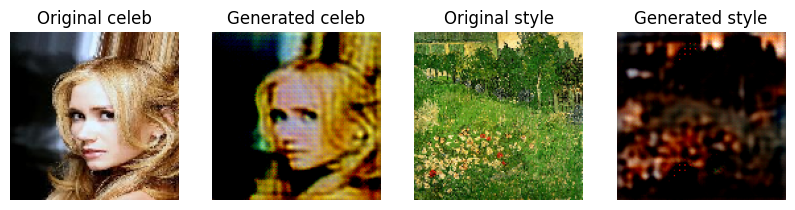

Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.008 ,0.007 ] dB[0.004 ,0.001] g[24.908 ,24.176]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.005 ,0.004 ] dB[0.004 ,0.003] g[29.254 ,29.936]
1/1 [==============================] - 0s 21ms/step



Batchs:   1%|          | 3/400 [00:01<03:55,  1.68it/s]

>3, dA[0.012 ,0.004 ] dB[0.004 ,0.001] g[26.229 ,25.026]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|          | 4/400 [00:02<03:55,  1.68it/s]

>4, dA[0.020 ,0.002 ] dB[0.003 ,0.002] g[34.074 ,33.011]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:55,  1.67it/s]

>5, dA[0.017 ,0.002 ] dB[0.003 ,0.001] g[22.549 ,22.671]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:54,  1.68it/s]

>6, dA[0.012 ,0.002 ] dB[0.004 ,0.002] g[25.561 ,25.176]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:53,  1.68it/s]

>7, dA[0.011 ,0.004 ] dB[0.003 ,0.003] g[33.895 ,32.196]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.69it/s]

>8, dA[0.009 ,0.002 ] dB[0.006 ,0.003] g[25.102 ,26.905]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:56,  1.65it/s]

>9, dA[0.004 ,0.002 ] dB[0.012 ,0.003] g[22.349 ,22.548]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:55,  1.66it/s]

>10, dA[0.016 ,0.003 ] dB[0.008 ,0.002] g[27.812 ,24.812]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:53,  1.67it/s]

>11, dA[0.009 ,0.004 ] dB[0.005 ,0.005] g[27.113 ,23.833]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:52,  1.67it/s]

>12, dA[0.021 ,0.004 ] dB[0.007 ,0.006] g[29.205 ,32.015]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:52,  1.67it/s]

>13, dA[0.026 ,0.011 ] dB[0.008 ,0.005] g[29.126 ,31.492]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:51,  1.67it/s]

>14, dA[0.011 ,0.007 ] dB[0.005 ,0.004] g[31.674 ,29.326]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.009 ,0.004 ] dB[0.004 ,0.007] g[32.941 ,36.823]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:48,  1.68it/s]

>16, dA[0.010 ,0.004 ] dB[0.009 ,0.004] g[25.823 ,26.587]
1/1 [==============================] - 0s 24ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:50,  1.66it/s]

>17, dA[0.012 ,0.002 ] dB[0.007 ,0.010] g[36.623 ,37.725]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:48,  1.67it/s]

>18, dA[0.007 ,0.003 ] dB[0.007 ,0.002] g[30.524 ,30.886]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:46,  1.68it/s]

>19, dA[0.007 ,0.004 ] dB[0.010 ,0.005] g[31.769 ,35.543]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:46,  1.68it/s]

>20, dA[0.003 ,0.002 ] dB[0.007 ,0.005] g[35.564 ,39.104]
1/1 [==============================] - 0s 22ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:46,  1.67it/s]

>21, dA[0.035 ,0.003 ] dB[0.003 ,0.003] g[28.962 ,26.753]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:45,  1.68it/s]

>22, dA[0.021 ,0.005 ] dB[0.002 ,0.003] g[21.822 ,19.605]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:44,  1.68it/s]

>23, dA[0.008 ,0.007 ] dB[0.004 ,0.004] g[31.251 ,34.097]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:43,  1.68it/s]

>24, dA[0.009 ,0.007 ] dB[0.004 ,0.007] g[23.984 ,23.989]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:46,  1.66it/s]

>25, dA[0.012 ,0.004 ] dB[0.002 ,0.008] g[28.780 ,27.807]
1/1 [==============================] - 0s 30ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:47,  1.64it/s]

>26, dA[0.025 ,0.006 ] dB[0.002 ,0.004] g[24.709 ,23.998]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:46,  1.65it/s]

>27, dA[0.012 ,0.005 ] dB[0.002 ,0.003] g[24.316 ,22.919]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:44,  1.66it/s]

>28, dA[0.009 ,0.002 ] dB[0.004 ,0.004] g[41.961 ,42.842]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:44,  1.65it/s]

>29, dA[0.008 ,0.003 ] dB[0.002 ,0.003] g[37.335 ,36.556]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:42,  1.66it/s]

>30, dA[0.005 ,0.003 ] dB[0.008 ,0.008] g[26.282 ,29.537]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.006 ,0.002 ] dB[0.007 ,0.003] g[28.240 ,27.552]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.006 ,0.001 ] dB[0.005 ,0.003] g[24.644 ,24.436]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:39,  1.67it/s]

>33, dA[0.006 ,0.006 ] dB[0.003 ,0.002] g[26.365 ,26.186]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.68it/s]

>34, dA[0.007 ,0.004 ] dB[0.003 ,0.005] g[20.997 ,20.655]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:37,  1.68it/s]

>35, dA[0.009 ,0.004 ] dB[0.003 ,0.005] g[23.016 ,21.714]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:36,  1.68it/s]

>36, dA[0.008 ,0.002 ] dB[0.010 ,0.011] g[34.362 ,35.756]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 37/400 [00:22<03:37,  1.67it/s]

>37, dA[0.008 ,0.001 ] dB[0.005 ,0.006] g[28.481 ,29.678]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:36,  1.67it/s]

>38, dA[0.007 ,0.004 ] dB[0.011 ,0.011] g[25.171 ,24.229]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:35,  1.67it/s]

>39, dA[0.011 ,0.004 ] dB[0.007 ,0.016] g[30.784 ,27.578]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 40/400 [00:23<03:35,  1.67it/s]

>40, dA[0.006 ,0.003 ] dB[0.021 ,0.008] g[25.696 ,26.475]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 41/400 [00:24<03:35,  1.67it/s]

>41, dA[0.009 ,0.002 ] dB[0.022 ,0.005] g[24.516 ,24.520]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:25<03:35,  1.66it/s]

>42, dA[0.010 ,0.004 ] dB[0.009 ,0.007] g[29.923 ,33.374]
1/1 [==============================] - 0s 19ms/step



Batchs:  11%|█         | 43/400 [00:25<03:34,  1.67it/s]

>43, dA[0.007 ,0.005 ] dB[0.015 ,0.023] g[35.845 ,35.943]
1/1 [==============================] - 0s 24ms/step



Batchs:  11%|█         | 44/400 [00:26<03:34,  1.66it/s]

>44, dA[0.008 ,0.003 ] dB[0.006 ,0.007] g[31.399 ,34.962]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:33,  1.66it/s]

>45, dA[0.010 ,0.002 ] dB[0.010 ,0.008] g[27.984 ,30.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:32,  1.67it/s]

>46, dA[0.008 ,0.005 ] dB[0.012 ,0.027] g[24.578 ,25.182]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 47/400 [00:28<03:30,  1.68it/s]

>47, dA[0.007 ,0.004 ] dB[0.023 ,0.020] g[23.638 ,23.806]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:30,  1.68it/s]

>48, dA[0.016 ,0.005 ] dB[0.018 ,0.019] g[30.485 ,29.230]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:29,  1.67it/s]

>49, dA[0.016 ,0.002 ] dB[0.021 ,0.013] g[23.679 ,23.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:29,  1.67it/s]

>50, dA[0.013 ,0.010 ] dB[0.010 ,0.008] g[33.036 ,34.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:28,  1.68it/s]

>51, dA[0.006 ,0.005 ] dB[0.009 ,0.004] g[32.256 ,33.131]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:31<03:26,  1.68it/s]

>52, dA[0.005 ,0.006 ] dB[0.004 ,0.002] g[34.472 ,35.418]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:26,  1.68it/s]

>53, dA[0.011 ,0.005 ] dB[0.006 ,0.003] g[30.272 ,33.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:25,  1.68it/s]

>54, dA[0.023 ,0.004 ] dB[0.011 ,0.007] g[22.587 ,22.904]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:25,  1.68it/s]

>55, dA[0.013 ,0.002 ] dB[0.009 ,0.018] g[28.331 ,29.550]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:24,  1.68it/s]

>56, dA[0.007 ,0.002 ] dB[0.021 ,0.015] g[28.682 ,29.058]
1/1 [==============================] - 0s 21ms/step



Batchs:  14%|█▍        | 57/400 [00:34<03:24,  1.68it/s]

>57, dA[0.013 ,0.003 ] dB[0.017 ,0.006] g[31.623 ,30.546]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:23,  1.68it/s]

>58, dA[0.012 ,0.004 ] dB[0.008 ,0.017] g[35.081 ,36.766]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:22,  1.69it/s]

>59, dA[0.007 ,0.008 ] dB[0.004 ,0.005] g[27.755 ,27.545]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:21,  1.69it/s]

>60, dA[0.008 ,0.008 ] dB[0.003 ,0.002] g[30.615 ,28.751]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:21,  1.68it/s]

>61, dA[0.005 ,0.006 ] dB[0.006 ,0.007] g[34.213 ,34.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 62/400 [00:37<03:21,  1.68it/s]

>62, dA[0.004 ,0.002 ] dB[0.004 ,0.016] g[37.792 ,40.250]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.014 ,0.003 ] dB[0.010 ,0.014] g[29.750 ,30.851]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.019 ,0.010 ] dB[0.010 ,0.014] g[33.577 ,29.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:19,  1.68it/s]

>65, dA[0.029 ,0.009 ] dB[0.010 ,0.018] g[21.187 ,21.432]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:19,  1.67it/s]

>66, dA[0.007 ,0.009 ] dB[0.009 ,0.006] g[30.525 ,34.750]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 67/400 [00:40<03:17,  1.68it/s]

>67, dA[0.018 ,0.013 ] dB[0.016 ,0.006] g[25.767 ,25.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:17,  1.68it/s]

>68, dA[0.013 ,0.015 ] dB[0.012 ,0.005] g[30.666 ,32.272]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:18,  1.67it/s]

>69, dA[0.008 ,0.007 ] dB[0.020 ,0.010] g[26.803 ,26.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:17,  1.67it/s]

>70, dA[0.007 ,0.005 ] dB[0.009 ,0.003] g[33.221 ,31.772]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:16,  1.67it/s]

>71, dA[0.009 ,0.005 ] dB[0.011 ,0.005] g[31.858 ,32.510]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 72/400 [00:43<03:16,  1.67it/s]

>72, dA[0.007 ,0.001 ] dB[0.005 ,0.003] g[36.771 ,39.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:16,  1.66it/s]

>73, dA[0.007 ,0.004 ] dB[0.008 ,0.002] g[38.182 ,37.598]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:44<03:15,  1.67it/s]

>74, dA[0.005 ,0.002 ] dB[0.003 ,0.001] g[20.010 ,18.385]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:14,  1.67it/s]

>75, dA[0.004 ,0.004 ] dB[0.008 ,0.010] g[31.822 ,35.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:15,  1.66it/s]

>76, dA[0.006 ,0.005 ] dB[0.009 ,0.008] g[28.263 ,25.316]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 77/400 [00:46<03:16,  1.64it/s]

>77, dA[0.007 ,0.003 ] dB[0.003 ,0.003] g[34.817 ,37.169]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:15,  1.65it/s]

>78, dA[0.005 ,0.002 ] dB[0.005 ,0.006] g[30.572 ,32.508]
1/1 [==============================] - 0s 25ms/step



Batchs:  20%|█▉        | 79/400 [00:47<03:14,  1.65it/s]

>79, dA[0.031 ,0.003 ] dB[0.003 ,0.004] g[34.397 ,39.230]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 80/400 [00:47<03:13,  1.66it/s]

>80, dA[0.010 ,0.007 ] dB[0.005 ,0.001] g[26.357 ,25.876]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 81/400 [00:48<03:12,  1.66it/s]

>81, dA[0.005 ,0.006 ] dB[0.004 ,0.002] g[30.629 ,31.059]
1/1 [==============================] - 0s 22ms/step



Batchs:  20%|██        | 82/400 [00:49<03:10,  1.67it/s]

>82, dA[0.007 ,0.003 ] dB[0.002 ,0.002] g[30.974 ,32.929]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:09,  1.67it/s]

>83, dA[0.004 ,0.003 ] dB[0.004 ,0.004] g[21.097 ,24.786]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 84/400 [00:50<03:08,  1.68it/s]

>84, dA[0.005 ,0.003 ] dB[0.006 ,0.003] g[27.192 ,29.983]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:08,  1.67it/s]

>85, dA[0.007 ,0.003 ] dB[0.005 ,0.003] g[39.630 ,44.042]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:07,  1.67it/s]

>86, dA[0.020 ,0.006 ] dB[0.005 ,0.002] g[24.291 ,22.864]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:52<03:06,  1.68it/s]

>87, dA[0.005 ,0.003 ] dB[0.003 ,0.001] g[40.687 ,39.887]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:07,  1.67it/s]

>88, dA[0.007 ,0.001 ] dB[0.005 ,0.001] g[30.165 ,31.417]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:53<03:06,  1.67it/s]

>89, dA[0.007 ,0.002 ] dB[0.008 ,0.002] g[29.395 ,28.063]
1/1 [==============================] - 0s 23ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:06,  1.66it/s]

>90, dA[0.010 ,0.003 ] dB[0.005 ,0.002] g[27.579 ,24.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:04,  1.67it/s]

>91, dA[0.010 ,0.002 ] dB[0.005 ,0.003] g[28.084 ,27.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 92/400 [00:55<03:03,  1.68it/s]

>92, dA[0.006 ,0.003 ] dB[0.004 ,0.002] g[25.852 ,26.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:05,  1.65it/s]

>93, dA[0.009 ,0.002 ] dB[0.002 ,0.003] g[25.887 ,23.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:56<03:04,  1.66it/s]

>94, dA[0.006 ,0.007 ] dB[0.004 ,0.001] g[25.444 ,25.838]
1/1 [==============================] - 0s 22ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:03,  1.67it/s]

>95, dA[0.006 ,0.004 ] dB[0.004 ,0.004] g[26.897 ,26.919]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 96/400 [00:57<03:02,  1.67it/s]

>96, dA[0.011 ,0.003 ] dB[0.003 ,0.002] g[30.722 ,28.250]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:58<03:01,  1.67it/s]

>97, dA[0.005 ,0.005 ] dB[0.003 ,0.001] g[27.978 ,28.970]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<03:00,  1.67it/s]

>98, dA[0.004 ,0.003 ] dB[0.001 ,0.000] g[30.440 ,32.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:59<02:59,  1.68it/s]

>99, dA[0.005 ,0.002 ] dB[0.003 ,0.002] g[22.313 ,21.741]
1/1 [==============================] - 0s 22ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:58,  1.68it/s]

>100, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[25.878 ,26.509]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [01:00<02:58,  1.67it/s]

>101, dA[0.003 ,0.004 ] dB[0.003 ,0.002] g[30.584 ,29.246]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:01<02:57,  1.68it/s]

>102, dA[0.005 ,0.003 ] dB[0.003 ,0.003] g[29.378 ,30.345]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:56,  1.68it/s]

>103, dA[0.008 ,0.004 ] dB[0.003 ,0.001] g[42.567 ,40.289]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 104/400 [01:02<02:55,  1.68it/s]

>104, dA[0.010 ,0.002 ] dB[0.004 ,0.003] g[19.069 ,19.641]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:55,  1.68it/s]

>105, dA[0.008 ,0.003 ] dB[0.004 ,0.002] g[32.684 ,29.671]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:03<02:55,  1.68it/s]

>106, dA[0.008 ,0.003 ] dB[0.004 ,0.004] g[27.834 ,28.720]
1/1 [==============================] - 0s 22ms/step



Batchs:  27%|██▋       | 107/400 [01:04<02:54,  1.68it/s]

>107, dA[0.010 ,0.004 ] dB[0.026 ,0.010] g[38.263 ,40.516]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:53,  1.68it/s]

>108, dA[0.006 ,0.002 ] dB[0.071 ,0.033] g[25.579 ,24.350]
1/1 [==============================] - 0s 23ms/step



Batchs:  27%|██▋       | 109/400 [01:05<02:54,  1.67it/s]

>109, dA[0.004 ,0.003 ] dB[0.059 ,0.032] g[28.191 ,26.825]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:53,  1.67it/s]

>110, dA[0.010 ,0.004 ] dB[0.025 ,0.036] g[25.874 ,26.984]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 111/400 [01:06<02:53,  1.67it/s]

>111, dA[0.004 ,0.003 ] dB[0.018 ,0.017] g[33.910 ,30.268]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 112/400 [01:07<02:52,  1.67it/s]

>112, dA[0.013 ,0.002 ] dB[0.029 ,0.029] g[22.619 ,22.115]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:52,  1.66it/s]

>113, dA[0.005 ,0.002 ] dB[0.023 ,0.034] g[33.022 ,35.019]
1/1 [==============================] - 0s 22ms/step



Batchs:  28%|██▊       | 114/400 [01:08<02:51,  1.66it/s]

>114, dA[0.004 ,0.005 ] dB[0.043 ,0.074] g[36.400 ,39.908]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:50,  1.67it/s]

>115, dA[0.008 ,0.002 ] dB[0.031 ,0.045] g[21.362 ,21.948]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 116/400 [01:09<02:50,  1.67it/s]

>116, dA[0.007 ,0.002 ] dB[0.091 ,0.088] g[21.383 ,22.607]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:10<02:49,  1.67it/s]

>117, dA[0.003 ,0.006 ] dB[0.042 ,0.048] g[28.436 ,31.006]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:49,  1.67it/s]

>118, dA[0.005 ,0.006 ] dB[0.018 ,0.011] g[39.513 ,39.385]
1/1 [==============================] - 0s 24ms/step



Batchs:  30%|██▉       | 119/400 [01:11<02:49,  1.66it/s]

>119, dA[0.004 ,0.003 ] dB[0.011 ,0.009] g[31.032 ,32.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|███       | 120/400 [01:11<02:48,  1.66it/s]

>120, dA[0.026 ,0.003 ] dB[0.007 ,0.009] g[21.143 ,20.418]
1/1 [==============================] - 0s 23ms/step



Batchs:  30%|███       | 121/400 [01:12<02:48,  1.66it/s]

>121, dA[0.006 ,0.003 ] dB[0.005 ,0.006] g[26.721 ,27.772]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:13<02:46,  1.67it/s]

>122, dA[0.017 ,0.007 ] dB[0.009 ,0.005] g[28.908 ,31.410]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 123/400 [01:13<02:46,  1.67it/s]

>123, dA[0.020 ,0.012 ] dB[0.004 ,0.005] g[37.416 ,39.935]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███       | 124/400 [01:14<02:45,  1.67it/s]

>124, dA[0.019 ,0.007 ] dB[0.011 ,0.006] g[35.997 ,38.571]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:44,  1.67it/s]

>125, dA[0.007 ,0.005 ] dB[0.024 ,0.009] g[28.847 ,29.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [01:15<02:44,  1.67it/s]

>126, dA[0.014 ,0.004 ] dB[0.012 ,0.006] g[34.078 ,32.831]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:16<02:43,  1.67it/s]

>127, dA[0.010 ,0.002 ] dB[0.007 ,0.008] g[23.205 ,21.794]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 128/400 [01:16<02:42,  1.68it/s]

>128, dA[0.007 ,0.002 ] dB[0.010 ,0.004] g[32.747 ,30.706]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 129/400 [01:17<02:43,  1.66it/s]

>129, dA[0.006 ,0.002 ] dB[0.010 ,0.005] g[29.243 ,31.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:43,  1.65it/s]

>130, dA[0.005 ,0.003 ] dB[0.009 ,0.004] g[31.907 ,33.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 131/400 [01:18<02:42,  1.65it/s]

>131, dA[0.013 ,0.003 ] dB[0.011 ,0.003] g[29.738 ,30.739]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:19<02:40,  1.66it/s]

>132, dA[0.009 ,0.002 ] dB[0.005 ,0.009] g[30.288 ,28.135]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:19<02:40,  1.66it/s]

>133, dA[0.008 ,0.002 ] dB[0.005 ,0.004] g[30.376 ,30.749]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:20<02:39,  1.67it/s]

>134, dA[0.007 ,0.003 ] dB[0.005 ,0.005] g[24.293 ,22.448]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:38,  1.68it/s]

>135, dA[0.007 ,0.003 ] dB[0.011 ,0.008] g[20.367 ,20.197]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 136/400 [01:21<02:37,  1.68it/s]

>136, dA[0.005 ,0.003 ] dB[0.002 ,0.004] g[39.977 ,44.167]
1/1 [==============================] - 0s 23ms/step



Batchs:  34%|███▍      | 137/400 [01:22<02:37,  1.67it/s]

>137, dA[0.006 ,0.003 ] dB[0.005 ,0.002] g[24.865 ,21.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:22<02:36,  1.68it/s]

>138, dA[0.007 ,0.004 ] dB[0.003 ,0.005] g[34.974 ,36.631]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▍      | 139/400 [01:23<02:35,  1.68it/s]

>139, dA[0.006 ,0.003 ] dB[0.007 ,0.003] g[25.077 ,25.158]
1/1 [==============================] - 0s 24ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:35,  1.67it/s]

>140, dA[0.007 ,0.002 ] dB[0.003 ,0.004] g[27.342 ,29.320]
1/1 [==============================] - 0s 21ms/step



Batchs:  35%|███▌      | 141/400 [01:24<02:35,  1.67it/s]

>141, dA[0.009 ,0.001 ] dB[0.005 ,0.012] g[29.118 ,26.834]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:34,  1.67it/s]

>142, dA[0.008 ,0.005 ] dB[0.009 ,0.007] g[27.390 ,26.763]
1/1 [==============================] - 0s 28ms/step



Batchs:  36%|███▌      | 143/400 [01:25<02:34,  1.66it/s]

>143, dA[0.006 ,0.004 ] dB[0.009 ,0.016] g[33.583 ,36.190]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▌      | 144/400 [01:26<02:33,  1.67it/s]

>144, dA[0.006 ,0.001 ] dB[0.021 ,0.003] g[32.540 ,34.697]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:33,  1.67it/s]

>145, dA[0.004 ,0.005 ] dB[0.026 ,0.005] g[23.359 ,23.561]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:27<02:32,  1.67it/s]

>146, dA[0.004 ,0.004 ] dB[0.012 ,0.008] g[30.129 ,32.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 147/400 [01:28<02:31,  1.67it/s]

>147, dA[0.007 ,0.002 ] dB[0.014 ,0.016] g[24.610 ,23.543]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 148/400 [01:28<02:30,  1.67it/s]

>148, dA[0.005 ,0.003 ] dB[0.008 ,0.029] g[30.035 ,30.998]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 149/400 [01:29<02:30,  1.66it/s]

>149, dA[0.023 ,0.006 ] dB[0.014 ,0.006] g[28.351 ,28.514]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:29,  1.67it/s]

>150, dA[0.011 ,0.005 ] dB[0.012 ,0.003] g[27.992 ,30.093]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 151/400 [01:30<02:28,  1.67it/s]

>151, dA[0.007 ,0.003 ] dB[0.004 ,0.004] g[30.967 ,29.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:28,  1.67it/s]

>152, dA[0.005 ,0.006 ] dB[0.005 ,0.002] g[29.044 ,26.064]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 153/400 [01:31<02:27,  1.67it/s]

>153, dA[0.005 ,0.003 ] dB[0.002 ,0.001] g[20.369 ,20.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:32<02:26,  1.68it/s]

>154, dA[0.007 ,0.002 ] dB[0.002 ,0.002] g[28.352 ,29.530]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.68it/s]

>155, dA[0.004 ,0.004 ] dB[0.002 ,0.001] g[26.819 ,27.905]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:33<02:24,  1.68it/s]

>156, dA[0.003 ,0.004 ] dB[0.004 ,0.002] g[27.308 ,27.413]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:25,  1.68it/s]

>157, dA[0.004 ,0.003 ] dB[0.006 ,0.003] g[35.132 ,38.554]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:34<02:24,  1.67it/s]

>158, dA[0.003 ,0.005 ] dB[0.006 ,0.017] g[33.017 ,32.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:35<02:24,  1.67it/s]

>159, dA[0.006 ,0.003 ] dB[0.004 ,0.010] g[26.347 ,24.316]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:35<02:23,  1.68it/s]

>160, dA[0.005 ,0.005 ] dB[0.007 ,0.007] g[31.546 ,32.953]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:36<02:23,  1.67it/s]

>161, dA[0.010 ,0.005 ] dB[0.007 ,0.002] g[37.754 ,36.747]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|████      | 162/400 [01:36<02:22,  1.67it/s]

>162, dA[0.004 ,0.003 ] dB[0.004 ,0.002] g[22.136 ,21.555]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:37<02:21,  1.68it/s]

>163, dA[0.005 ,0.002 ] dB[0.006 ,0.007] g[24.779 ,26.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 164/400 [01:38<02:20,  1.68it/s]

>164, dA[0.006 ,0.004 ] dB[0.007 ,0.006] g[41.639 ,39.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:38<02:20,  1.67it/s]

>165, dA[0.004 ,0.003 ] dB[0.010 ,0.005] g[29.653 ,27.705]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:39<02:19,  1.68it/s]

>166, dA[0.005 ,0.001 ] dB[0.014 ,0.007] g[31.736 ,29.265]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.006 ,0.001 ] dB[0.005 ,0.005] g[26.521 ,29.082]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:40<02:17,  1.68it/s]

>168, dA[0.009 ,0.004 ] dB[0.007 ,0.004] g[28.729 ,29.821]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:41<02:17,  1.67it/s]

>169, dA[0.005 ,0.003 ] dB[0.004 ,0.006] g[22.884 ,22.724]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▎     | 170/400 [01:41<02:17,  1.67it/s]

>170, dA[0.012 ,0.004 ] dB[0.007 ,0.004] g[35.155 ,36.553]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 171/400 [01:42<02:16,  1.67it/s]

>171, dA[0.004 ,0.010 ] dB[0.008 ,0.004] g[28.815 ,29.963]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:16,  1.67it/s]

>172, dA[0.004 ,0.006 ] dB[0.008 ,0.010] g[34.793 ,39.266]
1/1 [==============================] - 0s 21ms/step



Batchs:  43%|████▎     | 173/400 [01:43<02:15,  1.67it/s]

>173, dA[0.008 ,0.003 ] dB[0.004 ,0.007] g[28.477 ,30.659]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▎     | 174/400 [01:44<02:15,  1.67it/s]

>174, dA[0.010 ,0.003 ] dB[0.006 ,0.002] g[30.596 ,30.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:44<02:14,  1.67it/s]

>175, dA[0.008 ,0.004 ] dB[0.005 ,0.003] g[27.900 ,29.102]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:45<02:14,  1.67it/s]

>176, dA[0.008 ,0.003 ] dB[0.006 ,0.004] g[37.635 ,43.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:14,  1.66it/s]

>177, dA[0.008 ,0.003 ] dB[0.007 ,0.004] g[32.118 ,34.507]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:46<02:13,  1.67it/s]

>178, dA[0.008 ,0.006 ] dB[0.005 ,0.008] g[28.484 ,31.217]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:47<02:12,  1.67it/s]

>179, dA[0.006 ,0.001 ] dB[0.002 ,0.003] g[30.614 ,33.590]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:47<02:11,  1.68it/s]

>180, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[39.990 ,42.550]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:48<02:11,  1.67it/s]

>181, dA[0.016 ,0.007 ] dB[0.003 ,0.005] g[25.781 ,23.854]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:11,  1.65it/s]

>182, dA[0.021 ,0.004 ] dB[0.004 ,0.004] g[34.291 ,33.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 183/400 [01:49<02:11,  1.65it/s]

>183, dA[0.019 ,0.002 ] dB[0.008 ,0.003] g[35.531 ,39.310]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:50<02:09,  1.66it/s]

>184, dA[0.015 ,0.002 ] dB[0.007 ,0.005] g[22.930 ,22.327]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 185/400 [01:50<02:09,  1.66it/s]

>185, dA[0.012 ,0.004 ] dB[0.007 ,0.005] g[12.664 ,13.112]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 186/400 [01:51<02:08,  1.67it/s]

>186, dA[0.007 ,0.004 ] dB[0.006 ,0.007] g[30.966 ,29.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 187/400 [01:51<02:07,  1.67it/s]

>187, dA[0.024 ,0.029 ] dB[0.003 ,0.006] g[31.222 ,33.089]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 188/400 [01:52<02:06,  1.67it/s]

>188, dA[0.019 ,0.018 ] dB[0.006 ,0.016] g[30.840 ,34.031]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:53<02:06,  1.67it/s]

>189, dA[0.023 ,0.010 ] dB[0.008 ,0.005] g[30.702 ,32.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:53<02:05,  1.67it/s]

>190, dA[0.010 ,0.013 ] dB[0.007 ,0.002] g[33.941 ,36.357]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:54<02:04,  1.68it/s]

>191, dA[0.010 ,0.004 ] dB[0.003 ,0.003] g[33.413 ,34.141]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:54<02:04,  1.67it/s]

>192, dA[0.009 ,0.004 ] dB[0.005 ,0.005] g[23.672 ,20.698]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:55<02:03,  1.67it/s]

>193, dA[0.005 ,0.013 ] dB[0.003 ,0.003] g[25.639 ,26.244]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 194/400 [01:56<02:02,  1.68it/s]

>194, dA[0.014 ,0.004 ] dB[0.003 ,0.005] g[24.905 ,26.202]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 195/400 [01:56<02:02,  1.68it/s]

>195, dA[0.009 ,0.003 ] dB[0.003 ,0.006] g[27.316 ,27.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:57<02:01,  1.68it/s]

>196, dA[0.002 ,0.003 ] dB[0.008 ,0.002] g[24.419 ,24.280]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:57<02:01,  1.67it/s]

>197, dA[0.018 ,0.010 ] dB[0.002 ,0.003] g[20.326 ,20.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:58<02:00,  1.68it/s]

>198, dA[0.010 ,0.009 ] dB[0.002 ,0.003] g[19.118 ,18.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:59<01:59,  1.68it/s]

>199, dA[0.013 ,0.005 ] dB[0.003 ,0.002] g[36.565 ,36.408]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 200/400 [01:59<01:58,  1.68it/s]

>200, dA[0.007 ,0.005 ] dB[0.010 ,0.003] g[20.059 ,21.892]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [02:00<01:58,  1.68it/s]

>201, dA[0.008 ,0.004 ] dB[0.008 ,0.002] g[27.886 ,27.911]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|█████     | 202/400 [02:00<01:58,  1.68it/s]

>202, dA[0.004 ,0.003 ] dB[0.004 ,0.001] g[35.018 ,31.926]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:01<01:57,  1.68it/s]

>203, dA[0.010 ,0.002 ] dB[0.004 ,0.005] g[25.226 ,22.451]
1/1 [==============================] - 0s 22ms/step



Batchs:  51%|█████     | 204/400 [02:02<01:56,  1.68it/s]

>204, dA[0.018 ,0.002 ] dB[0.003 ,0.004] g[31.281 ,32.736]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:02<01:56,  1.68it/s]

>205, dA[0.023 ,0.003 ] dB[0.004 ,0.003] g[17.240 ,17.512]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:03<01:55,  1.68it/s]

>206, dA[0.064 ,0.005 ] dB[0.002 ,0.002] g[29.217 ,30.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:03<01:54,  1.68it/s]

>207, dA[0.046 ,0.016 ] dB[0.004 ,0.002] g[32.003 ,33.284]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:04<01:54,  1.68it/s]

>208, dA[0.089 ,0.028 ] dB[0.007 ,0.004] g[20.062 ,20.330]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 209/400 [02:05<01:54,  1.67it/s]

>209, dA[0.045 ,0.009 ] dB[0.005 ,0.010] g[24.855 ,26.963]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:05<01:54,  1.66it/s]

>210, dA[0.014 ,0.004 ] dB[0.006 ,0.014] g[37.886 ,39.188]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:06<01:53,  1.66it/s]

>211, dA[0.035 ,0.008 ] dB[0.013 ,0.003] g[20.703 ,21.713]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:06<01:52,  1.67it/s]

>212, dA[0.009 ,0.008 ] dB[0.006 ,0.008] g[27.126 ,27.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  53%|█████▎    | 213/400 [02:07<01:52,  1.66it/s]

>213, dA[0.007 ,0.003 ] dB[0.004 ,0.003] g[25.537 ,27.206]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:08<01:51,  1.67it/s]

>214, dA[0.010 ,0.003 ] dB[0.008 ,0.008] g[30.356 ,34.855]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:08<01:50,  1.67it/s]

>215, dA[0.010 ,0.007 ] dB[0.008 ,0.004] g[39.153 ,41.401]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:09<01:49,  1.67it/s]

>216, dA[0.012 ,0.003 ] dB[0.006 ,0.003] g[34.012 ,34.094]
1/1 [==============================] - 0s 22ms/step



Batchs:  54%|█████▍    | 217/400 [02:09<01:49,  1.67it/s]

>217, dA[0.008 ,0.005 ] dB[0.020 ,0.004] g[17.662 ,17.930]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:10<01:48,  1.68it/s]

>218, dA[0.013 ,0.004 ] dB[0.009 ,0.008] g[40.793 ,44.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 219/400 [02:11<01:47,  1.68it/s]

>219, dA[0.010 ,0.004 ] dB[0.008 ,0.006] g[35.306 ,35.224]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:11<01:47,  1.67it/s]

>220, dA[0.006 ,0.004 ] dB[0.005 ,0.005] g[31.686 ,32.488]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:12<01:47,  1.67it/s]

>221, dA[0.011 ,0.004 ] dB[0.004 ,0.003] g[20.313 ,19.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 222/400 [02:12<01:46,  1.67it/s]

>222, dA[0.009 ,0.002 ] dB[0.004 ,0.006] g[28.725 ,30.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:13<01:45,  1.67it/s]

>223, dA[0.013 ,0.004 ] dB[0.005 ,0.004] g[18.233 ,18.163]
1/1 [==============================] - 0s 24ms/step



Batchs:  56%|█████▌    | 224/400 [02:14<01:45,  1.68it/s]

>224, dA[0.012 ,0.002 ] dB[0.004 ,0.003] g[27.816 ,26.728]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 225/400 [02:14<01:44,  1.67it/s]

>225, dA[0.009 ,0.002 ] dB[0.003 ,0.003] g[23.413 ,26.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 226/400 [02:15<01:43,  1.68it/s]

>226, dA[0.004 ,0.002 ] dB[0.004 ,0.005] g[22.291 ,23.411]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 227/400 [02:15<01:43,  1.68it/s]

>227, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[33.150 ,34.155]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:16<01:42,  1.68it/s]

>228, dA[0.004 ,0.004 ] dB[0.004 ,0.002] g[28.538 ,27.706]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▋    | 229/400 [02:17<01:42,  1.67it/s]

>229, dA[0.010 ,0.008 ] dB[0.007 ,0.006] g[22.355 ,22.538]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:17<01:41,  1.67it/s]

>230, dA[0.015 ,0.001 ] dB[0.012 ,0.003] g[20.442 ,20.581]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:18<01:40,  1.68it/s]

>231, dA[0.005 ,0.005 ] dB[0.006 ,0.002] g[20.989 ,21.863]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:18<01:39,  1.68it/s]

>232, dA[0.005 ,0.002 ] dB[0.007 ,0.005] g[26.230 ,26.070]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:19<01:40,  1.67it/s]

>233, dA[0.005 ,0.004 ] dB[0.003 ,0.003] g[23.199 ,23.849]
1/1 [==============================] - 0s 23ms/step



Batchs:  58%|█████▊    | 234/400 [02:20<01:40,  1.65it/s]

>234, dA[0.003 ,0.003 ] dB[0.006 ,0.008] g[37.633 ,39.438]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 235/400 [02:20<01:39,  1.65it/s]

>235, dA[0.004 ,0.002 ] dB[0.009 ,0.009] g[45.431 ,45.964]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:21<01:38,  1.66it/s]

>236, dA[0.005 ,0.003 ] dB[0.004 ,0.003] g[35.596 ,38.604]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:38,  1.66it/s]

>237, dA[0.005 ,0.003 ] dB[0.002 ,0.001] g[32.525 ,33.895]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:22<01:37,  1.66it/s]

>238, dA[0.004 ,0.004 ] dB[0.003 ,0.001] g[27.280 ,30.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:23<01:36,  1.66it/s]

>239, dA[0.018 ,0.005 ] dB[0.005 ,0.001] g[24.020 ,24.163]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:23<01:36,  1.66it/s]

>240, dA[0.011 ,0.004 ] dB[0.003 ,0.003] g[27.322 ,26.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:24<01:36,  1.66it/s]

>241, dA[0.004 ,0.003 ] dB[0.006 ,0.002] g[26.761 ,23.301]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:35,  1.66it/s]

>242, dA[0.008 ,0.009 ] dB[0.005 ,0.004] g[27.074 ,26.903]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:25<01:34,  1.66it/s]

>243, dA[0.011 ,0.009 ] dB[0.003 ,0.004] g[29.900 ,30.275]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:26<01:33,  1.67it/s]

>244, dA[0.005 ,0.002 ] dB[0.005 ,0.002] g[24.490 ,26.025]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:26<01:32,  1.67it/s]

>245, dA[0.007 ,0.004 ] dB[0.003 ,0.001] g[29.745 ,31.078]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:27<01:32,  1.67it/s]

>246, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[33.548 ,37.476]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.66it/s]

>247, dA[0.009 ,0.002 ] dB[0.005 ,0.003] g[30.147 ,30.022]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:28<01:30,  1.67it/s]

>248, dA[0.013 ,0.006 ] dB[0.006 ,0.003] g[36.021 ,36.430]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 249/400 [02:29<01:30,  1.67it/s]

>249, dA[0.006 ,0.004 ] dB[0.004 ,0.007] g[27.862 ,30.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:29<01:29,  1.68it/s]

>250, dA[0.013 ,0.010 ] dB[0.004 ,0.005] g[31.979 ,37.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 251/400 [02:30<01:29,  1.67it/s]

>251, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[26.119 ,27.094]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:28,  1.66it/s]

>252, dA[0.009 ,0.005 ] dB[0.004 ,0.004] g[35.652 ,34.140]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 253/400 [02:31<01:28,  1.66it/s]

>253, dA[0.004 ,0.002 ] dB[0.007 ,0.006] g[31.152 ,29.188]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:32<01:27,  1.67it/s]

>254, dA[0.008 ,0.005 ] dB[0.005 ,0.005] g[23.079 ,22.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:32<01:26,  1.68it/s]

>255, dA[0.005 ,0.005 ] dB[0.006 ,0.004] g[22.387 ,19.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:33<01:26,  1.67it/s]

>256, dA[0.002 ,0.003 ] dB[0.004 ,0.007] g[18.357 ,18.660]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:26,  1.66it/s]

>257, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[33.508 ,33.783]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 258/400 [02:34<01:25,  1.66it/s]

>258, dA[0.023 ,0.010 ] dB[0.002 ,0.003] g[23.179 ,22.755]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:35<01:24,  1.66it/s]

>259, dA[0.011 ,0.009 ] dB[0.004 ,0.003] g[30.942 ,32.634]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:35<01:24,  1.65it/s]

>260, dA[0.006 ,0.009 ] dB[0.004 ,0.002] g[25.016 ,23.632]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 261/400 [02:36<01:24,  1.65it/s]

>261, dA[0.014 ,0.006 ] dB[0.004 ,0.004] g[35.056 ,39.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:23,  1.66it/s]

>262, dA[0.006 ,0.003 ] dB[0.005 ,0.007] g[26.787 ,26.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:37<01:22,  1.67it/s]

>263, dA[0.014 ,0.003 ] dB[0.004 ,0.005] g[22.252 ,22.535]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:38<01:21,  1.67it/s]

>264, dA[0.006 ,0.003 ] dB[0.005 ,0.004] g[29.299 ,31.650]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 265/400 [02:38<01:20,  1.67it/s]

>265, dA[0.010 ,0.001 ] dB[0.003 ,0.003] g[25.566 ,27.653]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 266/400 [02:39<01:20,  1.67it/s]

>266, dA[0.010 ,0.005 ] dB[0.004 ,0.002] g[20.018 ,20.537]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:19,  1.68it/s]

>267, dA[0.007 ,0.003 ] dB[0.003 ,0.003] g[20.490 ,21.065]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:40<01:18,  1.68it/s]

>268, dA[0.005 ,0.002 ] dB[0.004 ,0.004] g[24.089 ,22.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  67%|██████▋   | 269/400 [02:41<01:18,  1.68it/s]

>269, dA[0.005 ,0.001 ] dB[0.003 ,0.005] g[27.653 ,24.073]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 270/400 [02:41<01:17,  1.67it/s]

>270, dA[0.007 ,0.003 ] dB[0.003 ,0.002] g[34.777 ,34.559]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 271/400 [02:42<01:17,  1.67it/s]

>271, dA[0.006 ,0.004 ] dB[0.004 ,0.007] g[21.861 ,21.838]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.67it/s]

>272, dA[0.004 ,0.005 ] dB[0.003 ,0.001] g[32.962 ,32.721]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:43<01:16,  1.67it/s]

>273, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[30.715 ,30.395]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 274/400 [02:44<01:15,  1.67it/s]

>274, dA[0.003 ,0.003 ] dB[0.001 ,0.003] g[28.817 ,26.337]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:44<01:14,  1.68it/s]

>275, dA[0.003 ,0.003 ] dB[0.004 ,0.002] g[26.907 ,28.207]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:45<01:13,  1.68it/s]

>276, dA[0.006 ,0.002 ] dB[0.002 ,0.005] g[36.790 ,39.331]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:13,  1.67it/s]

>277, dA[0.006 ,0.004 ] dB[0.004 ,0.003] g[30.711 ,33.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 278/400 [02:46<01:12,  1.68it/s]

>278, dA[0.007 ,0.004 ] dB[0.009 ,0.008] g[27.242 ,27.058]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:11,  1.68it/s]

>279, dA[0.005 ,0.002 ] dB[0.007 ,0.004] g[16.801 ,16.384]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:47<01:11,  1.68it/s]

>280, dA[0.005 ,0.006 ] dB[0.005 ,0.011] g[33.312 ,35.381]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 281/400 [02:48<01:11,  1.67it/s]

>281, dA[0.002 ,0.003 ] dB[0.006 ,0.005] g[21.293 ,19.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:10,  1.68it/s]

>282, dA[0.004 ,0.002 ] dB[0.006 ,0.002] g[30.067 ,26.985]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:49<01:09,  1.68it/s]

>283, dA[0.005 ,0.003 ] dB[0.006 ,0.004] g[25.749 ,24.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:09,  1.67it/s]

>284, dA[0.008 ,0.003 ] dB[0.005 ,0.003] g[32.955 ,33.616]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:50<01:08,  1.67it/s]

>285, dA[0.008 ,0.004 ] dB[0.006 ,0.002] g[38.594 ,40.780]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 286/400 [02:51<01:08,  1.65it/s]

>286, dA[0.006 ,0.002 ] dB[0.002 ,0.004] g[27.289 ,26.876]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:08,  1.66it/s]

>287, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[30.479 ,32.809]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:52<01:07,  1.66it/s]

>288, dA[0.004 ,0.004 ] dB[0.002 ,0.004] g[22.947 ,23.009]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:53<01:06,  1.66it/s]

>289, dA[0.005 ,0.003 ] dB[0.004 ,0.005] g[21.794 ,22.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:06,  1.66it/s]

>290, dA[0.005 ,0.003 ] dB[0.007 ,0.004] g[27.841 ,26.686]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:54<01:05,  1.67it/s]

>291, dA[0.006 ,0.002 ] dB[0.003 ,0.005] g[28.038 ,30.451]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.006 ,0.002 ] dB[0.003 ,0.004] g[30.985 ,32.688]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:55<01:07,  1.57it/s]

>293, dA[0.004 ,0.004 ] dB[0.005 ,0.003] g[23.578 ,24.913]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▎  | 294/400 [02:56<01:06,  1.60it/s]

>294, dA[0.005 ,0.002 ] dB[0.005 ,0.004] g[26.945 ,25.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:04,  1.63it/s]

>295, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[40.037 ,41.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:57<01:03,  1.65it/s]

>296, dA[0.008 ,0.002 ] dB[0.003 ,0.005] g[27.991 ,29.475]
1/1 [==============================] - 0s 23ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:02,  1.65it/s]

>297, dA[0.004 ,0.002 ] dB[0.003 ,0.003] g[23.667 ,24.048]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 298/400 [02:58<01:01,  1.66it/s]

>298, dA[0.006 ,0.001 ] dB[0.002 ,0.002] g[40.827 ,43.019]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:59<01:00,  1.67it/s]

>299, dA[0.004 ,0.003 ] dB[0.004 ,0.004] g[28.517 ,28.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<00:59,  1.68it/s]

>300, dA[0.003 ,0.001 ] dB[0.003 ,0.004] g[29.085 ,30.347]
1/1 [==============================] - 0s 23ms/step



Batchs:  75%|███████▌  | 301/400 [03:00<00:59,  1.67it/s]

>301, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[35.445 ,35.263]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:58,  1.67it/s]

>302, dA[0.015 ,0.003 ] dB[0.003 ,0.003] g[32.972 ,37.145]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 303/400 [03:01<00:58,  1.67it/s]

>303, dA[0.010 ,0.003 ] dB[0.004 ,0.004] g[26.010 ,29.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 304/400 [03:02<00:57,  1.67it/s]

>304, dA[0.006 ,0.002 ] dB[0.002 ,0.007] g[22.438 ,22.586]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:57,  1.67it/s]

>305, dA[0.009 ,0.002 ] dB[0.008 ,0.002] g[27.146 ,25.253]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:03<00:56,  1.67it/s]

>306, dA[0.003 ,0.004 ] dB[0.004 ,0.003] g[32.678 ,34.933]
1/1 [==============================] - 0s 20ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:55,  1.68it/s]

>307, dA[0.005 ,0.003 ] dB[0.003 ,0.001] g[33.881 ,37.189]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:04<00:54,  1.68it/s]

>308, dA[0.008 ,0.006 ] dB[0.002 ,0.003] g[25.470 ,26.226]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:05<00:54,  1.68it/s]

>309, dA[0.013 ,0.004 ] dB[0.007 ,0.007] g[31.612 ,32.640]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:54,  1.67it/s]

>310, dA[0.007 ,0.003 ] dB[0.012 ,0.005] g[25.584 ,23.587]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 311/400 [03:06<00:53,  1.67it/s]

>311, dA[0.005 ,0.003 ] dB[0.004 ,0.002] g[31.506 ,29.663]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.67it/s]

>312, dA[0.006 ,0.002 ] dB[0.003 ,0.003] g[22.200 ,22.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 313/400 [03:07<00:52,  1.67it/s]

>313, dA[0.016 ,0.002 ] dB[0.004 ,0.001] g[40.033 ,44.992]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 314/400 [03:08<00:51,  1.67it/s]

>314, dA[0.011 ,0.003 ] dB[0.004 ,0.002] g[31.250 ,33.785]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:50,  1.67it/s]

>315, dA[0.006 ,0.002 ] dB[0.005 ,0.007] g[28.661 ,27.762]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 316/400 [03:09<00:50,  1.67it/s]

>316, dA[0.006 ,0.003 ] dB[0.006 ,0.004] g[27.933 ,27.318]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.67it/s]

>317, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[31.362 ,30.457]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:48,  1.68it/s]

>318, dA[0.006 ,0.002 ] dB[0.003 ,0.003] g[17.838 ,18.271]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:11<00:48,  1.68it/s]

>319, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[30.621 ,32.271]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.69it/s]

>320, dA[0.008 ,0.001 ] dB[0.002 ,0.001] g[37.003 ,36.727]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 321/400 [03:12<00:46,  1.69it/s]

>321, dA[0.009 ,0.002 ] dB[0.002 ,0.001] g[32.016 ,30.543]
1/1 [==============================] - 0s 20ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.69it/s]

>322, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[30.982 ,29.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:45,  1.69it/s]

>323, dA[0.003 ,0.002 ] dB[0.004 ,0.002] g[25.732 ,25.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:44,  1.69it/s]

>324, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[23.211 ,24.378]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:44,  1.69it/s]

>325, dA[0.005 ,0.006 ] dB[0.001 ,0.001] g[30.960 ,29.866]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 326/400 [03:15<00:43,  1.68it/s]

>326, dA[0.003 ,0.002 ] dB[0.003 ,0.003] g[33.361 ,34.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.69it/s]

>327, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[27.812 ,27.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:42,  1.69it/s]

>328, dA[0.013 ,0.006 ] dB[0.003 ,0.003] g[17.438 ,17.655]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.69it/s]

>329, dA[0.013 ,0.004 ] dB[0.003 ,0.003] g[32.362 ,33.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:41,  1.69it/s]

>330, dA[0.010 ,0.003 ] dB[0.003 ,0.002] g[39.985 ,43.016]
1/1 [==============================] - 0s 19ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:40,  1.70it/s]

>331, dA[0.008 ,0.005 ] dB[0.002 ,0.002] g[26.869 ,27.905]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:40,  1.70it/s]

>332, dA[0.005 ,0.002 ] dB[0.006 ,0.007] g[26.821 ,28.354]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:39,  1.69it/s]

>333, dA[0.006 ,0.003 ] dB[0.006 ,0.015] g[22.728 ,22.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:39,  1.69it/s]

>334, dA[0.007 ,0.004 ] dB[0.018 ,0.015] g[30.282 ,29.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:38,  1.69it/s]

>335, dA[0.011 ,0.004 ] dB[0.024 ,0.007] g[34.752 ,36.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:37,  1.69it/s]

>336, dA[0.007 ,0.006 ] dB[0.011 ,0.008] g[27.846 ,25.977]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:39,  1.59it/s]

>337, dA[0.007 ,0.005 ] dB[0.009 ,0.015] g[38.438 ,40.931]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:38,  1.60it/s]

>338, dA[0.016 ,0.004 ] dB[0.002 ,0.010] g[24.167 ,22.973]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▍ | 339/400 [03:23<00:37,  1.63it/s]

>339, dA[0.005 ,0.002 ] dB[0.003 ,0.006] g[19.593 ,19.739]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:36,  1.64it/s]

>340, dA[0.007 ,0.003 ] dB[0.006 ,0.006] g[31.308 ,30.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▌ | 341/400 [03:24<00:35,  1.65it/s]

>341, dA[0.012 ,0.002 ] dB[0.007 ,0.003] g[35.912 ,42.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:34,  1.66it/s]

>342, dA[0.008 ,0.002 ] dB[0.008 ,0.011] g[34.171 ,37.379]
1/1 [==============================] - 0s 23ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:36,  1.58it/s]

>343, dA[0.007 ,0.004 ] dB[0.014 ,0.012] g[26.912 ,28.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:26<00:34,  1.61it/s]

>344, dA[0.004 ,0.003 ] dB[0.021 ,0.011] g[31.111 ,33.812]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:33,  1.63it/s]

>345, dA[0.004 ,0.001 ] dB[0.013 ,0.008] g[27.408 ,28.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:32,  1.65it/s]

>346, dA[0.003 ,0.003 ] dB[0.004 ,0.008] g[29.568 ,30.434]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:31,  1.67it/s]

>347, dA[0.006 ,0.003 ] dB[0.009 ,0.011] g[26.283 ,23.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:31,  1.67it/s]

>348, dA[0.006 ,0.002 ] dB[0.015 ,0.013] g[24.054 ,22.742]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:29<00:30,  1.68it/s]

>349, dA[0.007 ,0.002 ] dB[0.011 ,0.009] g[22.426 ,21.792]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:29,  1.68it/s]

>350, dA[0.006 ,0.004 ] dB[0.010 ,0.008] g[28.222 ,30.180]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:30<00:29,  1.69it/s]

>351, dA[0.014 ,0.004 ] dB[0.004 ,0.003] g[25.798 ,24.456]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:28,  1.69it/s]

>352, dA[0.005 ,0.005 ] dB[0.006 ,0.003] g[38.833 ,37.735]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:27,  1.68it/s]

>353, dA[0.004 ,0.002 ] dB[0.005 ,0.004] g[39.954 ,39.879]
1/1 [==============================] - 0s 19ms/step



Batchs:  88%|████████▊ | 354/400 [03:32<00:27,  1.69it/s]

>354, dA[0.004 ,0.002 ] dB[0.008 ,0.008] g[32.582 ,33.841]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:26,  1.69it/s]

>355, dA[0.004 ,0.002 ] dB[0.007 ,0.006] g[32.789 ,31.080]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:33<00:25,  1.70it/s]

>356, dA[0.003 ,0.002 ] dB[0.006 ,0.004] g[33.132 ,33.281]
1/1 [==============================] - 0s 22ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.69it/s]

>357, dA[0.007 ,0.003 ] dB[0.008 ,0.005] g[27.333 ,25.324]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:24,  1.69it/s]

>358, dA[0.006 ,0.002 ] dB[0.006 ,0.010] g[34.543 ,37.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.69it/s]

>359, dA[0.007 ,0.003 ] dB[0.016 ,0.018] g[34.228 ,37.385]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.68it/s]

>360, dA[0.009 ,0.002 ] dB[0.017 ,0.005] g[35.238 ,36.277]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:36<00:23,  1.68it/s]

>361, dA[0.007 ,0.002 ] dB[0.012 ,0.003] g[21.354 ,22.379]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.68it/s]

>362, dA[0.003 ,0.002 ] dB[0.006 ,0.006] g[28.001 ,29.977]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:21,  1.69it/s]

>363, dA[0.003 ,0.003 ] dB[0.004 ,0.005] g[34.702 ,38.258]
1/1 [==============================] - 0s 19ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.69it/s]

>364, dA[0.004 ,0.002 ] dB[0.004 ,0.003] g[28.447 ,30.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:20,  1.69it/s]

>365, dA[0.005 ,0.004 ] dB[0.006 ,0.003] g[28.336 ,25.226]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:39<00:20,  1.69it/s]

>366, dA[0.005 ,0.003 ] dB[0.005 ,0.003] g[24.007 ,26.634]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.69it/s]

>367, dA[0.003 ,0.001 ] dB[0.002 ,0.005] g[30.246 ,30.573]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:18,  1.70it/s]

>368, dA[0.004 ,0.002 ] dB[0.002 ,0.007] g[34.555 ,35.949]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.70it/s]

>369, dA[0.003 ,0.001 ] dB[0.007 ,0.006] g[35.538 ,36.121]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:17,  1.70it/s]

>370, dA[0.002 ,0.001 ] dB[0.008 ,0.006] g[36.696 ,40.028]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 371/400 [03:42<00:17,  1.70it/s]

>371, dA[0.005 ,0.005 ] dB[0.009 ,0.009] g[28.519 ,29.639]
1/1 [==============================] - 0s 19ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.71it/s]

>372, dA[0.006 ,0.003 ] dB[0.003 ,0.005] g[32.929 ,31.800]
1/1 [==============================] - 0s 20ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:15,  1.69it/s]

>373, dA[0.005 ,0.002 ] dB[0.005 ,0.004] g[32.355 ,31.497]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.69it/s]

>374, dA[0.005 ,0.002 ] dB[0.003 ,0.004] g[31.645 ,31.299]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:14,  1.70it/s]

>375, dA[0.004 ,0.004 ] dB[0.003 ,0.003] g[24.790 ,25.310]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.70it/s]

>376, dA[0.009 ,0.002 ] dB[0.003 ,0.004] g[27.335 ,26.554]
1/1 [==============================] - 0s 31ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.67it/s]

>377, dA[0.018 ,0.001 ] dB[0.008 ,0.005] g[25.273 ,24.237]
1/1 [==============================] - 0s 19ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.68it/s]

>378, dA[0.018 ,0.003 ] dB[0.012 ,0.020] g[33.126 ,36.634]
1/1 [==============================] - 0s 23ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.68it/s]

>379, dA[0.011 ,0.004 ] dB[0.019 ,0.028] g[26.461 ,26.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.68it/s]

>380, dA[0.009 ,0.005 ] dB[0.035 ,0.035] g[20.825 ,20.119]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.68it/s]

>381, dA[0.021 ,0.008 ] dB[0.033 ,0.011] g[42.067 ,42.563]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.69it/s]

>382, dA[0.009 ,0.002 ] dB[0.014 ,0.017] g[38.478 ,42.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.69it/s]

>383, dA[0.006 ,0.004 ] dB[0.005 ,0.024] g[30.355 ,32.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.69it/s]

>384, dA[0.006 ,0.004 ] dB[0.013 ,0.009] g[33.577 ,33.845]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.69it/s]

>385, dA[0.008 ,0.012 ] dB[0.011 ,0.015] g[23.571 ,21.922]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.69it/s]

>386, dA[0.008 ,0.008 ] dB[0.004 ,0.010] g[34.348 ,36.700]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.69it/s]

>387, dA[0.006 ,0.004 ] dB[0.006 ,0.004] g[34.643 ,34.765]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.69it/s]

>388, dA[0.006 ,0.002 ] dB[0.004 ,0.006] g[35.710 ,36.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.69it/s]

>389, dA[0.006 ,0.001 ] dB[0.005 ,0.010] g[36.563 ,34.954]
1/1 [==============================] - 0s 28ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:06,  1.66it/s]

>390, dA[0.004 ,0.001 ] dB[0.003 ,0.024] g[32.419 ,34.820]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.67it/s]

>391, dA[0.011 ,0.002 ] dB[0.012 ,0.020] g[22.448 ,20.624]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.68it/s]

>392, dA[0.003 ,0.002 ] dB[0.009 ,0.012] g[22.692 ,23.337]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:55<00:04,  1.66it/s]

>393, dA[0.009 ,0.001 ] dB[0.016 ,0.015] g[33.283 ,33.158]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.66it/s]

>394, dA[0.004 ,0.001 ] dB[0.015 ,0.045] g[29.007 ,31.450]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:02,  1.68it/s]

>395, dA[0.010 ,0.004 ] dB[0.010 ,0.050] g[26.414 ,26.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:56<00:02,  1.68it/s]

>396, dA[0.007 ,0.001 ] dB[0.023 ,0.039] g[36.337 ,39.239]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.68it/s]

>397, dA[0.006 ,0.002 ] dB[0.017 ,0.020] g[32.081 ,33.531]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:58<00:01,  1.69it/s]

>398, dA[0.007 ,0.001 ] dB[0.004 ,0.024] g[39.134 ,39.091]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.70it/s]

>399, dA[0.005 ,0.002 ] dB[0.008 ,0.022] g[29.546 ,31.651]
1/1 [==============================] - 0s 19ms/step



Epochs:  70%|███████   | 7/10 [29:16<12:09, 243.16s/it]

>400, dA[0.007 ,0.002 ] dB[0.008 ,0.018] g[29.761 ,28.856]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 1/400 [00:00<03:58,  1.67it/s]

>1, dA[0.002 ,0.001 ] dB[0.007 ,0.010] g[31.626 ,31.364]
1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.004 ,0.002 ] dB[0.020 ,0.011] g[25.529 ,23.650]
1/1 [==============================] - 0s 19ms/step



Batchs:   1%|          | 3/400 [00:01<03:53,  1.70it/s]

>3, dA[0.004 ,0.003 ] dB[0.021 ,0.012] g[34.390 ,35.010]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:52,  1.70it/s]

>4, dA[0.005 ,0.002 ] dB[0.008 ,0.012] g[23.504 ,24.698]
1/1 [==============================] - 0s 22ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.004 ,0.002 ] dB[0.007 ,0.010] g[24.540 ,23.933]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:51,  1.70it/s]

>6, dA[0.007 ,0.001 ] dB[0.007 ,0.007] g[23.648 ,23.584]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:52,  1.69it/s]

>7, dA[0.005 ,0.005 ] dB[0.009 ,0.006] g[23.812 ,23.277]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:51,  1.69it/s]

>8, dA[0.003 ,0.003 ] dB[0.007 ,0.008] g[34.120 ,29.996]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.008 ,0.002 ] dB[0.002 ,0.004] g[27.967 ,24.464]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:51,  1.69it/s]

>10, dA[0.011 ,0.003 ] dB[0.007 ,0.004] g[33.005 ,32.383]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.69it/s]

>11, dA[0.005 ,0.003 ] dB[0.008 ,0.004] g[41.194 ,44.266]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.006 ,0.003 ] dB[0.004 ,0.005] g[26.949 ,27.418]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:49,  1.69it/s]

>13, dA[0.003 ,0.002 ] dB[0.003 ,0.004] g[27.571 ,28.103]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:48,  1.69it/s]

>14, dA[0.005 ,0.000 ] dB[0.003 ,0.004] g[27.410 ,28.643]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:47,  1.69it/s]

>15, dA[0.010 ,0.001 ] dB[0.003 ,0.006] g[29.777 ,30.071]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:46,  1.70it/s]

>16, dA[0.006 ,0.003 ] dB[0.005 ,0.011] g[35.218 ,38.635]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:46,  1.69it/s]

>17, dA[0.007 ,0.003 ] dB[0.005 ,0.010] g[33.157 ,34.453]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.69it/s]

>18, dA[0.014 ,0.001 ] dB[0.011 ,0.008] g[21.548 ,22.293]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:44,  1.69it/s]

>19, dA[0.009 ,0.002 ] dB[0.018 ,0.009] g[27.712 ,25.408]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:43,  1.70it/s]

>20, dA[0.007 ,0.004 ] dB[0.003 ,0.014] g[29.156 ,29.369]
1/1 [==============================] - 0s 21ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.008 ,0.001 ] dB[0.002 ,0.003] g[40.111 ,42.843]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:43,  1.69it/s]

>22, dA[0.008 ,0.002 ] dB[0.004 ,0.004] g[31.413 ,30.737]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:42,  1.70it/s]

>23, dA[0.004 ,0.005 ] dB[0.003 ,0.002] g[29.461 ,30.706]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:41,  1.70it/s]

>24, dA[0.005 ,0.010 ] dB[0.011 ,0.012] g[33.062 ,37.728]
1/1 [==============================] - 0s 22ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:42,  1.69it/s]

>25, dA[0.006 ,0.010 ] dB[0.013 ,0.018] g[26.792 ,27.905]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:40,  1.69it/s]

>26, dA[0.008 ,0.006 ] dB[0.007 ,0.010] g[30.879 ,32.368]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:15<03:39,  1.70it/s]

>27, dA[0.007 ,0.004 ] dB[0.018 ,0.005] g[30.785 ,30.958]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.69it/s]

>28, dA[0.003 ,0.002 ] dB[0.025 ,0.015] g[30.455 ,29.165]
1/1 [==============================] - 0s 21ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.004 ,0.001 ] dB[0.014 ,0.007] g[30.255 ,31.584]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.005 ,0.003 ] dB[0.012 ,0.006] g[40.412 ,42.378]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:38,  1.69it/s]

>31, dA[0.006 ,0.002 ] dB[0.008 ,0.014] g[29.214 ,32.559]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:18<03:37,  1.69it/s]

>32, dA[0.004 ,0.003 ] dB[0.007 ,0.018] g[19.903 ,21.457]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:37,  1.69it/s]

>33, dA[0.005 ,0.001 ] dB[0.018 ,0.011] g[19.889 ,21.294]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:36,  1.69it/s]

>34, dA[0.016 ,0.003 ] dB[0.015 ,0.010] g[28.322 ,28.155]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:35,  1.69it/s]

>35, dA[0.004 ,0.005 ] dB[0.011 ,0.008] g[37.264 ,37.878]
1/1 [==============================] - 0s 22ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:34,  1.70it/s]

>36, dA[0.005 ,0.007 ] dB[0.018 ,0.007] g[27.854 ,28.911]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:34,  1.69it/s]

>37, dA[0.008 ,0.002 ] dB[0.011 ,0.003] g[31.829 ,31.138]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:33,  1.70it/s]

>38, dA[0.008 ,0.004 ] dB[0.009 ,0.005] g[34.052 ,34.473]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:32,  1.70it/s]

>39, dA[0.004 ,0.002 ] dB[0.009 ,0.007] g[27.954 ,26.396]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:31,  1.70it/s]

>40, dA[0.005 ,0.003 ] dB[0.007 ,0.008] g[28.451 ,29.687]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.006 ,0.003 ] dB[0.006 ,0.013] g[23.188 ,24.419]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:24<03:32,  1.68it/s]

>42, dA[0.008 ,0.006 ] dB[0.016 ,0.006] g[27.657 ,30.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  11%|█         | 43/400 [00:25<03:34,  1.67it/s]

>43, dA[0.010 ,0.009 ] dB[0.010 ,0.005] g[32.480 ,33.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:33,  1.67it/s]

>44, dA[0.004 ,0.004 ] dB[0.004 ,0.017] g[33.585 ,36.863]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:32,  1.67it/s]

>45, dA[0.006 ,0.003 ] dB[0.009 ,0.015] g[29.793 ,30.200]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:30,  1.68it/s]

>46, dA[0.014 ,0.005 ] dB[0.011 ,0.006] g[25.438 ,26.631]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:29,  1.69it/s]

>47, dA[0.017 ,0.003 ] dB[0.013 ,0.017] g[29.491 ,26.873]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.016 ,0.003 ] dB[0.014 ,0.008] g[26.604 ,24.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:28,  1.68it/s]

>49, dA[0.006 ,0.003 ] dB[0.007 ,0.007] g[41.572 ,40.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:26,  1.69it/s]

>50, dA[0.006 ,0.004 ] dB[0.006 ,0.002] g[28.209 ,29.365]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:26,  1.69it/s]

>51, dA[0.004 ,0.005 ] dB[0.004 ,0.005] g[29.256 ,27.718]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:25,  1.69it/s]

>52, dA[0.008 ,0.003 ] dB[0.003 ,0.002] g[30.945 ,32.208]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:25,  1.69it/s]

>53, dA[0.003 ,0.001 ] dB[0.003 ,0.004] g[28.538 ,30.912]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▎        | 54/400 [00:31<03:24,  1.69it/s]

>54, dA[0.007 ,0.003 ] dB[0.004 ,0.006] g[39.096 ,44.218]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:23,  1.69it/s]

>55, dA[0.006 ,0.003 ] dB[0.024 ,0.009] g[22.917 ,22.072]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.005 ,0.003 ] dB[0.013 ,0.006] g[17.209 ,17.457]
1/1 [==============================] - 0s 22ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:23,  1.69it/s]

>57, dA[0.005 ,0.001 ] dB[0.008 ,0.004] g[23.968 ,23.496]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:22,  1.69it/s]

>58, dA[0.007 ,0.002 ] dB[0.006 ,0.004] g[24.558 ,27.510]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▍        | 59/400 [00:34<03:21,  1.69it/s]

>59, dA[0.005 ,0.002 ] dB[0.004 ,0.005] g[41.796 ,42.811]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:20,  1.69it/s]

>60, dA[0.011 ,0.003 ] dB[0.004 ,0.005] g[38.996 ,40.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:23,  1.67it/s]

>61, dA[0.011 ,0.004 ] dB[0.003 ,0.005] g[38.092 ,40.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:22,  1.67it/s]

>62, dA[0.010 ,0.006 ] dB[0.002 ,0.003] g[28.145 ,30.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:20,  1.68it/s]

>63, dA[0.006 ,0.004 ] dB[0.001 ,0.004] g[37.871 ,40.705]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:18,  1.69it/s]

>64, dA[0.003 ,0.005 ] dB[0.005 ,0.006] g[27.476 ,29.084]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:18,  1.68it/s]

>65, dA[0.020 ,0.004 ] dB[0.007 ,0.006] g[26.949 ,27.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:18,  1.69it/s]

>66, dA[0.008 ,0.003 ] dB[0.011 ,0.008] g[41.861 ,42.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:17,  1.69it/s]

>67, dA[0.010 ,0.003 ] dB[0.021 ,0.020] g[20.905 ,21.097]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.69it/s]

>68, dA[0.011 ,0.003 ] dB[0.006 ,0.015] g[29.900 ,30.848]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:16,  1.69it/s]

>69, dA[0.006 ,0.005 ] dB[0.010 ,0.008] g[24.842 ,26.558]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:15,  1.69it/s]

>70, dA[0.005 ,0.005 ] dB[0.024 ,0.042] g[32.915 ,36.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:14,  1.69it/s]

>71, dA[0.005 ,0.006 ] dB[0.014 ,0.025] g[20.875 ,20.604]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:13,  1.70it/s]

>72, dA[0.008 ,0.004 ] dB[0.040 ,0.025] g[29.817 ,31.181]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:13,  1.69it/s]

>73, dA[0.005 ,0.003 ] dB[0.044 ,0.026] g[38.523 ,41.576]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:12,  1.69it/s]

>74, dA[0.004 ,0.003 ] dB[0.037 ,0.021] g[30.236 ,31.422]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:11,  1.69it/s]

>75, dA[0.005 ,0.009 ] dB[0.047 ,0.014] g[27.489 ,29.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:44<03:10,  1.70it/s]

>76, dA[0.004 ,0.012 ] dB[0.047 ,0.006] g[19.537 ,20.729]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:10,  1.69it/s]

>77, dA[0.004 ,0.006 ] dB[0.036 ,0.013] g[25.539 ,27.488]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:11,  1.68it/s]

>78, dA[0.008 ,0.003 ] dB[0.014 ,0.017] g[26.475 ,27.565]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:10,  1.68it/s]

>79, dA[0.003 ,0.002 ] dB[0.011 ,0.002] g[22.864 ,23.117]
1/1 [==============================] - 0s 23ms/step



Batchs:  20%|██        | 80/400 [00:47<03:11,  1.68it/s]

>80, dA[0.006 ,0.002 ] dB[0.009 ,0.012] g[33.847 ,34.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:47<03:10,  1.68it/s]

>81, dA[0.005 ,0.003 ] dB[0.013 ,0.010] g[30.413 ,31.908]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.007 ,0.004 ] dB[0.006 ,0.012] g[29.016 ,27.599]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[25.731 ,28.611]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 84/400 [00:49<03:06,  1.69it/s]

>84, dA[0.006 ,0.004 ] dB[0.013 ,0.008] g[27.109 ,29.682]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:06,  1.69it/s]

>85, dA[0.006 ,0.005 ] dB[0.019 ,0.009] g[21.565 ,21.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  22%|██▏       | 86/400 [00:50<03:05,  1.69it/s]

>86, dA[0.002 ,0.004 ] dB[0.008 ,0.006] g[32.701 ,32.208]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:04,  1.69it/s]

>87, dA[0.005 ,0.003 ] dB[0.012 ,0.008] g[37.794 ,40.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:03,  1.70it/s]

>88, dA[0.015 ,0.002 ] dB[0.005 ,0.008] g[38.647 ,42.361]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:03,  1.69it/s]

>89, dA[0.007 ,0.005 ] dB[0.004 ,0.003] g[28.423 ,29.452]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:03,  1.69it/s]

>90, dA[0.009 ,0.003 ] dB[0.002 ,0.007] g[38.105 ,40.658]
1/1 [==============================] - 0s 22ms/step



Batchs:  23%|██▎       | 91/400 [00:53<03:03,  1.69it/s]

>91, dA[0.008 ,0.003 ] dB[0.002 ,0.006] g[38.302 ,41.086]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.68it/s]

>92, dA[0.013 ,0.006 ] dB[0.003 ,0.003] g[25.934 ,25.515]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:02,  1.68it/s]

>93, dA[0.009 ,0.003 ] dB[0.004 ,0.005] g[25.138 ,23.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:02,  1.68it/s]

>94, dA[0.006 ,0.003 ] dB[0.004 ,0.011] g[30.989 ,33.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:02,  1.67it/s]

>95, dA[0.004 ,0.004 ] dB[0.004 ,0.010] g[25.171 ,23.399]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:56<03:02,  1.67it/s]

>96, dA[0.008 ,0.007 ] dB[0.003 ,0.004] g[41.998 ,44.015]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 97/400 [00:57<03:01,  1.67it/s]

>97, dA[0.010 ,0.007 ] dB[0.010 ,0.004] g[36.032 ,37.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:59,  1.68it/s]

>98, dA[0.008 ,0.007 ] dB[0.011 ,0.004] g[30.360 ,30.953]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:58,  1.69it/s]

>99, dA[0.007 ,0.005 ] dB[0.005 ,0.002] g[28.947 ,33.044]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:57,  1.69it/s]

>100, dA[0.009 ,0.004 ] dB[0.002 ,0.003] g[31.170 ,31.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:57,  1.69it/s]

>101, dA[0.004 ,0.002 ] dB[0.005 ,0.002] g[20.460 ,20.937]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:55,  1.69it/s]

>102, dA[0.005 ,0.004 ] dB[0.006 ,0.002] g[25.613 ,26.066]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:00<02:54,  1.70it/s]

>103, dA[0.004 ,0.004 ] dB[0.006 ,0.002] g[28.733 ,29.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:54,  1.70it/s]

>104, dA[0.004 ,0.002 ] dB[0.009 ,0.003] g[32.814 ,29.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.004 ,0.002 ] dB[0.006 ,0.003] g[28.304 ,28.287]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:52,  1.70it/s]

>106, dA[0.003 ,0.003 ] dB[0.003 ,0.001] g[30.792 ,29.033]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:52,  1.70it/s]

>107, dA[0.007 ,0.003 ] dB[0.003 ,0.002] g[31.725 ,32.836]
1/1 [==============================] - 0s 21ms/step



Batchs:  27%|██▋       | 108/400 [01:03<02:52,  1.70it/s]

>108, dA[0.004 ,0.003 ] dB[0.005 ,0.002] g[28.697 ,26.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:51,  1.69it/s]

>109, dA[0.004 ,0.002 ] dB[0.005 ,0.003] g[27.938 ,28.946]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:51,  1.69it/s]

>110, dA[0.008 ,0.002 ] dB[0.009 ,0.007] g[28.561 ,28.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:50,  1.70it/s]

>111, dA[0.003 ,0.002 ] dB[0.009 ,0.007] g[28.665 ,30.605]
1/1 [==============================] - 0s 25ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:50,  1.69it/s]

>112, dA[0.005 ,0.003 ] dB[0.005 ,0.004] g[25.701 ,23.268]
1/1 [==============================] - 0s 19ms/step



Batchs:  28%|██▊       | 113/400 [01:06<02:49,  1.69it/s]

>113, dA[0.005 ,0.005 ] dB[0.005 ,0.002] g[30.458 ,28.770]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:49,  1.69it/s]

>114, dA[0.008 ,0.007 ] dB[0.004 ,0.003] g[35.267 ,36.022]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:48,  1.69it/s]

>115, dA[0.014 ,0.003 ] dB[0.011 ,0.002] g[22.391 ,22.146]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:47,  1.69it/s]

>116, dA[0.069 ,0.021 ] dB[0.003 ,0.002] g[21.470 ,20.603]
1/1 [==============================] - 0s 21ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:48,  1.68it/s]

>117, dA[0.025 ,0.016 ] dB[0.004 ,0.003] g[20.965 ,20.221]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:09<02:47,  1.69it/s]

>118, dA[0.008 ,0.012 ] dB[0.003 ,0.003] g[30.248 ,31.620]
1/1 [==============================] - 0s 22ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.69it/s]

>119, dA[0.021 ,0.023 ] dB[0.003 ,0.003] g[25.541 ,24.524]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.69it/s]

>120, dA[0.020 ,0.019 ] dB[0.004 ,0.006] g[34.216 ,35.701]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 121/400 [01:11<02:45,  1.68it/s]

>121, dA[0.014 ,0.009 ] dB[0.004 ,0.002] g[21.478 ,20.760]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|███       | 122/400 [01:12<02:45,  1.68it/s]

>122, dA[0.009 ,0.004 ] dB[0.004 ,0.002] g[31.530 ,33.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:12<02:43,  1.69it/s]

>123, dA[0.009 ,0.004 ] dB[0.010 ,0.002] g[25.820 ,26.140]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:43,  1.69it/s]

>124, dA[0.006 ,0.001 ] dB[0.003 ,0.002] g[31.099 ,33.941]
1/1 [==============================] - 0s 21ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:44,  1.68it/s]

>125, dA[0.004 ,0.002 ] dB[0.009 ,0.009] g[36.630 ,40.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:43,  1.68it/s]

>126, dA[0.004 ,0.001 ] dB[0.010 ,0.006] g[29.644 ,33.859]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:42,  1.68it/s]

>127, dA[0.005 ,0.002 ] dB[0.006 ,0.004] g[24.991 ,24.231]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:41,  1.69it/s]

>128, dA[0.008 ,0.003 ] dB[0.003 ,0.006] g[30.099 ,32.735]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:42,  1.67it/s]

>129, dA[0.017 ,0.002 ] dB[0.004 ,0.006] g[38.446 ,38.937]
1/1 [==============================] - 0s 19ms/step



Batchs:  32%|███▎      | 130/400 [01:16<02:40,  1.68it/s]

>130, dA[0.010 ,0.002 ] dB[0.005 ,0.003] g[21.785 ,22.331]
1/1 [==============================] - 0s 24ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:40,  1.67it/s]

>131, dA[0.006 ,0.004 ] dB[0.005 ,0.004] g[24.654 ,26.035]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:39,  1.68it/s]

>132, dA[0.002 ,0.006 ] dB[0.004 ,0.006] g[33.956 ,35.256]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:38,  1.68it/s]

>133, dA[0.005 ,0.003 ] dB[0.008 ,0.004] g[28.507 ,27.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.68it/s]

>134, dA[0.003 ,0.001 ] dB[0.013 ,0.017] g[27.397 ,28.902]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▍      | 135/400 [01:19<02:37,  1.69it/s]

>135, dA[0.003 ,0.012 ] dB[0.016 ,0.017] g[38.314 ,43.809]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:35,  1.69it/s]

>136, dA[0.006 ,0.016 ] dB[0.019 ,0.009] g[24.233 ,25.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:35,  1.69it/s]

>137, dA[0.013 ,0.014 ] dB[0.014 ,0.007] g[22.246 ,20.922]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:34,  1.69it/s]

>138, dA[0.015 ,0.009 ] dB[0.012 ,0.007] g[38.461 ,39.689]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:34,  1.69it/s]

>139, dA[0.010 ,0.003 ] dB[0.006 ,0.004] g[28.483 ,27.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:22<02:34,  1.69it/s]

>140, dA[0.008 ,0.002 ] dB[0.008 ,0.004] g[33.661 ,36.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:35,  1.67it/s]

>141, dA[0.014 ,0.004 ] dB[0.006 ,0.005] g[27.354 ,24.575]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:35,  1.66it/s]

>142, dA[0.007 ,0.007 ] dB[0.004 ,0.005] g[37.304 ,40.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:34,  1.67it/s]

>143, dA[0.006 ,0.004 ] dB[0.004 ,0.002] g[30.315 ,31.893]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:33,  1.67it/s]

>144, dA[0.006 ,0.002 ] dB[0.010 ,0.009] g[31.677 ,32.176]
1/1 [==============================] - 0s 22ms/step



Batchs:  36%|███▋      | 145/400 [01:25<02:33,  1.66it/s]

>145, dA[0.007 ,0.003 ] dB[0.003 ,0.007] g[33.398 ,32.955]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:32,  1.67it/s]

>146, dA[0.005 ,0.005 ] dB[0.004 ,0.003] g[45.463 ,47.570]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:31,  1.67it/s]

>147, dA[0.007 ,0.004 ] dB[0.003 ,0.003] g[27.883 ,30.556]
1/1 [==============================] - 0s 23ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:33,  1.65it/s]

>148, dA[0.008 ,0.006 ] dB[0.003 ,0.002] g[29.036 ,25.483]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:31,  1.65it/s]

>149, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[17.948 ,17.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:28<02:30,  1.66it/s]

>150, dA[0.018 ,0.003 ] dB[0.002 ,0.003] g[28.044 ,29.698]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:29,  1.67it/s]

>151, dA[0.028 ,0.002 ] dB[0.004 ,0.004] g[28.596 ,27.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:28,  1.68it/s]

>152, dA[0.013 ,0.008 ] dB[0.007 ,0.001] g[30.097 ,30.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:27,  1.68it/s]

>153, dA[0.013 ,0.005 ] dB[0.007 ,0.001] g[29.497 ,30.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:25,  1.69it/s]

>154, dA[0.010 ,0.008 ] dB[0.001 ,0.006] g[29.314 ,28.024]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 155/400 [01:31<02:25,  1.69it/s]

>155, dA[0.012 ,0.002 ] dB[0.004 ,0.007] g[40.370 ,41.193]
1/1 [==============================] - 0s 22ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:24,  1.69it/s]

>156, dA[0.011 ,0.003 ] dB[0.004 ,0.004] g[29.861 ,28.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.68it/s]

>157, dA[0.005 ,0.002 ] dB[0.004 ,0.001] g[27.701 ,30.562]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:23,  1.69it/s]

>158, dA[0.007 ,0.002 ] dB[0.003 ,0.001] g[36.623 ,35.479]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:23,  1.68it/s]

>159, dA[0.013 ,0.002 ] dB[0.006 ,0.002] g[36.449 ,36.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:34<02:21,  1.69it/s]

>160, dA[0.008 ,0.003 ] dB[0.008 ,0.004] g[25.538 ,24.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.68it/s]

>161, dA[0.006 ,0.005 ] dB[0.003 ,0.007] g[35.078 ,37.459]
1/1 [==============================] - 0s 19ms/step



Batchs:  40%|████      | 162/400 [01:36<02:22,  1.67it/s]

>162, dA[0.004 ,0.003 ] dB[0.002 ,0.005] g[35.103 ,37.583]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 163/400 [01:36<02:21,  1.68it/s]

>163, dA[0.008 ,0.002 ] dB[0.006 ,0.004] g[24.328 ,24.783]
1/1 [==============================] - 0s 19ms/step



Batchs:  41%|████      | 164/400 [01:37<02:20,  1.68it/s]

>164, dA[0.006 ,0.003 ] dB[0.004 ,0.003] g[31.125 ,32.559]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:19,  1.68it/s]

>165, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[35.468 ,39.367]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:19,  1.68it/s]

>166, dA[0.007 ,0.005 ] dB[0.002 ,0.003] g[24.382 ,24.722]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:17,  1.69it/s]

>167, dA[0.009 ,0.016 ] dB[0.004 ,0.003] g[28.021 ,27.466]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:17,  1.69it/s]

>168, dA[0.007 ,0.006 ] dB[0.002 ,0.006] g[20.166 ,21.108]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:17,  1.68it/s]

>169, dA[0.007 ,0.005 ] dB[0.007 ,0.011] g[27.762 ,28.670]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▎     | 170/400 [01:40<02:16,  1.68it/s]

>170, dA[0.009 ,0.004 ] dB[0.003 ,0.003] g[25.261 ,24.551]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.69it/s]

>171, dA[0.007 ,0.002 ] dB[0.003 ,0.002] g[28.357 ,29.119]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:14,  1.69it/s]

>172, dA[0.006 ,0.001 ] dB[0.003 ,0.007] g[24.625 ,22.417]
1/1 [==============================] - 0s 24ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:15,  1.68it/s]

>173, dA[0.005 ,0.002 ] dB[0.004 ,0.007] g[29.955 ,29.305]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:13,  1.69it/s]

>174, dA[0.004 ,0.002 ] dB[0.017 ,0.008] g[17.116 ,17.760]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:12,  1.69it/s]

>175, dA[0.004 ,0.005 ] dB[0.005 ,0.006] g[28.175 ,28.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:12,  1.69it/s]

>176, dA[0.007 ,0.003 ] dB[0.005 ,0.006] g[34.063 ,37.278]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:44<02:12,  1.69it/s]

>177, dA[0.003 ,0.006 ] dB[0.008 ,0.006] g[31.008 ,35.000]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:11,  1.69it/s]

>178, dA[0.003 ,0.007 ] dB[0.004 ,0.009] g[25.876 ,29.497]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:11,  1.68it/s]

>179, dA[0.013 ,0.004 ] dB[0.003 ,0.007] g[29.051 ,29.833]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:10,  1.68it/s]

>180, dA[0.021 ,0.006 ] dB[0.005 ,0.004] g[31.102 ,29.393]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:10,  1.68it/s]

>181, dA[0.016 ,0.010 ] dB[0.003 ,0.002] g[28.764 ,26.352]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 182/400 [01:47<02:09,  1.68it/s]

>182, dA[0.017 ,0.002 ] dB[0.003 ,0.002] g[35.209 ,37.063]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:08,  1.69it/s]

>183, dA[0.007 ,0.004 ] dB[0.004 ,0.001] g[26.507 ,25.976]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.70it/s]

>184, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[21.617 ,22.168]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:07,  1.69it/s]

>185, dA[0.006 ,0.004 ] dB[0.003 ,0.001] g[26.993 ,26.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:06,  1.69it/s]

>186, dA[0.003 ,0.004 ] dB[0.003 ,0.003] g[30.838 ,29.910]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:50<02:05,  1.69it/s]

>187, dA[0.010 ,0.004 ] dB[0.003 ,0.002] g[25.407 ,24.659]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:04,  1.70it/s]

>188, dA[0.004 ,0.005 ] dB[0.003 ,0.005] g[23.079 ,24.194]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:04,  1.69it/s]

>189, dA[0.006 ,0.004 ] dB[0.003 ,0.003] g[29.377 ,31.623]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:03,  1.70it/s]

>190, dA[0.010 ,0.006 ] dB[0.007 ,0.004] g[24.399 ,23.426]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.011 ,0.008 ] dB[0.013 ,0.003] g[32.895 ,34.294]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:53<02:03,  1.69it/s]

>192, dA[0.031 ,0.011 ] dB[0.012 ,0.004] g[26.608 ,25.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.026 ,0.005 ] dB[0.008 ,0.004] g[39.804 ,43.088]
1/1 [==============================] - 0s 19ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:01,  1.69it/s]

>194, dA[0.023 ,0.003 ] dB[0.006 ,0.005] g[29.176 ,29.888]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:00,  1.70it/s]

>195, dA[0.010 ,0.005 ] dB[0.004 ,0.004] g[38.055 ,41.465]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:00,  1.70it/s]

>196, dA[0.008 ,0.008 ] dB[0.004 ,0.007] g[21.105 ,21.609]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:56<02:00,  1.69it/s]

>197, dA[0.007 ,0.003 ] dB[0.004 ,0.004] g[32.934 ,32.716]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.69it/s]

>198, dA[0.006 ,0.003 ] dB[0.003 ,0.001] g[32.964 ,34.308]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|████▉     | 199/400 [01:58<02:00,  1.67it/s]

>199, dA[0.011 ,0.007 ] dB[0.007 ,0.006] g[30.987 ,31.223]
1/1 [==============================] - 0s 24ms/step



Batchs:  50%|█████     | 200/400 [01:58<02:01,  1.64it/s]

>200, dA[0.015 ,0.007 ] dB[0.008 ,0.006] g[23.216 ,23.983]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [01:59<02:01,  1.63it/s]

>201, dA[0.008 ,0.011 ] dB[0.005 ,0.003] g[30.456 ,31.326]
1/1 [==============================] - 0s 23ms/step



Batchs:  50%|█████     | 202/400 [01:59<02:00,  1.64it/s]

>202, dA[0.017 ,0.006 ] dB[0.011 ,0.003] g[32.967 ,33.479]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:58,  1.66it/s]

>203, dA[0.023 ,0.019 ] dB[0.008 ,0.005] g[24.339 ,24.897]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:57,  1.66it/s]

>204, dA[0.017 ,0.013 ] dB[0.005 ,0.005] g[29.111 ,30.792]
1/1 [==============================] - 0s 24ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:57,  1.65it/s]

>205, dA[0.025 ,0.013 ] dB[0.011 ,0.003] g[29.376 ,26.800]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:56,  1.67it/s]

>206, dA[0.011 ,0.012 ] dB[0.003 ,0.003] g[29.331 ,31.181]
1/1 [==============================] - 0s 24ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:55,  1.67it/s]

>207, dA[0.016 ,0.013 ] dB[0.003 ,0.005] g[31.307 ,31.736]
1/1 [==============================] - 0s 19ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:54,  1.68it/s]

>208, dA[0.008 ,0.006 ] dB[0.004 ,0.015] g[23.847 ,23.619]
1/1 [==============================] - 0s 20ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:53,  1.68it/s]

>209, dA[0.010 ,0.009 ] dB[0.013 ,0.034] g[24.457 ,21.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:53,  1.68it/s]

>210, dA[0.022 ,0.009 ] dB[0.018 ,0.037] g[39.494 ,44.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.68it/s]

>211, dA[0.024 ,0.009 ] dB[0.019 ,0.016] g[29.843 ,33.105]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:51,  1.68it/s]

>212, dA[0.010 ,0.011 ] dB[0.046 ,0.031] g[28.270 ,26.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:52,  1.67it/s]

>213, dA[0.003 ,0.005 ] dB[0.023 ,0.058] g[27.957 ,26.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:50,  1.68it/s]

>214, dA[0.011 ,0.006 ] dB[0.041 ,0.083] g[33.927 ,35.298]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:49,  1.68it/s]

>215, dA[0.007 ,0.005 ] dB[0.162 ,0.035] g[33.348 ,34.441]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:48,  1.69it/s]

>216, dA[0.006 ,0.005 ] dB[0.086 ,0.026] g[29.662 ,31.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:48,  1.69it/s]

>217, dA[0.009 ,0.004 ] dB[0.035 ,0.035] g[27.451 ,30.460]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:47,  1.69it/s]

>218, dA[0.009 ,0.002 ] dB[0.036 ,0.020] g[31.450 ,30.767]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▍    | 219/400 [02:09<01:47,  1.69it/s]

>219, dA[0.005 ,0.003 ] dB[0.027 ,0.022] g[31.160 ,31.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:46,  1.69it/s]

>220, dA[0.005 ,0.001 ] dB[0.155 ,0.152] g[22.808 ,21.547]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.68it/s]

>221, dA[0.005 ,0.006 ] dB[0.314 ,0.387] g[34.979 ,36.248]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:45,  1.69it/s]

>222, dA[0.005 ,0.002 ] dB[0.034 ,0.121] g[25.140 ,24.308]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:44,  1.69it/s]

>223, dA[0.005 ,0.005 ] dB[0.052 ,0.120] g[31.455 ,30.880]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:12<01:44,  1.69it/s]

>224, dA[0.003 ,0.002 ] dB[0.512 ,0.442] g[32.722 ,28.612]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:44,  1.68it/s]

>225, dA[0.008 ,0.002 ] dB[0.746 ,0.976] g[25.459 ,25.006]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.69it/s]

>226, dA[0.011 ,0.002 ] dB[1.616 ,0.312] g[32.320 ,28.701]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:42,  1.69it/s]

>227, dA[0.005 ,0.001 ] dB[0.235 ,0.162] g[34.345 ,35.315]
1/1 [==============================] - 0s 24ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:42,  1.68it/s]

>228, dA[0.005 ,0.002 ] dB[0.156 ,0.084] g[27.588 ,27.973]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 229/400 [02:15<01:41,  1.68it/s]

>229, dA[0.005 ,0.003 ] dB[0.416 ,0.127] g[24.931 ,24.431]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:40,  1.69it/s]

>230, dA[0.007 ,0.005 ] dB[0.499 ,2.360] g[25.903 ,28.095]
1/1 [==============================] - 0s 19ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.69it/s]

>231, dA[0.004 ,0.002 ] dB[2.003 ,1.188] g[26.163 ,20.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:41,  1.66it/s]

>232, dA[0.004 ,0.003 ] dB[1.727 ,1.521] g[39.656 ,34.836]
1/1 [==============================] - 0s 40ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:48,  1.54it/s]

>233, dA[0.007 ,0.002 ] dB[0.289 ,0.962] g[20.788 ,20.077]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:44,  1.58it/s]

>234, dA[0.002 ,0.002 ] dB[0.542 ,0.205] g[23.704 ,21.606]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:42,  1.62it/s]

>235, dA[0.004 ,0.001 ] dB[0.224 ,0.367] g[27.208 ,29.016]
1/1 [==============================] - 0s 20ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:39,  1.64it/s]

>236, dA[0.005 ,0.001 ] dB[0.077 ,0.248] g[21.948 ,22.758]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:20<01:38,  1.66it/s]

>237, dA[0.008 ,0.012 ] dB[0.114 ,0.170] g[38.880 ,41.085]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:37,  1.67it/s]

>238, dA[0.030 ,0.019 ] dB[0.146 ,0.134] g[30.589 ,29.884]
1/1 [==============================] - 0s 19ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:35,  1.68it/s]

>239, dA[0.031 ,0.008 ] dB[0.096 ,0.067] g[20.875 ,21.156]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:34,  1.69it/s]

>240, dA[0.009 ,0.004 ] dB[0.040 ,0.050] g[29.484 ,31.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.69it/s]

>241, dA[0.011 ,0.004 ] dB[0.040 ,0.062] g[30.879 ,31.588]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:23<01:33,  1.69it/s]

>242, dA[0.008 ,0.004 ] dB[0.062 ,0.088] g[27.309 ,26.837]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:32,  1.69it/s]

>243, dA[0.011 ,0.006 ] dB[0.046 ,0.038] g[28.793 ,30.096]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 244/400 [02:24<01:31,  1.70it/s]

>244, dA[0.011 ,0.006 ] dB[0.035 ,0.044] g[34.964 ,38.360]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.69it/s]

>245, dA[0.007 ,0.002 ] dB[0.019 ,0.017] g[32.282 ,32.297]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.69it/s]

>246, dA[0.013 ,0.010 ] dB[0.018 ,0.014] g[28.772 ,26.281]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 247/400 [02:26<01:30,  1.69it/s]

>247, dA[0.025 ,0.011 ] dB[0.088 ,0.035] g[26.675 ,28.015]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:29,  1.70it/s]

>248, dA[0.018 ,0.008 ] dB[0.079 ,0.040] g[41.776 ,43.029]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 249/400 [02:27<01:29,  1.69it/s]

>249, dA[0.008 ,0.006 ] dB[0.067 ,0.061] g[29.916 ,32.083]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:28,  1.69it/s]

>250, dA[0.013 ,0.002 ] dB[0.014 ,0.022] g[38.955 ,40.210]
1/1 [==============================] - 0s 20ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.69it/s]

>251, dA[0.012 ,0.004 ] dB[0.136 ,0.059] g[28.292 ,30.427]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 252/400 [02:29<01:34,  1.57it/s]

>252, dA[0.026 ,0.006 ] dB[0.057 ,0.087] g[22.058 ,22.921]
1/1 [==============================] - 0s 23ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:32,  1.59it/s]

>253, dA[0.022 ,0.021 ] dB[0.042 ,0.040] g[30.838 ,29.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:30,  1.62it/s]

>254, dA[0.013 ,0.005 ] dB[0.023 ,0.050] g[37.199 ,37.898]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:28,  1.64it/s]

>255, dA[0.008 ,0.005 ] dB[0.054 ,0.059] g[30.241 ,33.301]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:26,  1.66it/s]

>256, dA[0.025 ,0.007 ] dB[0.055 ,0.078] g[22.850 ,22.155]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:26,  1.66it/s]

>257, dA[0.012 ,0.003 ] dB[0.031 ,0.024] g[25.596 ,27.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:25,  1.67it/s]

>258, dA[0.008 ,0.003 ] dB[0.026 ,0.069] g[18.266 ,16.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.68it/s]

>259, dA[0.007 ,0.003 ] dB[0.019 ,0.022] g[25.517 ,24.383]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:23,  1.68it/s]

>260, dA[0.007 ,0.002 ] dB[0.013 ,0.034] g[22.935 ,22.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.011 ,0.012 ] dB[0.017 ,0.038] g[27.930 ,28.662]
1/1 [==============================] - 0s 23ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:22,  1.67it/s]

>262, dA[0.006 ,0.004 ] dB[0.031 ,0.022] g[33.958 ,34.186]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:22,  1.67it/s]

>263, dA[0.016 ,0.005 ] dB[0.022 ,0.021] g[22.169 ,22.803]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:36<01:21,  1.68it/s]

>264, dA[0.026 ,0.012 ] dB[0.027 ,0.024] g[28.921 ,29.047]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:20,  1.68it/s]

>265, dA[0.009 ,0.005 ] dB[0.041 ,0.010] g[27.675 ,29.352]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:19,  1.68it/s]

>266, dA[0.016 ,0.007 ] dB[0.011 ,0.023] g[17.120 ,17.376]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:18,  1.68it/s]

>267, dA[0.008 ,0.006 ] dB[0.018 ,0.013] g[22.684 ,20.373]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:18,  1.69it/s]

>268, dA[0.007 ,0.010 ] dB[0.031 ,0.008] g[24.893 ,27.001]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:39<01:17,  1.69it/s]

>269, dA[0.008 ,0.007 ] dB[0.010 ,0.024] g[23.293 ,21.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:16,  1.69it/s]

>270, dA[0.008 ,0.001 ] dB[0.017 ,0.009] g[19.989 ,19.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:16,  1.69it/s]

>271, dA[0.002 ,0.004 ] dB[0.020 ,0.011] g[30.360 ,27.964]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:15,  1.69it/s]

>272, dA[0.006 ,0.002 ] dB[0.008 ,0.015] g[37.728 ,41.677]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.69it/s]

>273, dA[0.006 ,0.006 ] dB[0.017 ,0.019] g[23.664 ,25.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:42<01:14,  1.68it/s]

>274, dA[0.005 ,0.003 ] dB[0.056 ,0.021] g[29.864 ,32.345]
1/1 [==============================] - 0s 22ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:15,  1.67it/s]

>275, dA[0.009 ,0.002 ] dB[0.022 ,0.020] g[27.723 ,27.454]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:13,  1.68it/s]

>276, dA[0.008 ,0.003 ] dB[0.035 ,0.026] g[19.475 ,19.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:13,  1.68it/s]

>277, dA[0.013 ,0.004 ] dB[0.035 ,0.009] g[36.409 ,35.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.69it/s]

>278, dA[0.016 ,0.013 ] dB[0.013 ,0.016] g[31.295 ,28.114]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:45<01:12,  1.67it/s]

>279, dA[0.008 ,0.010 ] dB[0.011 ,0.025] g[24.787 ,25.048]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.68it/s]

>280, dA[0.009 ,0.007 ] dB[0.011 ,0.009] g[31.029 ,33.482]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:10,  1.68it/s]

>281, dA[0.008 ,0.005 ] dB[0.018 ,0.007] g[31.255 ,32.920]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.68it/s]

>282, dA[0.010 ,0.001 ] dB[0.022 ,0.008] g[21.736 ,23.491]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.68it/s]

>283, dA[0.005 ,0.002 ] dB[0.015 ,0.013] g[33.025 ,36.579]
1/1 [==============================] - 0s 24ms/step



Batchs:  71%|███████   | 284/400 [02:48<01:09,  1.67it/s]

>284, dA[0.007 ,0.002 ] dB[0.014 ,0.020] g[28.560 ,26.658]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:08,  1.68it/s]

>285, dA[0.008 ,0.007 ] dB[0.015 ,0.007] g[27.420 ,27.853]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:07,  1.68it/s]

>286, dA[0.016 ,0.006 ] dB[0.012 ,0.012] g[42.754 ,45.090]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:06,  1.69it/s]

>287, dA[0.012 ,0.019 ] dB[0.014 ,0.008] g[19.321 ,20.030]
1/1 [==============================] - 0s 19ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.69it/s]

>288, dA[0.009 ,0.001 ] dB[0.012 ,0.014] g[32.848 ,34.675]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:05,  1.69it/s]

>289, dA[0.019 ,0.006 ] dB[0.008 ,0.008] g[29.540 ,30.332]
1/1 [==============================] - 0s 20ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:05,  1.69it/s]

>290, dA[0.016 ,0.006 ] dB[0.012 ,0.013] g[32.397 ,34.757]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:04,  1.70it/s]

>291, dA[0.012 ,0.006 ] dB[0.009 ,0.013] g[26.737 ,27.478]
1/1 [==============================] - 0s 19ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:03,  1.69it/s]

>292, dA[0.007 ,0.002 ] dB[0.008 ,0.004] g[21.825 ,22.870]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:03,  1.69it/s]

>293, dA[0.007 ,0.005 ] dB[0.027 ,0.004] g[29.837 ,32.333]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:02,  1.70it/s]

>294, dA[0.014 ,0.003 ] dB[0.015 ,0.015] g[33.072 ,35.167]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:01,  1.70it/s]

>295, dA[0.014 ,0.002 ] dB[0.007 ,0.008] g[31.623 ,30.061]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:55<01:01,  1.70it/s]

>296, dA[0.006 ,0.003 ] dB[0.020 ,0.006] g[27.558 ,26.001]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:00,  1.70it/s]

>297, dA[0.015 ,0.006 ] dB[0.010 ,0.005] g[31.850 ,32.363]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.70it/s]

>298, dA[0.008 ,0.007 ] dB[0.009 ,0.003] g[27.404 ,29.062]
1/1 [==============================] - 0s 19ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<00:59,  1.70it/s]

>299, dA[0.006 ,0.009 ] dB[0.011 ,0.013] g[19.942 ,20.295]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:58,  1.70it/s]

>300, dA[0.006 ,0.005 ] dB[0.006 ,0.017] g[45.202 ,48.495]
1/1 [==============================] - 0s 25ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<01:16,  1.29it/s]

>301, dA[0.007 ,0.002 ] dB[0.007 ,0.006] g[29.344 ,29.169]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<01:11,  1.38it/s]

>302, dA[0.005 ,0.002 ] dB[0.020 ,0.011] g[19.467 ,20.645]
1/1 [==============================] - 0s 24ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<01:07,  1.44it/s]

>303, dA[0.009 ,0.008 ] dB[0.010 ,0.005] g[27.750 ,28.716]
1/1 [==============================] - 0s 34ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<01:04,  1.48it/s]

>304, dA[0.006 ,0.004 ] dB[0.003 ,0.006] g[22.619 ,24.802]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<01:02,  1.51it/s]

>305, dA[0.003 ,0.003 ] dB[0.010 ,0.002] g[32.618 ,31.193]
1/1 [==============================] - 0s 26ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<01:00,  1.54it/s]

>306, dA[0.007 ,0.001 ] dB[0.004 ,0.008] g[23.585 ,22.540]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:59,  1.57it/s]

>307, dA[0.007 ,0.006 ] dB[0.005 ,0.003] g[28.597 ,28.224]
1/1 [==============================] - 0s 25ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:57,  1.59it/s]

>308, dA[0.009 ,0.006 ] dB[0.009 ,0.005] g[18.080 ,19.295]
1/1 [==============================] - 0s 27ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:57,  1.59it/s]

>309, dA[0.008 ,0.003 ] dB[0.010 ,0.007] g[28.432 ,28.705]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:56,  1.61it/s]

>310, dA[0.005 ,0.004 ] dB[0.015 ,0.006] g[37.905 ,40.379]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:55,  1.62it/s]

>311, dA[0.009 ,0.003 ] dB[0.016 ,0.008] g[23.847 ,24.703]
1/1 [==============================] - 0s 37ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:54,  1.60it/s]

>312, dA[0.015 ,0.002 ] dB[0.006 ,0.004] g[25.897 ,27.716]
1/1 [==============================] - 0s 25ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:54,  1.61it/s]

>313, dA[0.010 ,0.004 ] dB[0.008 ,0.005] g[27.463 ,26.412]
1/1 [==============================] - 0s 26ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:53,  1.62it/s]

>314, dA[0.007 ,0.003 ] dB[0.009 ,0.006] g[24.936 ,25.344]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:52,  1.62it/s]

>315, dA[0.006 ,0.005 ] dB[0.007 ,0.004] g[27.994 ,29.275]
1/1 [==============================] - 0s 26ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:51,  1.62it/s]

>316, dA[0.009 ,0.002 ] dB[0.011 ,0.006] g[38.424 ,42.682]
1/1 [==============================] - 0s 25ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:51,  1.62it/s]

>317, dA[0.006 ,0.004 ] dB[0.019 ,0.006] g[29.466 ,30.432]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|███████▉  | 318/400 [03:10<00:50,  1.63it/s]

>318, dA[0.006 ,0.004 ] dB[0.017 ,0.004] g[29.110 ,27.731]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:49,  1.63it/s]

>319, dA[0.005 ,0.004 ] dB[0.014 ,0.002] g[34.755 ,35.668]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:49,  1.63it/s]

>320, dA[0.004 ,0.004 ] dB[0.021 ,0.012] g[26.322 ,29.293]
1/1 [==============================] - 0s 25ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:48,  1.63it/s]

>321, dA[0.009 ,0.005 ] dB[0.016 ,0.011] g[28.986 ,27.035]
1/1 [==============================] - 0s 26ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:48,  1.62it/s]

>322, dA[0.014 ,0.005 ] dB[0.004 ,0.005] g[26.512 ,24.235]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 323/400 [03:13<00:47,  1.63it/s]

>323, dA[0.007 ,0.002 ] dB[0.005 ,0.004] g[27.169 ,28.800]
1/1 [==============================] - 0s 25ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:46,  1.63it/s]

>324, dA[0.005 ,0.003 ] dB[0.006 ,0.007] g[26.554 ,25.910]
1/1 [==============================] - 0s 26ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:46,  1.62it/s]

>325, dA[0.004 ,0.002 ] dB[0.004 ,0.003] g[18.557 ,18.056]
1/1 [==============================] - 0s 26ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:45,  1.62it/s]

>326, dA[0.004 ,0.002 ] dB[0.003 ,0.004] g[33.313 ,33.712]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:44,  1.63it/s]

>327, dA[0.003 ,0.002 ] dB[0.015 ,0.004] g[22.063 ,22.736]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 328/400 [03:16<00:44,  1.63it/s]

>328, dA[0.003 ,0.001 ] dB[0.012 ,0.006] g[23.512 ,23.499]
1/1 [==============================] - 0s 25ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:43,  1.62it/s]

>329, dA[0.003 ,0.002 ] dB[0.004 ,0.008] g[30.769 ,31.172]
1/1 [==============================] - 0s 27ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:43,  1.62it/s]

>330, dA[0.006 ,0.004 ] dB[0.006 ,0.005] g[39.962 ,42.601]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 331/400 [03:18<00:42,  1.63it/s]

>331, dA[0.007 ,0.004 ] dB[0.004 ,0.003] g[33.991 ,36.796]
1/1 [==============================] - 0s 26ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:41,  1.63it/s]

>332, dA[0.004 ,0.005 ] dB[0.005 ,0.004] g[39.268 ,44.215]
1/1 [==============================] - 0s 25ms/step



Batchs:  83%|████████▎ | 333/400 [03:19<00:41,  1.62it/s]

>333, dA[0.003 ,0.003 ] dB[0.008 ,0.004] g[28.397 ,26.556]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:40,  1.62it/s]

>334, dA[0.004 ,0.001 ] dB[0.004 ,0.005] g[19.959 ,18.264]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:40,  1.62it/s]

>335, dA[0.009 ,0.001 ] dB[0.004 ,0.002] g[28.512 ,29.524]
1/1 [==============================] - 0s 26ms/step



Batchs:  84%|████████▍ | 336/400 [03:21<00:39,  1.63it/s]

>336, dA[0.007 ,0.003 ] dB[0.005 ,0.005] g[36.896 ,39.850]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:38,  1.62it/s]

>337, dA[0.013 ,0.012 ] dB[0.013 ,0.004] g[33.313 ,38.204]
1/1 [==============================] - 0s 25ms/step



Batchs:  84%|████████▍ | 338/400 [03:22<00:38,  1.63it/s]

>338, dA[0.026 ,0.017 ] dB[0.014 ,0.017] g[28.652 ,31.149]
1/1 [==============================] - 0s 27ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:37,  1.63it/s]

>339, dA[0.031 ,0.007 ] dB[0.006 ,0.004] g[17.266 ,17.930]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:36,  1.63it/s]

>340, dA[0.018 ,0.010 ] dB[0.006 ,0.004] g[27.517 ,29.927]
1/1 [==============================] - 0s 24ms/step



Batchs:  85%|████████▌ | 341/400 [03:24<00:36,  1.63it/s]

>341, dA[0.015 ,0.004 ] dB[0.005 ,0.004] g[16.604 ,15.782]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:35,  1.63it/s]

>342, dA[0.009 ,0.013 ] dB[0.004 ,0.002] g[35.563 ,36.373]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:35,  1.63it/s]

>343, dA[0.004 ,0.009 ] dB[0.004 ,0.004] g[35.412 ,37.285]
1/1 [==============================] - 0s 25ms/step



Batchs:  86%|████████▌ | 344/400 [03:26<00:34,  1.62it/s]

>344, dA[0.007 ,0.014 ] dB[0.004 ,0.005] g[25.562 ,22.386]
1/1 [==============================] - 0s 26ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:34,  1.61it/s]

>345, dA[0.019 ,0.006 ] dB[0.004 ,0.006] g[39.882 ,40.520]
1/1 [==============================] - 0s 27ms/step



Batchs:  86%|████████▋ | 346/400 [03:27<00:33,  1.62it/s]

>346, dA[0.011 ,0.008 ] dB[0.007 ,0.006] g[21.099 ,20.766]
1/1 [==============================] - 0s 24ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:32,  1.62it/s]

>347, dA[0.004 ,0.020 ] dB[0.004 ,0.003] g[31.250 ,30.669]
1/1 [==============================] - 0s 27ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:32,  1.62it/s]

>348, dA[0.017 ,0.005 ] dB[0.003 ,0.005] g[27.946 ,25.509]
1/1 [==============================] - 0s 25ms/step



Batchs:  87%|████████▋ | 349/400 [03:29<00:31,  1.61it/s]

>349, dA[0.013 ,0.018 ] dB[0.009 ,0.008] g[25.148 ,26.548]
1/1 [==============================] - 0s 27ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:31,  1.61it/s]

>350, dA[0.018 ,0.005 ] dB[0.003 ,0.006] g[40.551 ,42.187]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 351/400 [03:30<00:30,  1.61it/s]

>351, dA[0.012 ,0.004 ] dB[0.008 ,0.004] g[23.840 ,23.899]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:29,  1.62it/s]

>352, dA[0.023 ,0.004 ] dB[0.009 ,0.006] g[27.858 ,29.663]
1/1 [==============================] - 0s 25ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:29,  1.61it/s]

>353, dA[0.017 ,0.003 ] dB[0.011 ,0.004] g[25.687 ,27.897]
1/1 [==============================] - 0s 28ms/step



Batchs:  88%|████████▊ | 354/400 [03:32<00:29,  1.58it/s]

>354, dA[0.015 ,0.005 ] dB[0.007 ,0.004] g[21.734 ,19.518]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:28,  1.58it/s]

>355, dA[0.008 ,0.004 ] dB[0.003 ,0.007] g[32.207 ,31.341]
1/1 [==============================] - 0s 26ms/step



Batchs:  89%|████████▉ | 356/400 [03:33<00:27,  1.59it/s]

>356, dA[0.007 ,0.007 ] dB[0.005 ,0.004] g[27.016 ,28.014]
1/1 [==============================] - 0s 27ms/step



Batchs:  89%|████████▉ | 357/400 [03:34<00:27,  1.59it/s]

>357, dA[0.003 ,0.003 ] dB[0.006 ,0.004] g[21.452 ,21.096]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:26,  1.60it/s]

>358, dA[0.006 ,0.005 ] dB[0.007 ,0.009] g[25.036 ,27.156]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|████████▉ | 359/400 [03:35<00:25,  1.61it/s]

>359, dA[0.004 ,0.003 ] dB[0.007 ,0.010] g[29.308 ,30.339]
1/1 [==============================] - 0s 28ms/step



Batchs:  90%|█████████ | 360/400 [03:36<00:24,  1.61it/s]

>360, dA[0.005 ,0.003 ] dB[0.003 ,0.010] g[23.437 ,24.356]
1/1 [==============================] - 0s 26ms/step



Batchs:  90%|█████████ | 361/400 [03:36<00:24,  1.61it/s]

>361, dA[0.004 ,0.002 ] dB[0.005 ,0.003] g[35.626 ,34.798]
1/1 [==============================] - 0s 25ms/step



Batchs:  90%|█████████ | 362/400 [03:37<00:23,  1.61it/s]

>362, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[27.069 ,26.280]
1/1 [==============================] - 0s 29ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:23,  1.60it/s]

>363, dA[0.003 ,0.001 ] dB[0.002 ,0.003] g[24.379 ,24.684]
1/1 [==============================] - 0s 26ms/step



Batchs:  91%|█████████ | 364/400 [03:38<00:22,  1.61it/s]

>364, dA[0.006 ,0.002 ] dB[0.003 ,0.006] g[30.316 ,34.385]
1/1 [==============================] - 0s 25ms/step



Batchs:  91%|█████████▏| 365/400 [03:39<00:21,  1.60it/s]

>365, dA[0.013 ,0.006 ] dB[0.002 ,0.002] g[32.417 ,31.704]
1/1 [==============================] - 0s 26ms/step



Batchs:  92%|█████████▏| 366/400 [03:39<00:21,  1.61it/s]

>366, dA[0.013 ,0.010 ] dB[0.050 ,0.019] g[24.811 ,27.434]
1/1 [==============================] - 0s 25ms/step



Batchs:  92%|█████████▏| 367/400 [03:40<00:20,  1.61it/s]

>367, dA[0.015 ,0.002 ] dB[0.010 ,0.018] g[25.004 ,25.358]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.62it/s]

>368, dA[0.006 ,0.003 ] dB[0.005 ,0.008] g[23.438 ,24.887]
1/1 [==============================] - 0s 24ms/step



Batchs:  92%|█████████▏| 369/400 [03:41<00:19,  1.61it/s]

>369, dA[0.005 ,0.002 ] dB[0.005 ,0.007] g[33.658 ,31.712]
1/1 [==============================] - 0s 28ms/step



Batchs:  92%|█████████▎| 370/400 [03:42<00:18,  1.61it/s]

>370, dA[0.005 ,0.003 ] dB[0.007 ,0.003] g[38.141 ,39.847]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 371/400 [03:42<00:17,  1.63it/s]

>371, dA[0.003 ,0.004 ] dB[0.008 ,0.002] g[32.366 ,33.050]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 372/400 [03:43<00:17,  1.64it/s]

>372, dA[0.006 ,0.004 ] dB[0.004 ,0.004] g[29.128 ,28.881]
1/1 [==============================] - 0s 24ms/step



Batchs:  93%|█████████▎| 373/400 [03:44<00:16,  1.63it/s]

>373, dA[0.007 ,0.008 ] dB[0.002 ,0.003] g[28.755 ,29.074]
1/1 [==============================] - 0s 23ms/step



Batchs:  94%|█████████▎| 374/400 [03:44<00:15,  1.64it/s]

>374, dA[0.004 ,0.002 ] dB[0.013 ,0.002] g[26.323 ,30.145]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 375/400 [03:45<00:15,  1.64it/s]

>375, dA[0.004 ,0.003 ] dB[0.012 ,0.005] g[35.485 ,34.978]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:45<00:14,  1.64it/s]

>376, dA[0.004 ,0.003 ] dB[0.013 ,0.009] g[33.453 ,34.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 377/400 [03:46<00:14,  1.64it/s]

>377, dA[0.008 ,0.002 ] dB[0.009 ,0.011] g[27.920 ,23.995]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 378/400 [03:47<00:13,  1.64it/s]

>378, dA[0.007 ,0.003 ] dB[0.007 ,0.011] g[32.290 ,32.480]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▍| 379/400 [03:47<00:12,  1.65it/s]

>379, dA[0.005 ,0.004 ] dB[0.010 ,0.003] g[36.175 ,37.811]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:48<00:12,  1.66it/s]

>380, dA[0.002 ,0.002 ] dB[0.009 ,0.003] g[32.657 ,31.202]
1/1 [==============================] - 0s 22ms/step



Batchs:  95%|█████████▌| 381/400 [03:48<00:11,  1.66it/s]

>381, dA[0.003 ,0.002 ] dB[0.006 ,0.002] g[26.582 ,24.551]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 382/400 [03:49<00:10,  1.65it/s]

>382, dA[0.004 ,0.002 ] dB[0.005 ,0.003] g[23.323 ,26.136]
1/1 [==============================] - 0s 24ms/step



Batchs:  96%|█████████▌| 383/400 [03:50<00:10,  1.66it/s]

>383, dA[0.003 ,0.005 ] dB[0.040 ,0.031] g[37.442 ,40.759]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 384/400 [03:50<00:09,  1.66it/s]

>384, dA[0.005 ,0.002 ] dB[0.024 ,0.025] g[40.122 ,41.722]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 385/400 [03:51<00:09,  1.65it/s]

>385, dA[0.003 ,0.002 ] dB[0.021 ,0.015] g[34.856 ,34.943]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:51<00:08,  1.66it/s]

>386, dA[0.006 ,0.002 ] dB[0.031 ,0.015] g[35.246 ,41.446]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:52<00:07,  1.67it/s]

>387, dA[0.003 ,0.002 ] dB[0.011 ,0.015] g[20.320 ,20.185]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 388/400 [03:53<00:07,  1.67it/s]

>388, dA[0.003 ,0.005 ] dB[0.008 ,0.003] g[37.977 ,37.397]
1/1 [==============================] - 0s 22ms/step



Batchs:  97%|█████████▋| 389/400 [03:53<00:06,  1.65it/s]

>389, dA[0.005 ,0.003 ] dB[0.004 ,0.002] g[27.531 ,26.226]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 390/400 [03:54<00:06,  1.65it/s]

>390, dA[0.005 ,0.007 ] dB[0.008 ,0.009] g[33.526 ,35.525]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:54<00:05,  1.67it/s]

>391, dA[0.008 ,0.007 ] dB[0.011 ,0.002] g[30.446 ,27.243]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:55<00:04,  1.67it/s]

>392, dA[0.005 ,0.003 ] dB[0.005 ,0.004] g[36.497 ,39.090]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 393/400 [03:56<00:04,  1.65it/s]

>393, dA[0.008 ,0.003 ] dB[0.005 ,0.007] g[24.304 ,25.403]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 394/400 [03:56<00:03,  1.66it/s]

>394, dA[0.008 ,0.002 ] dB[0.004 ,0.005] g[42.673 ,45.578]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 395/400 [03:57<00:03,  1.66it/s]

>395, dA[0.012 ,0.002 ] dB[0.006 ,0.003] g[27.956 ,28.918]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 396/400 [03:57<00:02,  1.66it/s]

>396, dA[0.015 ,0.014 ] dB[0.005 ,0.005] g[30.313 ,33.125]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:58<00:01,  1.66it/s]

>397, dA[0.007 ,0.008 ] dB[0.005 ,0.005] g[23.775 ,25.544]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [03:59<00:01,  1.66it/s]

>398, dA[0.008 ,0.005 ] dB[0.006 ,0.006] g[34.777 ,39.274]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:59<00:00,  1.67it/s]

>399, dA[0.005 ,0.003 ] dB[0.004 ,0.006] g[32.883 ,28.782]
1/1 [==============================] - 0s 21ms/step



Epochs:  80%|████████  | 8/10 [33:17<08:04, 242.25s/it]

>400, dA[0.004 ,0.004 ] dB[0.004 ,0.005] g[22.320 ,22.121]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:56,  1.69it/s]

>1, dA[0.005 ,0.003 ] dB[0.003 ,0.004] g[35.853 ,35.190]
1/1 [==============================] - 0s 23ms/step



Batchs:   0%|          | 2/400 [00:01<03:57,  1.68it/s]

>2, dA[0.005 ,0.006 ] dB[0.003 ,0.002] g[29.138 ,28.020]
1/1 [==============================] - 0s 23ms/step



Batchs:   1%|          | 3/400 [00:01<03:56,  1.68it/s]

>3, dA[0.006 ,0.003 ] dB[0.005 ,0.002] g[24.940 ,24.953]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:54,  1.69it/s]

>4, dA[0.002 ,0.001 ] dB[0.002 ,0.003] g[27.054 ,26.624]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:56,  1.67it/s]

>5, dA[0.003 ,0.001 ] dB[0.006 ,0.003] g[25.872 ,27.791]
1/1 [==============================] - 0s 24ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:58,  1.65it/s]

>6, dA[0.003 ,0.002 ] dB[0.005 ,0.003] g[26.519 ,25.982]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:55,  1.67it/s]

>7, dA[0.003 ,0.003 ] dB[0.012 ,0.003] g[19.884 ,19.295]
1/1 [==============================] - 0s 19ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:52,  1.68it/s]

>8, dA[0.002 ,0.001 ] dB[0.013 ,0.007] g[26.374 ,24.376]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:52,  1.68it/s]

>9, dA[0.004 ,0.001 ] dB[0.007 ,0.002] g[25.109 ,25.285]
1/1 [==============================] - 0s 21ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:52,  1.68it/s]

>10, dA[0.005 ,0.004 ] dB[0.004 ,0.004] g[30.446 ,33.666]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:50,  1.68it/s]

>11, dA[0.005 ,0.003 ] dB[0.004 ,0.006] g[26.071 ,27.433]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:49,  1.69it/s]

>12, dA[0.004 ,0.006 ] dB[0.003 ,0.003] g[23.519 ,25.813]
1/1 [==============================] - 0s 22ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:50,  1.68it/s]

>13, dA[0.003 ,0.008 ] dB[0.003 ,0.004] g[31.321 ,32.454]
1/1 [==============================] - 0s 22ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:49,  1.68it/s]

>14, dA[0.003 ,0.005 ] dB[0.003 ,0.002] g[40.474 ,41.911]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:48,  1.69it/s]

>15, dA[0.007 ,0.002 ] dB[0.010 ,0.014] g[31.338 ,28.770]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:47,  1.69it/s]

>16, dA[0.005 ,0.003 ] dB[0.025 ,0.014] g[19.609 ,19.045]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.69it/s]

>17, dA[0.002 ,0.003 ] dB[0.041 ,0.016] g[22.518 ,23.252]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.69it/s]

>18, dA[0.003 ,0.002 ] dB[0.048 ,0.005] g[33.431 ,31.582]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:44,  1.69it/s]

>19, dA[0.005 ,0.001 ] dB[0.060 ,0.012] g[17.768 ,18.074]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:44,  1.69it/s]

>20, dA[0.005 ,0.002 ] dB[0.025 ,0.008] g[38.384 ,37.146]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.003 ,0.002 ] dB[0.012 ,0.009] g[30.702 ,32.907]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:43,  1.69it/s]

>22, dA[0.003 ,0.005 ] dB[0.006 ,0.003] g[29.519 ,29.740]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:42,  1.70it/s]

>23, dA[0.004 ,0.003 ] dB[0.005 ,0.002] g[28.340 ,25.938]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:42,  1.69it/s]

>24, dA[0.008 ,0.004 ] dB[0.007 ,0.001] g[24.982 ,22.199]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:42,  1.69it/s]

>25, dA[0.010 ,0.009 ] dB[0.002 ,0.003] g[24.199 ,23.277]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:41,  1.69it/s]

>26, dA[0.004 ,0.002 ] dB[0.003 ,0.002] g[32.115 ,34.033]
1/1 [==============================] - 0s 30ms/step



Batchs:   7%|▋         | 27/400 [00:16<03:42,  1.68it/s]

>27, dA[0.005 ,0.011 ] dB[0.004 ,0.003] g[28.127 ,27.352]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.69it/s]

>28, dA[0.009 ,0.008 ] dB[0.007 ,0.001] g[26.592 ,24.238]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.68it/s]

>29, dA[0.006 ,0.007 ] dB[0.005 ,0.002] g[27.450 ,25.261]
1/1 [==============================] - 0s 22ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:40,  1.68it/s]

>30, dA[0.010 ,0.006 ] dB[0.013 ,0.004] g[17.537 ,18.344]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:39,  1.68it/s]

>31, dA[0.006 ,0.016 ] dB[0.007 ,0.004] g[18.495 ,17.126]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:19<03:39,  1.68it/s]

>32, dA[0.005 ,0.015 ] dB[0.008 ,0.002] g[34.014 ,37.015]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:40,  1.67it/s]

>33, dA[0.007 ,0.011 ] dB[0.003 ,0.004] g[26.363 ,27.787]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:38,  1.67it/s]

>34, dA[0.018 ,0.013 ] dB[0.003 ,0.002] g[20.835 ,21.061]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:36,  1.68it/s]

>35, dA[0.027 ,0.014 ] dB[0.002 ,0.001] g[24.662 ,23.756]
1/1 [==============================] - 0s 19ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:35,  1.69it/s]

>36, dA[0.016 ,0.004 ] dB[0.003 ,0.002] g[31.950 ,31.089]
1/1 [==============================] - 0s 21ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:35,  1.68it/s]

>37, dA[0.007 ,0.004 ] dB[0.002 ,0.004] g[27.952 ,28.796]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:34,  1.69it/s]

>38, dA[0.004 ,0.001 ] dB[0.002 ,0.002] g[19.604 ,20.252]
1/1 [==============================] - 0s 19ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:33,  1.69it/s]

>39, dA[0.007 ,0.005 ] dB[0.003 ,0.001] g[28.926 ,31.110]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 40/400 [00:23<03:33,  1.68it/s]

>40, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[22.829 ,23.243]
1/1 [==============================] - 0s 22ms/step



Batchs:  10%|█         | 41/400 [00:24<03:34,  1.67it/s]

>41, dA[0.004 ,0.002 ] dB[0.008 ,0.002] g[26.415 ,26.241]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|█         | 42/400 [00:24<03:33,  1.68it/s]

>42, dA[0.010 ,0.006 ] dB[0.003 ,0.002] g[29.100 ,29.820]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:33,  1.67it/s]

>43, dA[0.010 ,0.016 ] dB[0.003 ,0.002] g[24.390 ,26.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 44/400 [00:26<03:33,  1.67it/s]

>44, dA[0.003 ,0.011 ] dB[0.002 ,0.002] g[32.933 ,30.328]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:32,  1.67it/s]

>45, dA[0.006 ,0.007 ] dB[0.002 ,0.002] g[36.111 ,37.216]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:31,  1.68it/s]

>46, dA[0.003 ,0.003 ] dB[0.003 ,0.003] g[41.187 ,42.103]
1/1 [==============================] - 0s 21ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:30,  1.68it/s]

>47, dA[0.010 ,0.005 ] dB[0.002 ,0.003] g[31.151 ,33.317]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:28,  1.69it/s]

>48, dA[0.009 ,0.007 ] dB[0.005 ,0.002] g[26.133 ,26.037]
1/1 [==============================] - 0s 22ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:28,  1.68it/s]

>49, dA[0.007 ,0.011 ] dB[0.003 ,0.002] g[22.372 ,23.946]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:28,  1.68it/s]

>50, dA[0.005 ,0.007 ] dB[0.003 ,0.001] g[30.062 ,32.322]
1/1 [==============================] - 0s 21ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:27,  1.68it/s]

>51, dA[0.007 ,0.002 ] dB[0.007 ,0.004] g[32.937 ,29.791]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:25,  1.69it/s]

>52, dA[0.004 ,0.003 ] dB[0.004 ,0.003] g[32.423 ,34.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:25,  1.69it/s]

>53, dA[0.005 ,0.001 ] dB[0.004 ,0.001] g[29.793 ,29.011]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:32<03:25,  1.69it/s]

>54, dA[0.005 ,0.001 ] dB[0.003 ,0.003] g[26.569 ,29.111]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:24,  1.69it/s]

>55, dA[0.004 ,0.004 ] dB[0.002 ,0.003] g[24.507 ,23.987]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:23,  1.69it/s]

>56, dA[0.005 ,0.002 ] dB[0.003 ,0.003] g[27.729 ,25.429]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:24,  1.68it/s]

>57, dA[0.003 ,0.003 ] dB[0.003 ,0.004] g[25.010 ,27.487]
1/1 [==============================] - 0s 24ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:27,  1.65it/s]

>58, dA[0.006 ,0.004 ] dB[0.004 ,0.002] g[22.753 ,21.655]
1/1 [==============================] - 0s 21ms/step



Batchs:  15%|█▍        | 59/400 [00:35<03:25,  1.66it/s]

>59, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[29.022 ,30.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:23,  1.67it/s]

>60, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[23.983 ,23.768]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:22,  1.67it/s]

>61, dA[0.006 ,0.001 ] dB[0.004 ,0.002] g[34.378 ,38.725]
1/1 [==============================] - 0s 22ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:21,  1.67it/s]

>62, dA[0.011 ,0.002 ] dB[0.008 ,0.003] g[34.163 ,35.293]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:19,  1.69it/s]

>63, dA[0.005 ,0.005 ] dB[0.015 ,0.007] g[21.302 ,22.091]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 64/400 [00:38<03:19,  1.69it/s]

>64, dA[0.005 ,0.002 ] dB[0.009 ,0.005] g[25.125 ,25.584]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:19,  1.68it/s]

>65, dA[0.009 ,0.007 ] dB[0.009 ,0.005] g[38.622 ,37.516]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:17,  1.69it/s]

>66, dA[0.018 ,0.010 ] dB[0.005 ,0.001] g[29.061 ,27.551]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:16,  1.69it/s]

>67, dA[0.012 ,0.003 ] dB[0.003 ,0.002] g[23.508 ,24.074]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:15,  1.70it/s]

>68, dA[0.008 ,0.004 ] dB[0.005 ,0.005] g[35.450 ,35.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:41<03:15,  1.69it/s]

>69, dA[0.004 ,0.005 ] dB[0.004 ,0.004] g[29.794 ,29.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:14,  1.69it/s]

>70, dA[0.003 ,0.004 ] dB[0.003 ,0.002] g[27.111 ,26.258]
1/1 [==============================] - 0s 22ms/step



Batchs:  18%|█▊        | 71/400 [00:42<03:14,  1.69it/s]

>71, dA[0.005 ,0.003 ] dB[0.004 ,0.003] g[27.708 ,29.455]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:13,  1.69it/s]

>72, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[32.643 ,32.387]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:13,  1.69it/s]

>73, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[30.980 ,32.627]
1/1 [==============================] - 0s 21ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:13,  1.69it/s]

>74, dA[0.005 ,0.001 ] dB[0.003 ,0.002] g[36.156 ,38.315]
1/1 [==============================] - 0s 22ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:13,  1.68it/s]

>75, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[33.858 ,32.991]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 76/400 [00:45<03:12,  1.68it/s]

>76, dA[0.004 ,0.005 ] dB[0.004 ,0.002] g[33.256 ,33.122]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:14,  1.66it/s]

>77, dA[0.008 ,0.004 ] dB[0.005 ,0.005] g[28.653 ,28.955]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:12,  1.67it/s]

>78, dA[0.007 ,0.003 ] dB[0.009 ,0.001] g[30.443 ,28.105]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:11,  1.68it/s]

>79, dA[0.005 ,0.002 ] dB[0.003 ,0.002] g[39.089 ,42.257]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.69it/s]

>80, dA[0.002 ,0.003 ] dB[0.003 ,0.002] g[20.750 ,22.327]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 81/400 [00:48<03:08,  1.69it/s]

>81, dA[0.004 ,0.002 ] dB[0.014 ,0.004] g[24.954 ,26.213]
1/1 [==============================] - 0s 21ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.005 ,0.004 ] dB[0.006 ,0.007] g[25.577 ,27.838]
1/1 [==============================] - 0s 20ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.004 ,0.004 ] dB[0.004 ,0.010] g[32.132 ,34.139]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 84/400 [00:49<03:06,  1.69it/s]

>84, dA[0.005 ,0.002 ] dB[0.002 ,0.003] g[25.390 ,23.945]
1/1 [==============================] - 0s 22ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:07,  1.68it/s]

>85, dA[0.008 ,0.001 ] dB[0.002 ,0.001] g[34.059 ,34.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:51<03:06,  1.69it/s]

>86, dA[0.005 ,0.001 ] dB[0.001 ,0.002] g[26.889 ,28.052]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:04,  1.69it/s]

>87, dA[0.005 ,0.005 ] dB[0.008 ,0.003] g[27.723 ,30.288]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 88/400 [00:52<03:03,  1.70it/s]

>88, dA[0.006 ,0.007 ] dB[0.003 ,0.001] g[22.162 ,21.020]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:04,  1.69it/s]

>89, dA[0.017 ,0.001 ] dB[0.003 ,0.001] g[26.863 ,26.622]
1/1 [==============================] - 0s 21ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:04,  1.68it/s]

>90, dA[0.010 ,0.002 ] dB[0.002 ,0.002] g[28.554 ,26.437]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 91/400 [00:54<03:03,  1.69it/s]

>91, dA[0.010 ,0.003 ] dB[0.001 ,0.004] g[17.358 ,17.627]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.69it/s]

>92, dA[0.006 ,0.004 ] dB[0.006 ,0.004] g[24.327 ,25.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  23%|██▎       | 93/400 [00:55<03:01,  1.69it/s]

>93, dA[0.004 ,0.003 ] dB[0.004 ,0.005] g[27.036 ,25.257]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:01,  1.68it/s]

>94, dA[0.004 ,0.002 ] dB[0.005 ,0.002] g[20.669 ,20.815]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:00,  1.69it/s]

>95, dA[0.003 ,0.002 ] dB[0.006 ,0.006] g[33.100 ,34.630]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:57<02:59,  1.69it/s]

>96, dA[0.004 ,0.002 ] dB[0.005 ,0.004] g[29.631 ,26.370]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.69it/s]

>97, dA[0.005 ,0.002 ] dB[0.002 ,0.003] g[23.590 ,23.911]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 98/400 [00:58<02:58,  1.69it/s]

>98, dA[0.005 ,0.001 ] dB[0.004 ,0.004] g[35.225 ,37.813]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:57,  1.69it/s]

>99, dA[0.010 ,0.003 ] dB[0.007 ,0.003] g[34.984 ,35.732]
1/1 [==============================] - 0s 20ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:56,  1.70it/s]

>100, dA[0.008 ,0.004 ] dB[0.002 ,0.001] g[20.460 ,21.460]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:56,  1.69it/s]

>101, dA[0.005 ,0.006 ] dB[0.002 ,0.003] g[20.111 ,19.775]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:56,  1.69it/s]

>102, dA[0.005 ,0.002 ] dB[0.003 ,0.007] g[33.144 ,30.354]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 103/400 [01:01<02:55,  1.69it/s]

>103, dA[0.004 ,0.002 ] dB[0.004 ,0.005] g[28.820 ,28.411]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:54,  1.70it/s]

>104, dA[0.002 ,0.002 ] dB[0.003 ,0.002] g[28.108 ,26.674]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:54,  1.69it/s]

>105, dA[0.004 ,0.002 ] dB[0.002 ,0.003] g[22.702 ,25.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:53,  1.69it/s]

>106, dA[0.007 ,0.001 ] dB[0.002 ,0.002] g[21.141 ,23.309]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.004 ,0.003 ] dB[0.004 ,0.002] g[33.222 ,33.038]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 108/400 [01:04<02:52,  1.70it/s]

>108, dA[0.009 ,0.001 ] dB[0.005 ,0.003] g[32.594 ,32.671]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:52,  1.69it/s]

>109, dA[0.035 ,0.006 ] dB[0.005 ,0.003] g[24.444 ,25.393]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:05<02:52,  1.68it/s]

>110, dA[0.031 ,0.016 ] dB[0.006 ,0.005] g[28.745 ,29.513]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:53,  1.66it/s]

>111, dA[0.010 ,0.008 ] dB[0.006 ,0.004] g[21.291 ,21.747]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:52,  1.67it/s]

>112, dA[0.028 ,0.003 ] dB[0.006 ,0.005] g[34.280 ,35.290]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 113/400 [01:07<02:52,  1.67it/s]

>113, dA[0.011 ,0.005 ] dB[0.003 ,0.002] g[27.268 ,26.647]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:50,  1.67it/s]

>114, dA[0.017 ,0.017 ] dB[0.004 ,0.002] g[19.580 ,21.919]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 115/400 [01:08<02:49,  1.68it/s]

>115, dA[0.020 ,0.008 ] dB[0.004 ,0.002] g[25.635 ,26.932]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:48,  1.69it/s]

>116, dA[0.011 ,0.006 ] dB[0.003 ,0.002] g[22.297 ,21.193]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:47,  1.69it/s]

>117, dA[0.009 ,0.006 ] dB[0.021 ,0.010] g[24.105 ,27.255]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:10<02:46,  1.69it/s]

>118, dA[0.008 ,0.002 ] dB[0.010 ,0.005] g[30.413 ,31.034]
1/1 [==============================] - 0s 21ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:46,  1.68it/s]

>119, dA[0.020 ,0.015 ] dB[0.005 ,0.002] g[40.268 ,43.931]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 120/400 [01:11<02:45,  1.69it/s]

>120, dA[0.005 ,0.007 ] dB[0.003 ,0.003] g[20.563 ,20.220]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 121/400 [01:11<02:45,  1.69it/s]

>121, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[27.695 ,27.478]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:44,  1.69it/s]

>122, dA[0.009 ,0.001 ] dB[0.003 ,0.003] g[32.747 ,31.825]
1/1 [==============================] - 0s 22ms/step



Batchs:  31%|███       | 123/400 [01:13<02:43,  1.69it/s]

>123, dA[0.005 ,0.001 ] dB[0.002 ,0.004] g[25.619 ,25.100]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:42,  1.69it/s]

>124, dA[0.013 ,0.002 ] dB[0.004 ,0.002] g[21.024 ,22.912]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███▏      | 125/400 [01:14<02:43,  1.69it/s]

>125, dA[0.017 ,0.012 ] dB[0.006 ,0.002] g[28.435 ,31.829]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:42,  1.69it/s]

>126, dA[0.013 ,0.010 ] dB[0.004 ,0.003] g[22.540 ,20.459]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 127/400 [01:15<02:41,  1.69it/s]

>127, dA[0.020 ,0.011 ] dB[0.001 ,0.001] g[23.013 ,21.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:40,  1.69it/s]

>128, dA[0.020 ,0.004 ] dB[0.002 ,0.004] g[25.873 ,25.688]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:41,  1.68it/s]

>129, dA[0.007 ,0.004 ] dB[0.003 ,0.002] g[30.833 ,29.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▎      | 130/400 [01:17<02:40,  1.68it/s]

>130, dA[0.008 ,0.006 ] dB[0.003 ,0.001] g[35.040 ,35.989]
1/1 [==============================] - 0s 19ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:39,  1.69it/s]

>131, dA[0.007 ,0.002 ] dB[0.002 ,0.001] g[30.334 ,29.391]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:18<02:38,  1.69it/s]

>132, dA[0.006 ,0.003 ] dB[0.003 ,0.003] g[28.059 ,29.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:38,  1.69it/s]

>133, dA[0.009 ,0.006 ] dB[0.004 ,0.005] g[32.342 ,28.610]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:37,  1.69it/s]

>134, dA[0.008 ,0.008 ] dB[0.005 ,0.002] g[28.611 ,30.874]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 135/400 [01:20<02:36,  1.69it/s]

>135, dA[0.009 ,0.014 ] dB[0.004 ,0.005] g[30.206 ,30.573]
1/1 [==============================] - 0s 25ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:37,  1.67it/s]

>136, dA[0.018 ,0.016 ] dB[0.002 ,0.003] g[26.173 ,24.670]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 137/400 [01:21<02:37,  1.67it/s]

>137, dA[0.011 ,0.015 ] dB[0.004 ,0.003] g[39.222 ,38.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:35,  1.68it/s]

>138, dA[0.018 ,0.009 ] dB[0.003 ,0.003] g[34.723 ,35.342]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:34,  1.69it/s]

>139, dA[0.018 ,0.014 ] dB[0.002 ,0.004] g[17.768 ,17.472]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:23<02:33,  1.69it/s]

>140, dA[0.019 ,0.004 ] dB[0.004 ,0.003] g[27.496 ,28.176]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:33,  1.69it/s]

>141, dA[0.018 ,0.004 ] dB[0.009 ,0.012] g[42.547 ,45.686]
1/1 [==============================] - 0s 23ms/step



Batchs:  36%|███▌      | 142/400 [01:24<02:33,  1.68it/s]

>142, dA[0.010 ,0.006 ] dB[0.004 ,0.010] g[27.368 ,27.032]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:32,  1.69it/s]

>143, dA[0.013 ,0.011 ] dB[0.003 ,0.001] g[32.583 ,35.144]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:31,  1.69it/s]

>144, dA[0.014 ,0.005 ] dB[0.002 ,0.002] g[27.926 ,28.568]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:26<02:33,  1.67it/s]

>145, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[24.166 ,24.992]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:31,  1.67it/s]

>146, dA[0.011 ,0.021 ] dB[0.002 ,0.002] g[23.784 ,20.968]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:27<02:30,  1.68it/s]

>147, dA[0.005 ,0.020 ] dB[0.001 ,0.002] g[26.432 ,25.224]
1/1 [==============================] - 0s 20ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:29,  1.69it/s]

>148, dA[0.010 ,0.022 ] dB[0.003 ,0.001] g[26.086 ,24.606]
1/1 [==============================] - 0s 19ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:28,  1.69it/s]

>149, dA[0.012 ,0.012 ] dB[0.006 ,0.003] g[17.796 ,19.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 150/400 [01:29<02:28,  1.68it/s]

>150, dA[0.011 ,0.016 ] dB[0.002 ,0.003] g[29.186 ,31.473]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:27,  1.69it/s]

>151, dA[0.009 ,0.005 ] dB[0.003 ,0.003] g[23.502 ,27.073]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 152/400 [01:30<02:26,  1.69it/s]

>152, dA[0.006 ,0.052 ] dB[0.002 ,0.003] g[30.699 ,33.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:26,  1.69it/s]

>153, dA[0.044 ,0.015 ] dB[0.001 ,0.002] g[25.609 ,26.380]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.031 ,0.187 ] dB[0.005 ,0.002] g[33.032 ,34.093]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:32<02:25,  1.69it/s]

>155, dA[0.249 ,0.012 ] dB[0.001 ,0.002] g[25.106 ,24.875]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:24,  1.69it/s]

>156, dA[0.047 ,0.076 ] dB[0.002 ,0.002] g[31.686 ,32.815]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 157/400 [01:33<02:24,  1.69it/s]

>157, dA[0.048 ,0.043 ] dB[0.002 ,0.002] g[24.982 ,24.002]
1/1 [==============================] - 0s 23ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:23,  1.68it/s]

>158, dA[0.032 ,0.023 ] dB[0.001 ,0.003] g[29.274 ,31.867]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|███▉      | 159/400 [01:34<02:22,  1.69it/s]

>159, dA[0.030 ,0.024 ] dB[0.001 ,0.001] g[29.369 ,29.780]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 160/400 [01:34<02:22,  1.69it/s]

>160, dA[0.034 ,0.018 ] dB[0.002 ,0.002] g[24.468 ,23.796]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 161/400 [01:35<02:22,  1.68it/s]

>161, dA[0.034 ,0.022 ] dB[0.002 ,0.001] g[30.198 ,29.854]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 162/400 [01:36<02:21,  1.68it/s]

>162, dA[0.024 ,0.024 ] dB[0.002 ,0.003] g[36.571 ,40.806]
1/1 [==============================] - 0s 23ms/step



Batchs:  41%|████      | 163/400 [01:36<02:22,  1.66it/s]

>163, dA[0.034 ,0.047 ] dB[0.001 ,0.001] g[19.081 ,19.104]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:37<02:21,  1.67it/s]

>164, dA[0.026 ,0.025 ] dB[0.001 ,0.002] g[35.025 ,39.069]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:20,  1.67it/s]

>165, dA[0.054 ,0.033 ] dB[0.002 ,0.002] g[21.011 ,20.477]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:19,  1.68it/s]

>166, dA[0.049 ,0.041 ] dB[0.002 ,0.001] g[26.415 ,26.128]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 167/400 [01:39<02:18,  1.68it/s]

>167, dA[0.035 ,0.017 ] dB[0.003 ,0.001] g[22.647 ,22.268]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:17,  1.69it/s]

>168, dA[0.039 ,0.020 ] dB[0.003 ,0.002] g[23.645 ,22.529]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 169/400 [01:40<02:16,  1.69it/s]

>169, dA[0.025 ,0.038 ] dB[0.002 ,0.001] g[36.539 ,42.257]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▎     | 170/400 [01:40<02:15,  1.69it/s]

>170, dA[0.024 ,0.036 ] dB[0.002 ,0.002] g[35.807 ,34.896]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:15,  1.70it/s]

>171, dA[0.025 ,0.027 ] dB[0.002 ,0.003] g[25.126 ,24.139]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:42<02:14,  1.70it/s]

>172, dA[0.027 ,0.019 ] dB[0.003 ,0.002] g[25.657 ,28.003]
1/1 [==============================] - 0s 19ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:13,  1.69it/s]

>173, dA[0.015 ,0.015 ] dB[0.002 ,0.001] g[31.626 ,33.283]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▎     | 174/400 [01:43<02:13,  1.69it/s]

>174, dA[0.009 ,0.010 ] dB[0.002 ,0.004] g[35.087 ,34.181]
1/1 [==============================] - 0s 19ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:12,  1.70it/s]

>175, dA[0.019 ,0.012 ] dB[0.001 ,0.002] g[35.985 ,40.379]
1/1 [==============================] - 0s 22ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:12,  1.70it/s]

>176, dA[0.012 ,0.015 ] dB[0.001 ,0.002] g[23.398 ,24.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  44%|████▍     | 177/400 [01:45<02:11,  1.69it/s]

>177, dA[0.014 ,0.030 ] dB[0.001 ,0.002] g[40.934 ,46.144]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:11,  1.69it/s]

>178, dA[0.028 ,0.058 ] dB[0.003 ,0.002] g[25.206 ,26.929]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▍     | 179/400 [01:46<02:10,  1.69it/s]

>179, dA[0.029 ,0.040 ] dB[0.001 ,0.003] g[16.026 ,17.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:09,  1.70it/s]

>180, dA[0.018 ,0.014 ] dB[0.002 ,0.007] g[29.340 ,27.398]
1/1 [==============================] - 0s 20ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:09,  1.69it/s]

>181, dA[0.014 ,0.025 ] dB[0.004 ,0.003] g[32.937 ,34.669]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 182/400 [01:48<02:08,  1.69it/s]

>182, dA[0.014 ,0.016 ] dB[0.003 ,0.002] g[27.233 ,28.457]
1/1 [==============================] - 0s 19ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:07,  1.70it/s]

>183, dA[0.046 ,0.022 ] dB[0.002 ,0.002] g[24.437 ,22.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:07,  1.70it/s]

>184, dA[0.050 ,0.059 ] dB[0.001 ,0.002] g[21.792 ,21.141]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:07,  1.69it/s]

>185, dA[0.042 ,0.027 ] dB[0.001 ,0.001] g[24.659 ,23.663]
1/1 [==============================] - 0s 20ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:06,  1.69it/s]

>186, dA[0.029 ,0.007 ] dB[0.001 ,0.001] g[29.386 ,26.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 187/400 [01:50<02:05,  1.69it/s]

>187, dA[0.019 ,0.023 ] dB[0.002 ,0.002] g[28.886 ,30.303]
1/1 [==============================] - 0s 20ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:05,  1.69it/s]

>188, dA[0.047 ,0.008 ] dB[0.001 ,0.001] g[25.348 ,23.813]
1/1 [==============================] - 0s 23ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:05,  1.69it/s]

>189, dA[0.016 ,0.018 ] dB[0.002 ,0.001] g[26.771 ,24.607]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:04,  1.69it/s]

>190, dA[0.012 ,0.028 ] dB[0.001 ,0.001] g[28.679 ,26.134]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:03,  1.69it/s]

>191, dA[0.010 ,0.015 ] dB[0.001 ,0.001] g[34.017 ,35.727]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:53<02:03,  1.69it/s]

>192, dA[0.030 ,0.003 ] dB[0.001 ,0.001] g[26.633 ,28.114]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:02,  1.69it/s]

>193, dA[0.034 ,0.009 ] dB[0.001 ,0.001] g[29.814 ,29.602]
1/1 [==============================] - 0s 20ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:01,  1.69it/s]

>194, dA[0.033 ,0.010 ] dB[0.001 ,0.001] g[19.597 ,19.157]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:01,  1.69it/s]

>195, dA[0.020 ,0.012 ] dB[0.001 ,0.001] g[31.101 ,30.994]
1/1 [==============================] - 0s 20ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:00,  1.70it/s]

>196, dA[0.016 ,0.005 ] dB[0.001 ,0.002] g[31.456 ,30.159]
1/1 [==============================] - 0s 19ms/step



Batchs:  49%|████▉     | 197/400 [01:56<01:59,  1.69it/s]

>197, dA[0.008 ,0.005 ] dB[0.001 ,0.003] g[30.564 ,33.230]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:57<01:59,  1.69it/s]

>198, dA[0.027 ,0.016 ] dB[0.002 ,0.002] g[37.377 ,39.220]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 199/400 [01:58<01:58,  1.69it/s]

>199, dA[0.038 ,0.014 ] dB[0.003 ,0.002] g[20.176 ,20.224]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 200/400 [01:58<01:57,  1.70it/s]

>200, dA[0.012 ,0.009 ] dB[0.002 ,0.003] g[29.283 ,29.158]
1/1 [==============================] - 0s 19ms/step



Batchs:  50%|█████     | 201/400 [01:59<01:57,  1.70it/s]

>201, dA[0.012 ,0.005 ] dB[0.003 ,0.003] g[18.312 ,19.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|█████     | 202/400 [01:59<01:56,  1.70it/s]

>202, dA[0.020 ,0.011 ] dB[0.004 ,0.003] g[29.357 ,28.530]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:55,  1.70it/s]

>203, dA[0.016 ,0.015 ] dB[0.002 ,0.002] g[28.473 ,29.206]
1/1 [==============================] - 0s 19ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:54,  1.71it/s]

>204, dA[0.007 ,0.009 ] dB[0.004 ,0.003] g[19.880 ,18.989]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:54,  1.70it/s]

>205, dA[0.006 ,0.008 ] dB[0.014 ,0.014] g[27.081 ,29.341]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:54,  1.69it/s]

>206, dA[0.007 ,0.003 ] dB[0.008 ,0.007] g[37.841 ,39.991]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:54,  1.68it/s]

>207, dA[0.008 ,0.002 ] dB[0.012 ,0.009] g[32.113 ,35.034]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:54,  1.67it/s]

>208, dA[0.005 ,0.003 ] dB[0.026 ,0.004] g[25.670 ,25.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:54,  1.67it/s]

>209, dA[0.007 ,0.003 ] dB[0.058 ,0.030] g[23.860 ,24.197]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:53,  1.67it/s]

>210, dA[0.016 ,0.018 ] dB[0.014 ,0.010] g[25.236 ,27.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:52,  1.68it/s]

>211, dA[0.026 ,0.018 ] dB[0.011 ,0.017] g[31.032 ,32.296]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:58,  1.59it/s]

>212, dA[0.015 ,0.010 ] dB[0.010 ,0.032] g[25.403 ,27.394]
1/1 [==============================] - 0s 20ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:56,  1.61it/s]

>213, dA[0.022 ,0.004 ] dB[0.008 ,0.028] g[30.033 ,30.974]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:53,  1.63it/s]

>214, dA[0.018 ,0.008 ] dB[0.018 ,0.007] g[31.829 ,30.439]
1/1 [==============================] - 0s 29ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:52,  1.64it/s]

>215, dA[0.008 ,0.004 ] dB[0.023 ,0.025] g[36.069 ,35.486]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:52,  1.64it/s]

>216, dA[0.010 ,0.002 ] dB[0.007 ,0.021] g[34.976 ,30.614]
1/1 [==============================] - 0s 19ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:50,  1.65it/s]

>217, dA[0.013 ,0.007 ] dB[0.010 ,0.026] g[27.662 ,25.603]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:49,  1.66it/s]

>218, dA[0.007 ,0.006 ] dB[0.023 ,0.012] g[24.875 ,28.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:48,  1.67it/s]

>219, dA[0.019 ,0.007 ] dB[0.011 ,0.010] g[20.917 ,22.341]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:47,  1.68it/s]

>220, dA[0.019 ,0.005 ] dB[0.009 ,0.010] g[34.098 ,34.885]
1/1 [==============================] - 0s 20ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:46,  1.68it/s]

>221, dA[0.044 ,0.019 ] dB[0.006 ,0.005] g[32.905 ,35.740]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:45,  1.69it/s]

>222, dA[0.030 ,0.003 ] dB[0.003 ,0.009] g[31.016 ,28.707]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:44,  1.69it/s]

>223, dA[0.035 ,0.005 ] dB[0.003 ,0.005] g[31.024 ,31.548]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:44,  1.69it/s]

>224, dA[0.030 ,0.033 ] dB[0.003 ,0.005] g[21.008 ,21.569]
1/1 [==============================] - 0s 19ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:43,  1.69it/s]

>225, dA[0.035 ,0.016 ] dB[0.004 ,0.004] g[27.255 ,28.779]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:43,  1.68it/s]

>226, dA[0.024 ,0.011 ] dB[0.011 ,0.002] g[29.555 ,26.961]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:42,  1.69it/s]

>227, dA[0.008 ,0.008 ] dB[0.005 ,0.003] g[26.247 ,26.102]
1/1 [==============================] - 0s 20ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:41,  1.69it/s]

>228, dA[0.005 ,0.009 ] dB[0.003 ,0.004] g[43.717 ,44.495]
1/1 [==============================] - 0s 27ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.67it/s]

>229, dA[0.014 ,0.031 ] dB[0.002 ,0.001] g[27.282 ,28.117]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:41,  1.68it/s]

>230, dA[0.008 ,0.016 ] dB[0.003 ,0.001] g[32.807 ,32.866]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:40,  1.68it/s]

>231, dA[0.006 ,0.004 ] dB[0.002 ,0.002] g[31.747 ,33.993]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:39,  1.69it/s]

>232, dA[0.006 ,0.004 ] dB[0.002 ,0.002] g[29.120 ,29.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:39,  1.68it/s]

>233, dA[0.011 ,0.006 ] dB[0.003 ,0.003] g[30.144 ,33.759]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 234/400 [02:18<01:38,  1.68it/s]

>234, dA[0.008 ,0.004 ] dB[0.003 ,0.004] g[29.631 ,29.736]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:38,  1.68it/s]

>235, dA[0.007 ,0.004 ] dB[0.003 ,0.002] g[27.330 ,28.533]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:37,  1.69it/s]

>236, dA[0.005 ,0.007 ] dB[0.003 ,0.002] g[33.426 ,35.420]
1/1 [==============================] - 0s 19ms/step



Batchs:  59%|█████▉    | 237/400 [02:20<01:36,  1.69it/s]

>237, dA[0.005 ,0.005 ] dB[0.002 ,0.001] g[27.772 ,25.792]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:36,  1.68it/s]

>238, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[35.718 ,36.049]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|█████▉    | 239/400 [02:21<01:36,  1.68it/s]

>239, dA[0.005 ,0.002 ] dB[0.001 ,0.001] g[26.120 ,26.383]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:35,  1.68it/s]

>240, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[26.717 ,27.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:34,  1.68it/s]

>241, dA[0.009 ,0.004 ] dB[0.002 ,0.002] g[26.642 ,26.375]
1/1 [==============================] - 0s 20ms/step



Batchs:  60%|██████    | 242/400 [02:23<01:33,  1.69it/s]

>242, dA[0.003 ,0.003 ] dB[0.002 ,0.001] g[33.611 ,33.953]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:33,  1.68it/s]

>243, dA[0.005 ,0.003 ] dB[0.002 ,0.001] g[29.508 ,29.445]
1/1 [==============================] - 0s 19ms/step



Batchs:  61%|██████    | 244/400 [02:24<01:32,  1.69it/s]

>244, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[30.545 ,29.254]
1/1 [==============================] - 0s 20ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:31,  1.69it/s]

>245, dA[0.008 ,0.002 ] dB[0.001 ,0.002] g[23.903 ,24.937]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:31,  1.68it/s]

>246, dA[0.003 ,0.001 ] dB[0.001 ,0.002] g[27.866 ,30.705]
1/1 [==============================] - 0s 24ms/step



Batchs:  62%|██████▏   | 247/400 [02:26<01:31,  1.67it/s]

>247, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[28.771 ,29.405]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.002 ,0.002 ] dB[0.004 ,0.001] g[20.435 ,20.802]
1/1 [==============================] - 0s 19ms/step



Batchs:  62%|██████▏   | 249/400 [02:27<01:29,  1.69it/s]

>249, dA[0.003 ,0.002 ] dB[0.006 ,0.004] g[32.609 ,34.003]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:28,  1.69it/s]

>250, dA[0.004 ,0.002 ] dB[0.010 ,0.009] g[29.245 ,28.726]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:28,  1.69it/s]

>251, dA[0.002 ,0.003 ] dB[0.014 ,0.011] g[30.421 ,30.622]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 252/400 [02:29<01:27,  1.70it/s]

>252, dA[0.002 ,0.001 ] dB[0.010 ,0.010] g[29.690 ,31.667]
1/1 [==============================] - 0s 19ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:26,  1.69it/s]

>253, dA[0.005 ,0.002 ] dB[0.005 ,0.004] g[28.424 ,29.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▎   | 254/400 [02:30<01:26,  1.69it/s]

>254, dA[0.008 ,0.003 ] dB[0.012 ,0.009] g[19.311 ,17.645]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:25,  1.69it/s]

>255, dA[0.007 ,0.003 ] dB[0.002 ,0.010] g[31.987 ,34.172]
1/1 [==============================] - 0s 19ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:25,  1.69it/s]

>256, dA[0.004 ,0.002 ] dB[0.005 ,0.007] g[29.158 ,29.683]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 257/400 [02:32<01:25,  1.68it/s]

>257, dA[0.004 ,0.003 ] dB[0.003 ,0.003] g[24.781 ,24.704]
1/1 [==============================] - 0s 20ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:24,  1.68it/s]

>258, dA[0.002 ,0.004 ] dB[0.002 ,0.002] g[25.231 ,27.366]
1/1 [==============================] - 0s 20ms/step



Batchs:  65%|██████▍   | 259/400 [02:33<01:23,  1.69it/s]

>259, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[39.620 ,41.799]
1/1 [==============================] - 0s 19ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:22,  1.69it/s]

>260, dA[0.009 ,0.003 ] dB[0.002 ,0.002] g[31.593 ,33.012]
1/1 [==============================] - 0s 22ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:22,  1.68it/s]

>261, dA[0.014 ,0.009 ] dB[0.001 ,0.001] g[31.486 ,31.002]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 262/400 [02:35<01:21,  1.69it/s]

>262, dA[0.005 ,0.006 ] dB[0.004 ,0.003] g[29.881 ,29.115]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:21,  1.69it/s]

>263, dA[0.016 ,0.003 ] dB[0.002 ,0.004] g[34.272 ,37.342]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▌   | 264/400 [02:36<01:20,  1.69it/s]

>264, dA[0.005 ,0.002 ] dB[0.002 ,0.005] g[22.372 ,22.236]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:20,  1.68it/s]

>265, dA[0.009 ,0.003 ] dB[0.002 ,0.002] g[28.653 ,27.166]
1/1 [==============================] - 0s 20ms/step



Batchs:  66%|██████▋   | 266/400 [02:37<01:19,  1.68it/s]

>266, dA[0.016 ,0.008 ] dB[0.003 ,0.001] g[24.647 ,25.137]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 267/400 [02:38<01:19,  1.67it/s]

>267, dA[0.007 ,0.006 ] dB[0.003 ,0.002] g[37.945 ,40.940]
1/1 [==============================] - 0s 23ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:20,  1.64it/s]

>268, dA[0.008 ,0.008 ] dB[0.002 ,0.003] g[29.867 ,31.404]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 269/400 [02:39<01:19,  1.65it/s]

>269, dA[0.009 ,0.003 ] dB[0.003 ,0.005] g[33.504 ,33.705]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:18,  1.66it/s]

>270, dA[0.005 ,0.002 ] dB[0.008 ,0.004] g[33.869 ,36.158]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:17,  1.66it/s]

>271, dA[0.003 ,0.002 ] dB[0.005 ,0.006] g[33.708 ,34.513]
1/1 [==============================] - 0s 19ms/step



Batchs:  68%|██████▊   | 272/400 [02:41<01:16,  1.68it/s]

>272, dA[0.004 ,0.004 ] dB[0.005 ,0.004] g[20.057 ,18.449]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:15,  1.68it/s]

>273, dA[0.003 ,0.003 ] dB[0.005 ,0.004] g[25.977 ,26.028]
1/1 [==============================] - 0s 20ms/step



Batchs:  68%|██████▊   | 274/400 [02:42<01:14,  1.68it/s]

>274, dA[0.020 ,0.013 ] dB[0.002 ,0.005] g[22.689 ,22.152]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:14,  1.68it/s]

>275, dA[0.020 ,0.002 ] dB[0.004 ,0.001] g[32.905 ,31.184]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:43<01:13,  1.68it/s]

>276, dA[0.015 ,0.006 ] dB[0.002 ,0.002] g[26.685 ,28.234]
1/1 [==============================] - 0s 20ms/step



Batchs:  69%|██████▉   | 277/400 [02:44<01:13,  1.68it/s]

>277, dA[0.005 ,0.001 ] dB[0.003 ,0.003] g[36.783 ,37.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:12,  1.68it/s]

>278, dA[0.012 ,0.009 ] dB[0.002 ,0.004] g[31.710 ,29.416]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:45<01:12,  1.66it/s]

>279, dA[0.008 ,0.009 ] dB[0.002 ,0.001] g[21.340 ,20.437]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:11,  1.67it/s]

>280, dA[0.013 ,0.008 ] dB[0.002 ,0.002] g[39.530 ,42.463]
1/1 [==============================] - 0s 19ms/step



Batchs:  70%|███████   | 281/400 [02:46<01:11,  1.67it/s]

>281, dA[0.013 ,0.003 ] dB[0.001 ,0.001] g[22.638 ,22.206]
1/1 [==============================] - 0s 20ms/step



Batchs:  70%|███████   | 282/400 [02:47<01:10,  1.67it/s]

>282, dA[0.006 ,0.015 ] dB[0.001 ,0.001] g[36.591 ,37.101]
1/1 [==============================] - 0s 20ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:09,  1.68it/s]

>283, dA[0.014 ,0.007 ] dB[0.001 ,0.003] g[35.862 ,36.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:48<01:09,  1.68it/s]

>284, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[31.596 ,33.523]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:08,  1.67it/s]

>285, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[29.880 ,29.850]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 286/400 [02:49<01:08,  1.67it/s]

>286, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[21.060 ,21.615]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 287/400 [02:50<01:07,  1.68it/s]

>287, dA[0.004 ,0.002 ] dB[0.001 ,0.002] g[29.001 ,29.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:06,  1.68it/s]

>288, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[22.989 ,22.830]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:51<01:06,  1.67it/s]

>289, dA[0.004 ,0.002 ] dB[0.002 ,0.004] g[27.592 ,25.745]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:52<01:06,  1.66it/s]

>290, dA[0.007 ,0.004 ] dB[0.007 ,0.006] g[24.943 ,26.555]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:52<01:05,  1.67it/s]

>291, dA[0.013 ,0.003 ] dB[0.012 ,0.006] g[42.065 ,42.939]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:53<01:04,  1.67it/s]

>292, dA[0.004 ,0.002 ] dB[0.006 ,0.003] g[31.813 ,31.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:04,  1.66it/s]

>293, dA[0.009 ,0.006 ] dB[0.003 ,0.001] g[35.092 ,39.154]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▎  | 294/400 [02:54<01:03,  1.67it/s]

>294, dA[0.011 ,0.003 ] dB[0.003 ,0.001] g[30.169 ,31.853]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 295/400 [02:55<01:02,  1.67it/s]

>295, dA[0.009 ,0.005 ] dB[0.002 ,0.001] g[32.310 ,33.914]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 296/400 [02:55<01:01,  1.68it/s]

>296, dA[0.008 ,0.006 ] dB[0.002 ,0.001] g[21.510 ,20.942]
1/1 [==============================] - 0s 20ms/step



Batchs:  74%|███████▍  | 297/400 [02:56<01:01,  1.68it/s]

>297, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[34.525 ,34.232]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:00,  1.67it/s]

>298, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[30.797 ,32.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▍  | 299/400 [02:57<01:00,  1.68it/s]

>299, dA[0.004 ,0.003 ] dB[0.004 ,0.003] g[25.743 ,24.859]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:58<00:59,  1.69it/s]

>300, dA[0.004 ,0.002 ] dB[0.003 ,0.003] g[16.805 ,17.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  75%|███████▌  | 301/400 [02:58<00:58,  1.68it/s]

>301, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[32.284 ,36.371]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▌  | 302/400 [02:59<00:58,  1.69it/s]

>302, dA[0.012 ,0.008 ] dB[0.004 ,0.004] g[17.346 ,17.984]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:57,  1.70it/s]

>303, dA[0.017 ,0.007 ] dB[0.002 ,0.004] g[35.548 ,33.335]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▌  | 304/400 [03:00<00:56,  1.70it/s]

>304, dA[0.014 ,0.005 ] dB[0.002 ,0.004] g[37.625 ,41.122]
1/1 [==============================] - 0s 19ms/step



Batchs:  76%|███████▋  | 305/400 [03:01<00:56,  1.69it/s]

>305, dA[0.007 ,0.003 ] dB[0.001 ,0.002] g[23.050 ,22.229]
1/1 [==============================] - 0s 20ms/step



Batchs:  76%|███████▋  | 306/400 [03:01<00:55,  1.69it/s]

>306, dA[0.007 ,0.003 ] dB[0.002 ,0.002] g[31.152 ,34.465]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:02<00:54,  1.70it/s]

>307, dA[0.016 ,0.005 ] dB[0.003 ,0.003] g[20.756 ,22.546]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:54,  1.70it/s]

>308, dA[0.014 ,0.008 ] dB[0.002 ,0.003] g[28.885 ,31.143]
1/1 [==============================] - 0s 19ms/step



Batchs:  77%|███████▋  | 309/400 [03:03<00:53,  1.70it/s]

>309, dA[0.016 ,0.007 ] dB[0.001 ,0.002] g[27.106 ,28.530]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 310/400 [03:04<00:53,  1.70it/s]

>310, dA[0.012 ,0.003 ] dB[0.001 ,0.002] g[25.790 ,26.731]
1/1 [==============================] - 0s 19ms/step



Batchs:  78%|███████▊  | 311/400 [03:04<00:52,  1.70it/s]

>311, dA[0.004 ,0.005 ] dB[0.002 ,0.002] g[35.042 ,39.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:05<00:51,  1.69it/s]

>312, dA[0.007 ,0.005 ] dB[0.004 ,0.003] g[38.152 ,36.822]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:05<00:51,  1.68it/s]

>313, dA[0.005 ,0.002 ] dB[0.005 ,0.003] g[30.206 ,28.859]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:06<00:51,  1.69it/s]

>314, dA[0.017 ,0.004 ] dB[0.001 ,0.002] g[34.821 ,38.690]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 315/400 [03:07<00:50,  1.69it/s]

>315, dA[0.006 ,0.001 ] dB[0.002 ,0.003] g[32.437 ,32.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  79%|███████▉  | 316/400 [03:07<00:49,  1.69it/s]

>316, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[30.744 ,29.708]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:08<00:49,  1.69it/s]

>317, dA[0.007 ,0.005 ] dB[0.004 ,0.004] g[34.641 ,31.993]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:08<00:48,  1.68it/s]

>318, dA[0.008 ,0.004 ] dB[0.003 ,0.003] g[44.758 ,43.342]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:09<00:48,  1.67it/s]

>319, dA[0.004 ,0.003 ] dB[0.001 ,0.001] g[38.034 ,38.698]
1/1 [==============================] - 0s 24ms/step



Batchs:  80%|████████  | 320/400 [03:10<00:48,  1.65it/s]

>320, dA[0.011 ,0.009 ] dB[0.002 ,0.002] g[19.357 ,20.012]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:10<00:47,  1.65it/s]

>321, dA[0.008 ,0.004 ] dB[0.002 ,0.001] g[29.942 ,29.639]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 322/400 [03:11<00:46,  1.66it/s]

>322, dA[0.007 ,0.002 ] dB[0.001 ,0.002] g[33.011 ,34.617]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:11<00:46,  1.67it/s]

>323, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[30.194 ,31.350]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:12<00:45,  1.68it/s]

>324, dA[0.003 ,0.003 ] dB[0.003 ,0.001] g[21.879 ,22.845]
1/1 [==============================] - 0s 19ms/step



Batchs:  81%|████████▏ | 325/400 [03:13<00:44,  1.68it/s]

>325, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[26.890 ,28.574]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 326/400 [03:13<00:44,  1.68it/s]

>326, dA[0.007 ,0.003 ] dB[0.002 ,0.003] g[25.833 ,25.492]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 327/400 [03:14<00:43,  1.68it/s]

>327, dA[0.010 ,0.004 ] dB[0.002 ,0.001] g[19.995 ,20.291]
1/1 [==============================] - 0s 19ms/step



Batchs:  82%|████████▏ | 328/400 [03:14<00:42,  1.69it/s]

>328, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[20.844 ,19.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▏ | 329/400 [03:15<00:42,  1.68it/s]

>329, dA[0.009 ,0.007 ] dB[0.001 ,0.002] g[30.966 ,32.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  82%|████████▎ | 330/400 [03:16<00:41,  1.67it/s]

>330, dA[0.015 ,0.016 ] dB[0.002 ,0.001] g[28.317 ,26.668]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 331/400 [03:16<00:41,  1.68it/s]

>331, dA[0.008 ,0.015 ] dB[0.001 ,0.001] g[23.480 ,22.921]
1/1 [==============================] - 0s 21ms/step



Batchs:  83%|████████▎ | 332/400 [03:17<00:40,  1.68it/s]

>332, dA[0.006 ,0.008 ] dB[0.002 ,0.003] g[24.924 ,25.849]
1/1 [==============================] - 0s 20ms/step



Batchs:  83%|████████▎ | 333/400 [03:17<00:39,  1.68it/s]

>333, dA[0.013 ,0.001 ] dB[0.002 ,0.001] g[27.337 ,24.458]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▎ | 334/400 [03:18<00:39,  1.68it/s]

>334, dA[0.013 ,0.002 ] dB[0.002 ,0.001] g[28.569 ,30.003]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 335/400 [03:19<00:38,  1.69it/s]

>335, dA[0.017 ,0.003 ] dB[0.001 ,0.002] g[29.880 ,32.890]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 336/400 [03:19<00:37,  1.69it/s]

>336, dA[0.012 ,0.007 ] dB[0.002 ,0.003] g[26.593 ,27.081]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:20<00:37,  1.68it/s]

>337, dA[0.007 ,0.010 ] dB[0.004 ,0.002] g[32.553 ,34.017]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 338/400 [03:20<00:36,  1.69it/s]

>338, dA[0.006 ,0.003 ] dB[0.002 ,0.001] g[19.128 ,19.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  85%|████████▍ | 339/400 [03:21<00:36,  1.69it/s]

>339, dA[0.003 ,0.005 ] dB[0.003 ,0.003] g[34.974 ,36.485]
1/1 [==============================] - 0s 19ms/step



Batchs:  85%|████████▌ | 340/400 [03:22<00:35,  1.68it/s]

>340, dA[0.002 ,0.003 ] dB[0.002 ,0.002] g[34.571 ,37.339]
1/1 [==============================] - 0s 20ms/step



Batchs:  85%|████████▌ | 341/400 [03:22<00:35,  1.69it/s]

>341, dA[0.007 ,0.002 ] dB[0.006 ,0.002] g[24.833 ,25.621]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 342/400 [03:23<00:34,  1.69it/s]

>342, dA[0.007 ,0.003 ] dB[0.007 ,0.002] g[30.225 ,31.310]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 343/400 [03:23<00:33,  1.69it/s]

>343, dA[0.005 ,0.003 ] dB[0.005 ,0.002] g[27.360 ,28.521]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▌ | 344/400 [03:24<00:33,  1.69it/s]

>344, dA[0.002 ,0.002 ] dB[0.002 ,0.003] g[33.485 ,34.572]
1/1 [==============================] - 0s 20ms/step



Batchs:  86%|████████▋ | 345/400 [03:25<00:32,  1.68it/s]

>345, dA[0.008 ,0.003 ] dB[0.002 ,0.002] g[30.888 ,33.819]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▋ | 346/400 [03:25<00:32,  1.68it/s]

>346, dA[0.007 ,0.003 ] dB[0.002 ,0.002] g[28.932 ,28.771]
1/1 [==============================] - 0s 21ms/step



Batchs:  87%|████████▋ | 347/400 [03:26<00:31,  1.68it/s]

>347, dA[0.008 ,0.002 ] dB[0.001 ,0.002] g[26.248 ,25.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 348/400 [03:26<00:30,  1.68it/s]

>348, dA[0.011 ,0.005 ] dB[0.001 ,0.002] g[23.104 ,22.561]
1/1 [==============================] - 0s 20ms/step



Batchs:  87%|████████▋ | 349/400 [03:27<00:30,  1.68it/s]

>349, dA[0.014 ,0.002 ] dB[0.001 ,0.002] g[20.160 ,19.808]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 350/400 [03:28<00:29,  1.68it/s]

>350, dA[0.004 ,0.003 ] dB[0.003 ,0.002] g[34.548 ,36.040]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 351/400 [03:28<00:29,  1.68it/s]

>351, dA[0.003 ,0.001 ] dB[0.001 ,0.003] g[20.070 ,19.902]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 352/400 [03:29<00:28,  1.69it/s]

>352, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[27.319 ,28.322]
1/1 [==============================] - 0s 20ms/step



Batchs:  88%|████████▊ | 353/400 [03:29<00:27,  1.68it/s]

>353, dA[0.005 ,0.002 ] dB[0.001 ,0.001] g[28.297 ,29.698]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 354/400 [03:30<00:27,  1.68it/s]

>354, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[24.219 ,24.715]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 355/400 [03:30<00:26,  1.69it/s]

>355, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[19.814 ,20.343]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:31<00:26,  1.69it/s]

>356, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[18.461 ,17.956]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 357/400 [03:32<00:25,  1.68it/s]

>357, dA[0.004 ,0.003 ] dB[0.005 ,0.003] g[28.445 ,29.703]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 358/400 [03:32<00:24,  1.69it/s]

>358, dA[0.003 ,0.005 ] dB[0.002 ,0.001] g[38.455 ,38.312]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:33<00:24,  1.69it/s]

>359, dA[0.004 ,0.004 ] dB[0.002 ,0.002] g[31.317 ,30.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:33<00:23,  1.69it/s]

>360, dA[0.003 ,0.001 ] dB[0.002 ,0.001] g[21.260 ,22.018]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 361/400 [03:34<00:23,  1.69it/s]

>361, dA[0.002 ,0.002 ] dB[0.002 ,0.002] g[28.866 ,29.654]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 362/400 [03:35<00:22,  1.69it/s]

>362, dA[0.007 ,0.003 ] dB[0.001 ,0.001] g[26.862 ,30.012]
1/1 [==============================] - 0s 20ms/step



Batchs:  91%|█████████ | 363/400 [03:35<00:21,  1.69it/s]

>363, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[23.390 ,23.137]
1/1 [==============================] - 0s 22ms/step



Batchs:  91%|█████████ | 364/400 [03:36<00:21,  1.69it/s]

>364, dA[0.005 ,0.002 ] dB[0.003 ,0.001] g[29.154 ,29.766]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████▏| 365/400 [03:36<00:20,  1.68it/s]

>365, dA[0.005 ,0.002 ] dB[0.004 ,0.002] g[27.815 ,32.481]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 366/400 [03:37<00:20,  1.69it/s]

>366, dA[0.005 ,0.008 ] dB[0.002 ,0.002] g[21.904 ,23.197]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▏| 367/400 [03:38<00:19,  1.69it/s]

>367, dA[0.004 ,0.005 ] dB[0.002 ,0.003] g[31.334 ,32.756]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 368/400 [03:38<00:18,  1.69it/s]

>368, dA[0.006 ,0.009 ] dB[0.003 ,0.005] g[24.488 ,23.769]
1/1 [==============================] - 0s 19ms/step



Batchs:  92%|█████████▏| 369/400 [03:39<00:18,  1.69it/s]

>369, dA[0.005 ,0.002 ] dB[0.003 ,0.002] g[18.224 ,17.057]
1/1 [==============================] - 0s 20ms/step



Batchs:  92%|█████████▎| 370/400 [03:39<00:17,  1.69it/s]

>370, dA[0.009 ,0.003 ] dB[0.003 ,0.001] g[31.656 ,34.115]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 371/400 [03:40<00:17,  1.69it/s]

>371, dA[0.009 ,0.003 ] dB[0.001 ,0.001] g[19.448 ,18.762]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 372/400 [03:41<00:16,  1.68it/s]

>372, dA[0.005 ,0.003 ] dB[0.004 ,0.002] g[25.820 ,28.498]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:41<00:16,  1.66it/s]

>373, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[27.919 ,29.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▎| 374/400 [03:42<00:15,  1.66it/s]

>374, dA[0.004 ,0.002 ] dB[0.005 ,0.002] g[24.235 ,25.021]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 375/400 [03:42<00:14,  1.67it/s]

>375, dA[0.005 ,0.002 ] dB[0.003 ,0.002] g[23.396 ,22.795]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:43<00:14,  1.68it/s]

>376, dA[0.008 ,0.004 ] dB[0.001 ,0.001] g[22.762 ,21.569]
1/1 [==============================] - 0s 20ms/step



Batchs:  94%|█████████▍| 377/400 [03:44<00:13,  1.67it/s]

>377, dA[0.004 ,0.001 ] dB[0.001 ,0.001] g[33.934 ,36.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 378/400 [03:44<00:13,  1.67it/s]

>378, dA[0.005 ,0.002 ] dB[0.001 ,0.002] g[24.506 ,23.652]
1/1 [==============================] - 0s 20ms/step



Batchs:  95%|█████████▍| 379/400 [03:45<00:12,  1.68it/s]

>379, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[27.730 ,27.542]
1/1 [==============================] - 0s 26ms/step



Batchs:  95%|█████████▌| 380/400 [03:45<00:11,  1.67it/s]

>380, dA[0.005 ,0.006 ] dB[0.001 ,0.004] g[29.905 ,31.050]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [03:46<00:11,  1.67it/s]

>381, dA[0.003 ,0.007 ] dB[0.002 ,0.003] g[30.864 ,32.998]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 382/400 [03:47<00:10,  1.68it/s]

>382, dA[0.005 ,0.003 ] dB[0.002 ,0.002] g[36.456 ,38.909]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 383/400 [03:47<00:10,  1.68it/s]

>383, dA[0.004 ,0.006 ] dB[0.003 ,0.002] g[30.560 ,34.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  96%|█████████▌| 384/400 [03:48<00:09,  1.69it/s]

>384, dA[0.002 ,0.006 ] dB[0.002 ,0.002] g[29.943 ,33.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:48<00:08,  1.68it/s]

>385, dA[0.003 ,0.004 ] dB[0.003 ,0.002] g[25.457 ,27.463]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 386/400 [03:49<00:08,  1.68it/s]

>386, dA[0.005 ,0.003 ] dB[0.002 ,0.003] g[29.957 ,30.934]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 387/400 [03:50<00:07,  1.68it/s]

>387, dA[0.003 ,0.003 ] dB[0.001 ,0.002] g[29.417 ,32.440]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 388/400 [03:50<00:07,  1.69it/s]

>388, dA[0.012 ,0.006 ] dB[0.002 ,0.001] g[22.578 ,21.062]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 389/400 [03:51<00:06,  1.69it/s]

>389, dA[0.014 ,0.003 ] dB[0.002 ,0.001] g[26.451 ,27.202]
1/1 [==============================] - 0s 25ms/step



Batchs:  98%|█████████▊| 390/400 [03:51<00:05,  1.68it/s]

>390, dA[0.009 ,0.002 ] dB[0.001 ,0.001] g[28.391 ,26.237]
1/1 [==============================] - 0s 20ms/step



Batchs:  98%|█████████▊| 391/400 [03:52<00:05,  1.68it/s]

>391, dA[0.005 ,0.005 ] dB[0.001 ,0.001] g[29.085 ,28.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:52<00:04,  1.68it/s]

>392, dA[0.007 ,0.011 ] dB[0.001 ,0.002] g[35.324 ,36.775]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 393/400 [03:53<00:04,  1.67it/s]

>393, dA[0.013 ,0.013 ] dB[0.001 ,0.001] g[29.797 ,30.178]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 394/400 [03:54<00:03,  1.66it/s]

>394, dA[0.010 ,0.011 ] dB[0.001 ,0.004] g[30.501 ,29.470]
1/1 [==============================] - 0s 19ms/step



Batchs:  99%|█████████▉| 395/400 [03:54<00:02,  1.68it/s]

>395, dA[0.006 ,0.016 ] dB[0.002 ,0.003] g[20.800 ,21.242]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 396/400 [03:55<00:02,  1.68it/s]

>396, dA[0.011 ,0.007 ] dB[0.002 ,0.003] g[23.663 ,27.571]
1/1 [==============================] - 0s 20ms/step



Batchs:  99%|█████████▉| 397/400 [03:55<00:01,  1.68it/s]

>397, dA[0.007 ,0.004 ] dB[0.003 ,0.003] g[24.297 ,21.482]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 398/400 [03:56<00:01,  1.68it/s]

>398, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[35.905 ,41.184]
1/1 [==============================] - 0s 20ms/step



Batchs: 100%|█████████▉| 399/400 [03:57<00:00,  1.68it/s]

>399, dA[0.006 ,0.003 ] dB[0.002 ,0.001] g[23.363 ,27.226]
1/1 [==============================] - 0s 20ms/step



Epochs:  90%|█████████ | 9/10 [37:15<04:00, 240.84s/it]

>400, dA[0.007 ,0.009 ] dB[0.005 ,0.001] g[18.659 ,17.579]



Batchs:   0%|          | 0/400 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step



Batchs:   0%|          | 1/400 [00:00<03:57,  1.68it/s]

>1, dA[0.012 ,0.007 ] dB[0.003 ,0.002] g[18.178 ,17.726]
1/1 [==============================] - 0s 21ms/step



Batchs:   0%|          | 2/400 [00:01<03:55,  1.69it/s]

>2, dA[0.033 ,0.060 ] dB[0.004 ,0.004] g[25.152 ,27.534]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 3/400 [00:01<03:54,  1.70it/s]

>3, dA[0.011 ,0.064 ] dB[0.001 ,0.001] g[42.326 ,45.174]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|          | 4/400 [00:02<03:53,  1.70it/s]

>4, dA[0.037 ,0.046 ] dB[0.002 ,0.001] g[25.055 ,23.396]
1/1 [==============================] - 0s 20ms/step



Batchs:   1%|▏         | 5/400 [00:02<03:53,  1.69it/s]

>5, dA[0.047 ,0.027 ] dB[0.002 ,0.002] g[38.390 ,41.715]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 6/400 [00:03<03:52,  1.69it/s]

>6, dA[0.037 ,0.010 ] dB[0.001 ,0.002] g[29.422 ,27.507]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 7/400 [00:04<03:51,  1.70it/s]

>7, dA[0.024 ,0.014 ] dB[0.004 ,0.002] g[21.606 ,22.619]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 8/400 [00:04<03:50,  1.70it/s]

>8, dA[0.023 ,0.003 ] dB[0.004 ,0.002] g[20.178 ,19.725]
1/1 [==============================] - 0s 20ms/step



Batchs:   2%|▏         | 9/400 [00:05<03:50,  1.69it/s]

>9, dA[0.009 ,0.012 ] dB[0.001 ,0.002] g[27.723 ,26.742]
1/1 [==============================] - 0s 22ms/step



Batchs:   2%|▎         | 10/400 [00:05<03:50,  1.69it/s]

>10, dA[0.008 ,0.005 ] dB[0.002 ,0.003] g[28.848 ,26.369]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 11/400 [00:06<03:48,  1.70it/s]

>11, dA[0.011 ,0.004 ] dB[0.002 ,0.003] g[39.700 ,37.839]
1/1 [==============================] - 0s 19ms/step



Batchs:   3%|▎         | 12/400 [00:07<03:48,  1.70it/s]

>12, dA[0.007 ,0.007 ] dB[0.003 ,0.003] g[28.098 ,27.027]
1/1 [==============================] - 0s 20ms/step



Batchs:   3%|▎         | 13/400 [00:07<03:48,  1.69it/s]

>13, dA[0.012 ,0.005 ] dB[0.002 ,0.003] g[25.953 ,26.840]
1/1 [==============================] - 0s 29ms/step



Batchs:   4%|▎         | 14/400 [00:08<03:50,  1.67it/s]

>14, dA[0.018 ,0.004 ] dB[0.001 ,0.003] g[31.776 ,30.223]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 15/400 [00:08<03:49,  1.68it/s]

>15, dA[0.053 ,0.007 ] dB[0.002 ,0.003] g[25.075 ,25.897]
1/1 [==============================] - 0s 20ms/step



Batchs:   4%|▍         | 16/400 [00:09<03:47,  1.69it/s]

>16, dA[0.021 ,0.009 ] dB[0.002 ,0.003] g[32.132 ,36.143]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 17/400 [00:10<03:47,  1.68it/s]

>17, dA[0.022 ,0.005 ] dB[0.003 ,0.002] g[22.235 ,22.452]
1/1 [==============================] - 0s 21ms/step



Batchs:   4%|▍         | 18/400 [00:10<03:46,  1.68it/s]

>18, dA[0.018 ,0.007 ] dB[0.004 ,0.003] g[38.609 ,40.727]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▍         | 19/400 [00:11<03:45,  1.69it/s]

>19, dA[0.011 ,0.006 ] dB[0.002 ,0.003] g[36.991 ,37.562]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 20/400 [00:11<03:44,  1.69it/s]

>20, dA[0.017 ,0.008 ] dB[0.002 ,0.002] g[27.313 ,28.546]
1/1 [==============================] - 0s 20ms/step



Batchs:   5%|▌         | 21/400 [00:12<03:44,  1.69it/s]

>21, dA[0.009 ,0.014 ] dB[0.003 ,0.002] g[35.358 ,32.985]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 22/400 [00:13<03:43,  1.69it/s]

>22, dA[0.009 ,0.022 ] dB[0.002 ,0.002] g[31.734 ,31.904]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▌         | 23/400 [00:13<03:43,  1.69it/s]

>23, dA[0.013 ,0.011 ] dB[0.002 ,0.001] g[30.217 ,30.440]
1/1 [==============================] - 0s 20ms/step



Batchs:   6%|▌         | 24/400 [00:14<03:42,  1.69it/s]

>24, dA[0.007 ,0.017 ] dB[0.002 ,0.001] g[28.456 ,32.428]
1/1 [==============================] - 0s 21ms/step



Batchs:   6%|▋         | 25/400 [00:14<03:43,  1.68it/s]

>25, dA[0.008 ,0.015 ] dB[0.002 ,0.001] g[23.778 ,24.935]
1/1 [==============================] - 0s 23ms/step



Batchs:   6%|▋         | 26/400 [00:15<03:43,  1.68it/s]

>26, dA[0.010 ,0.020 ] dB[0.001 ,0.001] g[28.769 ,26.664]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 27/400 [00:15<03:41,  1.68it/s]

>27, dA[0.005 ,0.011 ] dB[0.002 ,0.002] g[30.189 ,27.558]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 28/400 [00:16<03:40,  1.69it/s]

>28, dA[0.007 ,0.007 ] dB[0.001 ,0.001] g[17.452 ,17.266]
1/1 [==============================] - 0s 20ms/step



Batchs:   7%|▋         | 29/400 [00:17<03:40,  1.69it/s]

>29, dA[0.007 ,0.006 ] dB[0.002 ,0.002] g[24.419 ,26.945]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 30/400 [00:17<03:39,  1.69it/s]

>30, dA[0.006 ,0.005 ] dB[0.002 ,0.001] g[26.578 ,26.464]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 31/400 [00:18<03:40,  1.67it/s]

>31, dA[0.013 ,0.007 ] dB[0.001 ,0.001] g[35.473 ,38.468]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 32/400 [00:18<03:38,  1.68it/s]

>32, dA[0.010 ,0.005 ] dB[0.001 ,0.001] g[33.738 ,33.266]
1/1 [==============================] - 0s 21ms/step



Batchs:   8%|▊         | 33/400 [00:19<03:38,  1.68it/s]

>33, dA[0.005 ,0.004 ] dB[0.002 ,0.002] g[26.113 ,28.106]
1/1 [==============================] - 0s 20ms/step



Batchs:   8%|▊         | 34/400 [00:20<03:37,  1.69it/s]

>34, dA[0.005 ,0.008 ] dB[0.001 ,0.002] g[29.317 ,31.893]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 35/400 [00:20<03:36,  1.69it/s]

>35, dA[0.012 ,0.006 ] dB[0.002 ,0.002] g[21.216 ,20.825]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 36/400 [00:21<03:35,  1.69it/s]

>36, dA[0.010 ,0.004 ] dB[0.001 ,0.002] g[37.062 ,36.811]
1/1 [==============================] - 0s 20ms/step



Batchs:   9%|▉         | 37/400 [00:21<03:36,  1.68it/s]

>37, dA[0.006 ,0.002 ] dB[0.001 ,0.001] g[32.887 ,36.307]
1/1 [==============================] - 0s 21ms/step



Batchs:  10%|▉         | 38/400 [00:22<03:35,  1.68it/s]

>38, dA[0.006 ,0.001 ] dB[0.002 ,0.003] g[42.826 ,46.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|▉         | 39/400 [00:23<03:34,  1.69it/s]

>39, dA[0.012 ,0.003 ] dB[0.003 ,0.004] g[29.821 ,30.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 40/400 [00:23<03:32,  1.69it/s]

>40, dA[0.004 ,0.004 ] dB[0.003 ,0.003] g[30.861 ,29.936]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 41/400 [00:24<03:32,  1.69it/s]

>41, dA[0.004 ,0.005 ] dB[0.002 ,0.001] g[25.593 ,25.245]
1/1 [==============================] - 0s 20ms/step



Batchs:  10%|█         | 42/400 [00:24<03:32,  1.69it/s]

>42, dA[0.003 ,0.001 ] dB[0.005 ,0.004] g[37.035 ,37.177]
1/1 [==============================] - 0s 21ms/step



Batchs:  11%|█         | 43/400 [00:25<03:33,  1.68it/s]

>43, dA[0.002 ,0.002 ] dB[0.003 ,0.005] g[32.011 ,35.034]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█         | 44/400 [00:26<03:31,  1.68it/s]

>44, dA[0.006 ,0.001 ] dB[0.001 ,0.004] g[26.216 ,25.827]
1/1 [==============================] - 0s 20ms/step



Batchs:  11%|█▏        | 45/400 [00:26<03:31,  1.68it/s]

>45, dA[0.003 ,0.001 ] dB[0.011 ,0.007] g[25.960 ,23.983]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 46/400 [00:27<03:29,  1.69it/s]

>46, dA[0.008 ,0.003 ] dB[0.015 ,0.017] g[22.055 ,21.621]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 47/400 [00:27<03:28,  1.69it/s]

>47, dA[0.005 ,0.003 ] dB[0.003 ,0.013] g[28.971 ,26.709]
1/1 [==============================] - 0s 19ms/step



Batchs:  12%|█▏        | 48/400 [00:28<03:27,  1.70it/s]

>48, dA[0.004 ,0.005 ] dB[0.001 ,0.002] g[28.133 ,29.962]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▏        | 49/400 [00:29<03:27,  1.69it/s]

>49, dA[0.002 ,0.002 ] dB[0.013 ,0.007] g[24.684 ,25.676]
1/1 [==============================] - 0s 20ms/step



Batchs:  12%|█▎        | 50/400 [00:29<03:26,  1.70it/s]

>50, dA[0.017 ,0.003 ] dB[0.036 ,0.008] g[24.438 ,24.173]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 51/400 [00:30<03:25,  1.70it/s]

>51, dA[0.006 ,0.007 ] dB[0.092 ,0.077] g[29.039 ,27.205]
1/1 [==============================] - 0s 19ms/step



Batchs:  13%|█▎        | 52/400 [00:30<03:23,  1.71it/s]

>52, dA[0.008 ,0.006 ] dB[0.010 ,0.029] g[35.939 ,38.592]
1/1 [==============================] - 0s 20ms/step



Batchs:  13%|█▎        | 53/400 [00:31<03:24,  1.70it/s]

>53, dA[0.006 ,0.005 ] dB[0.010 ,0.011] g[30.828 ,31.402]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▎        | 54/400 [00:31<03:23,  1.70it/s]

>54, dA[0.015 ,0.004 ] dB[0.017 ,0.022] g[27.374 ,26.029]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 55/400 [00:32<03:22,  1.70it/s]

>55, dA[0.020 ,0.019 ] dB[0.005 ,0.012] g[34.399 ,35.484]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 56/400 [00:33<03:21,  1.70it/s]

>56, dA[0.006 ,0.029 ] dB[0.008 ,0.014] g[31.285 ,33.180]
1/1 [==============================] - 0s 19ms/step



Batchs:  14%|█▍        | 57/400 [00:33<03:21,  1.70it/s]

>57, dA[0.018 ,0.029 ] dB[0.008 ,0.006] g[29.531 ,31.692]
1/1 [==============================] - 0s 20ms/step



Batchs:  14%|█▍        | 58/400 [00:34<03:21,  1.70it/s]

>58, dA[0.013 ,0.027 ] dB[0.005 ,0.007] g[36.095 ,40.416]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▍        | 59/400 [00:34<03:20,  1.70it/s]

>59, dA[0.008 ,0.024 ] dB[0.007 ,0.007] g[25.670 ,29.510]
1/1 [==============================] - 0s 19ms/step



Batchs:  15%|█▌        | 60/400 [00:35<03:18,  1.71it/s]

>60, dA[0.007 ,0.005 ] dB[0.004 ,0.007] g[27.365 ,28.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  15%|█▌        | 61/400 [00:36<03:19,  1.70it/s]

>61, dA[0.003 ,0.016 ] dB[0.003 ,0.002] g[25.924 ,24.758]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 62/400 [00:36<03:18,  1.70it/s]

>62, dA[0.012 ,0.007 ] dB[0.002 ,0.004] g[27.936 ,24.243]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▌        | 63/400 [00:37<03:17,  1.71it/s]

>63, dA[0.013 ,0.002 ] dB[0.005 ,0.007] g[20.152 ,21.532]
1/1 [==============================] - 0s 19ms/step



Batchs:  16%|█▌        | 64/400 [00:37<03:17,  1.70it/s]

>64, dA[0.005 ,0.004 ] dB[0.011 ,0.007] g[33.988 ,38.868]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 65/400 [00:38<03:17,  1.69it/s]

>65, dA[0.010 ,0.002 ] dB[0.011 ,0.022] g[30.805 ,30.150]
1/1 [==============================] - 0s 20ms/step



Batchs:  16%|█▋        | 66/400 [00:39<03:16,  1.70it/s]

>66, dA[0.010 ,0.002 ] dB[0.010 ,0.032] g[30.683 ,32.876]
1/1 [==============================] - 0s 19ms/step



Batchs:  17%|█▋        | 67/400 [00:39<03:15,  1.70it/s]

>67, dA[0.012 ,0.004 ] dB[0.011 ,0.013] g[26.697 ,24.529]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 68/400 [00:40<03:14,  1.71it/s]

>68, dA[0.004 ,0.002 ] dB[0.007 ,0.029] g[32.862 ,34.470]
1/1 [==============================] - 0s 20ms/step



Batchs:  17%|█▋        | 69/400 [00:40<03:14,  1.70it/s]

>69, dA[0.011 ,0.011 ] dB[0.005 ,0.015] g[31.277 ,32.985]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 70/400 [00:41<03:14,  1.70it/s]

>70, dA[0.007 ,0.006 ] dB[0.014 ,0.009] g[36.946 ,37.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 71/400 [00:41<03:12,  1.71it/s]

>71, dA[0.018 ,0.003 ] dB[0.010 ,0.003] g[23.807 ,23.723]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 72/400 [00:42<03:12,  1.71it/s]

>72, dA[0.009 ,0.010 ] dB[0.003 ,0.003] g[21.287 ,20.170]
1/1 [==============================] - 0s 19ms/step



Batchs:  18%|█▊        | 73/400 [00:43<03:11,  1.70it/s]

>73, dA[0.008 ,0.007 ] dB[0.003 ,0.002] g[24.897 ,22.807]
1/1 [==============================] - 0s 20ms/step



Batchs:  18%|█▊        | 74/400 [00:43<03:10,  1.71it/s]

>74, dA[0.006 ,0.004 ] dB[0.004 ,0.002] g[37.034 ,39.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  19%|█▉        | 75/400 [00:44<03:10,  1.71it/s]

>75, dA[0.007 ,0.003 ] dB[0.011 ,0.008] g[26.087 ,28.547]
1/1 [==============================] - 0s 19ms/step



Batchs:  19%|█▉        | 76/400 [00:44<03:09,  1.71it/s]

>76, dA[0.004 ,0.003 ] dB[0.017 ,0.022] g[24.459 ,26.978]
1/1 [==============================] - 0s 20ms/step



Batchs:  19%|█▉        | 77/400 [00:45<03:12,  1.68it/s]

>77, dA[0.004 ,0.001 ] dB[0.021 ,0.020] g[23.736 ,23.594]
1/1 [==============================] - 0s 28ms/step



Batchs:  20%|█▉        | 78/400 [00:46<03:13,  1.66it/s]

>78, dA[0.003 ,0.001 ] dB[0.028 ,0.027] g[23.016 ,24.149]
1/1 [==============================] - 0s 24ms/step



Batchs:  20%|█▉        | 79/400 [00:46<03:11,  1.67it/s]

>79, dA[0.009 ,0.004 ] dB[0.022 ,0.017] g[34.972 ,39.499]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 80/400 [00:47<03:09,  1.69it/s]

>80, dA[0.007 ,0.002 ] dB[0.007 ,0.007] g[27.272 ,27.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  20%|██        | 81/400 [00:47<03:09,  1.69it/s]

>81, dA[0.005 ,0.002 ] dB[0.006 ,0.005] g[32.200 ,31.761]
1/1 [==============================] - 0s 20ms/step



Batchs:  20%|██        | 82/400 [00:48<03:08,  1.69it/s]

>82, dA[0.007 ,0.006 ] dB[0.003 ,0.006] g[34.811 ,36.226]
1/1 [==============================] - 0s 21ms/step



Batchs:  21%|██        | 83/400 [00:49<03:07,  1.69it/s]

>83, dA[0.015 ,0.006 ] dB[0.008 ,0.005] g[18.516 ,19.367]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██        | 84/400 [00:49<03:06,  1.70it/s]

>84, dA[0.016 ,0.014 ] dB[0.008 ,0.003] g[24.758 ,24.592]
1/1 [==============================] - 0s 19ms/step



Batchs:  21%|██▏       | 85/400 [00:50<03:05,  1.70it/s]

>85, dA[0.013 ,0.005 ] dB[0.006 ,0.008] g[34.058 ,37.407]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 86/400 [00:50<03:05,  1.70it/s]

>86, dA[0.006 ,0.004 ] dB[0.019 ,0.050] g[24.195 ,27.428]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 87/400 [00:51<03:04,  1.70it/s]

>87, dA[0.016 ,0.007 ] dB[0.014 ,0.026] g[24.659 ,23.124]
1/1 [==============================] - 0s 19ms/step



Batchs:  22%|██▏       | 88/400 [00:51<03:03,  1.70it/s]

>88, dA[0.013 ,0.015 ] dB[0.012 ,0.012] g[22.786 ,22.098]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▏       | 89/400 [00:52<03:03,  1.70it/s]

>89, dA[0.012 ,0.001 ] dB[0.008 ,0.010] g[30.643 ,29.175]
1/1 [==============================] - 0s 20ms/step



Batchs:  22%|██▎       | 90/400 [00:53<03:02,  1.70it/s]

>90, dA[0.004 ,0.003 ] dB[0.005 ,0.004] g[31.805 ,32.397]
1/1 [==============================] - 0s 20ms/step



Batchs:  23%|██▎       | 91/400 [00:53<03:01,  1.70it/s]

>91, dA[0.006 ,0.002 ] dB[0.006 ,0.003] g[25.871 ,25.726]
1/1 [==============================] - 0s 24ms/step



Batchs:  23%|██▎       | 92/400 [00:54<03:02,  1.69it/s]

>92, dA[0.002 ,0.004 ] dB[0.004 ,0.004] g[29.484 ,31.105]
1/1 [==============================] - 0s 19ms/step



Batchs:  23%|██▎       | 93/400 [00:54<03:01,  1.69it/s]

>93, dA[0.003 ,0.005 ] dB[0.003 ,0.002] g[23.607 ,25.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▎       | 94/400 [00:55<03:01,  1.69it/s]

>94, dA[0.004 ,0.003 ] dB[0.002 ,0.004] g[23.580 ,23.903]
1/1 [==============================] - 0s 19ms/step



Batchs:  24%|██▍       | 95/400 [00:56<03:01,  1.68it/s]

>95, dA[0.005 ,0.004 ] dB[0.001 ,0.004] g[36.663 ,40.810]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 96/400 [00:56<03:00,  1.69it/s]

>96, dA[0.007 ,0.004 ] dB[0.002 ,0.008] g[25.534 ,26.785]
1/1 [==============================] - 0s 20ms/step



Batchs:  24%|██▍       | 97/400 [00:57<02:59,  1.69it/s]

>97, dA[0.016 ,0.005 ] dB[0.004 ,0.002] g[35.142 ,38.873]
1/1 [==============================] - 0s 21ms/step



Batchs:  24%|██▍       | 98/400 [00:57<02:58,  1.69it/s]

>98, dA[0.013 ,0.001 ] dB[0.003 ,0.001] g[20.410 ,19.872]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▍       | 99/400 [00:58<02:57,  1.69it/s]

>99, dA[0.013 ,0.003 ] dB[0.004 ,0.003] g[35.412 ,34.691]
1/1 [==============================] - 0s 21ms/step



Batchs:  25%|██▌       | 100/400 [00:59<02:56,  1.70it/s]

>100, dA[0.004 ,0.005 ] dB[0.001 ,0.003] g[33.254 ,35.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  25%|██▌       | 101/400 [00:59<02:56,  1.69it/s]

>101, dA[0.006 ,0.001 ] dB[0.002 ,0.003] g[18.235 ,17.539]
1/1 [==============================] - 0s 20ms/step



Batchs:  26%|██▌       | 102/400 [01:00<02:55,  1.69it/s]

>102, dA[0.005 ,0.003 ] dB[0.001 ,0.002] g[36.762 ,36.321]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 103/400 [01:00<02:54,  1.70it/s]

>103, dA[0.005 ,0.003 ] dB[0.003 ,0.002] g[26.092 ,24.729]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▌       | 104/400 [01:01<02:53,  1.70it/s]

>104, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[34.480 ,33.244]
1/1 [==============================] - 0s 19ms/step



Batchs:  26%|██▋       | 105/400 [01:02<02:53,  1.70it/s]

>105, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[32.627 ,32.497]
1/1 [==============================] - 0s 23ms/step



Batchs:  26%|██▋       | 106/400 [01:02<02:54,  1.68it/s]

>106, dA[0.004 ,0.000 ] dB[0.002 ,0.001] g[21.146 ,21.746]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 107/400 [01:03<02:53,  1.69it/s]

>107, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[29.603 ,28.648]
1/1 [==============================] - 0s 19ms/step



Batchs:  27%|██▋       | 108/400 [01:03<02:52,  1.70it/s]

>108, dA[0.002 ,0.002 ] dB[0.001 ,0.002] g[27.497 ,27.208]
1/1 [==============================] - 0s 20ms/step



Batchs:  27%|██▋       | 109/400 [01:04<02:51,  1.70it/s]

>109, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[22.821 ,21.614]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 110/400 [01:04<02:50,  1.70it/s]

>110, dA[0.007 ,0.002 ] dB[0.002 ,0.002] g[24.420 ,25.099]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 111/400 [01:05<02:49,  1.70it/s]

>111, dA[0.010 ,0.006 ] dB[0.001 ,0.004] g[35.160 ,38.288]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 112/400 [01:06<02:48,  1.70it/s]

>112, dA[0.003 ,0.005 ] dB[0.002 ,0.002] g[33.356 ,32.865]
1/1 [==============================] - 0s 21ms/step



Batchs:  28%|██▊       | 113/400 [01:06<02:48,  1.70it/s]

>113, dA[0.005 ,0.004 ] dB[0.003 ,0.003] g[27.966 ,29.452]
1/1 [==============================] - 0s 20ms/step



Batchs:  28%|██▊       | 114/400 [01:07<02:48,  1.70it/s]

>114, dA[0.005 ,0.002 ] dB[0.006 ,0.003] g[30.948 ,32.138]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 115/400 [01:07<02:47,  1.70it/s]

>115, dA[0.010 ,0.002 ] dB[0.009 ,0.011] g[34.674 ,38.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  29%|██▉       | 116/400 [01:08<02:46,  1.70it/s]

>116, dA[0.005 ,0.003 ] dB[0.002 ,0.008] g[25.105 ,25.672]
1/1 [==============================] - 0s 19ms/step



Batchs:  29%|██▉       | 117/400 [01:09<02:46,  1.70it/s]

>117, dA[0.004 ,0.005 ] dB[0.002 ,0.003] g[28.434 ,27.244]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 118/400 [01:09<02:45,  1.70it/s]

>118, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[31.776 ,32.952]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|██▉       | 119/400 [01:10<02:44,  1.71it/s]

>119, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[27.827 ,26.331]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 120/400 [01:10<02:44,  1.71it/s]

>120, dA[0.003 ,0.001 ] dB[0.002 ,0.002] g[44.068 ,46.752]
1/1 [==============================] - 0s 19ms/step



Batchs:  30%|███       | 121/400 [01:11<02:43,  1.70it/s]

>121, dA[0.005 ,0.001 ] dB[0.002 ,0.001] g[31.544 ,34.023]
1/1 [==============================] - 0s 20ms/step



Batchs:  30%|███       | 122/400 [01:12<02:43,  1.70it/s]

>122, dA[0.006 ,0.004 ] dB[0.002 ,0.001] g[20.715 ,19.620]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 123/400 [01:12<02:42,  1.70it/s]

>123, dA[0.004 ,0.001 ] dB[0.002 ,0.001] g[31.961 ,33.809]
1/1 [==============================] - 0s 20ms/step



Batchs:  31%|███       | 124/400 [01:13<02:41,  1.71it/s]

>124, dA[0.007 ,0.002 ] dB[0.001 ,0.003] g[37.145 ,38.941]
1/1 [==============================] - 0s 19ms/step



Batchs:  31%|███▏      | 125/400 [01:13<02:41,  1.70it/s]

>125, dA[0.011 ,0.003 ] dB[0.002 ,0.002] g[24.143 ,23.031]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 126/400 [01:14<02:41,  1.70it/s]

>126, dA[0.006 ,0.002 ] dB[0.006 ,0.002] g[21.681 ,23.165]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 127/400 [01:14<02:41,  1.69it/s]

>127, dA[0.003 ,0.001 ] dB[0.007 ,0.005] g[29.638 ,27.939]
1/1 [==============================] - 0s 20ms/step



Batchs:  32%|███▏      | 128/400 [01:15<02:39,  1.70it/s]

>128, dA[0.004 ,0.003 ] dB[0.003 ,0.003] g[36.549 ,36.203]
1/1 [==============================] - 0s 21ms/step



Batchs:  32%|███▏      | 129/400 [01:16<02:39,  1.70it/s]

>129, dA[0.003 ,0.002 ] dB[0.003 ,0.001] g[24.853 ,24.969]
1/1 [==============================] - 0s 23ms/step



Batchs:  32%|███▎      | 130/400 [01:16<02:41,  1.67it/s]

>130, dA[0.001 ,0.005 ] dB[0.002 ,0.002] g[32.097 ,34.685]
1/1 [==============================] - 0s 23ms/step



Batchs:  33%|███▎      | 131/400 [01:17<02:42,  1.66it/s]

>131, dA[0.006 ,0.002 ] dB[0.002 ,0.001] g[27.637 ,29.107]
1/1 [==============================] - 0s 20ms/step



Batchs:  33%|███▎      | 132/400 [01:17<02:40,  1.67it/s]

>132, dA[0.005 ,0.002 ] dB[0.002 ,0.001] g[29.360 ,27.780]
1/1 [==============================] - 0s 21ms/step



Batchs:  33%|███▎      | 133/400 [01:18<02:39,  1.67it/s]

>133, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[31.988 ,33.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  34%|███▎      | 134/400 [01:19<02:38,  1.68it/s]

>134, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[24.050 ,25.133]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 135/400 [01:19<02:36,  1.69it/s]

>135, dA[0.007 ,0.001 ] dB[0.001 ,0.002] g[40.914 ,45.577]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 136/400 [01:20<02:35,  1.70it/s]

>136, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[30.421 ,28.780]
1/1 [==============================] - 0s 19ms/step



Batchs:  34%|███▍      | 137/400 [01:20<02:35,  1.69it/s]

>137, dA[0.007 ,0.003 ] dB[0.002 ,0.001] g[21.286 ,20.232]
1/1 [==============================] - 0s 20ms/step



Batchs:  34%|███▍      | 138/400 [01:21<02:34,  1.70it/s]

>138, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[21.777 ,23.317]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▍      | 139/400 [01:22<02:33,  1.70it/s]

>139, dA[0.003 ,0.002 ] dB[0.003 ,0.002] g[34.753 ,36.112]
1/1 [==============================] - 0s 20ms/step



Batchs:  35%|███▌      | 140/400 [01:22<02:32,  1.71it/s]

>140, dA[0.004 ,0.003 ] dB[0.001 ,0.002] g[30.244 ,29.963]
1/1 [==============================] - 0s 19ms/step



Batchs:  35%|███▌      | 141/400 [01:23<02:32,  1.70it/s]

>141, dA[0.005 ,0.001 ] dB[0.001 ,0.001] g[26.024 ,26.828]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 142/400 [01:23<02:31,  1.70it/s]

>142, dA[0.006 ,0.003 ] dB[0.001 ,0.001] g[23.220 ,23.251]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▌      | 143/400 [01:24<02:31,  1.70it/s]

>143, dA[0.004 ,0.001 ] dB[0.002 ,0.002] g[34.443 ,34.332]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▌      | 144/400 [01:25<02:30,  1.70it/s]

>144, dA[0.004 ,0.001 ] dB[0.003 ,0.001] g[22.629 ,22.148]
1/1 [==============================] - 0s 20ms/step



Batchs:  36%|███▋      | 145/400 [01:25<02:30,  1.69it/s]

>145, dA[0.005 ,0.001 ] dB[0.003 ,0.006] g[16.807 ,16.613]
1/1 [==============================] - 0s 21ms/step



Batchs:  36%|███▋      | 146/400 [01:26<02:30,  1.69it/s]

>146, dA[0.003 ,0.004 ] dB[0.002 ,0.003] g[40.928 ,43.339]
1/1 [==============================] - 0s 21ms/step



Batchs:  37%|███▋      | 147/400 [01:26<02:30,  1.68it/s]

>147, dA[0.004 ,0.005 ] dB[0.004 ,0.002] g[33.911 ,37.374]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 148/400 [01:27<02:30,  1.68it/s]

>148, dA[0.006 ,0.004 ] dB[0.005 ,0.003] g[36.139 ,36.373]
1/1 [==============================] - 0s 22ms/step



Batchs:  37%|███▋      | 149/400 [01:28<02:32,  1.65it/s]

>149, dA[0.006 ,0.004 ] dB[0.003 ,0.001] g[20.340 ,20.848]
1/1 [==============================] - 0s 24ms/step



Batchs:  38%|███▊      | 150/400 [01:28<02:32,  1.64it/s]

>150, dA[0.012 ,0.007 ] dB[0.002 ,0.002] g[25.099 ,25.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 151/400 [01:29<02:30,  1.66it/s]

>151, dA[0.008 ,0.003 ] dB[0.001 ,0.001] g[23.948 ,25.125]
1/1 [==============================] - 0s 20ms/step



Batchs:  38%|███▊      | 152/400 [01:29<02:28,  1.67it/s]

>152, dA[0.011 ,0.005 ] dB[0.001 ,0.001] g[22.777 ,22.556]
1/1 [==============================] - 0s 19ms/step



Batchs:  38%|███▊      | 153/400 [01:30<02:27,  1.67it/s]

>153, dA[0.009 ,0.005 ] dB[0.001 ,0.001] g[29.482 ,32.669]
1/1 [==============================] - 0s 21ms/step



Batchs:  38%|███▊      | 154/400 [01:31<02:26,  1.68it/s]

>154, dA[0.004 ,0.003 ] dB[0.002 ,0.001] g[22.888 ,23.476]
1/1 [==============================] - 0s 20ms/step



Batchs:  39%|███▉      | 155/400 [01:31<02:25,  1.69it/s]

>155, dA[0.005 ,0.004 ] dB[0.003 ,0.002] g[28.028 ,26.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 156/400 [01:32<02:24,  1.69it/s]

>156, dA[0.004 ,0.002 ] dB[0.004 ,0.003] g[21.939 ,22.901]
1/1 [==============================] - 0s 21ms/step



Batchs:  39%|███▉      | 157/400 [01:32<02:24,  1.69it/s]

>157, dA[0.002 ,0.004 ] dB[0.005 ,0.003] g[32.194 ,34.531]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 158/400 [01:33<02:23,  1.69it/s]

>158, dA[0.003 ,0.004 ] dB[0.003 ,0.004] g[34.695 ,38.103]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|███▉      | 159/400 [01:33<02:22,  1.69it/s]

>159, dA[0.006 ,0.002 ] dB[0.008 ,0.006] g[27.186 ,27.742]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 160/400 [01:34<02:22,  1.69it/s]

>160, dA[0.044 ,0.029 ] dB[0.019 ,0.005] g[22.781 ,24.389]
1/1 [==============================] - 0s 20ms/step



Batchs:  40%|████      | 161/400 [01:35<02:21,  1.69it/s]

>161, dA[0.027 ,0.008 ] dB[0.007 ,0.001] g[25.714 ,26.166]
1/1 [==============================] - 0s 21ms/step



Batchs:  40%|████      | 162/400 [01:35<02:21,  1.68it/s]

>162, dA[0.014 ,0.012 ] dB[0.004 ,0.002] g[25.922 ,25.734]
1/1 [==============================] - 0s 21ms/step



Batchs:  41%|████      | 163/400 [01:36<02:21,  1.68it/s]

>163, dA[0.009 ,0.007 ] dB[0.002 ,0.002] g[24.376 ,25.238]
1/1 [==============================] - 0s 20ms/step



Batchs:  41%|████      | 164/400 [01:36<02:20,  1.68it/s]

>164, dA[0.006 ,0.005 ] dB[0.002 ,0.002] g[34.876 ,33.772]
1/1 [==============================] - 0s 22ms/step



Batchs:  41%|████▏     | 165/400 [01:37<02:20,  1.68it/s]

>165, dA[0.005 ,0.004 ] dB[0.002 ,0.003] g[25.941 ,25.275]
1/1 [==============================] - 0s 22ms/step



Batchs:  42%|████▏     | 166/400 [01:38<02:20,  1.67it/s]

>166, dA[0.003 ,0.004 ] dB[0.001 ,0.002] g[26.477 ,27.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  42%|████▏     | 167/400 [01:38<02:18,  1.68it/s]

>167, dA[0.007 ,0.006 ] dB[0.002 ,0.001] g[23.833 ,23.917]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 168/400 [01:39<02:17,  1.68it/s]

>168, dA[0.006 ,0.005 ] dB[0.001 ,0.001] g[28.422 ,30.692]
1/1 [==============================] - 0s 19ms/step



Batchs:  42%|████▏     | 169/400 [01:39<02:17,  1.68it/s]

>169, dA[0.003 ,0.001 ] dB[0.001 ,0.001] g[34.141 ,37.028]
1/1 [==============================] - 0s 21ms/step



Batchs:  42%|████▎     | 170/400 [01:40<02:16,  1.68it/s]

>170, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[27.714 ,28.174]
1/1 [==============================] - 0s 22ms/step



Batchs:  43%|████▎     | 171/400 [01:41<02:16,  1.68it/s]

>171, dA[0.005 ,0.004 ] dB[0.001 ,0.001] g[27.346 ,23.331]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 172/400 [01:41<02:15,  1.69it/s]

>172, dA[0.017 ,0.006 ] dB[0.001 ,0.001] g[33.877 ,37.143]
1/1 [==============================] - 0s 20ms/step



Batchs:  43%|████▎     | 173/400 [01:42<02:14,  1.69it/s]

>173, dA[0.004 ,0.012 ] dB[0.001 ,0.001] g[28.038 ,29.377]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▎     | 174/400 [01:42<02:14,  1.68it/s]

>174, dA[0.004 ,0.007 ] dB[0.002 ,0.001] g[22.547 ,21.824]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 175/400 [01:43<02:13,  1.68it/s]

>175, dA[0.005 ,0.005 ] dB[0.001 ,0.001] g[21.892 ,21.239]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 176/400 [01:44<02:13,  1.68it/s]

>176, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[21.756 ,21.214]
1/1 [==============================] - 0s 21ms/step



Batchs:  44%|████▍     | 177/400 [01:44<02:13,  1.67it/s]

>177, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[21.744 ,20.897]
1/1 [==============================] - 0s 23ms/step



Batchs:  44%|████▍     | 178/400 [01:45<02:13,  1.66it/s]

>178, dA[0.002 ,0.002 ] dB[0.001 ,0.001] g[23.117 ,22.209]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▍     | 179/400 [01:45<02:12,  1.67it/s]

>179, dA[0.002 ,0.001 ] dB[0.001 ,0.000] g[34.855 ,35.340]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 180/400 [01:46<02:11,  1.67it/s]

>180, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[25.850 ,22.926]
1/1 [==============================] - 0s 21ms/step



Batchs:  45%|████▌     | 181/400 [01:47<02:11,  1.66it/s]

>181, dA[0.001 ,0.001 ] dB[0.001 ,0.001] g[27.836 ,29.042]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▌     | 182/400 [01:47<02:12,  1.65it/s]

>182, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[26.473 ,26.827]
1/1 [==============================] - 0s 21ms/step



Batchs:  46%|████▌     | 183/400 [01:48<02:14,  1.62it/s]

>183, dA[0.005 ,0.002 ] dB[0.001 ,0.002] g[24.545 ,25.130]
1/1 [==============================] - 0s 24ms/step



Batchs:  46%|████▌     | 184/400 [01:49<02:13,  1.62it/s]

>184, dA[0.002 ,0.001 ] dB[0.003 ,0.001] g[30.161 ,30.334]
1/1 [==============================] - 0s 22ms/step



Batchs:  46%|████▋     | 185/400 [01:49<02:12,  1.62it/s]

>185, dA[0.002 ,0.005 ] dB[0.001 ,0.001] g[25.151 ,25.274]
1/1 [==============================] - 0s 23ms/step



Batchs:  46%|████▋     | 186/400 [01:50<02:11,  1.63it/s]

>186, dA[0.003 ,0.006 ] dB[0.003 ,0.001] g[23.114 ,23.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  47%|████▋     | 187/400 [01:50<02:09,  1.64it/s]

>187, dA[0.004 ,0.002 ] dB[0.002 ,0.001] g[25.169 ,28.468]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 188/400 [01:51<02:08,  1.65it/s]

>188, dA[0.003 ,0.003 ] dB[0.001 ,0.001] g[27.076 ,28.475]
1/1 [==============================] - 0s 21ms/step



Batchs:  47%|████▋     | 189/400 [01:52<02:07,  1.65it/s]

>189, dA[0.002 ,0.002 ] dB[0.002 ,0.001] g[28.058 ,27.502]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 190/400 [01:52<02:07,  1.65it/s]

>190, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[32.781 ,30.907]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 191/400 [01:53<02:05,  1.66it/s]

>191, dA[0.006 ,0.004 ] dB[0.001 ,0.002] g[33.390 ,36.630]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 192/400 [01:53<02:05,  1.66it/s]

>192, dA[0.004 ,0.005 ] dB[0.001 ,0.002] g[27.946 ,29.511]
1/1 [==============================] - 0s 21ms/step



Batchs:  48%|████▊     | 193/400 [01:54<02:04,  1.66it/s]

>193, dA[0.005 ,0.005 ] dB[0.002 ,0.002] g[18.640 ,19.103]
1/1 [==============================] - 0s 22ms/step



Batchs:  48%|████▊     | 194/400 [01:55<02:03,  1.66it/s]

>194, dA[0.002 ,0.001 ] dB[0.002 ,0.002] g[20.968 ,24.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  49%|████▉     | 195/400 [01:55<02:03,  1.66it/s]

>195, dA[0.003 ,0.002 ] dB[0.001 ,0.001] g[28.283 ,30.258]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 196/400 [01:56<02:02,  1.66it/s]

>196, dA[0.006 ,0.002 ] dB[0.001 ,0.001] g[29.744 ,28.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  49%|████▉     | 197/400 [01:56<02:02,  1.66it/s]

>197, dA[0.005 ,0.003 ] dB[0.001 ,0.001] g[27.844 ,28.363]
1/1 [==============================] - 0s 21ms/step



Batchs:  50%|████▉     | 198/400 [01:57<02:00,  1.67it/s]

>198, dA[0.002 ,0.003 ] dB[0.001 ,0.001] g[29.428 ,30.349]
1/1 [==============================] - 0s 20ms/step



Batchs:  50%|████▉     | 199/400 [01:58<02:01,  1.66it/s]

>199, dA[0.007 ,0.005 ] dB[0.001 ,0.001] g[21.778 ,22.151]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 200/400 [01:58<02:00,  1.66it/s]

>200, dA[0.005 ,0.002 ] dB[0.001 ,0.001] g[33.136 ,34.822]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 201/400 [01:59<02:00,  1.65it/s]

>201, dA[0.002 ,0.001 ] dB[0.001 ,0.001] g[27.384 ,28.298]
1/1 [==============================] - 0s 22ms/step



Batchs:  50%|█████     | 202/400 [01:59<01:59,  1.65it/s]

>202, dA[0.006 ,0.001 ] dB[0.002 ,0.000] g[28.659 ,28.869]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 203/400 [02:00<01:58,  1.66it/s]

>203, dA[0.005 ,0.008 ] dB[0.001 ,0.001] g[37.705 ,38.449]
1/1 [==============================] - 0s 21ms/step



Batchs:  51%|█████     | 204/400 [02:01<01:57,  1.66it/s]

>204, dA[0.005 ,0.012 ] dB[0.001 ,0.001] g[34.725 ,35.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  51%|█████▏    | 205/400 [02:01<01:57,  1.66it/s]

>205, dA[0.006 ,0.003 ] dB[0.001 ,0.001] g[25.183 ,25.556]
1/1 [==============================] - 0s 22ms/step



Batchs:  52%|█████▏    | 206/400 [02:02<01:56,  1.66it/s]

>206, dA[0.006 ,0.002 ] dB[0.000 ,0.001] g[22.890 ,24.696]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 207/400 [02:02<01:55,  1.66it/s]

>207, dA[0.007 ,0.002 ] dB[0.003 ,0.002] g[19.134 ,19.059]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 208/400 [02:03<01:55,  1.67it/s]

>208, dA[0.007 ,0.004 ] dB[0.002 ,0.002] g[21.926 ,23.573]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▏    | 209/400 [02:04<01:55,  1.66it/s]

>209, dA[0.004 ,0.002 ] dB[0.001 ,0.001] g[28.223 ,29.248]
1/1 [==============================] - 0s 21ms/step



Batchs:  52%|█████▎    | 210/400 [02:04<01:54,  1.66it/s]

>210, dA[0.003 ,0.002 ] dB[0.001 ,0.003] g[29.900 ,31.079]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 211/400 [02:05<01:53,  1.67it/s]

>211, dA[0.004 ,0.002 ] dB[0.001 ,0.007] g[25.604 ,25.596]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 212/400 [02:05<01:52,  1.67it/s]

>212, dA[0.004 ,0.002 ] dB[0.002 ,0.006] g[24.728 ,24.682]
1/1 [==============================] - 0s 21ms/step



Batchs:  53%|█████▎    | 213/400 [02:06<01:52,  1.66it/s]

>213, dA[0.008 ,0.003 ] dB[0.001 ,0.003] g[23.411 ,23.462]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▎    | 214/400 [02:07<01:51,  1.66it/s]

>214, dA[0.011 ,0.006 ] dB[0.001 ,0.005] g[30.352 ,30.481]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 215/400 [02:07<01:51,  1.67it/s]

>215, dA[0.011 ,0.002 ] dB[0.002 ,0.002] g[23.331 ,24.040]
1/1 [==============================] - 0s 30ms/step



Batchs:  54%|█████▍    | 216/400 [02:08<01:51,  1.66it/s]

>216, dA[0.004 ,0.002 ] dB[0.004 ,0.004] g[32.489 ,32.111]
1/1 [==============================] - 0s 21ms/step



Batchs:  54%|█████▍    | 217/400 [02:08<01:50,  1.65it/s]

>217, dA[0.004 ,0.003 ] dB[0.006 ,0.015] g[22.338 ,22.570]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 218/400 [02:09<01:49,  1.66it/s]

>218, dA[0.004 ,0.001 ] dB[0.011 ,0.013] g[35.735 ,35.527]
1/1 [==============================] - 0s 22ms/step



Batchs:  55%|█████▍    | 219/400 [02:10<01:49,  1.66it/s]

>219, dA[0.006 ,0.003 ] dB[0.002 ,0.002] g[18.661 ,18.519]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 220/400 [02:10<01:48,  1.66it/s]

>220, dA[0.004 ,0.002 ] dB[0.002 ,0.002] g[32.659 ,33.507]
1/1 [==============================] - 0s 21ms/step



Batchs:  55%|█████▌    | 221/400 [02:11<01:47,  1.66it/s]

>221, dA[0.005 ,0.002 ] dB[0.001 ,0.003] g[31.850 ,34.340]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▌    | 222/400 [02:11<01:47,  1.66it/s]

>222, dA[0.003 ,0.003 ] dB[0.004 ,0.008] g[34.290 ,39.169]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 223/400 [02:12<01:46,  1.67it/s]

>223, dA[0.012 ,0.008 ] dB[0.004 ,0.011] g[44.382 ,46.413]
1/1 [==============================] - 0s 20ms/step



Batchs:  56%|█████▌    | 224/400 [02:13<01:45,  1.67it/s]

>224, dA[0.010 ,0.002 ] dB[0.003 ,0.007] g[25.511 ,28.483]
1/1 [==============================] - 0s 21ms/step



Batchs:  56%|█████▋    | 225/400 [02:13<01:44,  1.67it/s]

>225, dA[0.005 ,0.001 ] dB[0.003 ,0.004] g[25.421 ,25.387]
1/1 [==============================] - 0s 22ms/step



Batchs:  56%|█████▋    | 226/400 [02:14<01:44,  1.67it/s]

>226, dA[0.027 ,0.024 ] dB[0.003 ,0.002] g[19.291 ,19.528]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 227/400 [02:14<01:43,  1.67it/s]

>227, dA[0.015 ,0.016 ] dB[0.004 ,0.002] g[37.175 ,39.993]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 228/400 [02:15<01:43,  1.67it/s]

>228, dA[0.041 ,0.021 ] dB[0.003 ,0.003] g[23.063 ,23.452]
1/1 [==============================] - 0s 21ms/step



Batchs:  57%|█████▋    | 229/400 [02:16<01:42,  1.66it/s]

>229, dA[0.029 ,0.015 ] dB[0.002 ,0.002] g[30.107 ,34.606]
1/1 [==============================] - 0s 22ms/step



Batchs:  57%|█████▊    | 230/400 [02:16<01:42,  1.66it/s]

>230, dA[0.012 ,0.020 ] dB[0.002 ,0.005] g[26.529 ,25.748]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 231/400 [02:17<01:41,  1.66it/s]

>231, dA[0.009 ,0.004 ] dB[0.002 ,0.005] g[27.004 ,30.027]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 232/400 [02:17<01:40,  1.67it/s]

>232, dA[0.013 ,0.006 ] dB[0.002 ,0.003] g[30.383 ,28.461]
1/1 [==============================] - 0s 21ms/step



Batchs:  58%|█████▊    | 233/400 [02:18<01:40,  1.66it/s]

>233, dA[0.007 ,0.008 ] dB[0.006 ,0.002] g[25.302 ,26.513]
1/1 [==============================] - 0s 22ms/step



Batchs:  58%|█████▊    | 234/400 [02:19<01:46,  1.56it/s]

>234, dA[0.010 ,0.007 ] dB[0.004 ,0.002] g[24.728 ,23.146]
1/1 [==============================] - 0s 22ms/step



Batchs:  59%|█████▉    | 235/400 [02:19<01:44,  1.58it/s]

>235, dA[0.008 ,0.005 ] dB[0.004 ,0.002] g[23.403 ,24.563]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 236/400 [02:20<01:42,  1.61it/s]

>236, dA[0.008 ,0.007 ] dB[0.006 ,0.001] g[25.507 ,28.247]
1/1 [==============================] - 0s 21ms/step



Batchs:  59%|█████▉    | 237/400 [02:21<01:40,  1.62it/s]

>237, dA[0.007 ,0.009 ] dB[0.002 ,0.001] g[30.413 ,32.175]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|█████▉    | 238/400 [02:21<01:39,  1.63it/s]

>238, dA[0.005 ,0.008 ] dB[0.002 ,0.002] g[29.804 ,29.112]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|█████▉    | 239/400 [02:22<01:38,  1.63it/s]

>239, dA[0.010 ,0.003 ] dB[0.002 ,0.002] g[23.131 ,23.709]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 240/400 [02:22<01:37,  1.64it/s]

>240, dA[0.013 ,0.004 ] dB[0.002 ,0.003] g[20.386 ,19.589]
1/1 [==============================] - 0s 21ms/step



Batchs:  60%|██████    | 241/400 [02:23<01:36,  1.64it/s]

>241, dA[0.013 ,0.005 ] dB[0.003 ,0.002] g[28.395 ,26.248]
1/1 [==============================] - 0s 22ms/step



Batchs:  60%|██████    | 242/400 [02:24<01:36,  1.64it/s]

>242, dA[0.009 ,0.005 ] dB[0.003 ,0.004] g[27.771 ,30.176]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 243/400 [02:24<01:34,  1.65it/s]

>243, dA[0.013 ,0.004 ] dB[0.004 ,0.004] g[24.359 ,24.251]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████    | 244/400 [02:25<01:33,  1.66it/s]

>244, dA[0.005 ,0.003 ] dB[0.008 ,0.016] g[19.203 ,19.131]
1/1 [==============================] - 0s 21ms/step



Batchs:  61%|██████▏   | 245/400 [02:25<01:33,  1.66it/s]

>245, dA[0.006 ,0.003 ] dB[0.012 ,0.025] g[28.084 ,26.932]
1/1 [==============================] - 0s 20ms/step



Batchs:  62%|██████▏   | 246/400 [02:26<01:32,  1.67it/s]

>246, dA[0.008 ,0.005 ] dB[0.021 ,0.025] g[30.913 ,32.634]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 247/400 [02:27<01:31,  1.68it/s]

>247, dA[0.005 ,0.003 ] dB[0.010 ,0.013] g[37.362 ,36.494]
1/1 [==============================] - 0s 21ms/step



Batchs:  62%|██████▏   | 248/400 [02:27<01:30,  1.68it/s]

>248, dA[0.008 ,0.003 ] dB[0.003 ,0.002] g[37.773 ,40.419]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▏   | 249/400 [02:28<01:31,  1.66it/s]

>249, dA[0.013 ,0.005 ] dB[0.002 ,0.003] g[23.180 ,22.508]
1/1 [==============================] - 0s 22ms/step



Batchs:  62%|██████▎   | 250/400 [02:28<01:30,  1.66it/s]

>250, dA[0.006 ,0.003 ] dB[0.003 ,0.003] g[19.216 ,20.364]
1/1 [==============================] - 0s 25ms/step



Batchs:  63%|██████▎   | 251/400 [02:29<01:30,  1.65it/s]

>251, dA[0.004 ,0.004 ] dB[0.003 ,0.002] g[30.807 ,33.921]
1/1 [==============================] - 0s 22ms/step



Batchs:  63%|██████▎   | 252/400 [02:30<01:29,  1.65it/s]

>252, dA[0.006 ,0.003 ] dB[0.001 ,0.002] g[29.792 ,32.657]
1/1 [==============================] - 0s 21ms/step



Batchs:  63%|██████▎   | 253/400 [02:30<01:29,  1.65it/s]

>253, dA[0.007 ,0.003 ] dB[0.002 ,0.002] g[35.139 ,35.217]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▎   | 254/400 [02:31<01:28,  1.65it/s]

>254, dA[0.010 ,0.003 ] dB[0.002 ,0.002] g[27.024 ,25.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 255/400 [02:31<01:27,  1.66it/s]

>255, dA[0.009 ,0.004 ] dB[0.002 ,0.003] g[27.015 ,28.523]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 256/400 [02:32<01:26,  1.67it/s]

>256, dA[0.005 ,0.008 ] dB[0.003 ,0.003] g[21.562 ,23.240]
1/1 [==============================] - 0s 21ms/step



Batchs:  64%|██████▍   | 257/400 [02:33<01:26,  1.66it/s]

>257, dA[0.003 ,0.002 ] dB[0.002 ,0.003] g[35.539 ,37.609]
1/1 [==============================] - 0s 22ms/step



Batchs:  64%|██████▍   | 258/400 [02:33<01:25,  1.66it/s]

>258, dA[0.009 ,0.003 ] dB[0.004 ,0.001] g[32.358 ,29.702]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▍   | 259/400 [02:34<01:24,  1.66it/s]

>259, dA[0.004 ,0.006 ] dB[0.002 ,0.001] g[26.162 ,27.776]
1/1 [==============================] - 0s 21ms/step



Batchs:  65%|██████▌   | 260/400 [02:34<01:24,  1.66it/s]

>260, dA[0.004 ,0.014 ] dB[0.003 ,0.003] g[28.968 ,28.348]
1/1 [==============================] - 0s 23ms/step



Batchs:  65%|██████▌   | 261/400 [02:35<01:24,  1.65it/s]

>261, dA[0.007 ,0.009 ] dB[0.003 ,0.004] g[26.310 ,27.511]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▌   | 262/400 [02:36<01:23,  1.66it/s]

>262, dA[0.006 ,0.007 ] dB[0.001 ,0.007] g[26.708 ,25.711]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 263/400 [02:36<01:22,  1.66it/s]

>263, dA[0.004 ,0.003 ] dB[0.004 ,0.004] g[40.493 ,42.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  66%|██████▌   | 264/400 [02:37<01:21,  1.66it/s]

>264, dA[0.007 ,0.004 ] dB[0.005 ,0.003] g[22.620 ,22.530]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 265/400 [02:37<01:21,  1.66it/s]

>265, dA[0.011 ,0.002 ] dB[0.003 ,0.001] g[32.615 ,32.900]
1/1 [==============================] - 0s 22ms/step



Batchs:  66%|██████▋   | 266/400 [02:38<01:20,  1.66it/s]

>266, dA[0.008 ,0.003 ] dB[0.003 ,0.001] g[23.744 ,26.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 267/400 [02:39<01:20,  1.66it/s]

>267, dA[0.008 ,0.007 ] dB[0.002 ,0.003] g[23.723 ,22.462]
1/1 [==============================] - 0s 20ms/step



Batchs:  67%|██████▋   | 268/400 [02:39<01:19,  1.67it/s]

>268, dA[0.005 ,0.009 ] dB[0.002 ,0.001] g[27.914 ,26.472]
1/1 [==============================] - 0s 21ms/step



Batchs:  67%|██████▋   | 269/400 [02:40<01:18,  1.67it/s]

>269, dA[0.014 ,0.014 ] dB[0.002 ,0.002] g[18.543 ,19.185]
1/1 [==============================] - 0s 23ms/step



Batchs:  68%|██████▊   | 270/400 [02:40<01:18,  1.66it/s]

>270, dA[0.005 ,0.004 ] dB[0.001 ,0.003] g[32.959 ,33.138]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 271/400 [02:41<01:17,  1.67it/s]

>271, dA[0.016 ,0.005 ] dB[0.002 ,0.002] g[48.426 ,48.153]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 272/400 [02:42<01:16,  1.67it/s]

>272, dA[0.018 ,0.006 ] dB[0.001 ,0.002] g[23.876 ,22.835]
1/1 [==============================] - 0s 21ms/step



Batchs:  68%|██████▊   | 273/400 [02:42<01:16,  1.66it/s]

>273, dA[0.020 ,0.007 ] dB[0.001 ,0.002] g[16.441 ,18.200]
1/1 [==============================] - 0s 22ms/step



Batchs:  68%|██████▊   | 274/400 [02:43<01:15,  1.66it/s]

>274, dA[0.004 ,0.014 ] dB[0.002 ,0.002] g[30.613 ,29.128]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 275/400 [02:43<01:15,  1.67it/s]

>275, dA[0.007 ,0.005 ] dB[0.002 ,0.001] g[24.316 ,24.123]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 276/400 [02:44<01:14,  1.67it/s]

>276, dA[0.017 ,0.010 ] dB[0.002 ,0.001] g[27.529 ,30.101]
1/1 [==============================] - 0s 21ms/step



Batchs:  69%|██████▉   | 277/400 [02:45<01:14,  1.66it/s]

>277, dA[0.008 ,0.010 ] dB[0.002 ,0.003] g[26.724 ,26.522]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|██████▉   | 278/400 [02:45<01:13,  1.66it/s]

>278, dA[0.006 ,0.006 ] dB[0.001 ,0.001] g[23.465 ,21.170]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|██████▉   | 279/400 [02:46<01:12,  1.66it/s]

>279, dA[0.006 ,0.004 ] dB[0.001 ,0.001] g[28.814 ,27.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  70%|███████   | 280/400 [02:46<01:12,  1.66it/s]

>280, dA[0.013 ,0.009 ] dB[0.002 ,0.002] g[25.726 ,28.711]
1/1 [==============================] - 0s 22ms/step



Batchs:  70%|███████   | 281/400 [02:47<01:11,  1.66it/s]

>281, dA[0.016 ,0.009 ] dB[0.002 ,0.002] g[29.956 ,30.603]
1/1 [==============================] - 0s 23ms/step



Batchs:  70%|███████   | 282/400 [02:48<01:11,  1.64it/s]

>282, dA[0.019 ,0.007 ] dB[0.002 ,0.002] g[24.493 ,26.205]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 283/400 [02:48<01:10,  1.65it/s]

>283, dA[0.012 ,0.006 ] dB[0.001 ,0.001] g[39.902 ,42.281]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████   | 284/400 [02:49<01:10,  1.66it/s]

>284, dA[0.004 ,0.004 ] dB[0.002 ,0.001] g[28.696 ,27.769]
1/1 [==============================] - 0s 21ms/step



Batchs:  71%|███████▏  | 285/400 [02:49<01:10,  1.64it/s]

>285, dA[0.004 ,0.014 ] dB[0.001 ,0.001] g[34.964 ,39.108]
1/1 [==============================] - 0s 23ms/step



Batchs:  72%|███████▏  | 286/400 [02:50<01:10,  1.62it/s]

>286, dA[0.006 ,0.017 ] dB[0.002 ,0.001] g[28.713 ,30.142]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▏  | 287/400 [02:51<01:09,  1.63it/s]

>287, dA[0.016 ,0.008 ] dB[0.002 ,0.001] g[29.791 ,31.773]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 288/400 [02:51<01:08,  1.64it/s]

>288, dA[0.006 ,0.005 ] dB[0.001 ,0.002] g[27.256 ,26.950]
1/1 [==============================] - 0s 21ms/step



Batchs:  72%|███████▏  | 289/400 [02:52<01:07,  1.64it/s]

>289, dA[0.002 ,0.007 ] dB[0.005 ,0.009] g[33.232 ,31.768]
1/1 [==============================] - 0s 22ms/step



Batchs:  72%|███████▎  | 290/400 [02:53<01:06,  1.65it/s]

>290, dA[0.004 ,0.001 ] dB[0.003 ,0.008] g[23.088 ,26.159]
1/1 [==============================] - 0s 20ms/step



Batchs:  73%|███████▎  | 291/400 [02:53<01:05,  1.67it/s]

>291, dA[0.007 ,0.005 ] dB[0.004 ,0.002] g[26.545 ,29.061]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 292/400 [02:54<01:04,  1.67it/s]

>292, dA[0.004 ,0.009 ] dB[0.004 ,0.006] g[35.170 ,32.162]
1/1 [==============================] - 0s 21ms/step



Batchs:  73%|███████▎  | 293/400 [02:54<01:04,  1.67it/s]

>293, dA[0.006 ,0.003 ] dB[0.004 ,0.003] g[29.473 ,28.356]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▎  | 294/400 [02:55<01:03,  1.66it/s]

>294, dA[0.005 ,0.005 ] dB[0.004 ,0.004] g[28.046 ,27.146]
1/1 [==============================] - 0s 21ms/step



Batchs:  74%|███████▍  | 295/400 [02:56<01:03,  1.66it/s]

>295, dA[0.004 ,0.004 ] dB[0.004 ,0.001] g[25.179 ,25.316]
1/1 [==============================] - 0s 25ms/step



Batchs:  74%|███████▍  | 296/400 [02:56<01:03,  1.65it/s]

>296, dA[0.007 ,0.006 ] dB[0.003 ,0.002] g[20.384 ,21.253]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 297/400 [02:57<01:02,  1.65it/s]

>297, dA[0.005 ,0.006 ] dB[0.002 ,0.002] g[28.339 ,29.708]
1/1 [==============================] - 0s 22ms/step



Batchs:  74%|███████▍  | 298/400 [02:57<01:02,  1.64it/s]

>298, dA[0.003 ,0.001 ] dB[0.002 ,0.003] g[40.705 ,41.431]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▍  | 299/400 [02:58<01:01,  1.65it/s]

>299, dA[0.003 ,0.012 ] dB[0.002 ,0.005] g[19.370 ,18.706]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 300/400 [02:59<01:00,  1.66it/s]

>300, dA[0.011 ,0.009 ] dB[0.003 ,0.002] g[26.424 ,25.181]
1/1 [==============================] - 0s 21ms/step



Batchs:  75%|███████▌  | 301/400 [02:59<00:59,  1.65it/s]

>301, dA[0.010 ,0.002 ] dB[0.001 ,0.002] g[31.027 ,32.583]
1/1 [==============================] - 0s 23ms/step



Batchs:  76%|███████▌  | 302/400 [03:00<00:59,  1.65it/s]

>302, dA[0.018 ,0.027 ] dB[0.004 ,0.003] g[24.583 ,26.676]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 303/400 [03:00<00:58,  1.65it/s]

>303, dA[0.011 ,0.018 ] dB[0.002 ,0.004] g[31.058 ,32.973]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▌  | 304/400 [03:01<00:57,  1.66it/s]

>304, dA[0.018 ,0.029 ] dB[0.008 ,0.004] g[21.207 ,22.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  76%|███████▋  | 305/400 [03:02<00:57,  1.65it/s]

>305, dA[0.011 ,0.015 ] dB[0.006 ,0.003] g[31.119 ,32.527]
1/1 [==============================] - 0s 21ms/step



Batchs:  76%|███████▋  | 306/400 [03:02<00:56,  1.65it/s]

>306, dA[0.017 ,0.010 ] dB[0.004 ,0.002] g[36.352 ,38.529]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 307/400 [03:03<00:56,  1.66it/s]

>307, dA[0.012 ,0.008 ] dB[0.002 ,0.005] g[24.321 ,24.722]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 308/400 [03:03<00:55,  1.67it/s]

>308, dA[0.015 ,0.006 ] dB[0.003 ,0.006] g[18.139 ,19.191]
1/1 [==============================] - 0s 21ms/step



Batchs:  77%|███████▋  | 309/400 [03:04<00:54,  1.66it/s]

>309, dA[0.012 ,0.004 ] dB[0.002 ,0.003] g[31.047 ,31.778]
1/1 [==============================] - 0s 22ms/step



Batchs:  78%|███████▊  | 310/400 [03:05<00:54,  1.66it/s]

>310, dA[0.008 ,0.006 ] dB[0.001 ,0.001] g[33.547 ,31.375]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 311/400 [03:05<00:53,  1.66it/s]

>311, dA[0.020 ,0.009 ] dB[0.001 ,0.002] g[23.524 ,22.307]
1/1 [==============================] - 0s 21ms/step



Batchs:  78%|███████▊  | 312/400 [03:06<00:52,  1.66it/s]

>312, dA[0.012 ,0.006 ] dB[0.002 ,0.003] g[25.166 ,23.860]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 313/400 [03:06<00:52,  1.66it/s]

>313, dA[0.026 ,0.009 ] dB[0.001 ,0.002] g[31.285 ,28.203]
1/1 [==============================] - 0s 20ms/step



Batchs:  78%|███████▊  | 314/400 [03:07<00:51,  1.67it/s]

>314, dA[0.035 ,0.023 ] dB[0.001 ,0.003] g[24.802 ,23.975]
1/1 [==============================] - 0s 24ms/step



Batchs:  79%|███████▉  | 315/400 [03:08<00:51,  1.67it/s]

>315, dA[0.021 ,0.024 ] dB[0.001 ,0.001] g[36.859 ,37.825]
1/1 [==============================] - 0s 22ms/step



Batchs:  79%|███████▉  | 316/400 [03:08<00:50,  1.67it/s]

>316, dA[0.009 ,0.011 ] dB[0.005 ,0.012] g[32.178 ,36.238]
1/1 [==============================] - 0s 21ms/step



Batchs:  79%|███████▉  | 317/400 [03:09<00:49,  1.66it/s]

>317, dA[0.015 ,0.005 ] dB[0.004 ,0.023] g[34.664 ,37.744]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|███████▉  | 318/400 [03:09<00:49,  1.66it/s]

>318, dA[0.018 ,0.010 ] dB[0.005 ,0.010] g[20.328 ,20.099]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|███████▉  | 319/400 [03:10<00:48,  1.66it/s]

>319, dA[0.010 ,0.003 ] dB[0.002 ,0.002] g[24.717 ,25.499]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 320/400 [03:11<00:47,  1.67it/s]

>320, dA[0.007 ,0.003 ] dB[0.003 ,0.002] g[22.356 ,21.621]
1/1 [==============================] - 0s 21ms/step



Batchs:  80%|████████  | 321/400 [03:11<00:47,  1.66it/s]

>321, dA[0.009 ,0.006 ] dB[0.009 ,0.014] g[20.763 ,20.819]
1/1 [==============================] - 0s 22ms/step



Batchs:  80%|████████  | 322/400 [03:12<00:46,  1.66it/s]

>322, dA[0.009 ,0.004 ] dB[0.003 ,0.010] g[26.387 ,28.637]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 323/400 [03:12<00:46,  1.66it/s]

>323, dA[0.010 ,0.005 ] dB[0.002 ,0.003] g[32.672 ,37.971]
1/1 [==============================] - 0s 21ms/step



Batchs:  81%|████████  | 324/400 [03:13<00:45,  1.67it/s]

>324, dA[0.007 ,0.002 ] dB[0.008 ,0.012] g[29.745 ,32.688]
1/1 [==============================] - 0s 22ms/step



Batchs:  81%|████████▏ | 325/400 [03:14<00:45,  1.66it/s]

>325, dA[0.012 ,0.003 ] dB[0.005 ,0.016] g[32.471 ,38.062]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 326/400 [03:14<00:44,  1.66it/s]

>326, dA[0.012 ,0.007 ] dB[0.005 ,0.006] g[28.933 ,30.465]
1/1 [==============================] - 0s 22ms/step



Batchs:  82%|████████▏ | 327/400 [03:15<00:43,  1.67it/s]

>327, dA[0.006 ,0.003 ] dB[0.003 ,0.002] g[20.104 ,19.520]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 328/400 [03:15<00:43,  1.67it/s]

>328, dA[0.007 ,0.004 ] dB[0.002 ,0.003] g[23.514 ,25.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  82%|████████▏ | 329/400 [03:16<00:42,  1.66it/s]

>329, dA[0.007 ,0.001 ] dB[0.001 ,0.002] g[37.665 ,39.910]
1/1 [==============================] - 0s 23ms/step



Batchs:  82%|████████▎ | 330/400 [03:17<00:42,  1.66it/s]

>330, dA[0.013 ,0.002 ] dB[0.002 ,0.001] g[27.327 ,26.165]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 331/400 [03:17<00:41,  1.66it/s]

>331, dA[0.010 ,0.005 ] dB[0.004 ,0.009] g[28.884 ,31.660]
1/1 [==============================] - 0s 24ms/step



Batchs:  83%|████████▎ | 332/400 [03:18<00:41,  1.64it/s]

>332, dA[0.008 ,0.007 ] dB[0.004 ,0.010] g[38.836 ,37.575]
1/1 [==============================] - 0s 22ms/step



Batchs:  83%|████████▎ | 333/400 [03:18<00:40,  1.65it/s]

>333, dA[0.020 ,0.024 ] dB[0.004 ,0.004] g[25.298 ,27.458]
1/1 [==============================] - 0s 22ms/step



Batchs:  84%|████████▎ | 334/400 [03:19<00:40,  1.65it/s]

>334, dA[0.053 ,0.106 ] dB[0.003 ,0.011] g[28.175 ,30.739]
1/1 [==============================] - 0s 21ms/step



Batchs:  84%|████████▍ | 335/400 [03:20<00:39,  1.66it/s]

>335, dA[0.059 ,0.056 ] dB[0.002 ,0.010] g[24.580 ,25.892]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 336/400 [03:20<00:38,  1.67it/s]

>336, dA[0.050 ,0.045 ] dB[0.004 ,0.005] g[33.349 ,34.680]
1/1 [==============================] - 0s 20ms/step



Batchs:  84%|████████▍ | 337/400 [03:21<00:38,  1.64it/s]

>337, dA[0.040 ,0.053 ] dB[0.004 ,0.004] g[33.223 ,29.952]
1/1 [==============================] - 0s 24ms/step



Batchs:  84%|████████▍ | 338/400 [03:21<00:37,  1.64it/s]

>338, dA[0.015 ,0.013 ] dB[0.005 ,0.003] g[30.251 ,27.901]
1/1 [==============================] - 0s 23ms/step



Batchs:  85%|████████▍ | 339/400 [03:22<00:37,  1.64it/s]

>339, dA[0.011 ,0.016 ] dB[0.004 ,0.004] g[32.088 ,33.273]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 340/400 [03:23<00:36,  1.65it/s]

>340, dA[0.008 ,0.006 ] dB[0.002 ,0.002] g[27.565 ,29.017]
1/1 [==============================] - 0s 22ms/step



Batchs:  85%|████████▌ | 341/400 [03:23<00:35,  1.65it/s]

>341, dA[0.009 ,0.012 ] dB[0.001 ,0.003] g[25.393 ,30.754]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▌ | 342/400 [03:24<00:35,  1.65it/s]

>342, dA[0.017 ,0.026 ] dB[0.001 ,0.005] g[37.195 ,36.297]
1/1 [==============================] - 0s 24ms/step



Batchs:  86%|████████▌ | 343/400 [03:25<00:34,  1.65it/s]

>343, dA[0.014 ,0.017 ] dB[0.002 ,0.003] g[26.657 ,26.866]
1/1 [==============================] - 0s 21ms/step



Batchs:  86%|████████▌ | 344/400 [03:25<00:33,  1.65it/s]

>344, dA[0.013 ,0.007 ] dB[0.001 ,0.004] g[29.340 ,27.501]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 345/400 [03:26<00:33,  1.65it/s]

>345, dA[0.016 ,0.015 ] dB[0.001 ,0.007] g[24.209 ,28.183]
1/1 [==============================] - 0s 22ms/step



Batchs:  86%|████████▋ | 346/400 [03:26<00:32,  1.65it/s]

>346, dA[0.008 ,0.008 ] dB[0.002 ,0.006] g[36.887 ,38.343]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 347/400 [03:27<00:32,  1.65it/s]

>347, dA[0.009 ,0.005 ] dB[0.003 ,0.003] g[28.736 ,26.820]
1/1 [==============================] - 0s 22ms/step



Batchs:  87%|████████▋ | 348/400 [03:28<00:31,  1.64it/s]

>348, dA[0.009 ,0.003 ] dB[0.001 ,0.002] g[25.719 ,27.651]
1/1 [==============================] - 0s 23ms/step



Batchs:  87%|████████▋ | 349/400 [03:28<00:31,  1.64it/s]

>349, dA[0.011 ,0.002 ] dB[0.003 ,0.005] g[28.185 ,25.904]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 350/400 [03:29<00:30,  1.63it/s]

>350, dA[0.003 ,0.002 ] dB[0.005 ,0.014] g[24.930 ,25.135]
1/1 [==============================] - 0s 22ms/step



Batchs:  88%|████████▊ | 351/400 [03:29<00:29,  1.64it/s]

>351, dA[0.006 ,0.002 ] dB[0.005 ,0.011] g[20.388 ,21.989]
1/1 [==============================] - 0s 24ms/step



Batchs:  88%|████████▊ | 352/400 [03:30<00:29,  1.63it/s]

>352, dA[0.007 ,0.003 ] dB[0.007 ,0.002] g[25.035 ,24.242]
1/1 [==============================] - 0s 21ms/step



Batchs:  88%|████████▊ | 353/400 [03:31<00:28,  1.64it/s]

>353, dA[0.005 ,0.003 ] dB[0.002 ,0.004] g[22.667 ,22.978]
1/1 [==============================] - 0s 23ms/step



Batchs:  88%|████████▊ | 354/400 [03:31<00:28,  1.64it/s]

>354, dA[0.009 ,0.004 ] dB[0.002 ,0.001] g[24.349 ,23.030]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 355/400 [03:32<00:27,  1.65it/s]

>355, dA[0.010 ,0.006 ] dB[0.003 ,0.002] g[20.801 ,20.890]
1/1 [==============================] - 0s 20ms/step



Batchs:  89%|████████▉ | 356/400 [03:32<00:26,  1.66it/s]

>356, dA[0.015 ,0.002 ] dB[0.007 ,0.006] g[26.971 ,29.747]
1/1 [==============================] - 0s 21ms/step



Batchs:  89%|████████▉ | 357/400 [03:33<00:25,  1.66it/s]

>357, dA[0.016 ,0.005 ] dB[0.011 ,0.010] g[40.025 ,43.561]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|████████▉ | 358/400 [03:34<00:25,  1.66it/s]

>358, dA[0.063 ,0.054 ] dB[0.003 ,0.005] g[37.202 ,40.547]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|████████▉ | 359/400 [03:34<00:24,  1.66it/s]

>359, dA[0.041 ,0.020 ] dB[0.004 ,0.006] g[20.635 ,21.988]
1/1 [==============================] - 0s 20ms/step



Batchs:  90%|█████████ | 360/400 [03:35<00:23,  1.67it/s]

>360, dA[0.021 ,0.025 ] dB[0.006 ,0.007] g[31.473 ,32.499]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 361/400 [03:35<00:23,  1.66it/s]

>361, dA[0.027 ,0.003 ] dB[0.007 ,0.014] g[33.966 ,37.189]
1/1 [==============================] - 0s 22ms/step



Batchs:  90%|█████████ | 362/400 [03:36<00:22,  1.66it/s]

>362, dA[0.008 ,0.003 ] dB[0.020 ,0.048] g[32.245 ,30.638]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 363/400 [03:37<00:22,  1.66it/s]

>363, dA[0.015 ,0.002 ] dB[0.051 ,0.039] g[24.805 ,24.995]
1/1 [==============================] - 0s 21ms/step



Batchs:  91%|█████████ | 364/400 [03:37<00:21,  1.66it/s]

>364, dA[0.009 ,0.003 ] dB[0.064 ,0.025] g[25.023 ,28.334]
1/1 [==============================] - 0s 28ms/step



Batchs:  91%|█████████▏| 365/400 [03:38<00:21,  1.65it/s]

>365, dA[0.009 ,0.009 ] dB[0.017 ,0.019] g[33.326 ,34.934]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 366/400 [03:38<00:20,  1.65it/s]

>366, dA[0.006 ,0.009 ] dB[0.010 ,0.012] g[31.994 ,32.244]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▏| 367/400 [03:39<00:19,  1.65it/s]

>367, dA[0.006 ,0.013 ] dB[0.012 ,0.007] g[28.154 ,30.139]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 368/400 [03:40<00:19,  1.66it/s]

>368, dA[0.006 ,0.013 ] dB[0.008 ,0.004] g[28.185 ,29.057]
1/1 [==============================] - 0s 21ms/step



Batchs:  92%|█████████▏| 369/400 [03:40<00:18,  1.65it/s]

>369, dA[0.004 ,0.004 ] dB[0.005 ,0.006] g[34.135 ,33.686]
1/1 [==============================] - 0s 22ms/step



Batchs:  92%|█████████▎| 370/400 [03:41<00:18,  1.66it/s]

>370, dA[0.004 ,0.002 ] dB[0.005 ,0.008] g[33.617 ,31.486]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 371/400 [03:41<00:17,  1.66it/s]

>371, dA[0.008 ,0.008 ] dB[0.008 ,0.009] g[36.651 ,39.361]
1/1 [==============================] - 0s 22ms/step



Batchs:  93%|█████████▎| 372/400 [03:42<00:16,  1.66it/s]

>372, dA[0.008 ,0.012 ] dB[0.007 ,0.005] g[28.601 ,30.797]
1/1 [==============================] - 0s 21ms/step



Batchs:  93%|█████████▎| 373/400 [03:43<00:16,  1.66it/s]

>373, dA[0.003 ,0.002 ] dB[0.002 ,0.002] g[34.430 ,36.610]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▎| 374/400 [03:43<00:15,  1.66it/s]

>374, dA[0.004 ,0.003 ] dB[0.002 ,0.002] g[44.821 ,47.451]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 375/400 [03:44<00:15,  1.66it/s]

>375, dA[0.006 ,0.003 ] dB[0.005 ,0.003] g[21.314 ,22.134]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 376/400 [03:44<00:14,  1.66it/s]

>376, dA[0.004 ,0.003 ] dB[0.002 ,0.002] g[31.527 ,32.932]
1/1 [==============================] - 0s 21ms/step



Batchs:  94%|█████████▍| 377/400 [03:45<00:13,  1.66it/s]

>377, dA[0.007 ,0.004 ] dB[0.002 ,0.002] g[20.993 ,22.749]
1/1 [==============================] - 0s 22ms/step



Batchs:  94%|█████████▍| 378/400 [03:46<00:13,  1.66it/s]

>378, dA[0.008 ,0.002 ] dB[0.002 ,0.003] g[24.094 ,22.591]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▍| 379/400 [03:46<00:12,  1.66it/s]

>379, dA[0.005 ,0.005 ] dB[0.007 ,0.004] g[28.127 ,27.182]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 380/400 [03:47<00:11,  1.67it/s]

>380, dA[0.008 ,0.003 ] dB[0.004 ,0.005] g[35.944 ,38.981]
1/1 [==============================] - 0s 21ms/step



Batchs:  95%|█████████▌| 381/400 [03:47<00:11,  1.67it/s]

>381, dA[0.002 ,0.006 ] dB[0.006 ,0.003] g[31.149 ,31.929]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 382/400 [03:48<00:10,  1.67it/s]

>382, dA[0.017 ,0.009 ] dB[0.003 ,0.006] g[34.298 ,38.490]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▌| 383/400 [03:49<00:10,  1.68it/s]

>383, dA[0.016 ,0.024 ] dB[0.004 ,0.004] g[32.770 ,34.887]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▌| 384/400 [03:49<00:09,  1.68it/s]

>384, dA[0.010 ,0.009 ] dB[0.003 ,0.001] g[23.153 ,24.048]
1/1 [==============================] - 0s 21ms/step



Batchs:  96%|█████████▋| 385/400 [03:50<00:08,  1.67it/s]

>385, dA[0.010 ,0.002 ] dB[0.001 ,0.002] g[25.289 ,24.774]
1/1 [==============================] - 0s 22ms/step



Batchs:  96%|█████████▋| 386/400 [03:50<00:08,  1.66it/s]

>386, dA[0.013 ,0.007 ] dB[0.002 ,0.004] g[22.767 ,24.799]
1/1 [==============================] - 0s 21ms/step



Batchs:  97%|█████████▋| 387/400 [03:51<00:07,  1.67it/s]

>387, dA[0.006 ,0.003 ] dB[0.004 ,0.001] g[25.363 ,25.298]
1/1 [==============================] - 0s 20ms/step



Batchs:  97%|█████████▋| 388/400 [03:52<00:07,  1.67it/s]

>388, dA[0.003 ,0.004 ] dB[0.006 ,0.002] g[43.581 ,45.965]
1/1 [==============================] - 0s 24ms/step



Batchs:  97%|█████████▋| 389/400 [03:52<00:06,  1.63it/s]

>389, dA[0.005 ,0.003 ] dB[0.025 ,0.007] g[29.389 ,31.079]
1/1 [==============================] - 0s 22ms/step



Batchs:  98%|█████████▊| 390/400 [03:53<00:06,  1.63it/s]

>390, dA[0.004 ,0.002 ] dB[0.022 ,0.030] g[39.068 ,44.335]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 391/400 [03:53<00:05,  1.65it/s]

>391, dA[0.004 ,0.001 ] dB[0.007 ,0.036] g[31.055 ,30.967]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 392/400 [03:54<00:04,  1.65it/s]

>392, dA[0.003 ,0.001 ] dB[0.033 ,0.049] g[21.457 ,23.265]
1/1 [==============================] - 0s 21ms/step



Batchs:  98%|█████████▊| 393/400 [03:55<00:04,  1.65it/s]

>393, dA[0.002 ,0.001 ] dB[0.035 ,0.061] g[27.373 ,24.360]
1/1 [==============================] - 0s 23ms/step



Batchs:  98%|█████████▊| 394/400 [03:55<00:03,  1.65it/s]

>394, dA[0.002 ,0.002 ] dB[0.018 ,0.042] g[33.890 ,34.781]
1/1 [==============================] - 0s 22ms/step



Batchs:  99%|█████████▉| 395/400 [03:56<00:03,  1.65it/s]

>395, dA[0.002 ,0.002 ] dB[0.047 ,0.023] g[31.467 ,31.881]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 396/400 [03:57<00:02,  1.66it/s]

>396, dA[0.014 ,0.003 ] dB[0.020 ,0.017] g[41.345 ,45.036]
1/1 [==============================] - 0s 21ms/step



Batchs:  99%|█████████▉| 397/400 [03:57<00:01,  1.65it/s]

>397, dA[0.012 ,0.004 ] dB[0.015 ,0.005] g[24.447 ,23.451]
1/1 [==============================] - 0s 22ms/step



Batchs: 100%|█████████▉| 398/400 [03:58<00:01,  1.66it/s]

>398, dA[0.004 ,0.005 ] dB[0.010 ,0.013] g[32.041 ,32.032]
1/1 [==============================] - 0s 21ms/step



Batchs: 100%|█████████▉| 399/400 [03:58<00:00,  1.66it/s]

>399, dA[0.012 ,0.004 ] dB[0.005 ,0.003] g[21.312 ,20.079]
1/1 [==============================] - 0s 22ms/step



Epochs: 100%|██████████| 10/10 [41:14<00:00, 247.45s/it]

>400, dA[0.005 ,0.005 ] dB[0.003 ,0.006] g[23.920 ,22.576]


In [19]:
#load image data
dataset = load_real_samples ('celebrity2style.npz')

print ('Loaded',dataset[0].shape,dataset[1].shape)
#define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]

#generator:A->B
g_model_AtoB = define_generator(image_shape)
#generator:B->A
g_model_BtoA = define_generator(image_shape)
#discriminator A-[real/fake]
d_model_A = define_discriminator(image_shape)
#discriminator B-[real/fake]
d_model_B = define_discriminator(image_shape)

#composite : A->B ->[real/fake ,A ]
c_model_AtoB = define_composite_model(g_model_AtoB, 
                                      d_model_B,g_model_BtoA,
                                      image_shape)
#composite : B->A ->[real/fake ,B ]
c_model_BtoA = define_composite_model(g_model_BtoA, 
                                      d_model_A,g_model_AtoB,
                                      image_shape)

loss_history = train(dataset,d_model_A,d_model_B, 
                     g_model_AtoB,g_model_BtoA,c_model_AtoB, c_model_BtoA , 
                     epochs=10, chunk=5)

In [20]:
CelebtoStyle_gen = load_model('/kaggle/working/Generator_Celebrity_to_Style.h5')
StyletoCeleb_gen = load_model('/kaggle/working/Generator_Style_to_Celebrity.h5')

1/1 [==============================] - 1s 1s/step


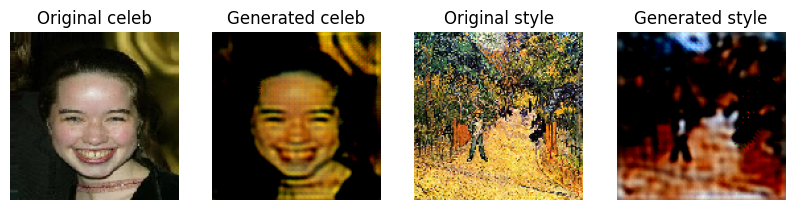

1/1 [==============================] - 0s 21ms/step


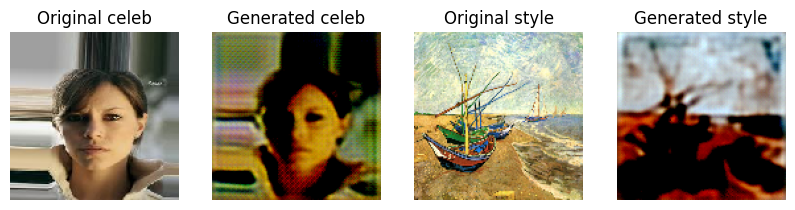

1/1 [==============================] - 0s 21ms/step


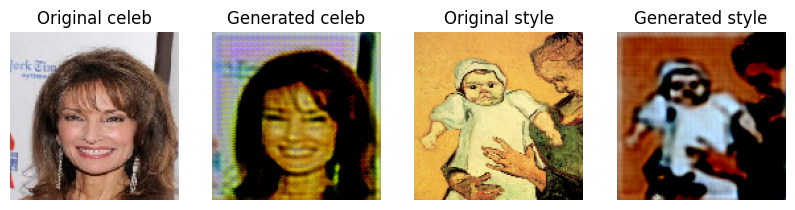

1/1 [==============================] - 0s 23ms/step


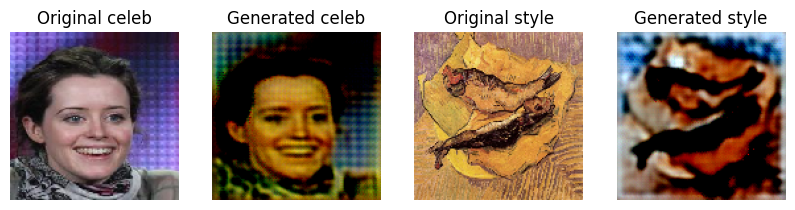

1/1 [==============================] - 0s 22ms/step


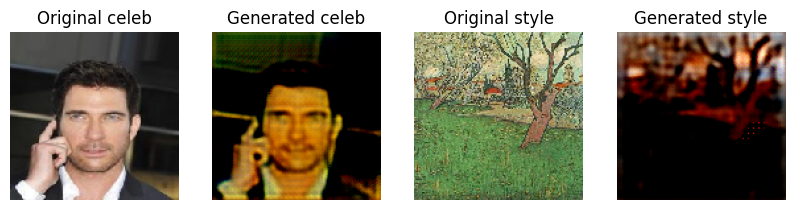

In [21]:
show_preds(CelebtoStyle_gen,StyletoCeleb_gen ,n_images=5)

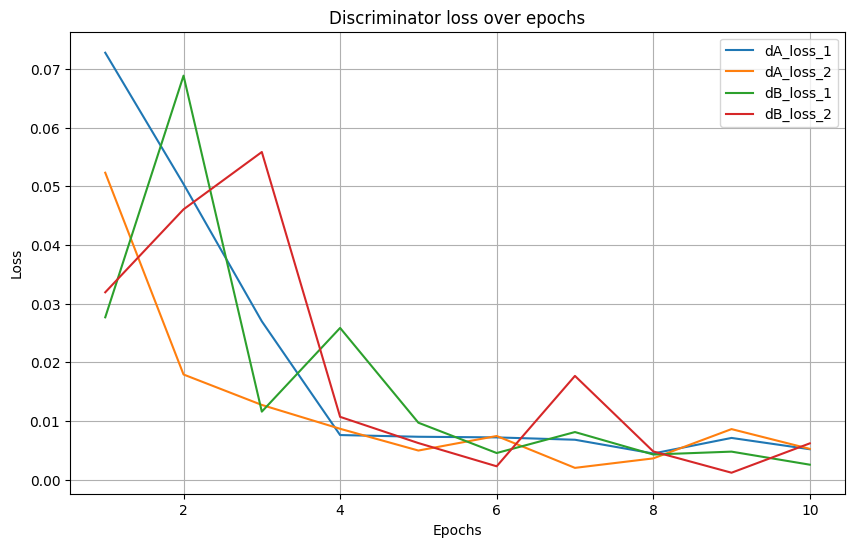

In [22]:
import matplotlib.pyplot as plt

# Extracting individual losses for plotting
dA_loss_1 = [epoch[0] for epoch in loss_history]
dA_loss_2 = [epoch[1] for epoch in loss_history]
dB_loss_1 = [epoch[2] for epoch in loss_history]
dB_loss_2 = [epoch[3] for epoch in loss_history]
gen_loss1 = [epoch[4] for epoch in loss_history]
gen_loss2 = [epoch[5] for epoch in loss_history]

epochs = range(1, len(loss_history) + 1)

# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, dA_loss_1, label='dA_loss_1')
plt.plot(epochs, dA_loss_2, label='dA_loss_2')
plt.plot(epochs, dB_loss_1, label='dB_loss_1')
plt.plot(epochs, dB_loss_2, label='dB_loss_2')

plt.title('Discriminator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

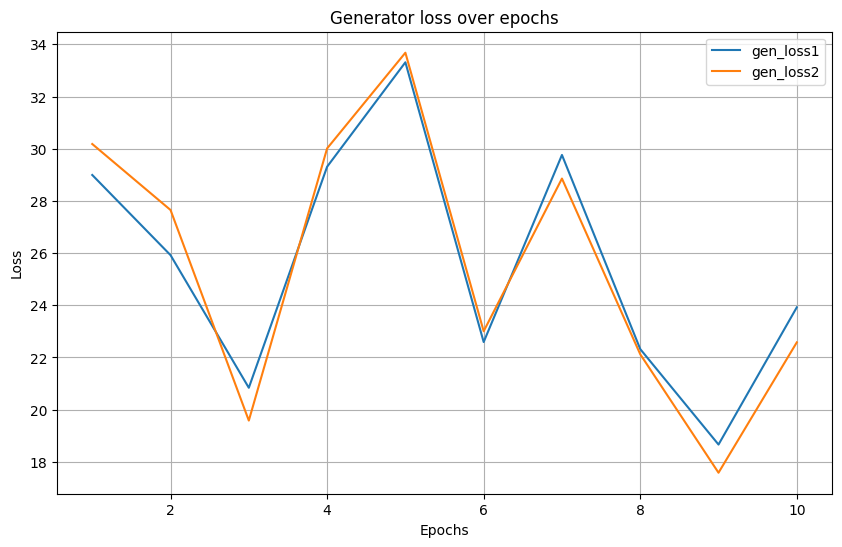

In [23]:
# Plotting the losses
plt.figure(figsize=(10, 6))

plt.plot(epochs, gen_loss1, label='gen_loss1')
plt.plot(epochs, gen_loss2, label='gen_loss2')

plt.title('Generator loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

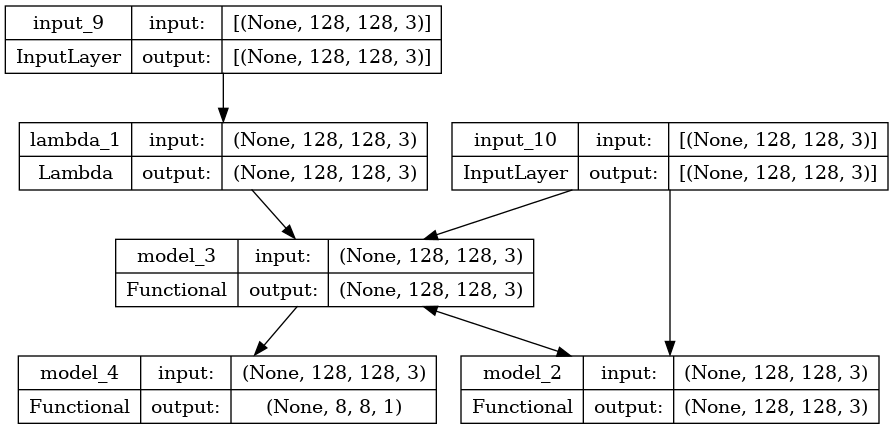

In [24]:
# Visualize architecture
!pip install tensorflow graphviz pydot

tf.keras.utils.plot_model(d_model_A, to_file='d_model_A.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(d_model_B, to_file='d_model_B.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(g_model_AtoB, to_file='g_model_AtoB.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(g_model_BtoA, to_file='g_model_BtoA.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(c_model_AtoB, to_file='c_model_AtoB.png', show_shapes=True, show_layer_names=True)
tf.keras.utils.plot_model(c_model_BtoA, to_file='c_model_BtoA.png', show_shapes=True, show_layer_names=True)
